# Library

In [1]:
import logging
import requests
from bs4 import BeautifulSoup
from urllib.error import HTTPError

import http.client as httplib  # or http.client if you're on Python 3 # httplib
httplib._MAXHEADERS = 10000
# ChunkedEncodingError

import time
import datetime
from datetime import datetime, timedelta

import re

import json

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import sys

import random 
from random import sample

In [2]:
# pathes
art_project_path = '/content/drive/MyDrive/Art/Art_Project'
art_project_path_backups = '/content/drive/MyDrive/Art/Art_Project/parsing_backups'
art_project_path_tests = '/content/drive/MyDrive/Art/Art_Project/parsing_tests'

url_add = 'https://www.artsy.net'

# files
cat_dict = '/artsy_genom_cat_dict.txt'
gen_dict = '/artsy_genom_gen_dict.txt'
artwork_dict = '/artsy_genom_artwork_dict.txt'
artist_dict = '/artsy_genom_artist_dict.txt'
temp_data = '/artsy_temp_data.csv'
temp_data_add_up = '/artsy_temp_data_add_up.csv'

# id length
cat_id_len = 2
gen_id_len = 5
artist_id_len = 5

# for addition and updating
recently_added_pref = '?sort=-published_at'
recently_updated_pref = '?sort=-partner_updated_at'

# Functions

## Openings and savings

In [3]:
# 1. Save json dict
def save_dict(tree_dict, file, folder):
  if folder=='live':
    with open(art_project_path + file, 'w') as outfile:
      json.dump(tree_dict, outfile)
  elif folder=='backup':
    with open(art_project_path_backups + file, 'w') as outfile:
      json.dump(tree_dict, outfile)

# 2. Open json dict
def open_dict(file, folder):
  if folder=='live':
    with open(art_project_path + file, 'rb') as infile:
      tree_dict = json.load(infile)
  elif folder=='backup':
    with open(art_project_path_backups + file, 'rb') as infile:
      tree_dict = json.load(infile)
  return tree_dict

# 3. Open file.csv
def open_file_csv(file, folder): # folder: live, backup or test
  if folder=='live':
    df = pd.read_csv(art_project_path + file)
  elif folder=='backup':
    df = pd.read_csv(art_project_path_backups + file)
  elif folder=='test':
    df = pd.read_csv(art_project_path_tests + file)
  return df

# 4. Save df to csv file
def save_df_file(df, file, folder): # folder: live, backup or test
  if folder=='live':
    df.to_csv(art_project_path + file, index=False)
  elif folder=='backup':
    df.to_csv(art_project_path_backups + file, index=False)
  elif folder=='test':
    df.to_csv(art_project_path_tests + file, index=False)


## Parsing

### get_page

In [4]:
# 5. get_page
logging.basicConfig(level=logging.DEBUG, format="%(message)s")

def get_page(url, session):
  #response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
  try:
    response = session.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
  except: # requests.exceptions.ChunkedEncodingError:
    print('Error: ' + str(url) + '-> resession')
    time.sleep(0.5)
    session = requests.Session()
    response = session.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})

  try:
    response.raise_for_status()
    bs_page = BeautifulSoup(response.text, 'html.parser')
    return bs_page

  except requests.exceptions.HTTPError: # for correction
    pass
    print('HTTPError: ' + str(url))
    
  #bs_page = BeautifulSoup(response.text, 'html.parser')
  #return bs_page

### get next pages links list

In [5]:
# 6. get next pages links list
def get_next_page_list(url, page):
  try:
    last_page_data = page.find('main').find_all('nav', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 ibHUpM gzwvJD')[0].find_all('a')[-2]
    last_page = last_page_data.get_text()
    page_link = last_page_data.get('href')[:-len(last_page)]
    next_page_link_list_new = [url + page_link + str(p) for p in range(2, int(last_page)+1)]
  except:
    next_page_link_list_new = []

  return next_page_link_list_new

# 6.1 get next pages links list
def get_next_page_list_add_up(url, page):
  try:
    last_page_data = page.find('main').find_all('nav', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 ibHUpM gzwvJD')[0].find_all('a')[-2]
    last_page = last_page_data.get_text()
    last_page_link = last_page_data.get('href')
    next_page_link_list_new = [url + last_page_link.split('&')[0][:-len(last_page)] + str(p) + '&' + last_page_link.split('&')[1] for p in range(2, int(last_page)+1)]
  except:
    next_page_link_list_new = []

  return next_page_link_list_new

In [6]:
# https://www.artsy.net/gene/inlay
# https://www.artsy.net/gene/inlay?page=2
# https://www.artsy.net/gene/inlay?sort=-published_at
# https://www.artsy.net/gene/inlay?page=2&sort=-published_at

### get data from pages

In [7]:
# 7. get data from pages
def get_page_data(page):
  code_block = page.find('main').find_all('div', class_='ArtworkGrid-sc-1jsqquq-0 djwrUe')
  try:
    object_block = code_block[0].find_all('div', relay='[object Object]')
  
    # for the beggining into a DataFrame
    artsy_id_list = [obj.get('data-id') for obj in object_block]
    imgage_list = [obj.find_all('a')[0].find('img').get('src') for obj in object_block]
    artist_list = [obj.find_all('a')[1].find_all('div')[0].get_text() for obj in object_block]
  
    gallery_list = []
    for obj in object_block:
      try:
        gallery_list.append(obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn hENCPo').get_text())
      except:
        gallery_list.append(np.nan)
  
    price_list = []
    for obj in object_block:
      try:
        price_list.append(obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 eXbAnU jkuGdd').get_text())
      except:
        price_list.append(np.nan)
  
    # can be no year info !!!
    name_list = []
    year_list = []
    for obj in object_block:
      text = obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn kySEpG').get_text()
      name = obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn kySEpG').find('i').get_text()
      year = text.replace(name, '').replace(', ', '')
      if len(year)==0:
        year = np.nan
      name_list.append(name)
      year_list.append(year)

    df_data_new = pd.DataFrame({'artsy_id': artsy_id_list,
                                'name': name_list, 
                                'link': imgage_list, 
                                'year': year_list,
                                'artist': artist_list,
                                'gallery': gallery_list,
                                'price': price_list
                                })
  except:
    df_data_new = pd.DataFrame({'artsy_id': np.nan,
                                'name': np.nan, 
                                'link': np.nan, 
                                'year': np.nan,
                                'artist': np.nan,
                                'gallery': np.nan,
                                'price': np.nan
                                }, index=[0])
  
  return df_data_new

### get category data into df - aggregator

In [8]:
# Function aggregator
# 8. Get the all category data into DataFrame
def get_df_data(df_input, genes_links_list, genes_ids_list, cat):
  start_time = time.time()
  print(datetime.now().time())
  df_output = df_input.copy()
  df_output = df_output[0:0]

  for link in genes_links_list:
    session = requests.Session()
    total_link = url_add + link
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has started')
    # 5. get_page
    gene_page = get_page(total_link, session)
    #           get_page(url, session) -> 
    # -> bs_page
    
    # 6. get next pages links list
    next_page_link_list = get_next_page_list(url_add, gene_page)
    #                     get_next_page_list(url, page) -> 
    # -> next_page_link_list_new
    print(len(next_page_link_list)+1, 'pages for parsing')

    # 7. get data from pages
    df_data = get_page_data(gene_page)
    #         get_page_data(page) -> 
    # -> df_data_new
    df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
    df_data['category_id'] = cat
    df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')

    df_output = pd.concat([df_output, df_data])

    # Get data from next pages
    if len(next_page_link_list) > 0:
      for page_link in next_page_link_list:
        # 5. get_page
        gene_page = get_page(page_link, session)
        #           get_page(url, session) -> 
        # -> bs_page

        # 7. get data from pages
        df_data = get_page_data(gene_page)
        #         get_page_data(page) -> 
        # -> df_data_new
        df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
        df_data['category_id'] = cat
        df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
        df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')

        df_output = pd.concat([df_output, df_data])
      
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has finished')
    print((time.time() - start_time), 'seconds have passed')
    print(datetime.now().time())
    print('')
    time.sleep(0.5)

  return df_output

In [9]:
# Function aggregator
# 8.1 Get the first pages category data into DataFrame
def get_df_data_add_up(df_input, genes_links_list, genes_ids_list, genes_cat_list, g_c):
  start_time = time.time()
  print(datetime.now().time())
  df_output = df_input.copy()
  #df_output['pages_count'] = np.nan # only for the first time !!!!
  #df_output['second_page_link'] = np.nan # only for the first time !!!!
  df_output = df_output[0:0]

  session = requests.Session()
  l_c = 0
  for link in genes_links_list:
    #session = requests.Session()
    total_link = url_add + link
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has started')
    # 5. get_page
    gene_page = get_page(total_link, session)
    #           get_page(url, session) -> 
    # -> bs_page
    
    try:
      # 6.1 get next pages links list
      next_page_link_list = get_next_page_list_add_up(url_add, gene_page)
      #                     get_next_page_list_add_up(url, page) -> 
      # -> next_page_link_list_new
    except: 
      next_page_link_list = []
    
    print(len(next_page_link_list)+1, 'pages for parsing')

    try:
      # 7. get data from pages
      df_data = get_page_data(gene_page)
      #         get_page_data(page) -> 
      # -> df_data_new
    except:
      df_data = pd.DataFrame({'artsy_id': np.nan,
                              'name': np.nan, 
                              'link': np.nan, 
                              'year': np.nan,
                              'artist': np.nan,
                              'gallery': np.nan,
                              'price': np.nan
                              }, index=[0])
      
    df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
    df_data['category_id'] = genes_cat_list[genes_links_list.index(link)] # cat !!!!!!!!!
    df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['pages_count'] = len(next_page_link_list)+1
    if len(next_page_link_list) > 0:
      df_data['second_page_link'] = next_page_link_list[0]
    else:
      df_data['second_page_link'] = np.nan

    df_output = pd.concat([df_output, df_data])
      
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has finished')
    print((time.time() - start_time), 'seconds have passed')
    print(datetime.now().time())
    print('')
    l_c += 1
    g_c += 1
    if l_c == 10:
      session = requests.Session()
      l_c = 0
    time.sleep(0.5)

  return df_output, g_c

### correct image link

In [10]:
# 9. correct image link
def img_link_corr(img):
  parts = img.split('.jpg')[0].replace('?', '/').replace('%2F', '/').split('/')
  img_new = parts[0] + '//' + parts[5] + '/' + parts[6] + '/' + parts[7]  + '.jpg'
  return img_new

### filtering

In [11]:
# 10. Filtering
def get_cat_id(cat):
  return cat

def gene_links_samples(gen_key):
  cat_id = get_cat_id(cat)
  return genes_dict[gen_key]['category_id'] == cat_id

# Genes dict

In [12]:
url = 'https://www.artsy.net/categories'

In [13]:
response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
genome_page = BeautifulSoup(response.text, 'html.parser')
genome_page.title.string

Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /categories HTTP/1.1" 200 None


'Artsy — Discover, Buy, and Sell Fine Art'

## categories_dict

In [ ]:
# !!!!! For the first time !!!!!
confirmation = input('Confirm the categories_dict re/seting (y/n)')
if confirmation == 'y':
  categories_dict = {} # !!!!!!!!!
  print('categories_dict has been re/set {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict re/seting (y/n)y
categories_dict has been re/set 2022-03-30 06:01
dictionary's length is - 0


In [14]:
# !!!!! All next times !!!!!
confirmation = input('Confirm the categories_dict opening (y/n)')
if confirmation == 'y':
  categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
  print('categories_dict has been opened {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict opening (y/n)y
categories_dict has been opened 2022-05-19 03:23
dictionary's length is - 16


In [15]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [16]:
categories_block = genome_page.find('div', class_='sticky-inner-wrapper').find_all('div', class_='Box-sc-15se88d-0 Flex-cw39ct-0 elJsUD')

#categories_dict = {'artistic_disciplines': {'id': '02', 'name': 'Artistic Disciplines', 'link': 'jump--artistic-disciplines'}}
id = len(categories_dict) + 1
for cat in categories_block:
  key = cat.find('a').get('href').replace('#jump--', '').replace('-', '_')
  if key not in categories_dict.keys():
    categories_dict.update({key: {'id': str(id) if len(str(id))>1 else '0'+str(id), 'name': cat.get_text(), 'link': cat.find('a').get('href').replace('#', ''), 'genes_id': [], 'parsing_date': datetime.now().date().strftime('%Y-%m-%d'), 'updating_date': datetime.now().date().strftime('%Y-%m-%d')}})
    #categories_dict[key] = {'id': str(id) if len(str(id))>1 else '0'+str(id), 'name': cat.get_text(), 'link': cat.find('a').get('href').replace('#', ''), 'genes_id': [], 'parsing_date': datetime.now().date().strftime('%Y-%m-%d'), 'updating_date': datetime.now().date().strftime('%Y-%m-%d')}
    id += 1
    print('New key has been added - {}'.format(key))
  else:
    if categories_dict[key]['link'] != cat.find('a').get('href').replace('#', '') or categories_dict[key]['name'] != cat.get_text():
      print('an Old name - {}\nor an Old link - {}'.format(categories_dict[key]['name'], categories_dict[key]['link']))
      categories_dict[key].update({'link': cat.find('a').get('href').replace('#', '')})
      categories_dict[key].update({'name': cat.get_text()})
      categories_dict[key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
      print('has been updated with \na New name - {}\nor a New link - {}'.format(categories_dict[key]['name'], categories_dict[key]['link']))
      print('')

In [17]:
len(categories_dict)

16

In [ ]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [ ]:
confirmation = input('Confirm the categories_dict saving (y/n)')
if confirmation == 'y':
  save_dict(categories_dict, cat_dict) # 1. Save json dict
  print('categories_dict has been saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict saving (y/n)y
categories_dict has been saved 2022-03-30 06:02
dictionary's length is - 16


## genes_dict

In [ ]:
# !!!!! For the first time !!!!!
confirmation = input('Confirm the genes_dict re/seting (y/n)')
if confirmation == 'y':
  genes_dict = {} # !!!!!!!!!!!!
  print('genes_dict has been re/set {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict re/seting (y/n)y
genes_dict was re/set


In [18]:
# !!!!! All next times !!!!!
confirmation = input('Confirm the genes_dict opening (y/n)')
if confirmation == 'y':
  genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
  print('genes_dict has been opened {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict opening (y/n)y
genes_dict has been opened 2022-05-19 03:23
dictionary's length is - 1033


In [19]:
# !!!!! All next times !!!!!
# Determining the count of genes in the category for creating an id (using () instead of [] is also possible)
count_list = [sum([1 for v in genes_dict.values() if v['category_id']==value['id']]) for value in categories_dict.values()]
id_len = len(str(max(count_list)))
print(id_len)
print(count_list)

3
[7, 213, 252, 26, 75, 176, 20, 68, 39, 22, 69, 27, 6, 7, 19, 7]


In [ ]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [20]:
#genes_dict = {'architecture_1': {'id': '0201', 'name': 'Architecture', 'link': '/gene/architecture-1', 'category_id': '02'}}
# !!! working link is 'https://www.artsy.net' + link !!!
for value in categories_dict.values():
  category = genome_page.find('div', id=value['link']).find('h2').text
  if category == value['name']:
    id = sum([1 for v in genes_dict.values() if v['category_id'] == value['id']]) + 1
    #id = count+1
    gens_block = genome_page.find('div', id=value['link']).find_all('a')
    for a in gens_block:
      gen_key = a.get('href').replace('/gene/', '').replace('-', '_')
      if gen_key not in genes_dict.keys():
        genes_dict.update({gen_key: {'id': value['id']+('0'*(id_len-len(str(id)))+str(id)), 'name': a.get_text(), 'link': a.get('href'), 'category_id': value['id'], 'artsy_id': [], 'artist_id': [], 'parsing_date': datetime.now().date().strftime('%Y-%m-%d'), 'updating_date': datetime.now().date().strftime('%Y-%m-%d')}})
        id += 1
        print('New key has been added - {}'.format(gen_key)) # !!! Not for the first time
      else:
        if genes_dict[gen_key]['link'] != a.get('href') or genes_dict[gen_key]['name'] != a.get_text():
          print('an Old name - {}\nor an Old link - {}'.format(genes_dict[gen_key]['name'], genes_dict[gen_key]['link']))
          genes_dict[gen_key].update({'link': a.get('href')})
          genes_dict[gen_key].update({'name': a.get_text()})
          genes_dict[gen_key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
          print('has been updated with \na New name - {}\nor a New link - {}'.format(genes_dict[gen_key]['name'], genes_dict[gen_key]['link']))
          print('')
  else:
    print("Category name doesn't match")

In [21]:
len(genes_dict)

1033

In [22]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [ ]:
filtered_dict = {k: v for k, v in categories_dict.items() if v['id'] == genes_dict['nft']['category_id']}
print('New gene in category:', list(filtered_dict.keys())[0])
print('')
genes_dict['nft']

New gene in category: medium_and_techniques



{'artist_id': [],
 'artsy_id': [],
 'category_id': '06',
 'id': '06176',
 'link': '/gene/nft',
 'name': 'NFT',
 'parsing_date': '2022-04-20',
 'updating_date': '2022-04-20'}

In [ ]:
print(url_add + genes_dict['nft']['link'])

https://www.artsy.net/gene/nft


In [ ]:
confirmation = input('Confirm the genes_dict saving (y/n)')
if confirmation == 'y':
  save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict
  print('genes_dict was saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict saving (y/n)y
genes_dict was saved 2022-04-20 07:24
dictionary's length is - 1033


### addition/updating lists of genes' id into the categories_dict

In [ ]:
# Dict of genes' id for the categories_dict
#cat_gen_id_dict = {}
#for value in categories_dict.values():
#  gen_id_list = [v['id'] for v in genes_dict.values() if v['category_id'] == value['id']]
#  cat_gen_id_dict.update({value['id']: gen_id_list})

#len(cat_gen_id_dict)

16

In [ ]:
#cat_gen_id_dict['01']

['01001', '01002', '01003', '01004', '01005', '01006', '01007']

In [ ]:
#for k, v in categories_dict.items():
#  for key, value in cat_gen_id_dict.items():
#    if v['id'] == key and categories_dict[k]['genes_id'] != value:
#      categories_dict[k].update({'genes_id': value})
#      categories_dict[k].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

#len(categories_dict)

16

In [ ]:
for key, value in categories_dict.items():
  gen_id_list = [v['id'] for v in genes_dict.values() if v['category_id'] == value['id']]
  if categories_dict[key]['genes_id'] != gen_id_list:
      categories_dict[key].update({'genes_id': gen_id_list})
      categories_dict[key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
      print('Category', key, 'has been updated')

len(categories_dict)

Category {'id': '06', 'name': 'Medium and Techniques', 'link': 'jump--medium-and-techniques', 'genes_id': ['06001', '06002', '06003', '06004', '06005', '06006', '06007', '06008', '06009', '06010', '06011', '06012', '06013', '06014', '06015', '06016', '06017', '06018', '06019', '06020', '06021', '06022', '06023', '06024', '06025', '06026', '06027', '06028', '06029', '06030', '06031', '06032', '06033', '06034', '06035', '06036', '06037', '06038', '06039', '06040', '06041', '06042', '06043', '06044', '06045', '06046', '06047', '06048', '06049', '06050', '06051', '06052', '06053', '06054', '06055', '06056', '06057', '06058', '06059', '06060', '06061', '06062', '06063', '06064', '06065', '06066', '06067', '06068', '06069', '06070', '06071', '06072', '06073', '06074', '06075', '06076', '06077', '06078', '06079', '06080', '06081', '06082', '06083', '06084', '06085', '06086', '06087', '06088', '06089', '06090', '06091', '06092', '06093', '06094', '06095', '06096', '06097', '06098', '06099', '0

16

In [ ]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [ ]:
confirmation = input('Confirm the categories_dict saving (y/n)')
if confirmation == 'y':
  save_dict(categories_dict, cat_dict, 'live') # 1. Save json dict
  print('categories_dict has been saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict saving (y/n)y
categories_dict has been saved 2022-04-20 07:38
dictionary's length is - 16


# Artworks and Artists dicts

## Filtering

The fastest and simplest way to collect data is to go through the genes_dict and read data from a tape of objects like from a news feed. On a tape they have:
- artist's name - to the artists_dict !!!
- artwork name - to the artworks_dict
- artwork year - to the artworks_dict
- Galleries and Institutions name - to the galleries_dict !!!
- price - to the artworks_dict
- image link - to the artworks_dict

That's anough for me.

In parallel I'm going to collect artists_dict and galleries_dict.

Artwork can belong to different genes, but I don't need this repetition in the artworks_dict. So I can't create a composed id for it (like gene id). Artwork id should be end-to-end.

Seems like I should choose the most comprehensive category, collect its database, and then add to it only new information.

But how much artworks are in Artsy database? Via their API I collected around 26 000 once.

In [23]:
categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
print("dictionary's length is - {}".format(len(categories_dict)))

dictionary's length is - 16


In [ ]:
def by_value(item):
  return len(item[1]['genes_id'])

for k, v in sorted(categories_dict.items(), key=by_value, reverse=True):
  print(k, '->', 'id', v['id'], '->', 'genes count' , len(v['genes_id']))

styles_and_movements -> id 03 -> genes count 252
subject_matter -> id 02 -> genes count 213
medium_and_techniques -> id 06 -> genes count 175
visual_qualities -> id 05 -> genes count 75
cultural_and_religious_styles -> id 11 -> genes count 69
geographic_regions -> id 08 -> genes count 68
materials -> id 09 -> genes count 39
furniture_and_lighting -> id 12 -> genes count 27
design_movements -> id 04 -> genes count 26
design_concepts_and_techniques -> id 10 -> genes count 22
time_periods -> id 07 -> genes count 20
tableware_vessels_and_objects -> id 15 -> genes count 19
artistic_disciplines -> id 01 -> genes count 7
jewelry_and_fashion_object_types -> id 14 -> genes count 7
antiquities_artifacts_and_religious_objects -> id 16 -> genes count 7
textiles -> id 13 -> genes count 6


03 styles_and_movements looks like the the most comprehensive category.
Next will be:
- subject_matter -> 02
- medium_and_techniques -> 06

In [12]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
print("dictionary's length is - {}".format(len(genes_dict)))

dictionary's length is - 1033


## Data collecting

### Parsing

#### First collection

In [ ]:
# for first collection !!!!!!!!!!
cat = '09'
filtered_dict = {k: v for k, v in genes_dict.items() if v['category_id'] == cat}
genes_links_list = [v['link'] for v in filtered_dict.values()]
genes_ids_list = [v['id'] for v in filtered_dict.values()]
print(len(genes_links_list))
print(len(genes_ids_list))

39
39


In [ ]:
# NEW GENE !!!
cat = '06'
genes_links_list = [genes_dict['nft']['link']]
genes_ids_list = [genes_dict['nft']['id']]
print(len(genes_links_list))
print(len(genes_ids_list))

1
1


In [ ]:
len(genes_ids_list_er)

2

In [ ]:
# too many genes -> let's collect by 50 at a time
backup_names = []

In [ ]:
df_temp_data_old = open_file_csv(temp_data, 'live') # 3. Open file.csv
try:
  # 8. Get the all category data into DataFrame    !!!!! [:] or _er         !!!!! [:] or _er 
  df_temp_data_new = get_df_data(df_temp_data_old, genes_links_list, genes_ids_list, cat)
  #                  get_df_data(df_input, genes_links_list, genes_ids_list, cat) ->
  # -> df_output
except SystemExit:
  pass

save_df_file(df_temp_data_new, temp_data, 'live') # 4. Save df to csv file

new_name_csv = temp_data.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
backup_names.append(new_name_csv)
save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file

Starting new HTTPS connection (1): www.artsy.net:443


08:37:53.808458
Parsing of gene 06176 https://www.artsy.net/gene/nft has started


https://www.artsy.net:443 "GET /gene/nft HTTP/1.1" 200 None


9 pages for parsing


https://www.artsy.net:443 "GET /gene/nft?page=2 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=3 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=4 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=5 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=6 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=7 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=8 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=9 HTTP/1.1" 200 None


Parsing of gene 06176 https://www.artsy.net/gene/nft has finished
16.782116651535034 seconds have passed
08:38:10.590718



Saving blocks of 50 genes' data in separate files in beckup folder. Then we'll join them together and check if some pages have been missed during the parsing.

In [ ]:
backup_names

['/artsy_temp_data_2022-04-20 08:38:11.107399.csv']

##### Primary parsing checking

Checking the completeness of the data

In [ ]:
# cat 06 NEW GENE
#backup_names = ['/artsy_temp_data_2022-04-09 06:44:32.738152.csv']
backup_names

['/artsy_temp_data_2022-04-20 08:38:11.107399.csv']

In [ ]:
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_cat_dat_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_cat_dat = pd.concat([df_cat_dat, df_cat_dat_part])

In [ ]:
# or
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv

In [ ]:
df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       263 non-null    object
 1   name           263 non-null    object
 2   link           263 non-null    object
 3   year           257 non-null    object
 4   artist         263 non-null    object
 5   gallery        263 non-null    object
 6   price          263 non-null    object
 7   gene_id        263 non-null    int64 
 8   category_id    263 non-null    int64 
 9   parsing_date   263 non-null    object
 10  updating_date  263 non-null    object
dtypes: int64(2), object(9)
memory usage: 22.7+ KB


In [ ]:
df_cat_dat['category_id'].unique()

array([6])

In [ ]:
# !!!!!!!!!!!!!!!!

In [ ]:
df_cat_dat_nan = df_cat_dat.loc[df_cat_dat['category_id'].isna()==True]
df_cat_dat_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2611 to 4705
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           0 non-null      object 
 3   year           0 non-null      object 
 4   artist         0 non-null      object 
 5   gallery        0 non-null      object 
 6   price          0 non-null      object 
 7   gene_id        0 non-null      float64
 8   category_id    0 non-null      object 
 9   parsing_date   0 non-null      object 
 10  updating_date  0 non-null      object 
dtypes: float64(1), object(10)
memory usage: 192.0+ bytes


In [ ]:
df_cat_dat_nan

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
2611,61698fb5299f47000de9a839,‘Ero’ chairs by Starck for Kartell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4705,61698fb5299f47000de9a839,‘Ero’ chairs by Starck for Kartell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
artsy_id_list = df_cat_dat_nan['artsy_id'].tolist()
name_list = df_cat_dat_nan['name'].tolist()

In [ ]:
df_cat_dat_date = df_cat_dat.loc[df_cat_dat['category_id']=='2022-04-19']
df_cat_dat_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2612 to 4706
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           2 non-null      object 
 3   year           2 non-null      object 
 4   artist         2 non-null      object 
 5   gallery        2 non-null      object 
 6   price          2 non-null      object 
 7   gene_id        2 non-null      float64
 8   category_id    2 non-null      object 
 9   parsing_date   2 non-null      object 
 10  updating_date  0 non-null      object 
dtypes: float64(1), object(10)
memory usage: 192.0+ bytes


In [ ]:
df_cat_dat_date

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
2612,(Italy),https://d7hftxdivxxvm.cloudfront.net?resize_to...,Circa 2000,Philippe Starck‘Ero’ chairs by Starck for Kart...,Eclectica Contemporary,Price on request,12005,12.0,2022-04-19,2022-04-19,NaN
4706,(Italy),https://d7hftxdivxxvm.cloudfront.net?resize_to...,Circa 2000,Philippe Starck‘Ero’ chairs by Starck for Kart...,Eclectica Contemporary,Price on request,12017,12.0,2022-04-19,2022-04-19,NaN


In [ ]:
imgage_list = df_cat_dat_date['name'].tolist()
year_list = df_cat_dat_date['link'].tolist()
artist_list = df_cat_dat_date['year'].tolist()
gallery_list = df_cat_dat_date['artist'].tolist()
price_list = df_cat_dat_date['gallery'].tolist()
gene_list = df_cat_dat_date['price'].tolist()
cat_list = df_cat_dat_date['gene_id'].tolist()
parsing_list = df_cat_dat_date['parsing_date'].tolist()

In [ ]:
df_data_new = pd.DataFrame({'artsy_id': artsy_id_list,
                            'name': name_list, 
                            'link': imgage_list, 
                            'year': year_list,
                            'artist': artist_list,
                            'gallery': gallery_list,
                            'price': price_list,
                            'gene_id': gene_list,
                            'category_id': cat_list,
                            'parsing_date': parsing_list,
                            'updating_date': parsing_list,
                            })
df_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           2 non-null      object 
 3   year           2 non-null      object 
 4   artist         2 non-null      object 
 5   gallery        2 non-null      object 
 6   price          2 non-null      object 
 7   gene_id        2 non-null      object 
 8   category_id    2 non-null      float64
 9   parsing_date   2 non-null      object 
 10  updating_date  2 non-null      object 
dtypes: float64(1), object(10)
memory usage: 304.0+ bytes


In [ ]:
df_data_new['category_id'].unique()

array([12.])

In [ ]:
df_cat_dat_12 = df_cat_dat.loc[df_cat_dat['category_id']=='12']
df_cat_dat_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23348 entries, 0 to 13960
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       23345 non-null  object 
 1   name           23345 non-null  object 
 2   link           23345 non-null  object 
 3   year           22845 non-null  object 
 4   artist         23345 non-null  object 
 5   gallery        23091 non-null  object 
 6   price          23345 non-null  object 
 7   gene_id        23348 non-null  float64
 8   category_id    23348 non-null  object 
 9   parsing_date   23348 non-null  object 
 10  updating_date  23348 non-null  object 
dtypes: float64(1), object(10)
memory usage: 2.1+ MB


In [ ]:
df_cat_dat_12['category_id'].unique()

array(['12'], dtype=object)

In [ ]:
df_cat_dat = df_cat_dat_12.copy()
df_cat_dat = pd.concat([df_cat_dat, df_data_new])
df_cat_dat = df_cat_dat.reset_index().drop(['index'], axis=1)
df_cat_dat['category_id'] = 12

df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23350 entries, 0 to 23349
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       23347 non-null  object
 1   name           23347 non-null  object
 2   link           23347 non-null  object
 3   year           22847 non-null  object
 4   artist         23347 non-null  object
 5   gallery        23093 non-null  object
 6   price          23347 non-null  object
 7   gene_id        23350 non-null  object
 8   category_id    23350 non-null  int64 
 9   parsing_date   23350 non-null  object
 10  updating_date  23350 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.0+ MB


In [ ]:
df_cat_dat['category_id'].unique()

array([12])

In [ ]:
# !!!!!!!!

In [ ]:
df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

#df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(int(float(x))) if len(str(int(float(x))))==cat_id_len else ('0'*(cat_id_len-len(str(int(float(x)))))+str(int(float(x)))))
#df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(int(float(x))) if len(str(int(float(x))))==gen_id_len else ('0'*(gen_id_len-len(str(int(float(x)))))+str(int(float(x)))))

In [ ]:
df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date


In [ ]:
df_cat_dat.loc[df_cat_dat['gene_id']=='12011'].head()

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
5611,624d61a5e25714000c32bde3,Spanish 18th Century Refectory Dining Table,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1700-1750,Unknown ArtistSpanish 18th Century Refectory D...,AVANTIQUES,"US$4,500",12011,12,2022-04-19,2022-04-19
5612,5eb1d70b3e52a6000df08763,"""Cloud"" CenterTable",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2020,"Jacques Jarrige""Cloud"" CenterTable, 2020Valeri...",Valerie Goodman Gallery,"US$27,000",12011,12,2022-04-19,2022-04-19
5613,59da74309c18db249fcdbccd,"Lacquered desk table ""Luca""",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2017,"Jacques JarrigeLacquered desk table ""Luca"", 20...",Valerie Goodman Gallery,"US$23,750",12011,12,2022-04-19,2022-04-19
5614,5bae2d5b1f74731ca8eac04a,Oval dining table with leaves,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1952,"Hans J. WegnerOval dining table with leaves, 1...",Dansk Møbelkunst Gallery,Price on request,12011,12,2022-04-19,2022-04-19
5615,620258c734e7fc000b5e722f,Lovö dining table,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1930,"Axel Einar HjorthLovö dining table, 1930Gokela...",Gokelaere & Robinson,"€14,000",12011,12,2022-04-19,2022-04-19


Getting list of genes with missing pages parsing and lounch parsing of these genes (not pages !!!) again.

In [ ]:
genes_ids_list_er = [str(g_id) for g_id in df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id']]
genes_ids_list_er = list(set(genes_ids_list_er))
genes_ids_list_er

['12014', '12011']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
genes_links_list_er

['/gene/lighting', '/gene/dining-table']

In [ ]:
df_cat_dat = df_cat_dat.dropna(subset=['artsy_id'], axis=0)

It would be better for faster errors' parsing if I got the page number info...

!!! One item can belong not only to different categoryes but also to different genes into one category. That's very important for joining with reparsed data !!!

In [ ]:
print(df_cat_dat['artsy_id'].count())
print(df_cat_dat['artsy_id'].nunique())

110253
73696


In [ ]:
print(df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].count().max())
print(df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].nunique().max())

2
1


In [ ]:
gene_artsy_groupped = df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].agg(['count']).reset_index()
gene_artsy_groupped.loc[gene_artsy_groupped['count']>1]

,gene_id,artsy_id,count
4309,06007,540f40cd7261692d6d550000,2
18541,06021,5ae9db4a9c18db166e639c7e,2
20019,06021,606d59a4b58b09000e0f0fed,2
20209,06021,60e05ea715fca20013f5854a,2
20657,06021,61c0ee1e845711000bf8163c,2
...,...,...,...
247062,06174,5f172c2dea92a20011267465,2
250018,06175,618bea8b5180b7000e0faba9,2
250139,06175,61ba11e097ec3a000b017724,2
251094,06175,623b41fed562fe000c49e3ba,2


In [ ]:
df_cat_dat.loc[df_cat_dat['artsy_id']=='6248b64fa3259b000c24e910']

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
39366,6248b64fa3259b000c24e910,Time Is Movin’,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"Mitsuyo OkadaTime Is Movin’, 2021Space 776US$290",Space 776,US$290,06175,06,2022-04-06,2022-04-06
39369,6248b64fa3259b000c24e910,Time Is Movin’,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"Mitsuyo OkadaTime Is Movin’, 2021Space 776US$290",Space 776,US$290,06175,06,2022-04-06,2022-04-06


In [ ]:
for link in df_cat_dat.loc[df_cat_dat['artsy_id']=='4d8b93484eb68a1b2c00125b']['link']:
  print(link)

https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&qua

There can be item duplicates inside one gene items' list also. Delete them.

##### Errors' parsing checking

Checking the completeness of a new data after collecting error genes

In [ ]:
# !!!!!!!!!!!!!!!!!

In [ ]:
# cat 09
backup_names = ['/artsy_temp_data_2022-04-18 15:58:00.276252.csv',
                '/artsy_temp_data_2022-04-18 16:07:15.086943.csv']

In [ ]:
df_temp_data_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_temp_data_new_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_temp_data_new = pd.concat([df_temp_data_new, df_temp_data_new_part])

#df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0) # !!!
df_temp_data_new.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_temp_data_new = df_temp_data_new.reset_index().drop(['index'], axis=1) # !!!


In [ ]:
df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [ ]:
# !!!!!!!!!!!!!

In [ ]:
df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 7
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       2373 non-null   object
 1   name           2373 non-null   object
 2   link           2373 non-null   object
 3   year           2315 non-null   object
 4   artist         2373 non-null   object
 5   gallery        2357 non-null   object
 6   price          2373 non-null   object
 7   gene_id        2373 non-null   object
 8   category_id    2373 non-null   object
 9   parsing_date   2373 non-null   object
 10  updating_date  2373 non-null   object
dtypes: object(11)
memory usage: 222.5+ KB


Everything is correct in case of empty df. -> Mergening

In [ ]:
df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date


In [ ]:
df_temp_data_new.loc[df_temp_data_new['gene_id']=='04016'].head()

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
0,6234540a64caba000b7d3d9e,Osvaldo Borsani & Eugenio Gerli for Tecno Oval...,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1968,"Osvaldo Borsani, Eugenio GerliOsvaldo Borsani ...",MORENTZ,"US$6,450",04016,04,2022-04-19,2022-04-19
1,623b0890478704000b678259,Desk,https://d7hftxdivxxvm.cloudfront.net?resize_to...,ca. 1960,"Marco ZanusoDesk , ca. 1960Gokelaere & Robinso...",Gokelaere & Robinson,"€25,000",04016,04,2022-04-19,2022-04-19
2,545a72c57261692cdfe90100,"""Nitor,"" Bronze Candlestick",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2014,"Aldus""Nitor,"" Bronze Candlestick, 2014Maison G...",Maison Gerard,"US$6,200",04016,04,2022-04-19,2022-04-19
3,5592bc6e7261693ebf00003d,Try Tray,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1995,"Gaetano PesceTry Tray, 1995The Modern ArchiveU...",The Modern Archive,US$595,04016,04,2022-04-19,2022-04-19
4,53eac6aa7261691149ef0000,Octopus Chandelier,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2014,"Achille SalvagniOctopus Chandelier, 2014Maison...",Maison Gerard,"US$147,500",04016,04,2022-04-19,2022-04-19


In [ ]:
print(url_add + genes_links_list[15])
print(genes_ids_list[15])

https://www.artsy.net/gene/italian-furniture-and-design
04016


In [ ]:
genes_ids_list_er = [genes_ids_list[15]]
genes_links_list_er = [genes_links_list[15]]

In [ ]:
# or

In [ ]:
genes_ids_list_er = [g_id for g_id in df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]['gene_id']]
genes_ids_list_er = list(set(genes_ids_list_er))
genes_ids_list_er

['09039', '09031']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
genes_links_list_er

['/gene/wood', '/gene/stone']

In [ ]:
df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0)

In [ ]:
save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file

##### Merging of all the data

In [ ]:
# cat 10
df_cat_dat_total = pd.concat([df_cat_dat, df_temp_data_new])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1) # !!!

In [ ]:
# OR
df_cat_dat_total = df_cat_dat.copy()

In [ ]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29336 entries, 0 to 29335
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          29336 non-null  object 
 1   name              29336 non-null  object 
 2   link              29336 non-null  object 
 3   year              28085 non-null  object 
 4   artist            29336 non-null  object 
 5   gallery           29330 non-null  object 
 6   price             29336 non-null  object 
 7   gene_id           29336 non-null  int64  
 8   category_id       29336 non-null  int64  
 9   parsing_date      29336 non-null  object 
 10  updating_date     29336 non-null  object 
 11  pages_count       29336 non-null  float64
 12  second_page_link  28197 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 2.9+ MB


Genes checking: sometimes there may be a problem (like with cat 03)

In [ ]:
print(len(genes_ids_list))
df_cat_dat_total['gene_id'].dropna().nunique()

1


1

In [ ]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_new_gene.csv', 'backup') # 4. Save df to csv file
#df_cat_dat_total = open_file_csv('/artsy_temp_data_09.csv', 'backup') # 3. Open file.csv

In [ ]:
# !!! cat 10 !!!
check_gene_id = df_cat_dat_total['gene_id'].dropna().unique().tolist()
len(check_gene_id)

27

In [ ]:
genes_ids_list_er = list(set(genes_ids_list) - set(check_gene_id))
genes_ids_list_er

['10021',
 '10008',
 '10001',
 '10013',
 '10006',
 '10017',
 '10020',
 '10004',
 '10009',
 '10003',
 '10014',
 '10015',
 '10012',
 '10016',
 '10005',
 '10010',
 '10011',
 '10018',
 '10002',
 '10007',
 '10022',
 '10019']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
for link in genes_links_list_er:
  print(url_add + link)

https://www.artsy.net/gene/whimsical-design
https://www.artsy.net/gene/handcrafted-furniture-and-design
https://www.artsy.net/gene/cad-computer-aided-design
https://www.artsy.net/gene/modular-design
https://www.artsy.net/gene/engineering-slash-construction-and-design
https://www.artsy.net/gene/restrained-forms
https://www.artsy.net/gene/timber-frame-construction
https://www.artsy.net/gene/design-by-artists
https://www.artsy.net/gene/iconic-works-of-design
https://www.artsy.net/gene/design-by-architects
https://www.artsy.net/gene/non-functional-design
https://www.artsy.net/gene/reinforced-concrete-construction
https://www.artsy.net/gene/masonry-construction
https://www.artsy.net/gene/religious-building
https://www.artsy.net/gene/emerging-design
https://www.artsy.net/gene/industrial-and-product-design
https://www.artsy.net/gene/jewelry-by-painters-and-sculptors
https://www.artsy.net/gene/steel-slash-iron-frame-construction
https://www.artsy.net/gene/childrens-furniture-and-design
https:/

Pages of these genes are empty, so everything's allright.

#### Addition and Updating

In [25]:
# for addition or updating !!!!!!!!!!!

def get_lists(cat, prefix):

  filtered_dict = {k: v for k, v in genes_dict.items() if v['category_id'] == cat}
  genes_links_list = [v['link']+prefix for v in filtered_dict.values()]
  genes_ids_list = [v['id'] for v in filtered_dict.values()]
  genes_cat_list = [cat for gene in genes_ids_list]
  print("Lists' length:", len(genes_links_list), len(genes_ids_list), len(genes_cat_list))
  print('')

  return genes_links_list, genes_ids_list, genes_cat_list


def get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list, g_c):
  
  df_temp_data_old = open_file_csv(temp_data_add_up, 'live') # 3. Open file.csv
  #  8.1 Get the first pages category data into DataFrame
  #try:                                   #                     !!!!!!!               !!!!!!      !!!!!!
  df_temp_data_new, gene_count = get_df_data_add_up(df_temp_data_old, genes_links_list, genes_ids_list, genes_cat_list, g_c)
    #                              get_df_data_add_up(df_input, genes_links_list, genes_ids_list, genes_cat_list, g_c) ->
    # -> df_output
  #except SystemExit:
  #  pass
  #  print('SystemExit !!!!!')

  save_df_file(df_temp_data_new, temp_data_add_up, 'live') # 4. Save df to csv file

  new_name_csv = temp_data_add_up.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
  #new_names.append(new_name_csv)
  save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file
  print(gene_count, 'genes have been collected')
  print('')

  #if gene_count != len(genes_links_list):
  #  get_files_w_data(genes_links_list[gene_count-1:], genes_ids_list[gene_count-1:], genes_cat_list[gene_count-1:], gene_count)

  return new_name_csv

In [ ]:
#prefix = recently_added_pref

In [26]:
prefix = recently_added_pref
#prefix = recently_updated_pref
backup_names = []

print("Dictionary's length is - {}".format(len(categories_dict)))
cat_id_list = [v['id'] for v in categories_dict.values()]
print("List's length is - {}".format(len(cat_id_list)))
print('')

for cat in cat_id_list:
  g_c = 0
  #new_names = []
  lists = get_lists(cat, prefix)
  new_name_csv = get_files_w_data(lists[0], lists[1], lists[2], g_c) # new_names
  #              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
  # -> backup_names
  backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

Dictionary's length is - 16
List's length is - 16

Lists' length: 7 7 7



Starting new HTTPS connection (1): www.artsy.net:443


03:24:11.204625
Parsing of gene 01001 https://www.artsy.net/gene/architecture-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/architecture-1?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 01001 https://www.artsy.net/gene/architecture-1?sort=-published_at has finished
2.9395081996917725 seconds have passed
03:24:14.144968

Parsing of gene 01002 https://www.artsy.net/gene/design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?sort=-published_at has finished
5.743110179901123 seconds have passed
03:24:16.947797

Parsing of gene 01003 https://www.artsy.net/gene/fashion-design-and-wearable-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fashion-design-and-wearable-art?sort=-published_at HTTP/1.1" 200 None


93 pages for parsing
Parsing of gene 01003 https://www.artsy.net/gene/fashion-design-and-wearable-art?sort=-published_at has finished
9.38770079612732 seconds have passed
03:24:20.592864

Parsing of gene 01004 https://www.artsy.net/gene/graphic-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graphic-design?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 01004 https://www.artsy.net/gene/graphic-design?sort=-published_at has finished
11.683338165283203 seconds have passed
03:24:22.888319

Parsing of gene 01005 https://www.artsy.net/gene/jewelry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/jewelry?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 01005 https://www.artsy.net/gene/jewelry?sort=-published_at has finished
14.494840621948242 seconds have passed
03:24:25.699896

Parsing of gene 01006 https://www.artsy.net/gene/music?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/music?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 01006 https://www.artsy.net/gene/music?sort=-published_at has finished
17.579395055770874 seconds have passed
03:24:28.784728

Parsing of gene 01007 https://www.artsy.net/gene/written-word?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/written-word?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 01007 https://www.artsy.net/gene/written-word?sort=-published_at has finished
20.4061381816864 seconds have passed
03:24:31.611126



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected

Lists' length: 213 213 213

03:24:32.142665
Parsing of gene 02001 https://www.artsy.net/gene/abstract-landscape?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-landscape?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 02001 https://www.artsy.net/gene/abstract-landscape?sort=-published_at has finished
3.005232334136963 seconds have passed
03:24:35.147954

Parsing of gene 02002 https://www.artsy.net/gene/adolescence-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/adolescence-1?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 02002 https://www.artsy.net/gene/adolescence-1?sort=-published_at has finished
5.900289535522461 seconds have passed
03:24:38.043049

Parsing of gene 02003 https://www.artsy.net/gene/advertising-and-brands?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/advertising-and-brands?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 02003 https://www.artsy.net/gene/advertising-and-brands?sort=-published_at has finished
8.945450067520142 seconds have passed
03:24:41.088172

Parsing of gene 02004 https://www.artsy.net/gene/african-diaspora?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/african-diaspora?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02004 https://www.artsy.net/gene/african-diaspora?sort=-published_at has finished
11.356721639633179 seconds have passed
03:24:43.499444

Parsing of gene 02005 https://www.artsy.net/gene/allegory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/allegory?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 02005 https://www.artsy.net/gene/allegory?sort=-published_at has finished
13.816300392150879 seconds have passed
03:24:45.959018

Parsing of gene 02006 https://www.artsy.net/gene/alter-egos-and-avatars?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/alter-egos-and-avatars?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 02006 https://www.artsy.net/gene/alter-egos-and-avatars?sort=-published_at has finished
16.39220881462097 seconds have passed
03:24:48.535597

Parsing of gene 02007 https://www.artsy.net/gene/americana?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/americana?sort=-published_at HTTP/1.1" 200 None


60 pages for parsing
Parsing of gene 02007 https://www.artsy.net/gene/americana?sort=-published_at has finished
18.878174543380737 seconds have passed
03:24:51.020889

Parsing of gene 02008 https://www.artsy.net/gene/anatomy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/anatomy?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02008 https://www.artsy.net/gene/anatomy?sort=-published_at has finished
21.929290533065796 seconds have passed
03:24:54.072013

Parsing of gene 02009 https://www.artsy.net/gene/animal-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animal-portrait?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 02009 https://www.artsy.net/gene/animal-portrait?sort=-published_at has finished
24.319106817245483 seconds have passed
03:24:56.461831

Parsing of gene 02010 https://www.artsy.net/gene/animals?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?sort=-published_at has finished
26.849186658859253 seconds have passed
03:24:58.992225



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02011 https://www.artsy.net/gene/anthropomorphism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/anthropomorphism?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02011 https://www.artsy.net/gene/anthropomorphism?sort=-published_at has finished
29.76307964324951 seconds have passed
03:25:01.905800

Parsing of gene 02012 https://www.artsy.net/gene/antiquity-as-subject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/antiquity-as-subject?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 02012 https://www.artsy.net/gene/antiquity-as-subject?sort=-published_at has finished
31.72805380821228 seconds have passed
03:25:03.871079

Parsing of gene 02013 https://www.artsy.net/gene/architectures-effects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/architectures-effects?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 02013 https://www.artsy.net/gene/architectures-effects?sort=-published_at has finished
35.098984479904175 seconds have passed
03:25:07.242346

Parsing of gene 02014 https://www.artsy.net/gene/arrivals-slash-departures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arrivals-slash-departures?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02014 https://www.artsy.net/gene/arrivals-slash-departures?sort=-published_at has finished
37.34359288215637 seconds have passed
03:25:09.486314

Parsing of gene 02015 https://www.artsy.net/gene/artist-as-ethnographer?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artist-as-ethnographer?sort=-published_at HTTP/1.1" 200 None


36 pages for parsing
Parsing of gene 02015 https://www.artsy.net/gene/artist-as-ethnographer?sort=-published_at has finished
39.86922788619995 seconds have passed
03:25:12.012246

Parsing of gene 02016 https://www.artsy.net/gene/atmospheric-landscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/atmospheric-landscapes?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 02016 https://www.artsy.net/gene/atmospheric-landscapes?sort=-published_at has finished
42.943833351135254 seconds have passed
03:25:15.087558

Parsing of gene 02017 https://www.artsy.net/gene/attenuated-figure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/attenuated-figure?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02017 https://www.artsy.net/gene/attenuated-figure?sort=-published_at has finished
45.51786470413208 seconds have passed
03:25:17.660586

Parsing of gene 02018 https://www.artsy.net/gene/bars-and-restaurants?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bars-and-restaurants?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02018 https://www.artsy.net/gene/bars-and-restaurants?sort=-published_at has finished
48.43619179725647 seconds have passed
03:25:20.579220

Parsing of gene 02019 https://www.artsy.net/gene/bathers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bathers?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02019 https://www.artsy.net/gene/bathers?sort=-published_at has finished
50.780864000320435 seconds have passed
03:25:22.923589

Parsing of gene 02020 https://www.artsy.net/gene/bedrooms-and-bathrooms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bedrooms-and-bathrooms?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 02020 https://www.artsy.net/gene/bedrooms-and-bathrooms?sort=-published_at has finished
54.355050563812256 seconds have passed
03:25:26.497773



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02021 https://www.artsy.net/gene/bible-story?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bible-story?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 02021 https://www.artsy.net/gene/bible-story?sort=-published_at has finished
56.82094216346741 seconds have passed
03:25:28.963659

Parsing of gene 02022 https://www.artsy.net/gene/body-parts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/body-parts?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 02022 https://www.artsy.net/gene/body-parts?sort=-published_at has finished
59.14198708534241 seconds have passed
03:25:31.285175

Parsing of gene 02023 https://www.artsy.net/gene/caricatures-and-parody?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caricatures-and-parody?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02023 https://www.artsy.net/gene/caricatures-and-parody?sort=-published_at has finished
62.097808837890625 seconds have passed
03:25:34.240544

Parsing of gene 02024 https://www.artsy.net/gene/celebrity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/celebrity?sort=-published_at HTTP/1.1" 200 None


79 pages for parsing
Parsing of gene 02024 https://www.artsy.net/gene/celebrity?sort=-published_at has finished
65.50911068916321 seconds have passed
03:25:37.651842

Parsing of gene 02025 https://www.artsy.net/gene/censorship?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/censorship?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02025 https://www.artsy.net/gene/censorship?sort=-published_at has finished
68.02391600608826 seconds have passed
03:25:40.168002

Parsing of gene 02026 https://www.artsy.net/gene/childhood?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/childhood?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 02026 https://www.artsy.net/gene/childhood?sort=-published_at has finished
72.50964856147766 seconds have passed
03:25:44.652371

Parsing of gene 02027 https://www.artsy.net/gene/circus-slash-carnival?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/circus-slash-carnival?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02027 https://www.artsy.net/gene/circus-slash-carnival?sort=-published_at has finished
76.25743365287781 seconds have passed
03:25:48.400467

Parsing of gene 02028 https://www.artsy.net/gene/city-scenes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/city-scenes?sort=-published_at HTTP/1.1" 200 None


87 pages for parsing
Parsing of gene 02028 https://www.artsy.net/gene/city-scenes?sort=-published_at has finished
79.24234747886658 seconds have passed
03:25:51.385073

Parsing of gene 02029 https://www.artsy.net/gene/cityscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes?sort=-published_at HTTP/1.1" 200 None


54 pages for parsing
Parsing of gene 02029 https://www.artsy.net/gene/cityscapes?sort=-published_at has finished
83.0758843421936 seconds have passed
03:25:55.218606

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?sort=-published_at has finished
85.9519670009613 seconds have passed
03:25:58.096594



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02031 https://www.artsy.net/gene/classical-figure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/classical-figure?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 02031 https://www.artsy.net/gene/classical-figure?sort=-published_at has finished
89.48867750167847 seconds have passed
03:26:01.631397

Parsing of gene 02032 https://www.artsy.net/gene/classical-mythology?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/classical-mythology?sort=-published_at HTTP/1.1" 200 None


29 pages for parsing
Parsing of gene 02032 https://www.artsy.net/gene/classical-mythology?sort=-published_at has finished
94.24810934066772 seconds have passed
03:26:06.390831

Parsing of gene 02033 https://www.artsy.net/gene/collective-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collective-history?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02033 https://www.artsy.net/gene/collective-history?sort=-published_at has finished
96.5873863697052 seconds have passed
03:26:08.730105

Parsing of gene 02034 https://www.artsy.net/gene/conflict?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/conflict?sort=-published_at HTTP/1.1" 200 None


59 pages for parsing
Parsing of gene 02034 https://www.artsy.net/gene/conflict?sort=-published_at has finished
99.81431245803833 seconds have passed
03:26:11.957050

Parsing of gene 02035 https://www.artsy.net/gene/consumerism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/consumerism?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 02035 https://www.artsy.net/gene/consumerism?sort=-published_at has finished
102.62373995780945 seconds have passed
03:26:14.766441

Parsing of gene 02036 https://www.artsy.net/gene/contrapposto?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contrapposto?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02036 https://www.artsy.net/gene/contrapposto?sort=-published_at has finished
104.72110795974731 seconds have passed
03:26:16.864144

Parsing of gene 02037 https://www.artsy.net/gene/crime?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/crime?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02037 https://www.artsy.net/gene/crime?sort=-published_at has finished
107.22046828269958 seconds have passed
03:26:19.363522

Parsing of gene 02038 https://www.artsy.net/gene/cross-cultural-dialogue?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cross-cultural-dialogue?sort=-published_at HTTP/1.1" 200 None


80 pages for parsing
Parsing of gene 02038 https://www.artsy.net/gene/cross-cultural-dialogue?sort=-published_at has finished
110.03710389137268 seconds have passed
03:26:22.180127

Parsing of gene 02039 https://www.artsy.net/gene/crowds?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/crowds?sort=-published_at HTTP/1.1" 200 None


62 pages for parsing
Parsing of gene 02039 https://www.artsy.net/gene/crowds?sort=-published_at has finished
113.10697937011719 seconds have passed
03:26:25.250013

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?sort=-published_at has finished
115.97545957565308 seconds have passed
03:26:28.118181



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02041 https://www.artsy.net/gene/decay?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/decay?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 02041 https://www.artsy.net/gene/decay?sort=-published_at has finished
118.55472540855408 seconds have passed
03:26:30.697440

Parsing of gene 02042 https://www.artsy.net/gene/deep-time?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deep-time?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 02042 https://www.artsy.net/gene/deep-time?sort=-published_at has finished
122.01885962486267 seconds have passed
03:26:34.162260

Parsing of gene 02043 https://www.artsy.net/gene/deities-and-holy-figures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deities-and-holy-figures?sort=-published_at HTTP/1.1" 200 None


60 pages for parsing
Parsing of gene 02043 https://www.artsy.net/gene/deities-and-holy-figures?sort=-published_at has finished
124.77691602706909 seconds have passed
03:26:36.919638

Parsing of gene 02044 https://www.artsy.net/gene/delegated-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/delegated-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02044 https://www.artsy.net/gene/delegated-art?sort=-published_at has finished
126.85948848724365 seconds have passed
03:26:39.002580

Parsing of gene 02045 https://www.artsy.net/gene/diaristic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/diaristic?sort=-published_at HTTP/1.1" 200 None


29 pages for parsing
Parsing of gene 02045 https://www.artsy.net/gene/diaristic?sort=-published_at has finished
130.3427495956421 seconds have passed
03:26:42.485481

Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-culture?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has finished
133.62361907958984 seconds have passed
03:26:45.766341

Parsing of gene 02047 https://www.artsy.net/gene/disaster?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/disaster?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 02047 https://www.artsy.net/gene/disaster?sort=-published_at has finished
136.10778093338013 seconds have passed
03:26:48.250520

Parsing of gene 02048 https://www.artsy.net/gene/dreams-slash-altered-states-of-consciousness?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dreams-slash-altered-states-of-consciousness?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 02048 https://www.artsy.net/gene/dreams-slash-altered-states-of-consciousness?sort=-published_at has finished
138.9707384109497 seconds have passed
03:26:51.113485

Parsing of gene 02049 https://www.artsy.net/gene/engaged-with-byzantine-and-medieval-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-byzantine-and-medieval-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02049 https://www.artsy.net/gene/engaged-with-byzantine-and-medieval-art?sort=-published_at has finished
141.78497529029846 seconds have passed
03:26:53.927711

Parsing of gene 02050 https://www.artsy.net/gene/engaged-with-communist-visual-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-communist-visual-culture?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02050 https://www.artsy.net/gene/engaged-with-communist-visual-culture?sort=-published_at has finished
144.78814721107483 seconds have passed
03:26:56.930869



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02051 https://www.artsy.net/gene/engaged-with-european-old-masters?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-european-old-masters?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 02051 https://www.artsy.net/gene/engaged-with-european-old-masters?sort=-published_at has finished
147.787034034729 seconds have passed
03:26:59.930072

Parsing of gene 02052 https://www.artsy.net/gene/engaged-with-pre-columbian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-pre-columbian-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02052 https://www.artsy.net/gene/engaged-with-pre-columbian-art?sort=-published_at has finished
149.9258997440338 seconds have passed
03:27:02.068639

Parsing of gene 02053 https://www.artsy.net/gene/engaged-with-traditional-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-african-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02053 https://www.artsy.net/gene/engaged-with-traditional-african-art?sort=-published_at has finished
152.41461992263794 seconds have passed
03:27:04.557341

Parsing of gene 02054 https://www.artsy.net/gene/engaged-with-traditional-chinese-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-chinese-art?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 02054 https://www.artsy.net/gene/engaged-with-traditional-chinese-art?sort=-published_at has finished
154.7577428817749 seconds have passed
03:27:06.900465

Parsing of gene 02055 https://www.artsy.net/gene/engaged-with-traditional-islamic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-islamic-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02055 https://www.artsy.net/gene/engaged-with-traditional-islamic-art?sort=-published_at has finished
157.42130255699158 seconds have passed
03:27:09.564319

Parsing of gene 02056 https://www.artsy.net/gene/engaged-with-traditional-japanese-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-japanese-art?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02056 https://www.artsy.net/gene/engaged-with-traditional-japanese-art?sort=-published_at has finished
160.65840530395508 seconds have passed
03:27:12.801120

Parsing of gene 02057 https://www.artsy.net/gene/engaged-with-traditional-korean-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-korean-art?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02057 https://www.artsy.net/gene/engaged-with-traditional-korean-art?sort=-published_at has finished
162.8121635913849 seconds have passed
03:27:14.954884

Parsing of gene 02058 https://www.artsy.net/gene/engagement-with-mass-media?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engagement-with-mass-media?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 02058 https://www.artsy.net/gene/engagement-with-mass-media?sort=-published_at has finished
165.37846994400024 seconds have passed
03:27:17.521539

Parsing of gene 02059 https://www.artsy.net/gene/equestrian?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/equestrian?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02059 https://www.artsy.net/gene/equestrian?sort=-published_at has finished
167.78830790519714 seconds have passed
03:27:19.931394

Parsing of gene 02060 https://www.artsy.net/gene/erotic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/erotic?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 02060 https://www.artsy.net/gene/erotic?sort=-published_at has finished
170.322265625 seconds have passed
03:27:22.464991



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02061 https://www.artsy.net/gene/eye-contact?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eye-contact?sort=-published_at HTTP/1.1" 200 None


91 pages for parsing
Parsing of gene 02061 https://www.artsy.net/gene/eye-contact?sort=-published_at has finished
173.2942988872528 seconds have passed
03:27:25.437324

Parsing of gene 02062 https://www.artsy.net/gene/face?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/face?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02062 https://www.artsy.net/gene/face?sort=-published_at has finished
175.97266960144043 seconds have passed
03:27:28.115389

Parsing of gene 02063 https://www.artsy.net/gene/failure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/failure?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02063 https://www.artsy.net/gene/failure?sort=-published_at has finished
179.0140256881714 seconds have passed
03:27:31.156740

Parsing of gene 02064 https://www.artsy.net/gene/family?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/family?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 02064 https://www.artsy.net/gene/family?sort=-published_at has finished
181.83063793182373 seconds have passed
03:27:33.973737

Parsing of gene 02065 https://www.artsy.net/gene/femininity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/femininity?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 02065 https://www.artsy.net/gene/femininity?sort=-published_at has finished
184.69788098335266 seconds have passed
03:27:36.840959

Parsing of gene 02066 https://www.artsy.net/gene/fertility-slash-pregnancy-slash-birth?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fertility-slash-pregnancy-slash-birth?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02066 https://www.artsy.net/gene/fertility-slash-pregnancy-slash-birth?sort=-published_at has finished
187.63977074623108 seconds have passed
03:27:39.783498

Parsing of gene 02067 https://www.artsy.net/gene/figure-studies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figure-studies?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02067 https://www.artsy.net/gene/figure-studies?sort=-published_at has finished
190.27809357643127 seconds have passed
03:27:42.420817

Parsing of gene 02068 https://www.artsy.net/gene/figure-from-the-back-ruckenfigur?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figure-from-the-back-ruckenfigur?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02068 https://www.artsy.net/gene/figure-from-the-back-ruckenfigur?sort=-published_at has finished
193.38164806365967 seconds have passed
03:27:45.524381

Parsing of gene 02069 https://www.artsy.net/gene/figures-in-nature?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figures-in-nature?sort=-published_at HTTP/1.1" 200 None


80 pages for parsing
Parsing of gene 02069 https://www.artsy.net/gene/figures-in-nature?sort=-published_at has finished
196.53606939315796 seconds have passed
03:27:48.678791

Parsing of gene 02070 https://www.artsy.net/gene/figures-of-the-art-world?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figures-of-the-art-world?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02070 https://www.artsy.net/gene/figures-of-the-art-world?sort=-published_at has finished
199.55535984039307 seconds have passed
03:27:51.698081



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02071 https://www.artsy.net/gene/flora?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?sort=-published_at has finished
202.71169543266296 seconds have passed
03:27:54.854410

Parsing of gene 02072 https://www.artsy.net/gene/focus-on-the-social-margins?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/focus-on-the-social-margins?sort=-published_at HTTP/1.1" 200 None


54 pages for parsing
Parsing of gene 02072 https://www.artsy.net/gene/focus-on-the-social-margins?sort=-published_at has finished
205.11952924728394 seconds have passed
03:27:57.262249

Parsing of gene 02073 https://www.artsy.net/gene/food?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/food?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02073 https://www.artsy.net/gene/food?sort=-published_at has finished
208.1057472229004 seconds have passed
03:28:00.248468

Parsing of gene 02074 https://www.artsy.net/gene/gender?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gender?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 02074 https://www.artsy.net/gene/gender?sort=-published_at has finished
210.56506443023682 seconds have passed
03:28:02.707789

Parsing of gene 02075 https://www.artsy.net/gene/glamour?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glamour?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 02075 https://www.artsy.net/gene/glamour?sort=-published_at has finished
213.39993119239807 seconds have passed
03:28:05.542655

Parsing of gene 02076 https://www.artsy.net/gene/globalization?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/globalization?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02076 https://www.artsy.net/gene/globalization?sort=-published_at has finished
216.30020308494568 seconds have passed
03:28:08.442936

Parsing of gene 02077 https://www.artsy.net/gene/grotesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grotesque?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 02077 https://www.artsy.net/gene/grotesque?sort=-published_at has finished
219.05123043060303 seconds have passed
03:28:11.193948

Parsing of gene 02078 https://www.artsy.net/gene/group-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-portrait?sort=-published_at HTTP/1.1" 200 None


84 pages for parsing
Parsing of gene 02078 https://www.artsy.net/gene/group-portrait?sort=-published_at has finished
222.0113377571106 seconds have passed
03:28:14.154055

Parsing of gene 02079 https://www.artsy.net/gene/group-of-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-of-objects?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 02079 https://www.artsy.net/gene/group-of-objects?sort=-published_at has finished
224.7427043914795 seconds have passed
03:28:16.885789

Parsing of gene 02080 https://www.artsy.net/gene/group-of-portraits?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-of-portraits?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02080 https://www.artsy.net/gene/group-of-portraits?sort=-published_at has finished
227.14839506149292 seconds have passed
03:28:19.291110



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02081 https://www.artsy.net/gene/haze?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/haze?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 02081 https://www.artsy.net/gene/haze?sort=-published_at has finished
230.00153851509094 seconds have passed
03:28:22.144581

Parsing of gene 02082 https://www.artsy.net/gene/hugs-and-kisses?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hugs-and-kisses?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02082 https://www.artsy.net/gene/hugs-and-kisses?sort=-published_at has finished
233.17711997032166 seconds have passed
03:28:25.319840

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?sort=-published_at has finished
235.17252945899963 seconds have passed
03:28:27.315243

Parsing of gene 02084 https://www.artsy.net/gene/humor?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/humor?sort=-published_at HTTP/1.1" 200 None


98 pages for parsing
Parsing of gene 02084 https://www.artsy.net/gene/humor?sort=-published_at has finished
238.09840893745422 seconds have passed
03:28:30.241131

Parsing of gene 02085 https://www.artsy.net/gene/hybrids-and-imaginary-creatures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hybrids-and-imaginary-creatures?sort=-published_at HTTP/1.1" 200 None


55 pages for parsing
Parsing of gene 02085 https://www.artsy.net/gene/hybrids-and-imaginary-creatures?sort=-published_at has finished
240.96602296829224 seconds have passed
03:28:33.109052

Parsing of gene 02086 https://www.artsy.net/gene/implied-narrative?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/implied-narrative?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 02086 https://www.artsy.net/gene/implied-narrative?sort=-published_at has finished
243.92573404312134 seconds have passed
03:28:36.068457

Parsing of gene 02087 https://www.artsy.net/gene/improbable-physics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/improbable-physics?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02087 https://www.artsy.net/gene/improbable-physics?sort=-published_at has finished
246.50287294387817 seconds have passed
03:28:38.646334

Parsing of gene 02088 https://www.artsy.net/gene/individual-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/individual-portrait?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02088 https://www.artsy.net/gene/individual-portrait?sort=-published_at has finished
248.7896876335144 seconds have passed
03:28:40.932406

Parsing of gene 02089 https://www.artsy.net/gene/industry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/industry?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 02089 https://www.artsy.net/gene/industry?sort=-published_at has finished
251.79569673538208 seconds have passed
03:28:43.938787

Parsing of gene 02090 https://www.artsy.net/gene/infographics-and-diagrams?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/infographics-and-diagrams?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02090 https://www.artsy.net/gene/infographics-and-diagrams?sort=-published_at has finished
254.02789783477783 seconds have passed
03:28:46.170948



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02091 https://www.artsy.net/gene/institutional-critique?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/institutional-critique?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 02091 https://www.artsy.net/gene/institutional-critique?sort=-published_at has finished
256.2990071773529 seconds have passed
03:28:48.441739

Parsing of gene 02092 https://www.artsy.net/gene/interiors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?sort=-published_at has finished
258.7073485851288 seconds have passed
03:28:50.850066

Parsing of gene 02093 https://www.artsy.net/gene/interlaced-bodies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interlaced-bodies?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02093 https://www.artsy.net/gene/interlaced-bodies?sort=-published_at has finished
261.1907560825348 seconds have passed
03:28:53.333835

Parsing of gene 02094 https://www.artsy.net/gene/intersectionality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intersectionality?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 02094 https://www.artsy.net/gene/intersectionality?sort=-published_at has finished
263.4999303817749 seconds have passed
03:28:55.642649

Parsing of gene 02095 https://www.artsy.net/gene/isolation-slash-alienation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/isolation-slash-alienation?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 02095 https://www.artsy.net/gene/isolation-slash-alienation?sort=-published_at has finished
266.08674669265747 seconds have passed
03:28:58.229501

Parsing of gene 02096 https://www.artsy.net/gene/kawaii?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kawaii?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02096 https://www.artsy.net/gene/kawaii?sort=-published_at has finished
268.6628887653351 seconds have passed
03:29:00.805913

Parsing of gene 02097 https://www.artsy.net/gene/kitsch?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kitsch?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 02097 https://www.artsy.net/gene/kitsch?sort=-published_at has finished
271.0313193798065 seconds have passed
03:29:03.174350

Parsing of gene 02098 https://www.artsy.net/gene/landscape-and-nature-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/landscape-and-nature-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02098 https://www.artsy.net/gene/landscape-and-nature-photography?sort=-published_at has finished
274.02213740348816 seconds have passed
03:29:06.165190

Parsing of gene 02099 https://www.artsy.net/gene/landscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/landscapes?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02099 https://www.artsy.net/gene/landscapes?sort=-published_at has finished
276.83665561676025 seconds have passed
03:29:08.979370

Parsing of gene 02100 https://www.artsy.net/gene/language?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/language?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 02100 https://www.artsy.net/gene/language?sort=-published_at has finished
279.748473405838 seconds have passed
03:29:11.891194



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02101 https://www.artsy.net/gene/leisure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/leisure?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 02101 https://www.artsy.net/gene/leisure?sort=-published_at has finished
282.6453866958618 seconds have passed
03:29:14.788408

Parsing of gene 02102 https://www.artsy.net/gene/light-as-subject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/light-as-subject?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02102 https://www.artsy.net/gene/light-as-subject?sort=-published_at has finished
285.09085869789124 seconds have passed
03:29:17.233589

Parsing of gene 02103 https://www.artsy.net/gene/line-form-and-color?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/line-form-and-color?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02103 https://www.artsy.net/gene/line-form-and-color?sort=-published_at has finished
287.27973985671997 seconds have passed
03:29:19.422463

Parsing of gene 02104 https://www.artsy.net/gene/love?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/love?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02104 https://www.artsy.net/gene/love?sort=-published_at has finished
289.6224136352539 seconds have passed
03:29:21.765135

Parsing of gene 02105 https://www.artsy.net/gene/machines?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/machines?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02105 https://www.artsy.net/gene/machines?sort=-published_at has finished
291.87488555908203 seconds have passed
03:29:24.017633

Parsing of gene 02106 https://www.artsy.net/gene/madonna-and-child?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/madonna-and-child?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02106 https://www.artsy.net/gene/madonna-and-child?sort=-published_at has finished
293.8603925704956 seconds have passed
03:29:26.003108

Parsing of gene 02107 https://www.artsy.net/gene/manga?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manga?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02107 https://www.artsy.net/gene/manga?sort=-published_at has finished
296.23924231529236 seconds have passed
03:29:28.381965

Parsing of gene 02108 https://www.artsy.net/gene/maps-slash-networks?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/maps-slash-networks?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 02108 https://www.artsy.net/gene/maps-slash-networks?sort=-published_at has finished
298.99386763572693 seconds have passed
03:29:31.137492

Parsing of gene 02109 https://www.artsy.net/gene/masculinity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/masculinity?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02109 https://www.artsy.net/gene/masculinity?sort=-published_at has finished
301.29354071617126 seconds have passed
03:29:33.436258

Parsing of gene 02110 https://www.artsy.net/gene/math?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/math?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02110 https://www.artsy.net/gene/math?sort=-published_at has finished
303.65543603897095 seconds have passed
03:29:35.798495



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02111 https://www.artsy.net/gene/medical-slash-health?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/medical-slash-health?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 02111 https://www.artsy.net/gene/medical-slash-health?sort=-published_at has finished
306.1657626628876 seconds have passed
03:29:38.308500

Parsing of gene 02112 https://www.artsy.net/gene/migration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/migration?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02112 https://www.artsy.net/gene/migration?sort=-published_at has finished
308.5068953037262 seconds have passed
03:29:40.649618

Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modes-of-transportation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?sort=-published_at has finished
310.4857895374298 seconds have passed
03:29:42.628523

Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mortality?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has finished
312.92095708847046 seconds have passed
03:29:45.063676

Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mourning-and-commemoration?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has finished
315.226322889328 seconds have passed
03:29:47.369041

Parsing of gene 02116 https://www.artsy.net/gene/movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/movement?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 02116 https://www.artsy.net/gene/movement?sort=-published_at has finished
318.158047914505 seconds have passed
03:29:50.301196

Parsing of gene 02117 https://www.artsy.net/gene/mutated-bodies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mutated-bodies?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 02117 https://www.artsy.net/gene/mutated-bodies?sort=-published_at has finished
320.4655692577362 seconds have passed
03:29:52.608287

Parsing of gene 02118 https://www.artsy.net/gene/mysticism-shamanism-and-the-occult?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mysticism-shamanism-and-the-occult?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02118 https://www.artsy.net/gene/mysticism-shamanism-and-the-occult?sort=-published_at has finished
323.4326684474945 seconds have passed
03:29:55.575396

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?sort=-published_at has finished
325.59837341308594 seconds have passed
03:29:57.741093

Parsing of gene 02120 https://www.artsy.net/gene/narrative?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/narrative?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02120 https://www.artsy.net/gene/narrative?sort=-published_at has finished
327.6348354816437 seconds have passed
03:29:59.777848



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02121 https://www.artsy.net/gene/natural-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/natural-history?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02121 https://www.artsy.net/gene/natural-history?sort=-published_at has finished
331.2510459423065 seconds have passed
03:30:03.393768

Parsing of gene 02122 https://www.artsy.net/gene/nature?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nature?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02122 https://www.artsy.net/gene/nature?sort=-published_at has finished
334.27743458747864 seconds have passed
03:30:06.420654

Parsing of gene 02123 https://www.artsy.net/gene/nautical?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nautical?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02123 https://www.artsy.net/gene/nautical?sort=-published_at has finished
336.83983516693115 seconds have passed
03:30:08.982552

Parsing of gene 02124 https://www.artsy.net/gene/nostalgia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nostalgia?sort=-published_at HTTP/1.1" 200 None


66 pages for parsing
Parsing of gene 02124 https://www.artsy.net/gene/nostalgia?sort=-published_at has finished
339.06576800346375 seconds have passed
03:30:11.208505

Parsing of gene 02125 https://www.artsy.net/gene/nude?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?sort=-published_at has finished
341.37457060813904 seconds have passed
03:30:13.517295

Parsing of gene 02126 https://www.artsy.net/gene/obsolescence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/obsolescence?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02126 https://www.artsy.net/gene/obsolescence?sort=-published_at has finished
343.933518409729 seconds have passed
03:30:16.076242

Parsing of gene 02127 https://www.artsy.net/gene/outer-space?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outer-space?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02127 https://www.artsy.net/gene/outer-space?sort=-published_at has finished
346.614294052124 seconds have passed
03:30:18.757011

Parsing of gene 02128 https://www.artsy.net/gene/parties-and-celebrations?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/parties-and-celebrations?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02128 https://www.artsy.net/gene/parties-and-celebrations?sort=-published_at has finished
348.73879766464233 seconds have passed
03:30:20.882362

Parsing of gene 02129 https://www.artsy.net/gene/people-at-home?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/people-at-home?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02129 https://www.artsy.net/gene/people-at-home?sort=-published_at has finished
351.4609272480011 seconds have passed
03:30:23.604034

Parsing of gene 02130 https://www.artsy.net/gene/performing-arts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/performing-arts?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02130 https://www.artsy.net/gene/performing-arts?sort=-published_at has finished
354.0071997642517 seconds have passed
03:30:26.149900



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02131 https://www.artsy.net/gene/personal-histories?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/personal-histories?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02131 https://www.artsy.net/gene/personal-histories?sort=-published_at has finished
356.23075771331787 seconds have passed
03:30:28.373497

Parsing of gene 02132 https://www.artsy.net/gene/personal-writing-systems?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/personal-writing-systems?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 02132 https://www.artsy.net/gene/personal-writing-systems?sort=-published_at has finished
358.6579329967499 seconds have passed
03:30:30.800657

Parsing of gene 02133 https://www.artsy.net/gene/personification?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/personification?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02133 https://www.artsy.net/gene/personification?sort=-published_at has finished
360.9377417564392 seconds have passed
03:30:33.080821

Parsing of gene 02134 https://www.artsy.net/gene/political?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02134 https://www.artsy.net/gene/political?sort=-published_at has finished
364.04551219940186 seconds have passed
03:30:36.190166

Parsing of gene 02135 https://www.artsy.net/gene/political-events?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-events?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02135 https://www.artsy.net/gene/political-events?sort=-published_at has finished
367.77294158935547 seconds have passed
03:30:39.915662

Parsing of gene 02136 https://www.artsy.net/gene/political-figures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-figures?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 02136 https://www.artsy.net/gene/political-figures?sort=-published_at has finished
370.68831062316895 seconds have passed
03:30:42.831046

Parsing of gene 02137 https://www.artsy.net/gene/popular-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/popular-culture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02137 https://www.artsy.net/gene/popular-culture?sort=-published_at has finished
372.9780762195587 seconds have passed
03:30:45.120794

Parsing of gene 02138 https://www.artsy.net/gene/portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?sort=-published_at has finished
375.2205080986023 seconds have passed
03:30:47.363569

Parsing of gene 02139 https://www.artsy.net/gene/portraits-without-a-face?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portraits-without-a-face?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02139 https://www.artsy.net/gene/portraits-without-a-face?sort=-published_at has finished
377.98738861083984 seconds have passed
03:30:50.130423

Parsing of gene 02140 https://www.artsy.net/gene/provocative?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/provocative?sort=-published_at HTTP/1.1" 200 None


69 pages for parsing
Parsing of gene 02140 https://www.artsy.net/gene/provocative?sort=-published_at has finished
380.4418020248413 seconds have passed
03:30:52.584537



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02141 https://www.artsy.net/gene/psychoanalysis?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/psychoanalysis?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02141 https://www.artsy.net/gene/psychoanalysis?sort=-published_at has finished
383.15747475624084 seconds have passed
03:30:55.300531

Parsing of gene 02142 https://www.artsy.net/gene/racial-and-ethnic-identity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/racial-and-ethnic-identity?sort=-published_at HTTP/1.1" 200 None


43 pages for parsing
Parsing of gene 02142 https://www.artsy.net/gene/racial-and-ethnic-identity?sort=-published_at has finished
385.83209896087646 seconds have passed
03:30:57.975130

Parsing of gene 02143 https://www.artsy.net/gene/references-to-art-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/references-to-art-history?sort=-published_at HTTP/1.1" 200 None


79 pages for parsing
Parsing of gene 02143 https://www.artsy.net/gene/references-to-art-history?sort=-published_at has finished
388.35580921173096 seconds have passed
03:31:00.498533

Parsing of gene 02144 https://www.artsy.net/gene/reflections?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reflections?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 02144 https://www.artsy.net/gene/reflections?sort=-published_at has finished
390.87784337997437 seconds have passed
03:31:03.020559

Parsing of gene 02145 https://www.artsy.net/gene/related-to-fashion?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-fashion?sort=-published_at HTTP/1.1" 200 None


68 pages for parsing
Parsing of gene 02145 https://www.artsy.net/gene/related-to-fashion?sort=-published_at has finished
394.0165104866028 seconds have passed
03:31:06.159586

Parsing of gene 02146 https://www.artsy.net/gene/related-to-film?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-film?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 02146 https://www.artsy.net/gene/related-to-film?sort=-published_at has finished
397.3694381713867 seconds have passed
03:31:09.512847

Parsing of gene 02147 https://www.artsy.net/gene/related-to-games?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-games?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02147 https://www.artsy.net/gene/related-to-games?sort=-published_at has finished
399.92909955978394 seconds have passed
03:31:12.072132

Parsing of gene 02148 https://www.artsy.net/gene/related-to-hip-hop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-hip-hop?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 02148 https://www.artsy.net/gene/related-to-hip-hop?sort=-published_at has finished
402.0967106819153 seconds have passed
03:31:14.239431

Parsing of gene 02149 https://www.artsy.net/gene/related-to-literature?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-literature?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 02149 https://www.artsy.net/gene/related-to-literature?sort=-published_at has finished
405.5876748561859 seconds have passed
03:31:17.730750

Parsing of gene 02150 https://www.artsy.net/gene/related-to-music?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-music?sort=-published_at HTTP/1.1" 200 None


63 pages for parsing
Parsing of gene 02150 https://www.artsy.net/gene/related-to-music?sort=-published_at has finished
408.6717872619629 seconds have passed
03:31:20.814870



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02151 https://www.artsy.net/gene/related-to-punk?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-punk?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 02151 https://www.artsy.net/gene/related-to-punk?sort=-published_at has finished
411.67262148857117 seconds have passed
03:31:23.815954

Parsing of gene 02152 https://www.artsy.net/gene/related-to-religion?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-religion?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 02152 https://www.artsy.net/gene/related-to-religion?sort=-published_at has finished
414.34519481658936 seconds have passed
03:31:26.487918

Parsing of gene 02153 https://www.artsy.net/gene/related-to-toys?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-toys?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 02153 https://www.artsy.net/gene/related-to-toys?sort=-published_at has finished
416.9142143726349 seconds have passed
03:31:29.056932

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?sort=-published_at has finished
419.5406560897827 seconds have passed
03:31:31.683381

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?sort=-published_at has finished
422.25452303886414 seconds have passed
03:31:34.397571

Parsing of gene 02156 https://www.artsy.net/gene/royal-slash-court-commission?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/royal-slash-court-commission?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 02156 https://www.artsy.net/gene/royal-slash-court-commission?sort=-published_at has finished
424.9342694282532 seconds have passed
03:31:37.078408

Parsing of gene 02157 https://www.artsy.net/gene/royalty-and-aristocracy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/royalty-and-aristocracy?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02157 https://www.artsy.net/gene/royalty-and-aristocracy?sort=-published_at has finished
427.5620858669281 seconds have passed
03:31:39.704809

Parsing of gene 02158 https://www.artsy.net/gene/rural-life?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rural-life?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 02158 https://www.artsy.net/gene/rural-life?sort=-published_at has finished
429.7982017993927 seconds have passed
03:31:41.940917

Parsing of gene 02159 https://www.artsy.net/gene/saints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/saints?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02159 https://www.artsy.net/gene/saints?sort=-published_at has finished
432.4478476047516 seconds have passed
03:31:44.590617

Parsing of gene 02160 https://www.artsy.net/gene/scenes-of-everyday-life?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scenes-of-everyday-life?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02160 https://www.artsy.net/gene/scenes-of-everyday-life?sort=-published_at has finished
435.5957901477814 seconds have passed
03:31:47.738881



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02161 https://www.artsy.net/gene/science?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/science?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02161 https://www.artsy.net/gene/science?sort=-published_at has finished
438.21719765663147 seconds have passed
03:31:50.359919

Parsing of gene 02162 https://www.artsy.net/gene/science-fiction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/science-fiction?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02162 https://www.artsy.net/gene/science-fiction?sort=-published_at has finished
441.93702578544617 seconds have passed
03:31:54.079746

Parsing of gene 02163 https://www.artsy.net/gene/seduction-and-courtship?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/seduction-and-courtship?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02163 https://www.artsy.net/gene/seduction-and-courtship?sort=-published_at has finished
444.7880699634552 seconds have passed
03:31:56.930794

Parsing of gene 02164 https://www.artsy.net/gene/self-as-subject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/self-as-subject?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 02164 https://www.artsy.net/gene/self-as-subject?sort=-published_at has finished
447.1855616569519 seconds have passed
03:31:59.328285

Parsing of gene 02165 https://www.artsy.net/gene/self-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/self-portrait?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 02165 https://www.artsy.net/gene/self-portrait?sort=-published_at has finished
450.23957920074463 seconds have passed
03:32:02.382304

Parsing of gene 02166 https://www.artsy.net/gene/sex?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sex?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02166 https://www.artsy.net/gene/sex?sort=-published_at has finished
452.6687562465668 seconds have passed
03:32:04.811481

Parsing of gene 02167 https://www.artsy.net/gene/sexual-identity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sexual-identity?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 02167 https://www.artsy.net/gene/sexual-identity?sort=-published_at has finished
454.7959282398224 seconds have passed
03:32:06.938639

Parsing of gene 02168 https://www.artsy.net/gene/shadows?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shadows?sort=-published_at HTTP/1.1" 200 None


64 pages for parsing
Parsing of gene 02168 https://www.artsy.net/gene/shadows?sort=-published_at has finished
457.30145168304443 seconds have passed
03:32:09.444167

Parsing of gene 02169 https://www.artsy.net/gene/silhouettes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silhouettes?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02169 https://www.artsy.net/gene/silhouettes?sort=-published_at has finished
460.06440711021423 seconds have passed
03:32:12.207137

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?sort=-published_at has finished
462.9846148490906 seconds have passed
03:32:15.127341



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02171 https://www.artsy.net/gene/southern-gothic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southern-gothic?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02171 https://www.artsy.net/gene/southern-gothic?sort=-published_at has finished
466.94863772392273 seconds have passed
03:32:19.091543

Parsing of gene 02172 https://www.artsy.net/gene/spaces-of-the-art-world?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spaces-of-the-art-world?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02172 https://www.artsy.net/gene/spaces-of-the-art-world?sort=-published_at has finished
468.9760868549347 seconds have passed
03:32:21.118831

Parsing of gene 02173 https://www.artsy.net/gene/sports-slash-athletics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sports-slash-athletics?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02173 https://www.artsy.net/gene/sports-slash-athletics?sort=-published_at has finished
472.5229125022888 seconds have passed
03:32:24.665937

Parsing of gene 02174 https://www.artsy.net/gene/still-life?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?sort=-published_at has finished
476.00046586990356 seconds have passed
03:32:28.143203

Parsing of gene 02175 https://www.artsy.net/gene/stolen-moments?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stolen-moments?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 02175 https://www.artsy.net/gene/stolen-moments?sort=-published_at has finished
478.7745487689972 seconds have passed
03:32:30.917717

Parsing of gene 02176 https://www.artsy.net/gene/suburbia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/suburbia?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02176 https://www.artsy.net/gene/suburbia?sort=-published_at has finished
482.08085775375366 seconds have passed
03:32:34.223613

Parsing of gene 02177 https://www.artsy.net/gene/surveillance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/surveillance?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02177 https://www.artsy.net/gene/surveillance?sort=-published_at has finished
486.3058795928955 seconds have passed
03:32:38.448603

Parsing of gene 02178 https://www.artsy.net/gene/symbolic-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/symbolic-composition?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 02178 https://www.artsy.net/gene/symbolic-composition?sort=-published_at has finished
489.5068984031677 seconds have passed
03:32:41.651712

Parsing of gene 02179 https://www.artsy.net/gene/talismanic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/talismanic?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02179 https://www.artsy.net/gene/talismanic?sort=-published_at has finished
492.0427231788635 seconds have passed
03:32:44.185547

Parsing of gene 02180 https://www.artsy.net/gene/technology?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/technology?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02180 https://www.artsy.net/gene/technology?sort=-published_at has finished
495.3828661441803 seconds have passed
03:32:47.525918



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02181 https://www.artsy.net/gene/text?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?sort=-published_at has finished
500.63919138908386 seconds have passed
03:32:52.781913

Parsing of gene 02182 https://www.artsy.net/gene/the-abject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-abject?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02182 https://www.artsy.net/gene/the-abject?sort=-published_at has finished
503.0916612148285 seconds have passed
03:32:55.234739

Parsing of gene 02183 https://www.artsy.net/gene/the-afterlife?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-afterlife?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02183 https://www.artsy.net/gene/the-afterlife?sort=-published_at has finished
506.75559735298157 seconds have passed
03:32:58.898636

Parsing of gene 02184 https://www.artsy.net/gene/the-american-west?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-american-west?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 02184 https://www.artsy.net/gene/the-american-west?sort=-published_at has finished
509.16451478004456 seconds have passed
03:33:01.307238

Parsing of gene 02185 https://www.artsy.net/gene/the-art-market?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-art-market?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02185 https://www.artsy.net/gene/the-art-market?sort=-published_at has finished
512.1074461936951 seconds have passed
03:33:04.251720

Parsing of gene 02186 https://www.artsy.net/gene/the-artists-studio?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-artists-studio?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02186 https://www.artsy.net/gene/the-artists-studio?sort=-published_at has finished
514.8888051509857 seconds have passed
03:33:07.031845

Parsing of gene 02187 https://www.artsy.net/gene/the-body?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-body?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 02187 https://www.artsy.net/gene/the-body?sort=-published_at has finished
517.0900423526764 seconds have passed
03:33:09.233066

Parsing of gene 02188 https://www.artsy.net/gene/the-city?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-city?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 02188 https://www.artsy.net/gene/the-city?sort=-published_at has finished
520.0576012134552 seconds have passed
03:33:12.200331

Parsing of gene 02189 https://www.artsy.net/gene/the-domestic-and-domesticity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-domestic-and-domesticity?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02189 https://www.artsy.net/gene/the-domestic-and-domesticity?sort=-published_at has finished
522.7294917106628 seconds have passed
03:33:14.872193

Parsing of gene 02190 https://www.artsy.net/gene/the-elements?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-elements?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02190 https://www.artsy.net/gene/the-elements?sort=-published_at has finished
525.6927282810211 seconds have passed
03:33:17.835798



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02191 https://www.artsy.net/gene/the-environment?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-environment?sort=-published_at HTTP/1.1" 200 None


73 pages for parsing
Parsing of gene 02191 https://www.artsy.net/gene/the-environment?sort=-published_at has finished
528.0472738742828 seconds have passed
03:33:20.189997

Parsing of gene 02192 https://www.artsy.net/gene/the-fantastic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-fantastic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02192 https://www.artsy.net/gene/the-fantastic?sort=-published_at has finished
531.1941847801208 seconds have passed
03:33:23.336910

Parsing of gene 02193 https://www.artsy.net/gene/the-mundane?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-mundane?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02193 https://www.artsy.net/gene/the-mundane?sort=-published_at has finished
535.1036581993103 seconds have passed
03:33:27.246382

Parsing of gene 02194 https://www.artsy.net/gene/the-seasons?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-seasons?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02194 https://www.artsy.net/gene/the-seasons?sort=-published_at has finished
539.6561574935913 seconds have passed
03:33:31.799181

Parsing of gene 02195 https://www.artsy.net/gene/the-senses?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-senses?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 02195 https://www.artsy.net/gene/the-senses?sort=-published_at has finished
542.5363137722015 seconds have passed
03:33:34.679031

Parsing of gene 02196 https://www.artsy.net/gene/the-sublime?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-sublime?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02196 https://www.artsy.net/gene/the-sublime?sort=-published_at has finished
545.2298665046692 seconds have passed
03:33:37.372589

Parsing of gene 02197 https://www.artsy.net/gene/time?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/time?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 02197 https://www.artsy.net/gene/time?sort=-published_at has finished
547.820662021637 seconds have passed
03:33:39.963729

Parsing of gene 02198 https://www.artsy.net/gene/times-of-day?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/times-of-day?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 02198 https://www.artsy.net/gene/times-of-day?sort=-published_at has finished
550.2727348804474 seconds have passed
03:33:42.415823

Parsing of gene 02199 https://www.artsy.net/gene/traces-indexes-and-implied-presence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traces-indexes-and-implied-presence?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02199 https://www.artsy.net/gene/traces-indexes-and-implied-presence?sort=-published_at has finished
552.5802052021027 seconds have passed
03:33:44.723239

Parsing of gene 02200 https://www.artsy.net/gene/trauma-and-struggle?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/trauma-and-struggle?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 02200 https://www.artsy.net/gene/trauma-and-struggle?sort=-published_at has finished
554.9075131416321 seconds have passed
03:33:47.050235



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02201 https://www.artsy.net/gene/travel-slash-tourism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/travel-slash-tourism?sort=-published_at HTTP/1.1" 200 None


91 pages for parsing
Parsing of gene 02201 https://www.artsy.net/gene/travel-slash-tourism?sort=-published_at has finished
557.615480184555 seconds have passed
03:33:49.758557

Parsing of gene 02202 https://www.artsy.net/gene/unsettling-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/unsettling-1?sort=-published_at HTTP/1.1" 200 None


80 pages for parsing
Parsing of gene 02202 https://www.artsy.net/gene/unsettling-1?sort=-published_at has finished
559.966584444046 seconds have passed
03:33:52.109307

Parsing of gene 02203 https://www.artsy.net/gene/urbanization?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/urbanization?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02203 https://www.artsy.net/gene/urbanization?sort=-published_at has finished
562.6851761341095 seconds have passed
03:33:54.828223

Parsing of gene 02204 https://www.artsy.net/gene/utopia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/utopia?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 02204 https://www.artsy.net/gene/utopia?sort=-published_at has finished
565.2364246845245 seconds have passed
03:33:57.379450

Parsing of gene 02205 https://www.artsy.net/gene/vacant-and-vacated-spaces?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vacant-and-vacated-spaces?sort=-published_at HTTP/1.1" 200 None


54 pages for parsing
Parsing of gene 02205 https://www.artsy.net/gene/vacant-and-vacated-spaces?sort=-published_at has finished
567.7135105133057 seconds have passed
03:33:59.856224

Parsing of gene 02206 https://www.artsy.net/gene/violence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/violence?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 02206 https://www.artsy.net/gene/violence?sort=-published_at has finished
569.9916934967041 seconds have passed
03:34:02.134771

Parsing of gene 02207 https://www.artsy.net/gene/virtue-and-vice?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/virtue-and-vice?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02207 https://www.artsy.net/gene/virtue-and-vice?sort=-published_at has finished
572.4672510623932 seconds have passed
03:34:04.610279

Parsing of gene 02208 https://www.artsy.net/gene/visual-perception?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/visual-perception?sort=-published_at HTTP/1.1" 200 None


87 pages for parsing
Parsing of gene 02208 https://www.artsy.net/gene/visual-perception?sort=-published_at has finished
574.5699415206909 seconds have passed
03:34:06.712664

Parsing of gene 02209 https://www.artsy.net/gene/war-and-military?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/war-and-military?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 02209 https://www.artsy.net/gene/war-and-military?sort=-published_at has finished
577.249026298523 seconds have passed
03:34:09.392064

Parsing of gene 02210 https://www.artsy.net/gene/water?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/water?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02210 https://www.artsy.net/gene/water?sort=-published_at has finished
579.7819204330444 seconds have passed
03:34:11.924649



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02211 https://www.artsy.net/gene/waterscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/waterscapes?sort=-published_at HTTP/1.1" 200 None


92 pages for parsing
Parsing of gene 02211 https://www.artsy.net/gene/waterscapes?sort=-published_at has finished
582.2979197502136 seconds have passed
03:34:14.440642

Parsing of gene 02212 https://www.artsy.net/gene/work-and-workers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-and-workers?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02212 https://www.artsy.net/gene/work-and-workers?sort=-published_at has finished
584.8067448139191 seconds have passed
03:34:16.949492

Parsing of gene 02213 https://www.artsy.net/gene/zoomorphism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/zoomorphism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02213 https://www.artsy.net/gene/zoomorphism?sort=-published_at has finished
588.2226221561432 seconds have passed
03:34:20.365344



Starting new HTTPS connection (1): www.artsy.net:443


213 genes have been collected

Lists' length: 252 252 252

03:34:21.165344
Parsing of gene 03001 https://www.artsy.net/gene/bad-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bad-painting?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03001 https://www.artsy.net/gene/bad-painting?sort=-published_at has finished
1.3228082656860352 seconds have passed
03:34:22.488204

Parsing of gene 03002 https://www.artsy.net/gene/85-new-wave?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/85-new-wave?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03002 https://www.artsy.net/gene/85-new-wave?sort=-published_at has finished
4.015446662902832 seconds have passed
03:34:25.180848

Parsing of gene 03003 https://www.artsy.net/gene/19th-century-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-american-art?sort=-published_at HTTP/1.1" 200 None


43 pages for parsing
Parsing of gene 03003 https://www.artsy.net/gene/19th-century-american-art?sort=-published_at has finished
6.613485336303711 seconds have passed
03:34:27.778885

Parsing of gene 03004 https://www.artsy.net/gene/19th-century-american-paintings-and-works-on-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-american-paintings-and-works-on-paper?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 03004 https://www.artsy.net/gene/19th-century-american-paintings-and-works-on-paper?sort=-published_at has finished
9.234237432479858 seconds have passed
03:34:30.399965

Parsing of gene 03005 https://www.artsy.net/gene/19th-century-french-academy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-french-academy?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03005 https://www.artsy.net/gene/19th-century-french-academy?sort=-published_at has finished
11.20246171951294 seconds have passed
03:34:32.367886

Parsing of gene 03006 https://www.artsy.net/gene/19th-century-german-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-german-realism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03006 https://www.artsy.net/gene/19th-century-german-realism?sort=-published_at has finished
13.584600925445557 seconds have passed
03:34:34.750027

Parsing of gene 03007 https://www.artsy.net/gene/20th-century-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/20th-century-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03007 https://www.artsy.net/gene/20th-century-art?sort=-published_at has finished
16.406201362609863 seconds have passed
03:34:37.571621

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?sort=-published_at has finished
19.05803418159485 seconds have passed
03:34:40.223436

Parsing of gene 03009 https://www.artsy.net/gene/abstract-expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-expressionism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03009 https://www.artsy.net/gene/abstract-expressionism?sort=-published_at has finished
21.647403478622437 seconds have passed
03:34:42.812810

Parsing of gene 03010 https://www.artsy.net/gene/abstract-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03010 https://www.artsy.net/gene/abstract-painting?sort=-published_at has finished
23.997107982635498 seconds have passed
03:34:45.162533



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?sort=-published_at has finished
26.59183669090271 seconds have passed
03:34:47.758521

Parsing of gene 03012 https://www.artsy.net/gene/abstract-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03012 https://www.artsy.net/gene/abstract-sculpture?sort=-published_at has finished
28.99433398246765 seconds have passed
03:34:50.159735

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?sort=-published_at has finished
31.329299211502075 seconds have passed
03:34:52.494696

Parsing of gene 03014 https://www.artsy.net/gene/abstraction-creation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstraction-creation?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03014 https://www.artsy.net/gene/abstraction-creation?sort=-published_at has finished
34.99389624595642 seconds have passed
03:34:56.159729

Parsing of gene 03015 https://www.artsy.net/gene/action-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/action-painting?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03015 https://www.artsy.net/gene/action-painting?sort=-published_at has finished
38.279014587402344 seconds have passed
03:34:59.444429

Parsing of gene 03016 https://www.artsy.net/gene/afrofuturism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/afrofuturism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03016 https://www.artsy.net/gene/afrofuturism?sort=-published_at has finished
40.60941123962402 seconds have passed
03:35:01.774808

Parsing of gene 03017 https://www.artsy.net/gene/american-impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-impressionism?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 03017 https://www.artsy.net/gene/american-impressionism?sort=-published_at has finished
43.67079186439514 seconds have passed
03:35:04.836197

Parsing of gene 03018 https://www.artsy.net/gene/american-modernism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-modernism?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 03018 https://www.artsy.net/gene/american-modernism?sort=-published_at has finished
46.416433811187744 seconds have passed
03:35:07.581834

Parsing of gene 03019 https://www.artsy.net/gene/american-prints-1880-1950?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-prints-1880-1950?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 03019 https://www.artsy.net/gene/american-prints-1880-1950?sort=-published_at has finished
50.28549385070801 seconds have passed
03:35:11.451203

Parsing of gene 03020 https://www.artsy.net/gene/american-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-realism?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03020 https://www.artsy.net/gene/american-realism?sort=-published_at has finished
52.63701319694519 seconds have passed
03:35:13.802760



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03021 https://www.artsy.net/gene/american-regionalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-regionalism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03021 https://www.artsy.net/gene/american-regionalism?sort=-published_at has finished
55.2273313999176 seconds have passed
03:35:16.394367

Parsing of gene 03022 https://www.artsy.net/gene/american-sculpture-1830-1950?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-sculpture-1830-1950?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03022 https://www.artsy.net/gene/american-sculpture-1830-1950?sort=-published_at has finished
57.553223848342896 seconds have passed
03:35:18.718680

Parsing of gene 03023 https://www.artsy.net/gene/american-tonalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-tonalism?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 03023 https://www.artsy.net/gene/american-tonalism?sort=-published_at has finished
60.04360485076904 seconds have passed
03:35:21.209009

Parsing of gene 03024 https://www.artsy.net/gene/american-works-on-paper-1880-1950?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-works-on-paper-1880-1950?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03024 https://www.artsy.net/gene/american-works-on-paper-1880-1950?sort=-published_at has finished
62.71561408042908 seconds have passed
03:35:23.880996

Parsing of gene 03025 https://www.artsy.net/gene/art-brut?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-brut?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03025 https://www.artsy.net/gene/art-brut?sort=-published_at has finished
64.9870400428772 seconds have passed
03:35:26.152438

Parsing of gene 03026 https://www.artsy.net/gene/art-deco?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-deco?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 03026 https://www.artsy.net/gene/art-deco?sort=-published_at has finished
68.51936101913452 seconds have passed
03:35:29.684760

Parsing of gene 03027 https://www.artsy.net/gene/art-informel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-informel?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03027 https://www.artsy.net/gene/art-informel?sort=-published_at has finished
70.89557790756226 seconds have passed
03:35:32.061283

Parsing of gene 03028 https://www.artsy.net/gene/art-nouveau?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-nouveau?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 03028 https://www.artsy.net/gene/art-nouveau?sort=-published_at has finished
73.60511040687561 seconds have passed
03:35:34.770917

Parsing of gene 03029 https://www.artsy.net/gene/arte-povera?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arte-povera?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 03029 https://www.artsy.net/gene/arte-povera?sort=-published_at has finished
76.22435355186462 seconds have passed
03:35:37.389750

Parsing of gene 03030 https://www.artsy.net/gene/ashcan-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ashcan-school?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03030 https://www.artsy.net/gene/ashcan-school?sort=-published_at has finished
78.47185277938843 seconds have passed
03:35:39.637264



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03031 https://www.artsy.net/gene/barbizon-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/barbizon-school?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03031 https://www.artsy.net/gene/barbizon-school?sort=-published_at has finished
80.81900548934937 seconds have passed
03:35:41.984405

Parsing of gene 03032 https://www.artsy.net/gene/baroque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/baroque?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 03032 https://www.artsy.net/gene/baroque?sort=-published_at has finished
83.26799821853638 seconds have passed
03:35:44.433773

Parsing of gene 03033 https://www.artsy.net/gene/bauhaus?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bauhaus?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 03033 https://www.artsy.net/gene/bauhaus?sort=-published_at has finished
85.43684339523315 seconds have passed
03:35:46.602244

Parsing of gene 03034 https://www.artsy.net/gene/bay-area-figurative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bay-area-figurative-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03034 https://www.artsy.net/gene/bay-area-figurative-art?sort=-published_at has finished
88.0979585647583 seconds have passed
03:35:49.263338

Parsing of gene 03035 https://www.artsy.net/gene/beijing-east-village?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/beijing-east-village?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03035 https://www.artsy.net/gene/beijing-east-village?sort=-published_at has finished
89.93916034698486 seconds have passed
03:35:51.105166

Parsing of gene 03036 https://www.artsy.net/gene/bengal-school-of-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bengal-school-of-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03036 https://www.artsy.net/gene/bengal-school-of-art?sort=-published_at has finished
91.39444923400879 seconds have passed
03:35:52.559850

Parsing of gene 03037 https://www.artsy.net/gene/black-arts-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-arts-movement?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03037 https://www.artsy.net/gene/black-arts-movement?sort=-published_at has finished
93.16979026794434 seconds have passed
03:35:54.335190

Parsing of gene 03038 https://www.artsy.net/gene/black-mountain-college?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-mountain-college?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 03038 https://www.artsy.net/gene/black-mountain-college?sort=-published_at has finished
95.15796232223511 seconds have passed
03:35:56.323366

Parsing of gene 03039 https://www.artsy.net/gene/body-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/body-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03039 https://www.artsy.net/gene/body-art?sort=-published_at has finished
97.74551749229431 seconds have passed
03:35:58.910916

Parsing of gene 03040 https://www.artsy.net/gene/calarts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/calarts?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03040 https://www.artsy.net/gene/calarts?sort=-published_at has finished
101.11403679847717 seconds have passed
03:36:02.279445



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03041 https://www.artsy.net/gene/capitalist-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/capitalist-realism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03041 https://www.artsy.net/gene/capitalist-realism?sort=-published_at has finished
103.229332447052 seconds have passed
03:36:04.394735

Parsing of gene 03042 https://www.artsy.net/gene/chicago-imagists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chicago-imagists?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03042 https://www.artsy.net/gene/chicago-imagists?sort=-published_at has finished
105.04527640342712 seconds have passed
03:36:06.210677

Parsing of gene 03043 https://www.artsy.net/gene/chicano-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chicano-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03043 https://www.artsy.net/gene/chicano-art?sort=-published_at has finished
107.65128493309021 seconds have passed
03:36:08.816669

Parsing of gene 03044 https://www.artsy.net/gene/cluj-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cluj-school?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03044 https://www.artsy.net/gene/cluj-school?sort=-published_at has finished
109.35842871665955 seconds have passed
03:36:10.524158

Parsing of gene 03045 https://www.artsy.net/gene/cobra?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cobra?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03045 https://www.artsy.net/gene/cobra?sort=-published_at has finished
111.51552176475525 seconds have passed
03:36:12.681225

Parsing of gene 03046 https://www.artsy.net/gene/colab?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/colab?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03046 https://www.artsy.net/gene/colab?sort=-published_at has finished
113.85794568061829 seconds have passed
03:36:15.023343

Parsing of gene 03047 https://www.artsy.net/gene/collaborations-and-collectives?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collaborations-and-collectives?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 03047 https://www.artsy.net/gene/collaborations-and-collectives?sort=-published_at has finished
116.33683729171753 seconds have passed
03:36:17.502582

Parsing of gene 03048 https://www.artsy.net/gene/color-field-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-field-painting?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03048 https://www.artsy.net/gene/color-field-painting?sort=-published_at has finished
118.83417749404907 seconds have passed
03:36:19.999941

Parsing of gene 03049 https://www.artsy.net/gene/conceptual-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/conceptual-art?sort=-published_at HTTP/1.1" 200 None


86 pages for parsing
Parsing of gene 03049 https://www.artsy.net/gene/conceptual-art?sort=-published_at has finished
122.92709279060364 seconds have passed
03:36:24.092873

Parsing of gene 03050 https://www.artsy.net/gene/conceptual-art-and-contemporary-conceptualism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/conceptual-art-and-contemporary-conceptualism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03050 https://www.artsy.net/gene/conceptual-art-and-contemporary-conceptualism?sort=-published_at has finished
125.64920353889465 seconds have passed
03:36:26.814642



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03051 https://www.artsy.net/gene/concrete-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/concrete-art?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 03051 https://www.artsy.net/gene/concrete-art?sort=-published_at has finished
128.88570189476013 seconds have passed
03:36:30.051090

Parsing of gene 03052 https://www.artsy.net/gene/constructivism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/constructivism?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03052 https://www.artsy.net/gene/constructivism?sort=-published_at has finished
131.15509748458862 seconds have passed
03:36:32.320884

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?sort=-published_at has finished
134.03649830818176 seconds have passed
03:36:35.202758

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?sort=-published_at has finished
136.72905039787292 seconds have passed
03:36:37.894449

Parsing of gene 03055 https://www.artsy.net/gene/contemporary-archaeological?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-archaeological?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03055 https://www.artsy.net/gene/contemporary-archaeological?sort=-published_at has finished
138.8595986366272 seconds have passed
03:36:40.025002

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?sort=-published_at has finished
141.46896123886108 seconds have passed
03:36:42.634360

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?sort=-published_at has finished
144.01826977729797 seconds have passed
03:36:45.183662

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?sort=-published_at has finished
147.17525959014893 seconds have passed
03:36:48.340981

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?sort=-published_at has finished
149.52913069725037 seconds have passed
03:36:50.694539

Parsing of gene 03060 https://www.artsy.net/gene/contemporary-ceramics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-ceramics?sort=-published_at HTTP/1.1" 200 None


55 pages for parsing
Parsing of gene 03060 https://www.artsy.net/gene/contemporary-ceramics?sort=-published_at has finished
152.33595418930054 seconds have passed
03:36:53.501353



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-chinese-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?sort=-published_at has finished
154.60022616386414 seconds have passed
03:36:55.765625

Parsing of gene 03062 https://www.artsy.net/gene/contemporary-color-fields?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-color-fields?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 03062 https://www.artsy.net/gene/contemporary-color-fields?sort=-published_at has finished
156.90994477272034 seconds have passed
03:36:58.075342

Parsing of gene 03063 https://www.artsy.net/gene/contemporary-conceptualism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-conceptualism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03063 https://www.artsy.net/gene/contemporary-conceptualism?sort=-published_at has finished
159.13878631591797 seconds have passed
03:37:00.304528

Parsing of gene 03064 https://www.artsy.net/gene/contemporary-diy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-diy?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03064 https://www.artsy.net/gene/contemporary-diy?sort=-published_at has finished
161.5144772529602 seconds have passed
03:37:02.680181

Parsing of gene 03065 https://www.artsy.net/gene/contemporary-fact-versus-fiction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-fact-versus-fiction?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 03065 https://www.artsy.net/gene/contemporary-fact-versus-fiction?sort=-published_at has finished
164.58346343040466 seconds have passed
03:37:05.748866

Parsing of gene 03066 https://www.artsy.net/gene/contemporary-fauvist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-fauvist?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03066 https://www.artsy.net/gene/contemporary-fauvist?sort=-published_at has finished
166.8400206565857 seconds have passed
03:37:08.005424

Parsing of gene 03067 https://www.artsy.net/gene/contemporary-faux-naif?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-faux-naif?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 03067 https://www.artsy.net/gene/contemporary-faux-naif?sort=-published_at has finished
169.33467936515808 seconds have passed
03:37:10.500335

Parsing of gene 03068 https://www.artsy.net/gene/contemporary-feminist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-feminist?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 03068 https://www.artsy.net/gene/contemporary-feminist?sort=-published_at has finished
171.46512746810913 seconds have passed
03:37:12.632226

Parsing of gene 03069 https://www.artsy.net/gene/contemporary-figurative-drawing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-figurative-drawing?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 03069 https://www.artsy.net/gene/contemporary-figurative-drawing?sort=-published_at has finished
173.51260924339294 seconds have passed
03:37:14.678009

Parsing of gene 03070 https://www.artsy.net/gene/contemporary-figurative-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-figurative-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03070 https://www.artsy.net/gene/contemporary-figurative-painting?sort=-published_at has finished
176.06500554084778 seconds have passed
03:37:17.230767



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03071 https://www.artsy.net/gene/contemporary-gestural-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-gestural-abstraction?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03071 https://www.artsy.net/gene/contemporary-gestural-abstraction?sort=-published_at has finished
178.66027975082397 seconds have passed
03:37:19.825677

Parsing of gene 03072 https://www.artsy.net/gene/contemporary-glass?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-glass?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03072 https://www.artsy.net/gene/contemporary-glass?sort=-published_at has finished
181.44217491149902 seconds have passed
03:37:22.607574

Parsing of gene 03073 https://www.artsy.net/gene/contemporary-gothic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-gothic?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 03073 https://www.artsy.net/gene/contemporary-gothic?sort=-published_at has finished
184.0029101371765 seconds have passed
03:37:25.168313

Parsing of gene 03074 https://www.artsy.net/gene/contemporary-graphic-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-graphic-realism?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 03074 https://www.artsy.net/gene/contemporary-graphic-realism?sort=-published_at has finished
189.78433561325073 seconds have passed
03:37:30.949736

Parsing of gene 03075 https://www.artsy.net/gene/contemporary-grotesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-grotesque?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 03075 https://www.artsy.net/gene/contemporary-grotesque?sort=-published_at has finished
193.01384782791138 seconds have passed
03:37:34.179274

Parsing of gene 03076 https://www.artsy.net/gene/contemporary-impressionist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-impressionist?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 03076 https://www.artsy.net/gene/contemporary-impressionist?sort=-published_at has finished
195.40192031860352 seconds have passed
03:37:36.567671

Parsing of gene 03077 https://www.artsy.net/gene/contemporary-indian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-indian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03077 https://www.artsy.net/gene/contemporary-indian-art?sort=-published_at has finished
197.9271535873413 seconds have passed
03:37:39.092559

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?sort=-published_at has finished
200.630300283432 seconds have passed
03:37:41.795698

Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-middle-eastern-and-north-african-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?sort=-published_at has finished
203.242901802063 seconds have passed
03:37:44.408302

Parsing of gene 03080 https://www.artsy.net/gene/contemporary-minimalist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-minimalist?sort=-published_at HTTP/1.1" 200 None


27 pages for parsing
Parsing of gene 03080 https://www.artsy.net/gene/contemporary-minimalist?sort=-published_at has finished
206.36709785461426 seconds have passed
03:37:47.532488



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03081 https://www.artsy.net/gene/contemporary-modernist-type-photography-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-modernist-type-photography-1?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 03081 https://www.artsy.net/gene/contemporary-modernist-type-photography-1?sort=-published_at has finished
209.69141793251038 seconds have passed
03:37:50.857121

Parsing of gene 03082 https://www.artsy.net/gene/contemporary-op-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-op-art?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03082 https://www.artsy.net/gene/contemporary-op-art?sort=-published_at has finished
212.77735900878906 seconds have passed
03:37:53.943066

Parsing of gene 03083 https://www.artsy.net/gene/contemporary-participation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-participation?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03083 https://www.artsy.net/gene/contemporary-participation?sort=-published_at has finished
215.96267867088318 seconds have passed
03:37:57.128079

Parsing of gene 03084 https://www.artsy.net/gene/contemporary-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03084 https://www.artsy.net/gene/contemporary-photography?sort=-published_at has finished
218.7693133354187 seconds have passed
03:37:59.934720

Parsing of gene 03085 https://www.artsy.net/gene/contemporary-pop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-pop?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03085 https://www.artsy.net/gene/contemporary-pop?sort=-published_at has finished
223.45784378051758 seconds have passed
03:38:04.623251

Parsing of gene 03086 https://www.artsy.net/gene/contemporary-portrait-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-painting?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 03086 https://www.artsy.net/gene/contemporary-portrait-painting?sort=-published_at has finished
225.48235940933228 seconds have passed
03:38:06.648078

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?sort=-published_at has finished
228.0374596118927 seconds have passed
03:38:09.203164

Parsing of gene 03088 https://www.artsy.net/gene/contemporary-re-creations-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-re-creations-1?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03088 https://www.artsy.net/gene/contemporary-re-creations-1?sort=-published_at has finished
230.50340747833252 seconds have passed
03:38:11.669124

Parsing of gene 03089 https://www.artsy.net/gene/contemporary-realist-portrait-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-realist-portrait-photography?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03089 https://www.artsy.net/gene/contemporary-realist-portrait-photography?sort=-published_at has finished
232.64001369476318 seconds have passed
03:38:13.805775

Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-scandinavian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?sort=-published_at has finished
234.64282274246216 seconds have passed
03:38:15.808226



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03091 https://www.artsy.net/gene/contemporary-surrealistic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-surrealistic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03091 https://www.artsy.net/gene/contemporary-surrealistic?sort=-published_at has finished
237.07472681999207 seconds have passed
03:38:18.240124

Parsing of gene 03092 https://www.artsy.net/gene/contemporary-traces-of-memory-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-traces-of-memory-1?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 03092 https://www.artsy.net/gene/contemporary-traces-of-memory-1?sort=-published_at has finished
239.30836009979248 seconds have passed
03:38:20.474208

Parsing of gene 03093 https://www.artsy.net/gene/contemporary-turkish-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-turkish-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03093 https://www.artsy.net/gene/contemporary-turkish-art?sort=-published_at has finished
241.466463804245 seconds have passed
03:38:22.631864

Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?sort=-published_at has finished
244.26624417304993 seconds have passed
03:38:25.431975

Parsing of gene 03095 https://www.artsy.net/gene/contemporary-vintage-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-vintage-photography?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 03095 https://www.artsy.net/gene/contemporary-vintage-photography?sort=-published_at has finished
247.3227207660675 seconds have passed
03:38:28.488122

Parsing of gene 03096 https://www.artsy.net/gene/cubism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cubism?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03096 https://www.artsy.net/gene/cubism?sort=-published_at has finished
249.74480056762695 seconds have passed
03:38:30.910202

Parsing of gene 03097 https://www.artsy.net/gene/cynical-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cynical-realism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03097 https://www.artsy.net/gene/cynical-realism?sort=-published_at has finished
251.45806121826172 seconds have passed
03:38:32.623821

Parsing of gene 03098 https://www.artsy.net/gene/dada?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dada?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03098 https://www.artsy.net/gene/dada?sort=-published_at has finished
254.1082444190979 seconds have passed
03:38:35.273645

Parsing of gene 03099 https://www.artsy.net/gene/dansaekhwa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dansaekhwa?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03099 https://www.artsy.net/gene/dansaekhwa?sort=-published_at has finished
255.5527548789978 seconds have passed
03:38:36.718135

Parsing of gene 03100 https://www.artsy.net/gene/danube-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/danube-school?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03100 https://www.artsy.net/gene/danube-school?sort=-published_at has finished
258.80198860168457 seconds have passed
03:38:39.967390



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03101 https://www.artsy.net/gene/dau-al-set?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dau-al-set?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03101 https://www.artsy.net/gene/dau-al-set?sort=-published_at has finished
260.49534344673157 seconds have passed
03:38:41.661045

Parsing of gene 03102 https://www.artsy.net/gene/de-stijl?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/de-stijl?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03102 https://www.artsy.net/gene/de-stijl?sort=-published_at has finished
262.6427164077759 seconds have passed
03:38:43.808119

Parsing of gene 03103 https://www.artsy.net/gene/deconstructivism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deconstructivism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03103 https://www.artsy.net/gene/deconstructivism?sort=-published_at has finished
264.736496925354 seconds have passed
03:38:45.901874

Parsing of gene 03104 https://www.artsy.net/gene/deutscher-werkbund?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deutscher-werkbund?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03104 https://www.artsy.net/gene/deutscher-werkbund?sort=-published_at has finished
266.3055331707001 seconds have passed
03:38:47.470935

Parsing of gene 03105 https://www.artsy.net/gene/die-brucke?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/die-brucke?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03105 https://www.artsy.net/gene/die-brucke?sort=-published_at has finished
268.3251917362213 seconds have passed
03:38:49.490596

Parsing of gene 03106 https://www.artsy.net/gene/documentary-film?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-film?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03106 https://www.artsy.net/gene/documentary-film?sort=-published_at has finished
273.98519349098206 seconds have passed
03:38:55.150583

Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-travel-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?sort=-published_at has finished
276.98185992240906 seconds have passed
03:38:58.147257

Parsing of gene 03108 https://www.artsy.net/gene/dusseldorf-school-of-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dusseldorf-school-of-photography?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03108 https://www.artsy.net/gene/dusseldorf-school-of-photography?sort=-published_at has finished
279.6915364265442 seconds have passed
03:39:00.856938

Parsing of gene 03109 https://www.artsy.net/gene/dutch-and-flemish?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dutch-and-flemish?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 03109 https://www.artsy.net/gene/dutch-and-flemish?sort=-published_at has finished
282.6485023498535 seconds have passed
03:39:03.814305

Parsing of gene 03110 https://www.artsy.net/gene/early-computer-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/early-computer-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03110 https://www.artsy.net/gene/early-computer-art?sort=-published_at has finished
286.6463203430176 seconds have passed
03:39:07.811711



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03111 https://www.artsy.net/gene/early-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/early-renaissance?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03111 https://www.artsy.net/gene/early-renaissance?sort=-published_at has finished
289.2466561794281 seconds have passed
03:39:10.412357

Parsing of gene 03112 https://www.artsy.net/gene/east-village-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-village-art?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 03112 https://www.artsy.net/gene/east-village-art?sort=-published_at has finished
291.62938046455383 seconds have passed
03:39:12.795095

Parsing of gene 03113 https://www.artsy.net/gene/emerging-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emerging-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03113 https://www.artsy.net/gene/emerging-art?sort=-published_at has finished
294.57842993736267 seconds have passed
03:39:15.744134

Parsing of gene 03114 https://www.artsy.net/gene/expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/expressionism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03114 https://www.artsy.net/gene/expressionism?sort=-published_at has finished
297.05922055244446 seconds have passed
03:39:18.224603

Parsing of gene 03115 https://www.artsy.net/gene/fashion-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fashion-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03115 https://www.artsy.net/gene/fashion-photography?sort=-published_at has finished
300.14471435546875 seconds have passed
03:39:21.310117

Parsing of gene 03116 https://www.artsy.net/gene/fauvism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fauvism?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 03116 https://www.artsy.net/gene/fauvism?sort=-published_at has finished
303.9464919567108 seconds have passed
03:39:25.111905

Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/faux-naif?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?sort=-published_at has finished
306.50340008735657 seconds have passed
03:39:27.668803

Parsing of gene 03118 https://www.artsy.net/gene/feminist-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art?sort=-published_at HTTP/1.1" 200 None


55 pages for parsing
Parsing of gene 03118 https://www.artsy.net/gene/feminist-art?sort=-published_at has finished
311.9147927761078 seconds have passed
03:39:33.080185

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?sort=-published_at has finished
315.2041459083557 seconds have passed
03:39:36.371603

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?sort=-published_at has finished
317.96592259407043 seconds have passed
03:39:39.131331



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03121 https://www.artsy.net/gene/figurative-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03121 https://www.artsy.net/gene/figurative-painting?sort=-published_at has finished
320.5490233898163 seconds have passed
03:39:41.714782

Parsing of gene 03122 https://www.artsy.net/gene/figurative-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03122 https://www.artsy.net/gene/figurative-sculpture?sort=-published_at has finished
322.56872487068176 seconds have passed
03:39:43.734126

Parsing of gene 03123 https://www.artsy.net/gene/fluxus?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fluxus?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03123 https://www.artsy.net/gene/fluxus?sort=-published_at has finished
324.80988931655884 seconds have passed
03:39:45.975292

Parsing of gene 03124 https://www.artsy.net/gene/folk-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/folk-art?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03124 https://www.artsy.net/gene/folk-art?sort=-published_at has finished
327.3702883720398 seconds have passed
03:39:48.536006

Parsing of gene 03125 https://www.artsy.net/gene/funk-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/funk-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03125 https://www.artsy.net/gene/funk-art?sort=-published_at has finished
329.42360258102417 seconds have passed
03:39:50.589329

Parsing of gene 03126 https://www.artsy.net/gene/futurism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/futurism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03126 https://www.artsy.net/gene/futurism?sort=-published_at has finished
331.56597805023193 seconds have passed
03:39:52.731727

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?sort=-published_at has finished
334.74454975128174 seconds have passed
03:39:55.910274

Parsing of gene 03128 https://www.artsy.net/gene/german-expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/german-expressionism?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 03128 https://www.artsy.net/gene/german-expressionism?sort=-published_at has finished
337.81923961639404 seconds have passed
03:39:58.984620

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?sort=-published_at has finished
341.0672175884247 seconds have passed
03:40:02.233245

Parsing of gene 03130 https://www.artsy.net/gene/gothic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gothic-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03130 https://www.artsy.net/gene/gothic-art?sort=-published_at has finished
344.1010138988495 seconds have passed
03:40:05.266410



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?sort=-published_at has finished
346.88096261024475 seconds have passed
03:40:08.046761

Parsing of gene 03132 https://www.artsy.net/gene/grand-manner?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grand-manner?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03132 https://www.artsy.net/gene/grand-manner?sort=-published_at has finished
349.3110659122467 seconds have passed
03:40:10.476851

Parsing of gene 03133 https://www.artsy.net/gene/group-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-material?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03133 https://www.artsy.net/gene/group-material?sort=-published_at has finished
350.9210214614868 seconds have passed
03:40:12.086420

Parsing of gene 03134 https://www.artsy.net/gene/group-zero?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-zero?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03134 https://www.artsy.net/gene/group-zero?sort=-published_at has finished
353.25791239738464 seconds have passed
03:40:14.423323

Parsing of gene 03135 https://www.artsy.net/gene/group-f-slash-64?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-f-slash-64?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03135 https://www.artsy.net/gene/group-f-slash-64?sort=-published_at has finished
355.91641759872437 seconds have passed
03:40:17.081817

Parsing of gene 03136 https://www.artsy.net/gene/gutai?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gutai?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03136 https://www.artsy.net/gene/gutai?sort=-published_at has finished
357.8758051395416 seconds have passed
03:40:19.041538

Parsing of gene 03137 https://www.artsy.net/gene/happenings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/happenings?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03137 https://www.artsy.net/gene/happenings?sort=-published_at has finished
360.58247232437134 seconds have passed
03:40:21.747873

Parsing of gene 03138 https://www.artsy.net/gene/harlem-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/harlem-renaissance?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03138 https://www.artsy.net/gene/harlem-renaissance?sort=-published_at has finished
362.8330137729645 seconds have passed
03:40:23.998412

Parsing of gene 03139 https://www.artsy.net/gene/helsinki-school-of-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/helsinki-school-of-photography?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 03139 https://www.artsy.net/gene/helsinki-school-of-photography?sort=-published_at has finished
364.964243888855 seconds have passed
03:40:26.129646

Parsing of gene 03140 https://www.artsy.net/gene/high-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/high-renaissance?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03140 https://www.artsy.net/gene/high-renaissance?sort=-published_at has finished
366.6927239894867 seconds have passed
03:40:27.858422



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03141 https://www.artsy.net/gene/hudson-river-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hudson-river-school?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03141 https://www.artsy.net/gene/hudson-river-school?sort=-published_at has finished
368.7045967578888 seconds have passed
03:40:29.869996

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?sort=-published_at has finished
371.360360622406 seconds have passed
03:40:32.526064

Parsing of gene 03143 https://www.artsy.net/gene/iconic-works-of-art-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iconic-works-of-art-history?sort=-published_at HTTP/1.1" 200 None


18 pages for parsing
Parsing of gene 03143 https://www.artsy.net/gene/iconic-works-of-art-history?sort=-published_at has finished
374.1253204345703 seconds have passed
03:40:35.291064

Parsing of gene 03144 https://www.artsy.net/gene/identity-politics-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/identity-politics-1?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 03144 https://www.artsy.net/gene/identity-politics-1?sort=-published_at has finished
376.219952583313 seconds have passed
03:40:37.385357

Parsing of gene 03145 https://www.artsy.net/gene/impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 03145 https://www.artsy.net/gene/impressionism?sort=-published_at has finished
378.7213032245636 seconds have passed
03:40:39.889152

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?sort=-published_at has finished
381.3083381652832 seconds have passed
03:40:42.473745

Parsing of gene 03147 https://www.artsy.net/gene/japanese-erotic-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japanese-erotic-prints?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03147 https://www.artsy.net/gene/japanese-erotic-prints?sort=-published_at has finished
383.4272110462189 seconds have passed
03:40:44.592611

Parsing of gene 03148 https://www.artsy.net/gene/japanese-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japanese-photography?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03148 https://www.artsy.net/gene/japanese-photography?sort=-published_at has finished
385.8340756893158 seconds have passed
03:40:46.999496

Parsing of gene 03149 https://www.artsy.net/gene/japonisme?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japonisme?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 03149 https://www.artsy.net/gene/japonisme?sort=-published_at has finished
388.1593322753906 seconds have passed
03:40:49.325039

Parsing of gene 03150 https://www.artsy.net/gene/kano-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kano-school?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03150 https://www.artsy.net/gene/kano-school?sort=-published_at has finished
389.87851881980896 seconds have passed
03:40:51.043919



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03151 https://www.artsy.net/gene/land-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/land-art?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 03151 https://www.artsy.net/gene/land-art?sort=-published_at has finished
392.26782417297363 seconds have passed
03:40:53.433227

Parsing of gene 03152 https://www.artsy.net/gene/landscape-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/landscape-photography?sort=-published_at HTTP/1.1" 200 None


97 pages for parsing
Parsing of gene 03152 https://www.artsy.net/gene/landscape-photography?sort=-published_at has finished
394.7875347137451 seconds have passed
03:40:55.952926

Parsing of gene 03153 https://www.artsy.net/gene/light-and-space-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/light-and-space-movement?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03153 https://www.artsy.net/gene/light-and-space-movement?sort=-published_at has finished
397.0577042102814 seconds have passed
03:40:58.223105

Parsing of gene 03154 https://www.artsy.net/gene/luminism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/luminism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03154 https://www.artsy.net/gene/luminism?sort=-published_at has finished
399.37361454963684 seconds have passed
03:41:00.539014

Parsing of gene 03155 https://www.artsy.net/gene/mannerism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mannerism?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03155 https://www.artsy.net/gene/mannerism?sort=-published_at has finished
401.6363778114319 seconds have passed
03:41:02.801795

Parsing of gene 03156 https://www.artsy.net/gene/medieval-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/medieval-art?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03156 https://www.artsy.net/gene/medieval-art?sort=-published_at has finished
403.91656255722046 seconds have passed
03:41:05.081961

Parsing of gene 03157 https://www.artsy.net/gene/mexican-muralism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mexican-muralism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03157 https://www.artsy.net/gene/mexican-muralism?sort=-published_at has finished
405.88961029052734 seconds have passed
03:41:07.055012

Parsing of gene 03158 https://www.artsy.net/gene/minimalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03158 https://www.artsy.net/gene/minimalism?sort=-published_at has finished
408.4381968975067 seconds have passed
03:41:09.603597

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?sort=-published_at has finished
411.5122129917145 seconds have passed
03:41:12.677946

Parsing of gene 03160 https://www.artsy.net/gene/modern-jewelry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-jewelry?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03160 https://www.artsy.net/gene/modern-jewelry?sort=-published_at has finished
413.9010286331177 seconds have passed
03:41:15.066806



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?sort=-published_at has finished
416.41355204582214 seconds have passed
03:41:17.579555

Parsing of gene 03162 https://www.artsy.net/gene/modern-and-impressionist-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-impressionist-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03162 https://www.artsy.net/gene/modern-and-impressionist-art?sort=-published_at has finished
418.5000648498535 seconds have passed
03:41:19.665823

Parsing of gene 03163 https://www.artsy.net/gene/modern-and-impressionist-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-impressionist-prints?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03163 https://www.artsy.net/gene/modern-and-impressionist-prints?sort=-published_at has finished
420.79384875297546 seconds have passed
03:41:21.959610

Parsing of gene 03164 https://www.artsy.net/gene/mono-ha?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mono-ha?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03164 https://www.artsy.net/gene/mono-ha?sort=-published_at has finished
422.7111234664917 seconds have passed
03:41:23.876533

Parsing of gene 03165 https://www.artsy.net/gene/nabis?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nabis?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03165 https://www.artsy.net/gene/nabis?sort=-published_at has finished
424.4987132549286 seconds have passed
03:41:25.664419

Parsing of gene 03166 https://www.artsy.net/gene/neo-conceptualism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-conceptualism?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03166 https://www.artsy.net/gene/neo-conceptualism?sort=-published_at has finished
426.87887024879456 seconds have passed
03:41:28.044619

Parsing of gene 03167 https://www.artsy.net/gene/neo-concrete-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-concrete-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03167 https://www.artsy.net/gene/neo-concrete-art?sort=-published_at has finished
429.076899766922 seconds have passed
03:41:30.242647

Parsing of gene 03168 https://www.artsy.net/gene/neo-dada?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-dada?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03168 https://www.artsy.net/gene/neo-dada?sort=-published_at has finished
432.4970118999481 seconds have passed
03:41:33.662766

Parsing of gene 03169 https://www.artsy.net/gene/neo-expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-expressionism?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03169 https://www.artsy.net/gene/neo-expressionism?sort=-published_at has finished
437.0921461582184 seconds have passed
03:41:38.257853

Parsing of gene 03170 https://www.artsy.net/gene/neo-geo?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-geo?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03170 https://www.artsy.net/gene/neo-geo?sort=-published_at has finished
439.4478132724762 seconds have passed
03:41:40.613212



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03171 https://www.artsy.net/gene/neo-impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-impressionism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03171 https://www.artsy.net/gene/neo-impressionism?sort=-published_at has finished
442.0875346660614 seconds have passed
03:41:43.252925

Parsing of gene 03172 https://www.artsy.net/gene/neo-plasticism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-plasticism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03172 https://www.artsy.net/gene/neo-plasticism?sort=-published_at has finished
444.1672852039337 seconds have passed
03:41:45.333027

Parsing of gene 03173 https://www.artsy.net/gene/neoclassicism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neoclassicism?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 03173 https://www.artsy.net/gene/neoclassicism?sort=-published_at has finished
446.74145436286926 seconds have passed
03:41:47.906849

Parsing of gene 03174 https://www.artsy.net/gene/net-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/net-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03174 https://www.artsy.net/gene/net-art?sort=-published_at has finished
449.287638425827 seconds have passed
03:41:50.453039

Parsing of gene 03175 https://www.artsy.net/gene/neue-sachlichkeit?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neue-sachlichkeit?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03175 https://www.artsy.net/gene/neue-sachlichkeit?sort=-published_at has finished
451.2393455505371 seconds have passed
03:41:52.404746

Parsing of gene 03176 https://www.artsy.net/gene/new-american-color-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-american-color-photography?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 03176 https://www.artsy.net/gene/new-american-color-photography?sort=-published_at has finished
453.6928460597992 seconds have passed
03:41:54.858242

Parsing of gene 03177 https://www.artsy.net/gene/new-american-documentary-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-american-documentary-photography?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03177 https://www.artsy.net/gene/new-american-documentary-photography?sort=-published_at has finished
456.4418308734894 seconds have passed
03:41:57.607580

Parsing of gene 03178 https://www.artsy.net/gene/new-british-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-british-sculpture?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03178 https://www.artsy.net/gene/new-british-sculpture?sort=-published_at has finished
458.9371745586395 seconds have passed
03:42:00.102577

Parsing of gene 03179 https://www.artsy.net/gene/new-leipzig-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-leipzig-school?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03179 https://www.artsy.net/gene/new-leipzig-school?sort=-published_at has finished
460.93664169311523 seconds have passed
03:42:02.102057

Parsing of gene 03180 https://www.artsy.net/gene/new-topographics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-topographics?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03180 https://www.artsy.net/gene/new-topographics?sort=-published_at has finished
463.1011166572571 seconds have passed
03:42:04.266964



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03181 https://www.artsy.net/gene/new-york-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-school?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 03181 https://www.artsy.net/gene/new-york-school?sort=-published_at has finished
465.5410931110382 seconds have passed
03:42:06.706512

Parsing of gene 03182 https://www.artsy.net/gene/nineteenth-century-french-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nineteenth-century-french-realism?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03182 https://www.artsy.net/gene/nineteenth-century-french-realism?sort=-published_at has finished
468.4146993160248 seconds have passed
03:42:09.580102

Parsing of gene 03183 https://www.artsy.net/gene/northern-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/northern-renaissance?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 03183 https://www.artsy.net/gene/northern-renaissance?sort=-published_at has finished
471.1574411392212 seconds have passed
03:42:12.323152

Parsing of gene 03184 https://www.artsy.net/gene/nouveau-realisme?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nouveau-realisme?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03184 https://www.artsy.net/gene/nouveau-realisme?sort=-published_at has finished
473.30279898643494 seconds have passed
03:42:14.468198

Parsing of gene 03185 https://www.artsy.net/gene/nul-group?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nul-group?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03185 https://www.artsy.net/gene/nul-group?sort=-published_at has finished
474.87604570388794 seconds have passed
03:42:16.041463

Parsing of gene 03186 https://www.artsy.net/gene/old-master-drawings-and-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/old-master-drawings-and-prints?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03186 https://www.artsy.net/gene/old-master-drawings-and-prints?sort=-published_at has finished
477.62315917015076 seconds have passed
03:42:18.788584

Parsing of gene 03187 https://www.artsy.net/gene/old-master-influenced-fantasy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/old-master-influenced-fantasy?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 03187 https://www.artsy.net/gene/old-master-influenced-fantasy?sort=-published_at has finished
479.9036777019501 seconds have passed
03:42:21.069378

Parsing of gene 03188 https://www.artsy.net/gene/old-masters?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/old-masters?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03188 https://www.artsy.net/gene/old-masters?sort=-published_at has finished
482.1075975894928 seconds have passed
03:42:23.272990

Parsing of gene 03189 https://www.artsy.net/gene/op-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/op-art?sort=-published_at HTTP/1.1" 200 None


79 pages for parsing
Parsing of gene 03189 https://www.artsy.net/gene/op-art?sort=-published_at has finished
484.7038366794586 seconds have passed
03:42:25.869572

Parsing of gene 03190 https://www.artsy.net/gene/orientalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/orientalism?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03190 https://www.artsy.net/gene/orientalism?sort=-published_at has finished
487.04811429977417 seconds have passed
03:42:28.213523



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03191 https://www.artsy.net/gene/orphism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/orphism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03191 https://www.artsy.net/gene/orphism?sort=-published_at has finished
489.0108687877655 seconds have passed
03:42:30.176274

Parsing of gene 03192 https://www.artsy.net/gene/pattern-and-decoration-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pattern-and-decoration-movement?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03192 https://www.artsy.net/gene/pattern-and-decoration-movement?sort=-published_at has finished
491.43046498298645 seconds have passed
03:42:32.595864

Parsing of gene 03193 https://www.artsy.net/gene/pictorialism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pictorialism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03193 https://www.artsy.net/gene/pictorialism?sort=-published_at has finished
493.72672057151794 seconds have passed
03:42:34.892422

Parsing of gene 03194 https://www.artsy.net/gene/pittura-metafisica?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pittura-metafisica?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03194 https://www.artsy.net/gene/pittura-metafisica?sort=-published_at has finished
495.80252599716187 seconds have passed
03:42:36.968226

Parsing of gene 03195 https://www.artsy.net/gene/pointillism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pointillism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03195 https://www.artsy.net/gene/pointillism?sort=-published_at has finished
498.53963327407837 seconds have passed
03:42:39.705010

Parsing of gene 03196 https://www.artsy.net/gene/political-minimalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-minimalism?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03196 https://www.artsy.net/gene/political-minimalism?sort=-published_at has finished
500.522798538208 seconds have passed
03:42:41.688196

Parsing of gene 03197 https://www.artsy.net/gene/political-pop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-pop?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03197 https://www.artsy.net/gene/political-pop?sort=-published_at has finished
503.89721298217773 seconds have passed
03:42:45.062623

Parsing of gene 03198 https://www.artsy.net/gene/pop-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03198 https://www.artsy.net/gene/pop-art?sort=-published_at has finished
506.5226511955261 seconds have passed
03:42:47.688363

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?sort=-published_at has finished
509.6462633609772 seconds have passed
03:42:50.812225

Parsing of gene 03200 https://www.artsy.net/gene/post-70s-ego-generation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-70s-ego-generation?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 03200 https://www.artsy.net/gene/post-70s-ego-generation?sort=-published_at has finished
511.9026234149933 seconds have passed
03:42:53.068027



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03201 https://www.artsy.net/gene/post-impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-impressionism?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03201 https://www.artsy.net/gene/post-impressionism?sort=-published_at has finished
515.3709819316864 seconds have passed
03:42:56.536395

Parsing of gene 03202 https://www.artsy.net/gene/post-internet-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-internet-art?sort=-published_at HTTP/1.1" 200 None


69 pages for parsing
Parsing of gene 03202 https://www.artsy.net/gene/post-internet-art?sort=-published_at has finished
517.8396844863892 seconds have passed
03:42:59.005095

Parsing of gene 03203 https://www.artsy.net/gene/post-painterly-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-painterly-abstraction?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 03203 https://www.artsy.net/gene/post-painterly-abstraction?sort=-published_at has finished
519.957362651825 seconds have passed
03:43:01.123798

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?sort=-published_at has finished
522.6655600070953 seconds have passed
03:43:03.830953

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?sort=-published_at has finished
525.030104637146 seconds have passed
03:43:06.195876

Parsing of gene 03206 https://www.artsy.net/gene/post-world-war-i-european-classicism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-world-war-i-european-classicism?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03206 https://www.artsy.net/gene/post-world-war-i-european-classicism?sort=-published_at has finished
527.0817532539368 seconds have passed
03:43:08.247465

Parsing of gene 03207 https://www.artsy.net/gene/post-world-war-ii-school-of-paris?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-world-war-ii-school-of-paris?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03207 https://www.artsy.net/gene/post-world-war-ii-school-of-paris?sort=-published_at has finished
529.2931299209595 seconds have passed
03:43:10.458857

Parsing of gene 03208 https://www.artsy.net/gene/postminimalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/postminimalism?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03208 https://www.artsy.net/gene/postminimalism?sort=-published_at has finished
531.9030203819275 seconds have passed
03:43:13.068789

Parsing of gene 03209 https://www.artsy.net/gene/pre-raphaelites?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pre-raphaelites?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03209 https://www.artsy.net/gene/pre-raphaelites?sort=-published_at has finished
533.8438172340393 seconds have passed
03:43:15.009559

Parsing of gene 03210 https://www.artsy.net/gene/pre-world-war-ii-school-of-paris?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pre-world-war-ii-school-of-paris?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 03210 https://www.artsy.net/gene/pre-world-war-ii-school-of-paris?sort=-published_at has finished
536.1220445632935 seconds have passed
03:43:17.287544



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03211 https://www.artsy.net/gene/precisionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/precisionism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03211 https://www.artsy.net/gene/precisionism?sort=-published_at has finished
538.2079658508301 seconds have passed
03:43:19.373368

Parsing of gene 03212 https://www.artsy.net/gene/process-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/process-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03212 https://www.artsy.net/gene/process-art?sort=-published_at has finished
540.813581943512 seconds have passed
03:43:21.978983

Parsing of gene 03213 https://www.artsy.net/gene/progressive-artists-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/progressive-artists-movement?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03213 https://www.artsy.net/gene/progressive-artists-movement?sort=-published_at has finished
542.9495325088501 seconds have passed
03:43:24.115304

Parsing of gene 03214 https://www.artsy.net/gene/purism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/purism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03214 https://www.artsy.net/gene/purism?sort=-published_at has finished
544.8435273170471 seconds have passed
03:43:26.009240

Parsing of gene 03215 https://www.artsy.net/gene/relational-aesthetics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/relational-aesthetics?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03215 https://www.artsy.net/gene/relational-aesthetics?sort=-published_at has finished
547.8801934719086 seconds have passed
03:43:29.045600

Parsing of gene 03216 https://www.artsy.net/gene/renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/renaissance?sort=-published_at HTTP/1.1" 200 None


50 pages for parsing
Parsing of gene 03216 https://www.artsy.net/gene/renaissance?sort=-published_at has finished
550.6001853942871 seconds have passed
03:43:31.765946

Parsing of gene 03217 https://www.artsy.net/gene/rinpa-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rinpa-school?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03217 https://www.artsy.net/gene/rinpa-school?sort=-published_at has finished
552.5628159046173 seconds have passed
03:43:33.728578

Parsing of gene 03218 https://www.artsy.net/gene/rococo-art-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rococo-art-and-design?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03218 https://www.artsy.net/gene/rococo-art-and-design?sort=-published_at has finished
554.8668496608734 seconds have passed
03:43:36.032579

Parsing of gene 03219 https://www.artsy.net/gene/romanticism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/romanticism?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 03219 https://www.artsy.net/gene/romanticism?sort=-published_at has finished
556.749353647232 seconds have passed
03:43:37.915060

Parsing of gene 03220 https://www.artsy.net/gene/school-of-london?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/school-of-london?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03220 https://www.artsy.net/gene/school-of-london?sort=-published_at has finished
558.7375044822693 seconds have passed
03:43:39.903215



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?sort=-published_at has finished
561.2443068027496 seconds have passed
03:43:42.409705

Parsing of gene 03222 https://www.artsy.net/gene/shin-hanga?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shin-hanga?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03222 https://www.artsy.net/gene/shin-hanga?sort=-published_at has finished
563.4037172794342 seconds have passed
03:43:44.569432

Parsing of gene 03223 https://www.artsy.net/gene/social-action?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/social-action?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 03223 https://www.artsy.net/gene/social-action?sort=-published_at has finished
566.7800772190094 seconds have passed
03:43:47.945490

Parsing of gene 03224 https://www.artsy.net/gene/social-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/social-realism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03224 https://www.artsy.net/gene/social-realism?sort=-published_at has finished
569.6029798984528 seconds have passed
03:43:50.768373

Parsing of gene 03225 https://www.artsy.net/gene/socialist-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/socialist-realism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03225 https://www.artsy.net/gene/socialist-realism?sort=-published_at has finished
572.6066057682037 seconds have passed
03:43:53.772010

Parsing of gene 03226 https://www.artsy.net/gene/soviet-nonconformist-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/soviet-nonconformist-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03226 https://www.artsy.net/gene/soviet-nonconformist-art?sort=-published_at has finished
575.3516545295715 seconds have passed
03:43:56.517365

Parsing of gene 03227 https://www.artsy.net/gene/spatialism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spatialism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03227 https://www.artsy.net/gene/spatialism?sort=-published_at has finished
579.3967700004578 seconds have passed
03:44:00.562169

Parsing of gene 03228 https://www.artsy.net/gene/spiral-group?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spiral-group?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03228 https://www.artsy.net/gene/spiral-group?sort=-published_at has finished
580.8987369537354 seconds have passed
03:44:02.064146

Parsing of gene 03229 https://www.artsy.net/gene/street-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/street-photography?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03229 https://www.artsy.net/gene/street-photography?sort=-published_at has finished
583.3209495544434 seconds have passed
03:44:04.486348

Parsing of gene 03230 https://www.artsy.net/gene/studio-museum-in-harlem-artist-in-residence-air-program?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/studio-museum-in-harlem-artist-in-residence-air-program?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03230 https://www.artsy.net/gene/studio-museum-in-harlem-artist-in-residence-air-program?sort=-published_at has finished
584.7990942001343 seconds have passed
03:44:05.964855



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03231 https://www.artsy.net/gene/suprematism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/suprematism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03231 https://www.artsy.net/gene/suprematism?sort=-published_at has finished
587.1809351444244 seconds have passed
03:44:08.346341

Parsing of gene 03232 https://www.artsy.net/gene/surrealism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/surrealism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03232 https://www.artsy.net/gene/surrealism?sort=-published_at has finished
589.9007036685944 seconds have passed
03:44:11.066106

Parsing of gene 03233 https://www.artsy.net/gene/symbolism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/symbolism?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03233 https://www.artsy.net/gene/symbolism?sort=-published_at has finished
591.8975520133972 seconds have passed
03:44:13.062959

Parsing of gene 03234 https://www.artsy.net/gene/synchromism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/synchromism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03234 https://www.artsy.net/gene/synchromism?sort=-published_at has finished
593.5621867179871 seconds have passed
03:44:14.727929

Parsing of gene 03235 https://www.artsy.net/gene/the-aesthetic-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-aesthetic-movement?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03235 https://www.artsy.net/gene/the-aesthetic-movement?sort=-published_at has finished
596.1926476955414 seconds have passed
03:44:17.358349

Parsing of gene 03236 https://www.artsy.net/gene/the-anthropocene?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-anthropocene?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03236 https://www.artsy.net/gene/the-anthropocene?sort=-published_at has finished
598.2041709423065 seconds have passed
03:44:19.369575

Parsing of gene 03237 https://www.artsy.net/gene/the-blue-rider?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-blue-rider?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03237 https://www.artsy.net/gene/the-blue-rider?sort=-published_at has finished
600.433438539505 seconds have passed
03:44:21.599842

Parsing of gene 03238 https://www.artsy.net/gene/the-new-fauves?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-new-fauves?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03238 https://www.artsy.net/gene/the-new-fauves?sort=-published_at has finished
602.5951766967773 seconds have passed
03:44:23.760581

Parsing of gene 03239 https://www.artsy.net/gene/the-pictures-generation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-pictures-generation?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03239 https://www.artsy.net/gene/the-pictures-generation?sort=-published_at has finished
606.8860273361206 seconds have passed
03:44:28.051429

Parsing of gene 03240 https://www.artsy.net/gene/the-stars-art-group-xing-xing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-stars-art-group-xing-xing?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03240 https://www.artsy.net/gene/the-stars-art-group-xing-xing?sort=-published_at has finished
608.7891917228699 seconds have passed
03:44:29.955464



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03241 https://www.artsy.net/gene/traditional-arts-of-africa-oceania-and-the-americas?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-arts-of-africa-oceania-and-the-americas?sort=-published_at HTTP/1.1" 200 None


71 pages for parsing
Parsing of gene 03241 https://www.artsy.net/gene/traditional-arts-of-africa-oceania-and-the-americas?sort=-published_at has finished
612.0597004890442 seconds have passed
03:44:33.225705

Parsing of gene 03242 https://www.artsy.net/gene/transavanguardia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/transavanguardia?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03242 https://www.artsy.net/gene/transavanguardia?sort=-published_at has finished
614.2995009422302 seconds have passed
03:44:35.464901

Parsing of gene 03243 https://www.artsy.net/gene/ukiyo-e?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ukiyo-e?sort=-published_at HTTP/1.1" 200 None


81 pages for parsing
Parsing of gene 03243 https://www.artsy.net/gene/ukiyo-e?sort=-published_at has finished
616.6511099338531 seconds have passed
03:44:37.817895

Parsing of gene 03244 https://www.artsy.net/gene/venetian-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/venetian-school?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03244 https://www.artsy.net/gene/venetian-school?sort=-published_at has finished
618.8108654022217 seconds have passed
03:44:39.976259

Parsing of gene 03245 https://www.artsy.net/gene/vienna-secession?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vienna-secession?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03245 https://www.artsy.net/gene/vienna-secession?sort=-published_at has finished
620.9732058048248 seconds have passed
03:44:42.138936

Parsing of gene 03246 https://www.artsy.net/gene/viennese-actionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/viennese-actionism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03246 https://www.artsy.net/gene/viennese-actionism?sort=-published_at has finished
623.3976349830627 seconds have passed
03:44:44.563337

Parsing of gene 03247 https://www.artsy.net/gene/washington-color-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/washington-color-school?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03247 https://www.artsy.net/gene/washington-color-school?sort=-published_at has finished
625.5643241405487 seconds have passed
03:44:46.730029

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?sort=-published_at has finished
627.6269738674164 seconds have passed
03:44:48.792370

Parsing of gene 03249 https://www.artsy.net/gene/works-progress-administration-wpa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/works-progress-administration-wpa?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03249 https://www.artsy.net/gene/works-progress-administration-wpa?sort=-published_at has finished
629.859884262085 seconds have passed
03:44:51.025289

Parsing of gene 03250 https://www.artsy.net/gene/yale-university-school-of-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yale-university-school-of-art?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 03250 https://www.artsy.net/gene/yale-university-school-of-art?sort=-published_at has finished
632.019330739975 seconds have passed
03:44:53.184733



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03251 https://www.artsy.net/gene/young-british-artists-ybas?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/young-british-artists-ybas?sort=-published_at HTTP/1.1" 200 None


87 pages for parsing
Parsing of gene 03251 https://www.artsy.net/gene/young-british-artists-ybas?sort=-published_at has finished
634.8672339916229 seconds have passed
03:44:56.032961

Parsing of gene 03252 https://www.artsy.net/gene/zaire-school-of-popular-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/zaire-school-of-popular-painting?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03252 https://www.artsy.net/gene/zaire-school-of-popular-painting?sort=-published_at has finished
637.2677721977234 seconds have passed
03:44:58.433172



Starting new HTTPS connection (1): www.artsy.net:443


252 genes have been collected

Lists' length: 26 26 26

03:44:59.251740
Parsing of gene 04001 https://www.artsy.net/gene/20th-century-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/20th-century-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 04001 https://www.artsy.net/gene/20th-century-furniture-and-design?sort=-published_at has finished
1.9901418685913086 seconds have passed
03:45:01.241930

Parsing of gene 04002 https://www.artsy.net/gene/american-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 04002 https://www.artsy.net/gene/american-furniture-and-design?sort=-published_at has finished
4.195892572402954 seconds have passed
03:45:03.449394

Parsing of gene 04003 https://www.artsy.net/gene/american-mid-century-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-mid-century-design?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 04003 https://www.artsy.net/gene/american-mid-century-design?sort=-published_at has finished
7.442109823226929 seconds have passed
03:45:06.693907

Parsing of gene 04004 https://www.artsy.net/gene/american-studio-craft-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-studio-craft-movement?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 04004 https://www.artsy.net/gene/american-studio-craft-movement?sort=-published_at has finished
10.062807321548462 seconds have passed
03:45:09.315969

Parsing of gene 04005 https://www.artsy.net/gene/art-deco-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-deco-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


59 pages for parsing
Parsing of gene 04005 https://www.artsy.net/gene/art-deco-furniture-and-design?sort=-published_at has finished
12.61870789527893 seconds have passed
03:45:11.870871

Parsing of gene 04006 https://www.artsy.net/gene/art-nouveau-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-nouveau-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 04006 https://www.artsy.net/gene/art-nouveau-furniture-and-design?sort=-published_at has finished
15.051311731338501 seconds have passed
03:45:14.303410

Parsing of gene 04007 https://www.artsy.net/gene/arts-and-crafts-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arts-and-crafts-movement?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04007 https://www.artsy.net/gene/arts-and-crafts-movement?sort=-published_at has finished
17.66814160346985 seconds have passed
03:45:16.920238

Parsing of gene 04008 https://www.artsy.net/gene/brazilian-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brazilian-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04008 https://www.artsy.net/gene/brazilian-furniture-and-design?sort=-published_at has finished
20.011857986450195 seconds have passed
03:45:19.263647

Parsing of gene 04009 https://www.artsy.net/gene/british-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/british-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 04009 https://www.artsy.net/gene/british-furniture-and-design?sort=-published_at has finished
21.94427800178528 seconds have passed
03:45:21.196078

Parsing of gene 04010 https://www.artsy.net/gene/brutalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brutalism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 04010 https://www.artsy.net/gene/brutalism?sort=-published_at has finished
23.543150663375854 seconds have passed
03:45:22.794949



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 04011 https://www.artsy.net/gene/contemporary-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


90 pages for parsing
Parsing of gene 04011 https://www.artsy.net/gene/contemporary-furniture-and-design?sort=-published_at has finished
25.812631607055664 seconds have passed
03:45:25.064765

Parsing of gene 04012 https://www.artsy.net/gene/danish-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/danish-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 04012 https://www.artsy.net/gene/danish-furniture-and-design?sort=-published_at has finished
27.95071578025818 seconds have passed
03:45:27.202870

Parsing of gene 04013 https://www.artsy.net/gene/dutch-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dutch-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 04013 https://www.artsy.net/gene/dutch-furniture-and-design?sort=-published_at has finished
30.192028284072876 seconds have passed
03:45:29.443816

Parsing of gene 04014 https://www.artsy.net/gene/french-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/french-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 04014 https://www.artsy.net/gene/french-furniture-and-design?sort=-published_at has finished
32.7813401222229 seconds have passed
03:45:32.033136

Parsing of gene 04015 https://www.artsy.net/gene/international-style?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/international-style?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04015 https://www.artsy.net/gene/international-style?sort=-published_at has finished
35.12234926223755 seconds have passed
03:45:34.374149

Parsing of gene 04016 https://www.artsy.net/gene/italian-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italian-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 04016 https://www.artsy.net/gene/italian-furniture-and-design?sort=-published_at has finished
37.99420619010925 seconds have passed
03:45:37.245993

Parsing of gene 04017 https://www.artsy.net/gene/memphis-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/memphis-design?sort=-published_at HTTP/1.1" 200 None


29 pages for parsing
Parsing of gene 04017 https://www.artsy.net/gene/memphis-design?sort=-published_at has finished
40.61930537223816 seconds have passed
03:45:39.871100

Parsing of gene 04018 https://www.artsy.net/gene/mid-century-modern-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mid-century-modern-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04018 https://www.artsy.net/gene/mid-century-modern-design?sort=-published_at has finished
43.48254156112671 seconds have passed
03:45:42.734331

Parsing of gene 04019 https://www.artsy.net/gene/modern-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-design?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 04019 https://www.artsy.net/gene/modern-design?sort=-published_at has finished
46.36036014556885 seconds have passed
03:45:45.612155

Parsing of gene 04020 https://www.artsy.net/gene/modern-and-contemporary-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-contemporary-design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 04020 https://www.artsy.net/gene/modern-and-contemporary-design?sort=-published_at has finished
49.181577920913696 seconds have passed
03:45:48.433381



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 04021 https://www.artsy.net/gene/modern-and-contemporary-fashion-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-contemporary-fashion-design?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 04021 https://www.artsy.net/gene/modern-and-contemporary-fashion-design?sort=-published_at has finished
51.934582471847534 seconds have passed
03:45:51.186380

Parsing of gene 04022 https://www.artsy.net/gene/post-war-french-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-french-design?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 04022 https://www.artsy.net/gene/post-war-french-design?sort=-published_at has finished
54.246994495391846 seconds have passed
03:45:53.498790

Parsing of gene 04023 https://www.artsy.net/gene/postmodern-architecture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/postmodern-architecture-and-design?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 04023 https://www.artsy.net/gene/postmodern-architecture-and-design?sort=-published_at has finished
56.76686406135559 seconds have passed
03:45:56.018653

Parsing of gene 04024 https://www.artsy.net/gene/scandinavian-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavian-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 04024 https://www.artsy.net/gene/scandinavian-furniture-and-design?sort=-published_at has finished
59.26495957374573 seconds have passed
03:45:58.517061

Parsing of gene 04025 https://www.artsy.net/gene/union-des-artistes-modernes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/union-des-artistes-modernes?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 04025 https://www.artsy.net/gene/union-des-artistes-modernes?sort=-published_at has finished
66.94850969314575 seconds have passed
03:46:06.200305

Parsing of gene 04026 https://www.artsy.net/gene/wiener-werkstatte?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wiener-werkstatte?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 04026 https://www.artsy.net/gene/wiener-werkstatte?sort=-published_at has finished
68.28072357177734 seconds have passed
03:46:07.532541



Starting new HTTPS connection (1): www.artsy.net:443


26 genes have been collected

Lists' length: 75 75 75

03:46:08.092206
Parsing of gene 05001 https://www.artsy.net/gene/abstract-illusionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-illusionism?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 05001 https://www.artsy.net/gene/abstract-illusionism?sort=-published_at has finished
2.1762521266937256 seconds have passed
03:46:10.268884

Parsing of gene 05002 https://www.artsy.net/gene/allover-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/allover-composition?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 05002 https://www.artsy.net/gene/allover-composition?sort=-published_at has finished
4.708463191986084 seconds have passed
03:46:12.800712

Parsing of gene 05003 https://www.artsy.net/gene/angular?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/angular?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 05003 https://www.artsy.net/gene/angular?sort=-published_at has finished
7.22010064125061 seconds have passed
03:46:15.312365

Parsing of gene 05004 https://www.artsy.net/gene/arabesque-slash-scroll?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arabesque-slash-scroll?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 05004 https://www.artsy.net/gene/arabesque-slash-scroll?sort=-published_at has finished
9.913268327713013 seconds have passed
03:46:18.005864

Parsing of gene 05005 https://www.artsy.net/gene/asymmetrical?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asymmetrical?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 05005 https://www.artsy.net/gene/asymmetrical?sort=-published_at has finished
12.081263542175293 seconds have passed
03:46:20.173891

Parsing of gene 05006 https://www.artsy.net/gene/balance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/balance?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 05006 https://www.artsy.net/gene/balance?sort=-published_at has finished
14.390333652496338 seconds have passed
03:46:22.482595

Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/biomorphic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?sort=-published_at has finished
16.92922306060791 seconds have passed
03:46:25.021504

Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?sort=-published_at has finished
19.21721863746643 seconds have passed
03:46:27.309500

Parsing of gene 05009 https://www.artsy.net/gene/blown-off-roof-perspective?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/blown-off-roof-perspective?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 05009 https://www.artsy.net/gene/blown-off-roof-perspective?sort=-published_at has finished
23.137150049209595 seconds have passed
03:46:31.229411

Parsing of gene 05010 https://www.artsy.net/gene/blurred?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/blurred?sort=-published_at HTTP/1.1" 200 None


82 pages for parsing
Parsing of gene 05010 https://www.artsy.net/gene/blurred?sort=-published_at has finished
25.9632511138916 seconds have passed
03:46:34.055931



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?sort=-published_at has finished
29.2554132938385 seconds have passed
03:46:37.347678

Parsing of gene 05012 https://www.artsy.net/gene/bulbous?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bulbous?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 05012 https://www.artsy.net/gene/bulbous?sort=-published_at has finished
31.57848572731018 seconds have passed
03:46:39.671054

Parsing of gene 05013 https://www.artsy.net/gene/calligraphic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/calligraphic?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 05013 https://www.artsy.net/gene/calligraphic?sort=-published_at has finished
34.189505100250244 seconds have passed
03:46:42.282082

Parsing of gene 05014 https://www.artsy.net/gene/color-gradient?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-gradient?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 05014 https://www.artsy.net/gene/color-gradient?sort=-published_at has finished
36.78504538536072 seconds have passed
03:46:44.877310

Parsing of gene 05015 https://www.artsy.net/gene/columns-and-totems?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/columns-and-totems?sort=-published_at HTTP/1.1" 200 None


88 pages for parsing
Parsing of gene 05015 https://www.artsy.net/gene/columns-and-totems?sort=-published_at has finished
39.61597013473511 seconds have passed
03:46:47.708571

Parsing of gene 05016 https://www.artsy.net/gene/contour-line?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contour-line?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 05016 https://www.artsy.net/gene/contour-line?sort=-published_at has finished
42.07835388183594 seconds have passed
03:46:50.170946

Parsing of gene 05017 https://www.artsy.net/gene/cracked?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cracked?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 05017 https://www.artsy.net/gene/cracked?sort=-published_at has finished
44.06622004508972 seconds have passed
03:46:52.158870

Parsing of gene 05018 https://www.artsy.net/gene/creased-crinkled-wrinkled?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/creased-crinkled-wrinkled?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 05018 https://www.artsy.net/gene/creased-crinkled-wrinkled?sort=-published_at has finished
46.41020703315735 seconds have passed
03:46:54.502831

Parsing of gene 05019 https://www.artsy.net/gene/crystalline-and-geological-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/crystalline-and-geological-forms?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 05019 https://www.artsy.net/gene/crystalline-and-geological-forms?sort=-published_at has finished
49.348228216171265 seconds have passed
03:46:57.440531

Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/curvilinear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has finished
51.98786234855652 seconds have passed
03:47:00.080411



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?sort=-published_at has finished
54.560452699661255 seconds have passed
03:47:02.652697

Parsing of gene 05022 https://www.artsy.net/gene/dense-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dense-composition?sort=-published_at HTTP/1.1" 200 None


90 pages for parsing
Parsing of gene 05022 https://www.artsy.net/gene/dense-composition?sort=-published_at has finished
56.91222882270813 seconds have passed
03:47:05.004494

Parsing of gene 05023 https://www.artsy.net/gene/divisionist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/divisionist?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 05023 https://www.artsy.net/gene/divisionist?sort=-published_at has finished
59.417436361312866 seconds have passed
03:47:07.509698

Parsing of gene 05024 https://www.artsy.net/gene/dotted?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dotted?sort=-published_at HTTP/1.1" 200 None


53 pages for parsing
Parsing of gene 05024 https://www.artsy.net/gene/dotted?sort=-published_at has finished
61.5338089466095 seconds have passed
03:47:09.626412

Parsing of gene 05025 https://www.artsy.net/gene/dynamism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dynamism?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 05025 https://www.artsy.net/gene/dynamism?sort=-published_at has finished
63.76928424835205 seconds have passed
03:47:11.861567

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?sort=-published_at has finished
66.40794062614441 seconds have passed
03:47:14.500203

Parsing of gene 05027 https://www.artsy.net/gene/emphasis-on-linear-perspective?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emphasis-on-linear-perspective?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 05027 https://www.artsy.net/gene/emphasis-on-linear-perspective?sort=-published_at has finished
68.83521556854248 seconds have passed
03:47:16.927832

Parsing of gene 05028 https://www.artsy.net/gene/extreme-angle?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/extreme-angle?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 05028 https://www.artsy.net/gene/extreme-angle?sort=-published_at has finished
71.04552364349365 seconds have passed
03:47:19.139163

Parsing of gene 05029 https://www.artsy.net/gene/flatness?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flatness?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05029 https://www.artsy.net/gene/flatness?sort=-published_at has finished
73.6828601360321 seconds have passed
03:47:21.775123

Parsing of gene 05030 https://www.artsy.net/gene/fractal-like-slash-kaleidoscopic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fractal-like-slash-kaleidoscopic?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 05030 https://www.artsy.net/gene/fractal-like-slash-kaleidoscopic?sort=-published_at has finished
75.7218029499054 seconds have passed
03:47:23.815436



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05031 https://www.artsy.net/gene/fragmented-geometry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fragmented-geometry?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 05031 https://www.artsy.net/gene/fragmented-geometry?sort=-published_at has finished
78.13709831237793 seconds have passed
03:47:26.229365

Parsing of gene 05032 https://www.artsy.net/gene/geometric?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05032 https://www.artsy.net/gene/geometric?sort=-published_at has finished
80.67245984077454 seconds have passed
03:47:28.764711

Parsing of gene 05033 https://www.artsy.net/gene/glittery?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glittery?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 05033 https://www.artsy.net/gene/glittery?sort=-published_at has finished
83.65110969543457 seconds have passed
03:47:31.743369

Parsing of gene 05034 https://www.artsy.net/gene/grid?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grid?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05034 https://www.artsy.net/gene/grid?sort=-published_at has finished
87.17233800888062 seconds have passed
03:47:35.264622

Parsing of gene 05035 https://www.artsy.net/gene/hard-edged-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hard-edged-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05035 https://www.artsy.net/gene/hard-edged-1?sort=-published_at has finished
89.95210886001587 seconds have passed
03:47:38.044397

Parsing of gene 05036 https://www.artsy.net/gene/highly-detailed?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/highly-detailed?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05036 https://www.artsy.net/gene/highly-detailed?sort=-published_at has finished
92.66183614730835 seconds have passed
03:47:40.754091

Parsing of gene 05037 https://www.artsy.net/gene/highly-ornamented?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/highly-ornamented?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 05037 https://www.artsy.net/gene/highly-ornamented?sort=-published_at has finished
94.88482189178467 seconds have passed
03:47:42.977090

Parsing of gene 05038 https://www.artsy.net/gene/iridescence-slash-opalescence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iridescence-slash-opalescence?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 05038 https://www.artsy.net/gene/iridescence-slash-opalescence?sort=-published_at has finished
97.64851021766663 seconds have passed
03:47:45.741092

Parsing of gene 05039 https://www.artsy.net/gene/irregular-curvilinear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/irregular-curvilinear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05039 https://www.artsy.net/gene/irregular-curvilinear-forms?sort=-published_at has finished
100.92919850349426 seconds have passed
03:47:49.021825

Parsing of gene 05040 https://www.artsy.net/gene/irregular-linear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/irregular-linear-forms?sort=-published_at HTTP/1.1" 200 None


98 pages for parsing
Parsing of gene 05040 https://www.artsy.net/gene/irregular-linear-forms?sort=-published_at has finished
103.79075717926025 seconds have passed
03:47:51.883022



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05041 https://www.artsy.net/gene/layered-images?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/layered-images?sort=-published_at HTTP/1.1" 200 None


98 pages for parsing
Parsing of gene 05041 https://www.artsy.net/gene/layered-images?sort=-published_at has finished
106.67338490486145 seconds have passed
03:47:54.765649

Parsing of gene 05042 https://www.artsy.net/gene/linear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/linear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05042 https://www.artsy.net/gene/linear-forms?sort=-published_at has finished
109.1735348701477 seconds have passed
03:47:57.265798

Parsing of gene 05043 https://www.artsy.net/gene/marbleized?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/marbleized?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 05043 https://www.artsy.net/gene/marbleized?sort=-published_at has finished
111.48977541923523 seconds have passed
03:47:59.582042

Parsing of gene 05044 https://www.artsy.net/gene/metallic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metallic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05044 https://www.artsy.net/gene/metallic?sort=-published_at has finished
113.76870155334473 seconds have passed
03:48:01.860960

Parsing of gene 05045 https://www.artsy.net/gene/mimicking-ruined-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mimicking-ruined-materials?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 05045 https://www.artsy.net/gene/mimicking-ruined-materials?sort=-published_at has finished
115.9066424369812 seconds have passed
03:48:03.999220

Parsing of gene 05046 https://www.artsy.net/gene/mirrored?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mirrored?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 05046 https://www.artsy.net/gene/mirrored?sort=-published_at has finished
118.05125689506531 seconds have passed
03:48:06.143543

Parsing of gene 05047 https://www.artsy.net/gene/molecular-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/molecular-1?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 05047 https://www.artsy.net/gene/molecular-1?sort=-published_at has finished
120.68681740760803 seconds have passed
03:48:08.779085

Parsing of gene 05048 https://www.artsy.net/gene/mr-doodle-pop-heart-collection?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mr-doodle-pop-heart-collection?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05048 https://www.artsy.net/gene/mr-doodle-pop-heart-collection?sort=-published_at has finished
122.30056262016296 seconds have passed
03:48:10.392827

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?sort=-published_at has finished
124.9998071193695 seconds have passed
03:48:13.092369

Parsing of gene 05050 https://www.artsy.net/gene/patinated-and-oxidized?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patinated-and-oxidized?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05050 https://www.artsy.net/gene/patinated-and-oxidized?sort=-published_at has finished
127.95334434509277 seconds have passed
03:48:16.045590



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05051 https://www.artsy.net/gene/patterns?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?sort=-published_at has finished
130.46890211105347 seconds have passed
03:48:18.561517

Parsing of gene 05052 https://www.artsy.net/gene/piles-slash-stacks?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/piles-slash-stacks?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 05052 https://www.artsy.net/gene/piles-slash-stacks?sort=-published_at has finished
133.25089120864868 seconds have passed
03:48:21.343456

Parsing of gene 05053 https://www.artsy.net/gene/pixelated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pixelated?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 05053 https://www.artsy.net/gene/pixelated?sort=-published_at has finished
137.3569462299347 seconds have passed
03:48:25.449206

Parsing of gene 05054 https://www.artsy.net/gene/primary-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/primary-abstraction?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 05054 https://www.artsy.net/gene/primary-abstraction?sort=-published_at has finished
139.57656836509705 seconds have passed
03:48:27.668830

Parsing of gene 05055 https://www.artsy.net/gene/primary-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/primary-colors?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 05055 https://www.artsy.net/gene/primary-colors?sort=-published_at has finished
142.45298600196838 seconds have passed
03:48:30.545243

Parsing of gene 05056 https://www.artsy.net/gene/psychedelic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/psychedelic?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 05056 https://www.artsy.net/gene/psychedelic?sort=-published_at has finished
144.8844473361969 seconds have passed
03:48:32.976713

Parsing of gene 05057 https://www.artsy.net/gene/radiating-lines?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/radiating-lines?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 05057 https://www.artsy.net/gene/radiating-lines?sort=-published_at has finished
147.13371181488037 seconds have passed
03:48:35.225977

Parsing of gene 05058 https://www.artsy.net/gene/raw-versus-finished?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/raw-versus-finished?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 05058 https://www.artsy.net/gene/raw-versus-finished?sort=-published_at has finished
149.50552773475647 seconds have passed
03:48:37.597789

Parsing of gene 05059 https://www.artsy.net/gene/rough?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rough?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05059 https://www.artsy.net/gene/rough?sort=-published_at has finished
151.85113191604614 seconds have passed
03:48:39.943395

Parsing of gene 05060 https://www.artsy.net/gene/scattered-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scattered-composition?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 05060 https://www.artsy.net/gene/scattered-composition?sort=-published_at has finished
154.1219801902771 seconds have passed
03:48:42.216029



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05061 https://www.artsy.net/gene/sharp-slash-prickly?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sharp-slash-prickly?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 05061 https://www.artsy.net/gene/sharp-slash-prickly?sort=-published_at has finished
156.63866806030273 seconds have passed
03:48:44.730932

Parsing of gene 05062 https://www.artsy.net/gene/shiny-slash-glossy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shiny-slash-glossy?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 05062 https://www.artsy.net/gene/shiny-slash-glossy?sort=-published_at has finished
158.51989603042603 seconds have passed
03:48:46.612162

Parsing of gene 05063 https://www.artsy.net/gene/single-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/single-object?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 05063 https://www.artsy.net/gene/single-object?sort=-published_at has finished
161.19719123840332 seconds have passed
03:48:49.289445

Parsing of gene 05064 https://www.artsy.net/gene/slender?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/slender?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 05064 https://www.artsy.net/gene/slender?sort=-published_at has finished
163.4054570198059 seconds have passed
03:48:51.497715

Parsing of gene 05065 https://www.artsy.net/gene/slumped-slash-draped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/slumped-slash-draped?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 05065 https://www.artsy.net/gene/slumped-slash-draped?sort=-published_at has finished
165.6762957572937 seconds have passed
03:48:53.768556

Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/smooth-surface?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?sort=-published_at has finished
167.83851051330566 seconds have passed
03:48:55.930776

Parsing of gene 05067 https://www.artsy.net/gene/sparse?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sparse?sort=-published_at HTTP/1.1" 200 None


85 pages for parsing
Parsing of gene 05067 https://www.artsy.net/gene/sparse?sort=-published_at has finished
169.89436531066895 seconds have passed
03:48:57.986610

Parsing of gene 05068 https://www.artsy.net/gene/stained-glass-effect?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stained-glass-effect?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 05068 https://www.artsy.net/gene/stained-glass-effect?sort=-published_at has finished
171.60038328170776 seconds have passed
03:48:59.692634

Parsing of gene 05069 https://www.artsy.net/gene/striped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/striped?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05069 https://www.artsy.net/gene/striped?sort=-published_at has finished
174.33072590827942 seconds have passed
03:49:02.422990

Parsing of gene 05070 https://www.artsy.net/gene/symmetrical?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/symmetrical?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 05070 https://www.artsy.net/gene/symmetrical?sort=-published_at has finished
176.9336657524109 seconds have passed
03:49:05.026244



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05071 https://www.artsy.net/gene/tangled-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tangled-forms?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 05071 https://www.artsy.net/gene/tangled-forms?sort=-published_at has finished
179.24960803985596 seconds have passed
03:49:07.341871

Parsing of gene 05072 https://www.artsy.net/gene/transparent-slash-translucent-medium?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/transparent-slash-translucent-medium?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 05072 https://www.artsy.net/gene/transparent-slash-translucent-medium?sort=-published_at has finished
182.20609664916992 seconds have passed
03:49:10.298711

Parsing of gene 05073 https://www.artsy.net/gene/viscous-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/viscous-forms?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 05073 https://www.artsy.net/gene/viscous-forms?sort=-published_at has finished
184.5657160282135 seconds have passed
03:49:12.658279

Parsing of gene 05074 https://www.artsy.net/gene/woven-slash-perforated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woven-slash-perforated?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 05074 https://www.artsy.net/gene/woven-slash-perforated?sort=-published_at has finished
186.82018399238586 seconds have passed
03:49:14.912785

Parsing of gene 05075 https://www.artsy.net/gene/wrapped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wrapped?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 05075 https://www.artsy.net/gene/wrapped?sort=-published_at has finished
189.53331637382507 seconds have passed
03:49:17.626441



Starting new HTTPS connection (1): www.artsy.net:443


75 genes have been collected

Lists' length: 176 176 176

03:49:18.235418
Parsing of gene 06001 https://www.artsy.net/gene/aerial-view?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aerial-view?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 06001 https://www.artsy.net/gene/aerial-view?sort=-published_at has finished
2.3717777729034424 seconds have passed
03:49:20.607249

Parsing of gene 06002 https://www.artsy.net/gene/album-folio-and-fan-formats?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/album-folio-and-fan-formats?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06002 https://www.artsy.net/gene/album-folio-and-fan-formats?sort=-published_at has finished
4.93537449836731 seconds have passed
03:49:23.171153

Parsing of gene 06003 https://www.artsy.net/gene/altarpiece?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/altarpiece?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06003 https://www.artsy.net/gene/altarpiece?sort=-published_at has finished
7.356885671615601 seconds have passed
03:49:25.592363

Parsing of gene 06004 https://www.artsy.net/gene/altered-and-substituted-canvases?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/altered-and-substituted-canvases?sort=-published_at HTTP/1.1" 200 None


40 pages for parsing
Parsing of gene 06004 https://www.artsy.net/gene/altered-and-substituted-canvases?sort=-published_at has finished
10.089233636856079 seconds have passed
03:49:28.324719

Parsing of gene 06005 https://www.artsy.net/gene/analogue-filmmaking?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/analogue-filmmaking?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06005 https://www.artsy.net/gene/analogue-filmmaking?sort=-published_at has finished
12.085333108901978 seconds have passed
03:49:30.320805

Parsing of gene 06006 https://www.artsy.net/gene/animation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animation?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 06006 https://www.artsy.net/gene/animation?sort=-published_at has finished
15.037903070449829 seconds have passed
03:49:33.273730

Parsing of gene 06007 https://www.artsy.net/gene/appropriation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/appropriation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06007 https://www.artsy.net/gene/appropriation?sort=-published_at has finished
17.52290105819702 seconds have passed
03:49:35.758738

Parsing of gene 06008 https://www.artsy.net/gene/arabic-slash-farsi-calligraphy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arabic-slash-farsi-calligraphy?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06008 https://www.artsy.net/gene/arabic-slash-farsi-calligraphy?sort=-published_at has finished
20.36194682121277 seconds have passed
03:49:38.597782

Parsing of gene 06009 https://www.artsy.net/gene/archaeological-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/archaeological-object?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 06009 https://www.artsy.net/gene/archaeological-object?sort=-published_at has finished
23.30201816558838 seconds have passed
03:49:41.537869

Parsing of gene 06010 https://www.artsy.net/gene/art-that-plays-with-scale?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-that-plays-with-scale?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 06010 https://www.artsy.net/gene/art-that-plays-with-scale?sort=-published_at has finished
26.1628839969635 seconds have passed
03:49:44.398364



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06011 https://www.artsy.net/gene/artists-frame?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artists-frame?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06011 https://www.artsy.net/gene/artists-frame?sort=-published_at has finished
29.729211568832397 seconds have passed
03:49:47.965095

Parsing of gene 06012 https://www.artsy.net/gene/artists-books?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artists-books?sort=-published_at HTTP/1.1" 200 None


74 pages for parsing
Parsing of gene 06012 https://www.artsy.net/gene/artists-books?sort=-published_at has finished
32.95087027549744 seconds have passed
03:49:51.186692

Parsing of gene 06013 https://www.artsy.net/gene/automatism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/automatism?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 06013 https://www.artsy.net/gene/automatism?sort=-published_at has finished
35.137826442718506 seconds have passed
03:49:53.373657

Parsing of gene 06014 https://www.artsy.net/gene/bentwood?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bentwood?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06014 https://www.artsy.net/gene/bentwood?sort=-published_at has finished
37.636428117752075 seconds have passed
03:49:55.871895

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?sort=-published_at has finished
39.79312872886658 seconds have passed
03:49:58.029165

Parsing of gene 06016 https://www.artsy.net/gene/body-casts-slash-body-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/body-casts-slash-body-prints?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06016 https://www.artsy.net/gene/body-casts-slash-body-prints?sort=-published_at has finished
41.865445613861084 seconds have passed
03:50:00.100916

Parsing of gene 06017 https://www.artsy.net/gene/books-and-portfolios?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/books-and-portfolios?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06017 https://www.artsy.net/gene/books-and-portfolios?sort=-published_at has finished
44.502480268478394 seconds have passed
03:50:02.737951

Parsing of gene 06018 https://www.artsy.net/gene/burned-slash-charred?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/burned-slash-charred?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06018 https://www.artsy.net/gene/burned-slash-charred?sort=-published_at has finished
46.8314266204834 seconds have passed
03:50:05.067134

Parsing of gene 06019 https://www.artsy.net/gene/camera-obscura?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/camera-obscura?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06019 https://www.artsy.net/gene/camera-obscura?sort=-published_at has finished
49.07392597198486 seconds have passed
03:50:07.309402

Parsing of gene 06020 https://www.artsy.net/gene/caravaggesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caravaggesque?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06020 https://www.artsy.net/gene/caravaggesque?sort=-published_at has finished
50.931193351745605 seconds have passed
03:50:09.166664



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06021 https://www.artsy.net/gene/carving?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/carving?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06021 https://www.artsy.net/gene/carving?sort=-published_at has finished
54.449827671051025 seconds have passed
03:50:12.685295

Parsing of gene 06022 https://www.artsy.net/gene/chance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chance?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 06022 https://www.artsy.net/gene/chance?sort=-published_at has finished
57.09488558769226 seconds have passed
03:50:15.330362

Parsing of gene 06023 https://www.artsy.net/gene/chiaroscuro?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chiaroscuro?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 06023 https://www.artsy.net/gene/chiaroscuro?sort=-published_at has finished
59.55677342414856 seconds have passed
03:50:17.792246

Parsing of gene 06024 https://www.artsy.net/gene/cinematic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cinematic?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 06024 https://www.artsy.net/gene/cinematic?sort=-published_at has finished
61.83344340324402 seconds have passed
03:50:20.069233

Parsing of gene 06025 https://www.artsy.net/gene/close-up?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/close-up?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06025 https://www.artsy.net/gene/close-up?sort=-published_at has finished
65.03012108802795 seconds have passed
03:50:23.265934

Parsing of gene 06026 https://www.artsy.net/gene/collage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?sort=-published_at has finished
68.36721134185791 seconds have passed
03:50:26.603135

Parsing of gene 06027 https://www.artsy.net/gene/collecting-and-modes-of-display?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collecting-and-modes-of-display?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 06027 https://www.artsy.net/gene/collecting-and-modes-of-display?sort=-published_at has finished
71.13454747200012 seconds have passed
03:50:29.370335

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?sort=-published_at has finished
73.42374992370605 seconds have passed
03:50:31.659571

Parsing of gene 06029 https://www.artsy.net/gene/color-theory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-theory?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 06029 https://www.artsy.net/gene/color-theory?sort=-published_at has finished
76.17225742340088 seconds have passed
03:50:34.408054

Parsing of gene 06030 https://www.artsy.net/gene/comic-slash-cartoon?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/comic-slash-cartoon?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 06030 https://www.artsy.net/gene/comic-slash-cartoon?sort=-published_at has finished
78.12554669380188 seconds have passed
03:50:36.361322



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06031 https://www.artsy.net/gene/computer-aided-manufacturing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/computer-aided-manufacturing?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06031 https://www.artsy.net/gene/computer-aided-manufacturing?sort=-published_at has finished
80.71321654319763 seconds have passed
03:50:38.948690

Parsing of gene 06032 https://www.artsy.net/gene/copies-and-emulations?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/copies-and-emulations?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06032 https://www.artsy.net/gene/copies-and-emulations?sort=-published_at has finished
82.92101407051086 seconds have passed
03:50:41.156879

Parsing of gene 06033 https://www.artsy.net/gene/cut-slash-ripped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cut-slash-ripped?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 06033 https://www.artsy.net/gene/cut-slash-ripped?sort=-published_at has finished
85.30074334144592 seconds have passed
03:50:43.536566

Parsing of gene 06034 https://www.artsy.net/gene/dance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dance?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06034 https://www.artsy.net/gene/dance?sort=-published_at has finished
87.87525153160095 seconds have passed
03:50:46.111038

Parsing of gene 06035 https://www.artsy.net/gene/delicate-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/delicate-materials?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06035 https://www.artsy.net/gene/delicate-materials?sort=-published_at has finished
91.88614749908447 seconds have passed
03:50:50.123563

Parsing of gene 06036 https://www.artsy.net/gene/densely-textured-or-haptic-surface?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/densely-textured-or-haptic-surface?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 06036 https://www.artsy.net/gene/densely-textured-or-haptic-surface?sort=-published_at has finished
94.90310287475586 seconds have passed
03:50:53.138570

Parsing of gene 06037 https://www.artsy.net/gene/design-slash-architecture-study?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design-slash-architecture-study?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 06037 https://www.artsy.net/gene/design-slash-architecture-study?sort=-published_at has finished
97.7743570804596 seconds have passed
03:50:56.010145

Parsing of gene 06038 https://www.artsy.net/gene/digital-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-art?sort=-published_at HTTP/1.1" 200 None


85 pages for parsing
Parsing of gene 06038 https://www.artsy.net/gene/digital-art?sort=-published_at has finished
100.99929404258728 seconds have passed
03:50:59.234768

Parsing of gene 06039 https://www.artsy.net/gene/digital-painting-and-drawing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-painting-and-drawing?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06039 https://www.artsy.net/gene/digital-painting-and-drawing?sort=-published_at has finished
103.36302351951599 seconds have passed
03:51:01.599357

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?sort=-published_at has finished
107.2725625038147 seconds have passed
03:51:05.508064



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06041 https://www.artsy.net/gene/digital-as-manual?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-as-manual?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06041 https://www.artsy.net/gene/digital-as-manual?sort=-published_at has finished
110.13804388046265 seconds have passed
03:51:08.373905

Parsing of gene 06042 https://www.artsy.net/gene/digitally-manipulated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digitally-manipulated?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06042 https://www.artsy.net/gene/digitally-manipulated?sort=-published_at has finished
113.60224890708923 seconds have passed
03:51:11.838043

Parsing of gene 06043 https://www.artsy.net/gene/divinatory-objects-talismans-and-amulets?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/divinatory-objects-talismans-and-amulets?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06043 https://www.artsy.net/gene/divinatory-objects-talismans-and-amulets?sort=-published_at has finished
116.16255784034729 seconds have passed
03:51:14.398334

Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?sort=-published_at has finished
118.67824411392212 seconds have passed
03:51:16.914023

Parsing of gene 06045 https://www.artsy.net/gene/drawing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?sort=-published_at has finished
121.72636079788208 seconds have passed
03:51:19.962141

Parsing of gene 06046 https://www.artsy.net/gene/east-asian-calligraphy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-calligraphy?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06046 https://www.artsy.net/gene/east-asian-calligraphy?sort=-published_at has finished
124.85609650611877 seconds have passed
03:51:23.091589

Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-ink-and-wash-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?sort=-published_at has finished
127.59814476966858 seconds have passed
03:51:25.833960

Parsing of gene 06048 https://www.artsy.net/gene/embossed-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/embossed-paper?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 06048 https://www.artsy.net/gene/embossed-paper?sort=-published_at has finished
130.59679508209229 seconds have passed
03:51:28.832666

Parsing of gene 06049 https://www.artsy.net/gene/en-plein-air?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/en-plein-air?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 06049 https://www.artsy.net/gene/en-plein-air?sort=-published_at has finished
133.3976080417633 seconds have passed
03:51:31.633925

Parsing of gene 06050 https://www.artsy.net/gene/encaustic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/encaustic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06050 https://www.artsy.net/gene/encaustic?sort=-published_at has finished
136.7891664505005 seconds have passed
03:51:35.024643



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06051 https://www.artsy.net/gene/endurance-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/endurance-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06051 https://www.artsy.net/gene/endurance-art?sort=-published_at has finished
139.93089723587036 seconds have passed
03:51:38.166376

Parsing of gene 06052 https://www.artsy.net/gene/ephemera?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ephemera?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06052 https://www.artsy.net/gene/ephemera?sort=-published_at has finished
143.10164713859558 seconds have passed
03:51:41.337424

Parsing of gene 06053 https://www.artsy.net/gene/erased-and-obscured?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/erased-and-obscured?sort=-published_at HTTP/1.1" 200 None


43 pages for parsing
Parsing of gene 06053 https://www.artsy.net/gene/erased-and-obscured?sort=-published_at has finished
146.339182138443 seconds have passed
03:51:44.574655

Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etching-slash-engraving?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?sort=-published_at has finished
150.36103653907776 seconds have passed
03:51:48.596907

Parsing of gene 06055 https://www.artsy.net/gene/extruded-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/extruded-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06055 https://www.artsy.net/gene/extruded-design?sort=-published_at has finished
154.5510482788086 seconds have passed
03:51:52.786936

Parsing of gene 06056 https://www.artsy.net/gene/film-slash-video?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/film-slash-video?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06056 https://www.artsy.net/gene/film-slash-video?sort=-published_at has finished
157.87594151496887 seconds have passed
03:51:56.111418

Parsing of gene 06057 https://www.artsy.net/gene/focus-on-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/focus-on-materials?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06057 https://www.artsy.net/gene/focus-on-materials?sort=-published_at has finished
160.3053321838379 seconds have passed
03:51:58.541111

Parsing of gene 06058 https://www.artsy.net/gene/folded-planes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/folded-planes?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06058 https://www.artsy.net/gene/folded-planes?sort=-published_at has finished
162.99147415161133 seconds have passed
03:52:01.227262

Parsing of gene 06059 https://www.artsy.net/gene/found-footage-and-found-video?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/found-footage-and-found-video?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06059 https://www.artsy.net/gene/found-footage-and-found-video?sort=-published_at has finished
167.91009664535522 seconds have passed
03:52:06.145573

Parsing of gene 06060 https://www.artsy.net/gene/fresco?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fresco?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 06060 https://www.artsy.net/gene/fresco?sort=-published_at has finished
170.15945553779602 seconds have passed
03:52:08.395257



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06061 https://www.artsy.net/gene/frontal-perspective?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/frontal-perspective?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06061 https://www.artsy.net/gene/frontal-perspective?sort=-published_at has finished
172.65915703773499 seconds have passed
03:52:10.894651

Parsing of gene 06062 https://www.artsy.net/gene/generative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/generative-art?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06062 https://www.artsy.net/gene/generative-art?sort=-published_at has finished
175.21481657028198 seconds have passed
03:52:13.452452

Parsing of gene 06063 https://www.artsy.net/gene/gestural?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06063 https://www.artsy.net/gene/gestural?sort=-published_at has finished
177.83546090126038 seconds have passed
03:52:16.070938

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?sort=-published_at has finished
179.88817715644836 seconds have passed
03:52:18.123648

Parsing of gene 06065 https://www.artsy.net/gene/glitch-aesthetic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glitch-aesthetic?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06065 https://www.artsy.net/gene/glitch-aesthetic?sort=-published_at has finished
182.4420871734619 seconds have passed
03:52:20.677559

Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gold-leaf-and-gilding?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?sort=-published_at has finished
185.39534950256348 seconds have passed
03:52:23.630848

Parsing of gene 06067 https://www.artsy.net/gene/handscroll?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/handscroll?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06067 https://www.artsy.net/gene/handscroll?sort=-published_at has finished
187.8013710975647 seconds have passed
03:52:26.037150

Parsing of gene 06068 https://www.artsy.net/gene/hanging-scroll?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hanging-scroll?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06068 https://www.artsy.net/gene/hanging-scroll?sort=-published_at has finished
191.16289949417114 seconds have passed
03:52:29.398728

Parsing of gene 06069 https://www.artsy.net/gene/hatching?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hatching?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 06069 https://www.artsy.net/gene/hatching?sort=-published_at has finished
193.92414212226868 seconds have passed
03:52:32.160634

Parsing of gene 06070 https://www.artsy.net/gene/history-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/history-painting?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06070 https://www.artsy.net/gene/history-painting?sort=-published_at has finished
196.5150830745697 seconds have passed
03:52:34.750570



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06071 https://www.artsy.net/gene/hyperrealism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 06071 https://www.artsy.net/gene/hyperrealism?sort=-published_at has finished
199.38332772254944 seconds have passed
03:52:37.618810

Parsing of gene 06072 https://www.artsy.net/gene/illustration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?sort=-published_at has finished
202.0112268924713 seconds have passed
03:52:40.246699

Parsing of gene 06073 https://www.artsy.net/gene/imitated-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/imitated-material?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 06073 https://www.artsy.net/gene/imitated-material?sort=-published_at has finished
205.0266511440277 seconds have passed
03:52:43.262148

Parsing of gene 06074 https://www.artsy.net/gene/immersive?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/immersive?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06074 https://www.artsy.net/gene/immersive?sort=-published_at has finished
207.70218110084534 seconds have passed
03:52:45.937655

Parsing of gene 06075 https://www.artsy.net/gene/impasto?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impasto?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06075 https://www.artsy.net/gene/impasto?sort=-published_at has finished
210.25618028640747 seconds have passed
03:52:48.491657

Parsing of gene 06076 https://www.artsy.net/gene/installation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?sort=-published_at has finished
212.5402796268463 seconds have passed
03:52:50.775749

Parsing of gene 06077 https://www.artsy.net/gene/intaglio?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intaglio?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06077 https://www.artsy.net/gene/intaglio?sort=-published_at has finished
214.78270435333252 seconds have passed
03:52:53.018182

Parsing of gene 06078 https://www.artsy.net/gene/intentionally-exposed-canvas?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intentionally-exposed-canvas?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06078 https://www.artsy.net/gene/intentionally-exposed-canvas?sort=-published_at has finished
217.96404552459717 seconds have passed
03:52:56.199848

Parsing of gene 06079 https://www.artsy.net/gene/interactive?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interactive?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 06079 https://www.artsy.net/gene/interactive?sort=-published_at has finished
220.43865704536438 seconds have passed
03:52:58.674444

Parsing of gene 06080 https://www.artsy.net/gene/intricately-sculpted?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intricately-sculpted?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 06080 https://www.artsy.net/gene/intricately-sculpted?sort=-published_at has finished
222.71905040740967 seconds have passed
03:53:00.954858



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06081 https://www.artsy.net/gene/kinetic-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kinetic-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06081 https://www.artsy.net/gene/kinetic-sculpture?sort=-published_at has finished
225.32145714759827 seconds have passed
03:53:03.557237

Parsing of gene 06082 https://www.artsy.net/gene/large-brushstrokes-slash-loose-brushwork?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-brushstrokes-slash-loose-brushwork?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06082 https://www.artsy.net/gene/large-brushstrokes-slash-loose-brushwork?sort=-published_at has finished
228.66099309921265 seconds have passed
03:53:06.896458

Parsing of gene 06083 https://www.artsy.net/gene/large-scale-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-painting?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 06083 https://www.artsy.net/gene/large-scale-painting?sort=-published_at has finished
231.4156563282013 seconds have passed
03:53:09.651131

Parsing of gene 06084 https://www.artsy.net/gene/large-scale-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-photography?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 06084 https://www.artsy.net/gene/large-scale-photography?sort=-published_at has finished
234.7015254497528 seconds have passed
03:53:12.937311

Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?sort=-published_at has finished
236.84234380722046 seconds have passed
03:53:15.078117

Parsing of gene 06086 https://www.artsy.net/gene/light-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/light-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06086 https://www.artsy.net/gene/light-art?sort=-published_at has finished
238.9715838432312 seconds have passed
03:53:17.207063

Parsing of gene 06087 https://www.artsy.net/gene/lightbox?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lightbox?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06087 https://www.artsy.net/gene/lightbox?sort=-published_at has finished
241.08237266540527 seconds have passed
03:53:19.317849

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?sort=-published_at has finished
243.13291931152344 seconds have passed
03:53:21.368396

Parsing of gene 06089 https://www.artsy.net/gene/long-distance-and-deep-distance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/long-distance-and-deep-distance?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06089 https://www.artsy.net/gene/long-distance-and-deep-distance?sort=-published_at has finished
245.3951451778412 seconds have passed
03:53:23.630634

Parsing of gene 06090 https://www.artsy.net/gene/long-exposure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/long-exposure?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 06090 https://www.artsy.net/gene/long-exposure?sort=-published_at has finished
247.85139417648315 seconds have passed
03:53:26.087175



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06091 https://www.artsy.net/gene/mail-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mail-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06091 https://www.artsy.net/gene/mail-art?sort=-published_at has finished
250.33567452430725 seconds have passed
03:53:28.571450

Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manipulated-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?sort=-published_at has finished
252.70442485809326 seconds have passed
03:53:30.939898

Parsing of gene 06093 https://www.artsy.net/gene/manuscript?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manuscript?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 06093 https://www.artsy.net/gene/manuscript?sort=-published_at has finished
254.7222511768341 seconds have passed
03:53:32.958025

Parsing of gene 06094 https://www.artsy.net/gene/maquette?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/maquette?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06094 https://www.artsy.net/gene/maquette?sort=-published_at has finished
256.86399507522583 seconds have passed
03:53:35.099836

Parsing of gene 06095 https://www.artsy.net/gene/mediated-view?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mediated-view?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 06095 https://www.artsy.net/gene/mediated-view?sort=-published_at has finished
259.1948871612549 seconds have passed
03:53:37.430363

Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/miniature-and-small-scale-paintings?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?sort=-published_at has finished
261.7614870071411 seconds have passed
03:53:39.996940

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?sort=-published_at has finished
264.3682327270508 seconds have passed
03:53:42.603698

Parsing of gene 06098 https://www.artsy.net/gene/monochrome-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/monochrome-painting?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 06098 https://www.artsy.net/gene/monochrome-painting?sort=-published_at has finished
266.89081621170044 seconds have passed
03:53:45.126292

Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/monotype-slash-monoprint?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?sort=-published_at has finished
269.0307478904724 seconds have passed
03:53:47.266224

Parsing of gene 06100 https://www.artsy.net/gene/multiple-exposure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/multiple-exposure?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06100 https://www.artsy.net/gene/multiple-exposure?sort=-published_at has finished
272.08138036727905 seconds have passed
03:53:50.316861



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06101 https://www.artsy.net/gene/multiple-screens?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/multiple-screens?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06101 https://www.artsy.net/gene/multiple-screens?sort=-published_at has finished
274.6505289077759 seconds have passed
03:53:52.886001

Parsing of gene 06102 https://www.artsy.net/gene/multiple-styles?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/multiple-styles?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 06102 https://www.artsy.net/gene/multiple-styles?sort=-published_at has finished
277.41775608062744 seconds have passed
03:53:55.653227

Parsing of gene 06103 https://www.artsy.net/gene/murals-and-wall-drawings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/murals-and-wall-drawings?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06103 https://www.artsy.net/gene/murals-and-wall-drawings?sort=-published_at has finished
280.8935227394104 seconds have passed
03:53:59.128994

Parsing of gene 06104 https://www.artsy.net/gene/negative-image?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/negative-image?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06104 https://www.artsy.net/gene/negative-image?sort=-published_at has finished
283.1939129829407 seconds have passed
03:54:01.429741

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?sort=-published_at has finished
285.9838945865631 seconds have passed
03:54:04.219731

Parsing of gene 06106 https://www.artsy.net/gene/oil-on-copper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-copper?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06106 https://www.artsy.net/gene/oil-on-copper?sort=-published_at has finished
288.1822130680084 seconds have passed
03:54:06.418272

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?sort=-published_at has finished
290.78133273124695 seconds have passed
03:54:09.017205

Parsing of gene 06108 https://www.artsy.net/gene/open-form?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/open-form?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 06108 https://www.artsy.net/gene/open-form?sort=-published_at has finished
292.88922238349915 seconds have passed
03:54:11.125215

Parsing of gene 06109 https://www.artsy.net/gene/organic-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/organic-material?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 06109 https://www.artsy.net/gene/organic-material?sort=-published_at has finished
295.0937466621399 seconds have passed
03:54:13.329609

Parsing of gene 06110 https://www.artsy.net/gene/outdoor-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outdoor-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06110 https://www.artsy.net/gene/outdoor-art?sort=-published_at has finished
297.0429141521454 seconds have passed
03:54:15.278737



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?sort=-published_at has finished
299.7489559650421 seconds have passed
03:54:17.986870

Parsing of gene 06112 https://www.artsy.net/gene/painting-and-writing-tools?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting-and-writing-tools?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06112 https://www.artsy.net/gene/painting-and-writing-tools?sort=-published_at has finished
302.161052942276 seconds have passed
03:54:20.396857

Parsing of gene 06113 https://www.artsy.net/gene/panorama?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/panorama?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06113 https://www.artsy.net/gene/panorama?sort=-published_at has finished
304.5836126804352 seconds have passed
03:54:22.819090

Parsing of gene 06114 https://www.artsy.net/gene/paper-cut-outs?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paper-cut-outs?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06114 https://www.artsy.net/gene/paper-cut-outs?sort=-published_at has finished
306.78141617774963 seconds have passed
03:54:25.016884

Parsing of gene 06115 https://www.artsy.net/gene/passage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/passage?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06115 https://www.artsy.net/gene/passage?sort=-published_at has finished
308.9621031284332 seconds have passed
03:54:27.197576

Parsing of gene 06116 https://www.artsy.net/gene/pastel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06116 https://www.artsy.net/gene/pastel?sort=-published_at has finished
311.9478325843811 seconds have passed
03:54:30.183310

Parsing of gene 06117 https://www.artsy.net/gene/performance-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/performance-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06117 https://www.artsy.net/gene/performance-art?sort=-published_at has finished
314.7011082172394 seconds have passed
03:54:32.936579

Parsing of gene 06118 https://www.artsy.net/gene/photogram?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photogram?sort=-published_at HTTP/1.1" 200 None


89 pages for parsing
Parsing of gene 06118 https://www.artsy.net/gene/photogram?sort=-published_at has finished
316.8354949951172 seconds have passed
03:54:35.071606

Parsing of gene 06119 https://www.artsy.net/gene/photograph-as-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photograph-as-material?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 06119 https://www.artsy.net/gene/photograph-as-material?sort=-published_at has finished
319.6325330734253 seconds have passed
03:54:37.868317

Parsing of gene 06120 https://www.artsy.net/gene/photographic-source?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photographic-source?sort=-published_at HTTP/1.1" 200 None


80 pages for parsing
Parsing of gene 06120 https://www.artsy.net/gene/photographic-source?sort=-published_at has finished
321.80035185813904 seconds have passed
03:54:40.035829



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06121 https://www.artsy.net/gene/photographs-of-surfaces?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photographs-of-surfaces?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 06121 https://www.artsy.net/gene/photographs-of-surfaces?sort=-published_at has finished
324.90042090415955 seconds have passed
03:54:43.135904

Parsing of gene 06122 https://www.artsy.net/gene/photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?sort=-published_at has finished
327.11055636405945 seconds have passed
03:54:45.346339

Parsing of gene 06123 https://www.artsy.net/gene/photojournalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photojournalism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06123 https://www.artsy.net/gene/photojournalism?sort=-published_at has finished
331.5842378139496 seconds have passed
03:54:49.819725

Parsing of gene 06124 https://www.artsy.net/gene/photomontage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photomontage?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 06124 https://www.artsy.net/gene/photomontage?sort=-published_at has finished
333.9158537387848 seconds have passed
03:54:52.151330

Parsing of gene 06125 https://www.artsy.net/gene/photorealistic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photorealistic?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 06125 https://www.artsy.net/gene/photorealistic?sort=-published_at has finished
335.91693234443665 seconds have passed
03:54:54.152407

Parsing of gene 06126 https://www.artsy.net/gene/picassoesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/picassoesque?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06126 https://www.artsy.net/gene/picassoesque?sort=-published_at has finished
338.48344445228577 seconds have passed
03:54:56.718920

Parsing of gene 06127 https://www.artsy.net/gene/polychrome-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/polychrome-sculpture?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06127 https://www.artsy.net/gene/polychrome-sculpture?sort=-published_at has finished
341.60389161109924 seconds have passed
03:54:59.840027

Parsing of gene 06128 https://www.artsy.net/gene/poster?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/poster?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06128 https://www.artsy.net/gene/poster?sort=-published_at has finished
345.8874599933624 seconds have passed
03:55:04.122935

Parsing of gene 06129 https://www.artsy.net/gene/poured?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/poured?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06129 https://www.artsy.net/gene/poured?sort=-published_at has finished
348.21448588371277 seconds have passed
03:55:06.449974

Parsing of gene 06130 https://www.artsy.net/gene/printed-matter?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/printed-matter?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06130 https://www.artsy.net/gene/printed-matter?sort=-published_at has finished
350.9612457752228 seconds have passed
03:55:09.197438



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06131 https://www.artsy.net/gene/prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?sort=-published_at has finished
353.7937982082367 seconds have passed
03:55:12.029273

Parsing of gene 06132 https://www.artsy.net/gene/process-oriented?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/process-oriented?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06132 https://www.artsy.net/gene/process-oriented?sort=-published_at has finished
356.0882840156555 seconds have passed
03:55:14.324565

Parsing of gene 06133 https://www.artsy.net/gene/projection?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/projection?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 06133 https://www.artsy.net/gene/projection?sort=-published_at has finished
359.10963582992554 seconds have passed
03:55:17.345124

Parsing of gene 06134 https://www.artsy.net/gene/pulled-scraped-and-scratched?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pulled-scraped-and-scratched?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06134 https://www.artsy.net/gene/pulled-scraped-and-scratched?sort=-published_at has finished
361.9347503185272 seconds have passed
03:55:20.170569

Parsing of gene 06135 https://www.artsy.net/gene/recycled?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/recycled?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 06135 https://www.artsy.net/gene/recycled?sort=-published_at has finished
364.1823742389679 seconds have passed
03:55:22.418158

Parsing of gene 06136 https://www.artsy.net/gene/reduced-scale-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reduced-scale-architecture?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06136 https://www.artsy.net/gene/reduced-scale-architecture?sort=-published_at has finished
366.833943605423 seconds have passed
03:55:25.069432

Parsing of gene 06137 https://www.artsy.net/gene/relief?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/relief?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 06137 https://www.artsy.net/gene/relief?sort=-published_at has finished
369.4101629257202 seconds have passed
03:55:27.645649

Parsing of gene 06138 https://www.artsy.net/gene/rembrandtesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rembrandtesque?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06138 https://www.artsy.net/gene/rembrandtesque?sort=-published_at has finished
372.4366681575775 seconds have passed
03:55:30.672443

Parsing of gene 06139 https://www.artsy.net/gene/repetition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/repetition?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06139 https://www.artsy.net/gene/repetition?sort=-published_at has finished
374.4669997692108 seconds have passed
03:55:32.702497

Parsing of gene 06140 https://www.artsy.net/gene/research-as-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/research-as-art?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 06140 https://www.artsy.net/gene/research-as-art?sort=-published_at has finished
376.7421667575836 seconds have passed
03:55:34.978610



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06141 https://www.artsy.net/gene/restored-and-repurposed?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/restored-and-repurposed?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06141 https://www.artsy.net/gene/restored-and-repurposed?sort=-published_at has finished
379.24012088775635 seconds have passed
03:55:37.475942

Parsing of gene 06142 https://www.artsy.net/gene/screen-format?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/screen-format?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06142 https://www.artsy.net/gene/screen-format?sort=-published_at has finished
381.8207595348358 seconds have passed
03:55:40.056578

Parsing of gene 06143 https://www.artsy.net/gene/sculptural-use-of-paint?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculptural-use-of-paint?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06143 https://www.artsy.net/gene/sculptural-use-of-paint?sort=-published_at has finished
383.9595642089844 seconds have passed
03:55:42.195037

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?sort=-published_at has finished
386.38697838783264 seconds have passed
03:55:44.622456

Parsing of gene 06145 https://www.artsy.net/gene/sculpture-based-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture-based-photography?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 06145 https://www.artsy.net/gene/sculpture-based-photography?sort=-published_at has finished
389.2019929885864 seconds have passed
03:55:47.437841

Parsing of gene 06146 https://www.artsy.net/gene/sfumato?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sfumato?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06146 https://www.artsy.net/gene/sfumato?sort=-published_at has finished
391.68937706947327 seconds have passed
03:55:49.924871

Parsing of gene 06147 https://www.artsy.net/gene/shallow-depth-of-field?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shallow-depth-of-field?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 06147 https://www.artsy.net/gene/shallow-depth-of-field?sort=-published_at has finished
394.11629486083984 seconds have passed
03:55:52.351753

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?sort=-published_at has finished
397.17559909820557 seconds have passed
03:55:55.411509

Parsing of gene 06149 https://www.artsy.net/gene/site-specific-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/site-specific-art?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06149 https://www.artsy.net/gene/site-specific-art?sort=-published_at has finished
399.47158694267273 seconds have passed
03:55:57.707368

Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/snapshot-aesthetic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?sort=-published_at has finished
401.7054922580719 seconds have passed
03:55:59.940986



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06151 https://www.artsy.net/gene/soft-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/soft-sculpture?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06151 https://www.artsy.net/gene/soft-sculpture?sort=-published_at has finished
404.43943786621094 seconds have passed
03:56:02.674911

Parsing of gene 06152 https://www.artsy.net/gene/sound-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sound-art?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 06152 https://www.artsy.net/gene/sound-art?sort=-published_at has finished
408.3835175037384 seconds have passed
03:56:06.619006

Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/splattered-slash-dripped?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?sort=-published_at has finished
411.1642577648163 seconds have passed
03:56:09.399737

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?sort=-published_at has finished
414.24562644958496 seconds have passed
03:56:12.481414

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?sort=-published_at has finished
418.23076725006104 seconds have passed
03:56:16.466238

Parsing of gene 06156 https://www.artsy.net/gene/stains-slash-washes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stains-slash-washes?sort=-published_at HTTP/1.1" 200 None


71 pages for parsing
Parsing of gene 06156 https://www.artsy.net/gene/stains-slash-washes?sort=-published_at has finished
421.08804631233215 seconds have passed
03:56:19.323534

Parsing of gene 06157 https://www.artsy.net/gene/study?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/study?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06157 https://www.artsy.net/gene/study?sort=-published_at has finished
424.3012788295746 seconds have passed
03:56:22.536761

Parsing of gene 06158 https://www.artsy.net/gene/suspended-slash-hanging?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/suspended-slash-hanging?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06158 https://www.artsy.net/gene/suspended-slash-hanging?sort=-published_at has finished
426.35357999801636 seconds have passed
03:56:24.589049

Parsing of gene 06159 https://www.artsy.net/gene/tempera?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tempera?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06159 https://www.artsy.net/gene/tempera?sort=-published_at has finished
428.69033455848694 seconds have passed
03:56:26.925824

Parsing of gene 06160 https://www.artsy.net/gene/time-lapse-photography-and-film?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/time-lapse-photography-and-film?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06160 https://www.artsy.net/gene/time-lapse-photography-and-film?sort=-published_at has finished
433.00893115997314 seconds have passed
03:56:31.244406



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06161 https://www.artsy.net/gene/tondo?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tondo?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 06161 https://www.artsy.net/gene/tondo?sort=-published_at has finished
436.20609998703003 seconds have passed
03:56:34.441577

Parsing of gene 06162 https://www.artsy.net/gene/topographic-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/topographic-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06162 https://www.artsy.net/gene/topographic-photography?sort=-published_at has finished
439.6896994113922 seconds have passed
03:56:37.925174

Parsing of gene 06163 https://www.artsy.net/gene/traditional-photographic-techniques?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-photographic-techniques?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 06163 https://www.artsy.net/gene/traditional-photographic-techniques?sort=-published_at has finished
441.88146328926086 seconds have passed
03:56:40.116940

Parsing of gene 06164 https://www.artsy.net/gene/traditional-scroll-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-scroll-painting?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 06164 https://www.artsy.net/gene/traditional-scroll-painting?sort=-published_at has finished
444.012131690979 seconds have passed
03:56:42.248089

Parsing of gene 06165 https://www.artsy.net/gene/transfer?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/transfer?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06165 https://www.artsy.net/gene/transfer?sort=-published_at has finished
445.9107482433319 seconds have passed
03:56:44.146643

Parsing of gene 06166 https://www.artsy.net/gene/trompe-loeil?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/trompe-loeil?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 06166 https://www.artsy.net/gene/trompe-loeil?sort=-published_at has finished
448.41563296318054 seconds have passed
03:56:46.651103

Parsing of gene 06167 https://www.artsy.net/gene/typography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/typography?sort=-published_at HTTP/1.1" 200 None


29 pages for parsing
Parsing of gene 06167 https://www.artsy.net/gene/typography?sort=-published_at has finished
451.1187787055969 seconds have passed
03:56:49.355826

Parsing of gene 06168 https://www.artsy.net/gene/typologies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/typologies?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 06168 https://www.artsy.net/gene/typologies?sort=-published_at has finished
453.55924010276794 seconds have passed
03:56:51.794722

Parsing of gene 06169 https://www.artsy.net/gene/use-of-traditional-techniques?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-traditional-techniques?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06169 https://www.artsy.net/gene/use-of-traditional-techniques?sort=-published_at has finished
455.4769651889801 seconds have passed
03:56:53.712546

Parsing of gene 06170 https://www.artsy.net/gene/virtual-and-augmented-reality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/virtual-and-augmented-reality?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06170 https://www.artsy.net/gene/virtual-and-augmented-reality?sort=-published_at has finished
457.30369091033936 seconds have passed
03:56:55.539176



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?sort=-published_at has finished
459.8260385990143 seconds have passed
03:56:58.061542

Parsing of gene 06172 https://www.artsy.net/gene/watercolor?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watercolor?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06172 https://www.artsy.net/gene/watercolor?sort=-published_at has finished
462.2790288925171 seconds have passed
03:57:00.514521

Parsing of gene 06173 https://www.artsy.net/gene/website?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/website?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06173 https://www.artsy.net/gene/website?sort=-published_at has finished
464.2671892642975 seconds have passed
03:57:02.502660

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?sort=-published_at has finished
466.7008810043335 seconds have passed
03:57:04.936348

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?sort=-published_at has finished
469.0548255443573 seconds have passed
03:57:07.290649

Parsing of gene 06176 https://www.artsy.net/gene/nft?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nft?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06176 https://www.artsy.net/gene/nft?sort=-published_at has finished
471.22904753685 seconds have passed
03:57:09.464847



Starting new HTTPS connection (1): www.artsy.net:443


176 genes have been collected

Lists' length: 20 20 20

03:57:10.201163
Parsing of gene 07001 https://www.artsy.net/gene/1000-1400-ce?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1000-1400-ce?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 07001 https://www.artsy.net/gene/1000-1400-ce?sort=-published_at has finished
2.408841133117676 seconds have passed
03:57:12.610064

Parsing of gene 07002 https://www.artsy.net/gene/15th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/15th-century?sort=-published_at HTTP/1.1" 200 None


71 pages for parsing
Parsing of gene 07002 https://www.artsy.net/gene/15th-century?sort=-published_at has finished
5.098015546798706 seconds have passed
03:57:15.299231

Parsing of gene 07003 https://www.artsy.net/gene/16th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/16th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07003 https://www.artsy.net/gene/16th-century?sort=-published_at has finished
7.66363525390625 seconds have passed
03:57:17.864854

Parsing of gene 07004 https://www.artsy.net/gene/17th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/17th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07004 https://www.artsy.net/gene/17th-century?sort=-published_at has finished
10.208757638931274 seconds have passed
03:57:20.409994

Parsing of gene 07005 https://www.artsy.net/gene/18th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/18th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07005 https://www.artsy.net/gene/18th-century?sort=-published_at has finished
13.402988910675049 seconds have passed
03:57:23.604206

Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1900-1917?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?sort=-published_at has finished
16.12801504135132 seconds have passed
03:57:26.329585

Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1918-1939-interwar?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?sort=-published_at has finished
19.07158637046814 seconds have passed
03:57:29.273106

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?sort=-published_at has finished
22.01200294494629 seconds have passed
03:57:32.213602

Parsing of gene 07009 https://www.artsy.net/gene/19th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07009 https://www.artsy.net/gene/19th-century?sort=-published_at has finished
24.59838557243347 seconds have passed
03:57:34.799961

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?sort=-published_at has finished
27.8280348777771 seconds have passed
03:57:38.029577



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07011 https://www.artsy.net/gene/500-1000-ce?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/500-1000-ce?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 07011 https://www.artsy.net/gene/500-1000-ce?sort=-published_at has finished
30.84252643585205 seconds have passed
03:57:41.044057

Parsing of gene 07012 https://www.artsy.net/gene/ancient-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ancient-art?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 07012 https://www.artsy.net/gene/ancient-art?sort=-published_at has finished
32.89131140708923 seconds have passed
03:57:43.092849

Parsing of gene 07013 https://www.artsy.net/gene/1960s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?sort=-published_at has finished
35.96934771537781 seconds have passed
03:57:46.170559

Parsing of gene 07014 https://www.artsy.net/gene/1970s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?sort=-published_at has finished
40.001842975616455 seconds have passed
03:57:50.203061

Parsing of gene 07015 https://www.artsy.net/gene/1980s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?sort=-published_at has finished
42.99569606781006 seconds have passed
03:57:53.196923

Parsing of gene 07016 https://www.artsy.net/gene/1990s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?sort=-published_at has finished
45.48734092712402 seconds have passed
03:57:55.688556

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?sort=-published_at has finished
47.94535851478577 seconds have passed
03:57:58.146595

Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/late-19th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?sort=-published_at has finished
50.1604323387146 seconds have passed
03:58:00.361654

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?sort=-published_at has finished
52.40844368934631 seconds have passed
03:58:02.610083

Parsing of gene 07020 https://www.artsy.net/gene/prehistoric-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prehistoric-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 07020 https://www.artsy.net/gene/prehistoric-art?sort=-published_at has finished
54.41848921775818 seconds have passed
03:58:04.619718



Starting new HTTPS connection (1): www.artsy.net:443


20 genes have been collected

Lists' length: 68 68 68

03:58:05.174031
Parsing of gene 08001 https://www.artsy.net/gene/africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08001 https://www.artsy.net/gene/africa?sort=-published_at has finished
1.9173502922058105 seconds have passed
03:58:07.092033

Parsing of gene 08002 https://www.artsy.net/gene/united-states?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?sort=-published_at has finished
4.498870611190796 seconds have passed
03:58:09.672955

Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?sort=-published_at has finished
6.8487467765808105 seconds have passed
03:58:12.023439

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?sort=-published_at has finished
9.419182538986206 seconds have passed
03:58:14.593267

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?sort=-published_at has finished
11.912981748580933 seconds have passed
03:58:17.087382

Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/australia-and-new-zealand?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?sort=-published_at has finished
14.589673042297363 seconds have passed
03:58:19.764067

Parsing of gene 08007 https://www.artsy.net/gene/austria?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/austria?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08007 https://www.artsy.net/gene/austria?sort=-published_at has finished
17.43209981918335 seconds have passed
03:58:22.606520

Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/beijing-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?sort=-published_at has finished
20.160735368728638 seconds have passed
03:58:25.335124

Parsing of gene 08009 https://www.artsy.net/gene/belgium?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/belgium?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08009 https://www.artsy.net/gene/belgium?sort=-published_at has finished
22.52849841117859 seconds have passed
03:58:27.702584

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?sort=-published_at has finished
24.75923728942871 seconds have passed
03:58:29.933328



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08011 https://www.artsy.net/gene/brazil?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brazil?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08011 https://www.artsy.net/gene/brazil?sort=-published_at has finished
27.173989295959473 seconds have passed
03:58:32.349841

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?sort=-published_at has finished
29.601189374923706 seconds have passed
03:58:34.775278

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?sort=-published_at has finished
32.113487243652344 seconds have passed
03:58:37.288809

Parsing of gene 08014 https://www.artsy.net/gene/california-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?sort=-published_at has finished
35.50858283042908 seconds have passed
03:58:40.682667

Parsing of gene 08015 https://www.artsy.net/gene/canada?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?sort=-published_at has finished
37.89156174659729 seconds have passed
03:58:43.065653

Parsing of gene 08016 https://www.artsy.net/gene/caribbean?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caribbean?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08016 https://www.artsy.net/gene/caribbean?sort=-published_at has finished
40.93436646461487 seconds have passed
03:58:46.108460

Parsing of gene 08017 https://www.artsy.net/gene/caucasus?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caucasus?sort=-published_at HTTP/1.1" 200 None


36 pages for parsing
Parsing of gene 08017 https://www.artsy.net/gene/caucasus?sort=-published_at has finished
43.099940061569214 seconds have passed
03:58:48.274026

Parsing of gene 08018 https://www.artsy.net/gene/central-america-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/central-america-1?sort=-published_at HTTP/1.1" 200 None


67 pages for parsing
Parsing of gene 08018 https://www.artsy.net/gene/central-america-1?sort=-published_at has finished
46.082823276519775 seconds have passed
03:58:51.256928

Parsing of gene 08019 https://www.artsy.net/gene/central-asia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/central-asia?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 08019 https://www.artsy.net/gene/central-asia?sort=-published_at has finished
48.02836608886719 seconds have passed
03:58:53.202486

Parsing of gene 08020 https://www.artsy.net/gene/china?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/china?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08020 https://www.artsy.net/gene/china?sort=-published_at has finished
49.8960497379303 seconds have passed
03:58:55.070138



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08021 https://www.artsy.net/gene/cuba?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cuba?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08021 https://www.artsy.net/gene/cuba?sort=-published_at has finished
52.523195028305054 seconds have passed
03:58:57.698874

Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-netherlands?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?sort=-published_at has finished
55.28131318092346 seconds have passed
03:59:00.455392

Parsing of gene 08023 https://www.artsy.net/gene/eastern-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08023 https://www.artsy.net/gene/eastern-africa?sort=-published_at has finished
57.52829146385193 seconds have passed
03:59:02.702379

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?sort=-published_at has finished
59.43868041038513 seconds have passed
03:59:04.612767

Parsing of gene 08025 https://www.artsy.net/gene/east-germany?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-germany?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 08025 https://www.artsy.net/gene/east-germany?sort=-published_at has finished
62.124213457107544 seconds have passed
03:59:07.298305

Parsing of gene 08026 https://www.artsy.net/gene/eastern-mediterranean?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-mediterranean?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08026 https://www.artsy.net/gene/eastern-mediterranean?sort=-published_at has finished
64.50231909751892 seconds have passed
03:59:09.676408

Parsing of gene 08027 https://www.artsy.net/gene/egypt?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/egypt?sort=-published_at HTTP/1.1" 200 None


59 pages for parsing
Parsing of gene 08027 https://www.artsy.net/gene/egypt?sort=-published_at has finished
67.07597875595093 seconds have passed
03:59:12.250059

Parsing of gene 08028 https://www.artsy.net/gene/flanders-and-luxembourg?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flanders-and-luxembourg?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 08028 https://www.artsy.net/gene/flanders-and-luxembourg?sort=-published_at has finished
69.35885405540466 seconds have passed
03:59:14.532944

Parsing of gene 08029 https://www.artsy.net/gene/france?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?sort=-published_at has finished
72.45876145362854 seconds have passed
03:59:17.633490

Parsing of gene 08030 https://www.artsy.net/gene/french-guiana-guyana-and-suriname?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/french-guiana-guyana-and-suriname?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 08030 https://www.artsy.net/gene/french-guiana-guyana-and-suriname?sort=-published_at has finished
74.8888373374939 seconds have passed
03:59:20.062923



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08031 https://www.artsy.net/gene/germany?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?sort=-published_at has finished
77.25162267684937 seconds have passed
03:59:22.426941

Parsing of gene 08032 https://www.artsy.net/gene/greece?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/greece?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08032 https://www.artsy.net/gene/greece?sort=-published_at has finished
79.78793501853943 seconds have passed
03:59:24.963249

Parsing of gene 08033 https://www.artsy.net/gene/hong-kong?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hong-kong?sort=-published_at HTTP/1.1" 200 None


53 pages for parsing
Parsing of gene 08033 https://www.artsy.net/gene/hong-kong?sort=-published_at has finished
82.21249055862427 seconds have passed
03:59:27.386952

Parsing of gene 08034 https://www.artsy.net/gene/india?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/india?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08034 https://www.artsy.net/gene/india?sort=-published_at has finished
84.60338068008423 seconds have passed
03:59:29.777486

Parsing of gene 08035 https://www.artsy.net/gene/iran?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iran?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08035 https://www.artsy.net/gene/iran?sort=-published_at has finished
86.99197721481323 seconds have passed
03:59:32.166060

Parsing of gene 08036 https://www.artsy.net/gene/iraq?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iraq?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 08036 https://www.artsy.net/gene/iraq?sort=-published_at has finished
88.85447692871094 seconds have passed
03:59:34.029139

Parsing of gene 08037 https://www.artsy.net/gene/israel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/israel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08037 https://www.artsy.net/gene/israel?sort=-published_at has finished
90.99957060813904 seconds have passed
03:59:36.173657

Parsing of gene 08038 https://www.artsy.net/gene/italy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?sort=-published_at has finished
93.30204772949219 seconds have passed
03:59:38.476144

Parsing of gene 08039 https://www.artsy.net/gene/japan?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?sort=-published_at has finished
95.66429853439331 seconds have passed
03:59:40.838385

Parsing of gene 08040 https://www.artsy.net/gene/korea?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?sort=-published_at has finished
98.00312662124634 seconds have passed
03:59:43.177569



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?sort=-published_at has finished
100.84378504753113 seconds have passed
03:59:46.017879

Parsing of gene 08042 https://www.artsy.net/gene/lebanon-syria-jordan-and-palestine?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lebanon-syria-jordan-and-palestine?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08042 https://www.artsy.net/gene/lebanon-syria-jordan-and-palestine?sort=-published_at has finished
103.45439457893372 seconds have passed
03:59:48.628840

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?sort=-published_at has finished
106.58303666114807 seconds have passed
03:59:51.757126

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?sort=-published_at has finished
108.65548539161682 seconds have passed
03:59:53.829574

Parsing of gene 08045 https://www.artsy.net/gene/melanesia-micronesia-and-polynesia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/melanesia-micronesia-and-polynesia?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 08045 https://www.artsy.net/gene/melanesia-micronesia-and-polynesia?sort=-published_at has finished
111.03506779670715 seconds have passed
03:59:56.209152

Parsing of gene 08046 https://www.artsy.net/gene/mexico?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mexico?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08046 https://www.artsy.net/gene/mexico?sort=-published_at has finished
113.39829850196838 seconds have passed
03:59:58.572388

Parsing of gene 08047 https://www.artsy.net/gene/middle-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-africa?sort=-published_at HTTP/1.1" 200 None


93 pages for parsing
Parsing of gene 08047 https://www.artsy.net/gene/middle-africa?sort=-published_at has finished
115.79848217964172 seconds have passed
04:00:00.972575

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?sort=-published_at has finished
119.51716542243958 seconds have passed
04:00:04.691260

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?sort=-published_at has finished
122.43609833717346 seconds have passed
04:00:07.610179

Parsing of gene 08050 https://www.artsy.net/gene/northern-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/northern-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08050 https://www.artsy.net/gene/northern-africa?sort=-published_at has finished
124.84036874771118 seconds have passed
04:00:10.014827



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08051 https://www.artsy.net/gene/pakistan?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pakistan?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 08051 https://www.artsy.net/gene/pakistan?sort=-published_at has finished
127.39481472969055 seconds have passed
04:00:12.569508

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?sort=-published_at has finished
129.79320907592773 seconds have passed
04:00:14.967298

Parsing of gene 08053 https://www.artsy.net/gene/portugal?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portugal?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08053 https://www.artsy.net/gene/portugal?sort=-published_at has finished
132.16481471061707 seconds have passed
04:00:17.338906

Parsing of gene 08054 https://www.artsy.net/gene/russia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/russia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08054 https://www.artsy.net/gene/russia?sort=-published_at has finished
134.69097018241882 seconds have passed
04:00:19.865058

Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/san-francisco-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?sort=-published_at has finished
136.74884581565857 seconds have passed
04:00:21.924676

Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?sort=-published_at has finished
139.18608570098877 seconds have passed
04:00:24.360174

Parsing of gene 08057 https://www.artsy.net/gene/south-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08057 https://www.artsy.net/gene/south-africa?sort=-published_at has finished
141.46215963363647 seconds have passed
04:00:26.636239

Parsing of gene 08058 https://www.artsy.net/gene/south-asia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-asia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08058 https://www.artsy.net/gene/south-asia?sort=-published_at has finished
143.62099695205688 seconds have passed
04:00:28.795081

Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southeast-asia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?sort=-published_at has finished
145.87744426727295 seconds have passed
04:00:31.051548

Parsing of gene 08060 https://www.artsy.net/gene/southeast-europe?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southeast-europe?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08060 https://www.artsy.net/gene/southeast-europe?sort=-published_at has finished
148.26774883270264 seconds have passed
04:00:33.441836



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southern-cone-argentina-chile-paraguay-uruguay?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?sort=-published_at has finished
151.42238187789917 seconds have passed
04:00:36.596469

Parsing of gene 08062 https://www.artsy.net/gene/spain?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?sort=-published_at has finished
153.65255188941956 seconds have passed
04:00:38.826671

Parsing of gene 08063 https://www.artsy.net/gene/switzerland?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/switzerland?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08063 https://www.artsy.net/gene/switzerland?sort=-published_at has finished
156.87186789512634 seconds have passed
04:00:42.045955

Parsing of gene 08064 https://www.artsy.net/gene/taiwan?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/taiwan?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08064 https://www.artsy.net/gene/taiwan?sort=-published_at has finished
159.72415232658386 seconds have passed
04:00:44.898237

Parsing of gene 08065 https://www.artsy.net/gene/tibet?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tibet?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 08065 https://www.artsy.net/gene/tibet?sort=-published_at has finished
161.96390509605408 seconds have passed
04:00:47.138311

Parsing of gene 08066 https://www.artsy.net/gene/tokyo-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tokyo-artists?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08066 https://www.artsy.net/gene/tokyo-artists?sort=-published_at has finished
163.1259834766388 seconds have passed
04:00:48.300070

Parsing of gene 08067 https://www.artsy.net/gene/turkey?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/turkey?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08067 https://www.artsy.net/gene/turkey?sort=-published_at has finished
165.2797191143036 seconds have passed
04:00:50.453809

Parsing of gene 08068 https://www.artsy.net/gene/western-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/western-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08068 https://www.artsy.net/gene/western-africa?sort=-published_at has finished
167.32041215896606 seconds have passed
04:00:52.494522



Starting new HTTPS connection (1): www.artsy.net:443


68 genes have been collected

Lists' length: 39 39 39

04:00:53.105338
Parsing of gene 09001 https://www.artsy.net/gene/aluminum?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aluminum?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09001 https://www.artsy.net/gene/aluminum?sort=-published_at has finished
1.877504587173462 seconds have passed
04:00:54.983243

Parsing of gene 09002 https://www.artsy.net/gene/assemblage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/assemblage?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09002 https://www.artsy.net/gene/assemblage?sort=-published_at has finished
3.9404921531677246 seconds have passed
04:00:57.045887

Parsing of gene 09003 https://www.artsy.net/gene/bone?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bone?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 09003 https://www.artsy.net/gene/bone?sort=-published_at has finished
6.340837478637695 seconds have passed
04:00:59.446224

Parsing of gene 09004 https://www.artsy.net/gene/brass?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brass?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09004 https://www.artsy.net/gene/brass?sort=-published_at has finished
8.736745119094849 seconds have passed
04:01:01.842153

Parsing of gene 09005 https://www.artsy.net/gene/bronze?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?sort=-published_at has finished
11.156563758850098 seconds have passed
04:01:04.261955

Parsing of gene 09006 https://www.artsy.net/gene/cardboard?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cardboard?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 09006 https://www.artsy.net/gene/cardboard?sort=-published_at has finished
13.364396333694458 seconds have passed
04:01:06.471364

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?sort=-published_at has finished
15.345720291137695 seconds have passed
04:01:08.451124

Parsing of gene 09008 https://www.artsy.net/gene/chalk?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chalk?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 09008 https://www.artsy.net/gene/chalk?sort=-published_at has finished
17.564173221588135 seconds have passed
04:01:10.670182

Parsing of gene 09009 https://www.artsy.net/gene/chrome-plated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chrome-plated?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 09009 https://www.artsy.net/gene/chrome-plated?sort=-published_at has finished
20.721248388290405 seconds have passed
04:01:13.826643

Parsing of gene 09010 https://www.artsy.net/gene/concrete?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/concrete?sort=-published_at HTTP/1.1" 200 None


91 pages for parsing
Parsing of gene 09010 https://www.artsy.net/gene/concrete?sort=-published_at has finished
23.07652711868286 seconds have passed
04:01:16.181919



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09011 https://www.artsy.net/gene/enamel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/enamel?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 09011 https://www.artsy.net/gene/enamel?sort=-published_at has finished
25.587029695510864 seconds have passed
04:01:18.693012

Parsing of gene 09012 https://www.artsy.net/gene/found-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/found-objects?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09012 https://www.artsy.net/gene/found-objects?sort=-published_at has finished
28.097436904907227 seconds have passed
04:01:21.202846

Parsing of gene 09013 https://www.artsy.net/gene/gemstone?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gemstone?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 09013 https://www.artsy.net/gene/gemstone?sort=-published_at has finished
31.96947693824768 seconds have passed
04:01:25.074876

Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-as-material?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?sort=-published_at has finished
34.855891942977905 seconds have passed
04:01:27.961287

Parsing of gene 09015 https://www.artsy.net/gene/gold?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gold?sort=-published_at HTTP/1.1" 200 None


36 pages for parsing
Parsing of gene 09015 https://www.artsy.net/gene/gold?sort=-published_at has finished
37.03226971626282 seconds have passed
04:01:30.137663

Parsing of gene 09016 https://www.artsy.net/gene/inlay?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/inlay?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 09016 https://www.artsy.net/gene/inlay?sort=-published_at has finished
39.4941246509552 seconds have passed
04:01:32.599841

Parsing of gene 09017 https://www.artsy.net/gene/ivory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ivory?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 09017 https://www.artsy.net/gene/ivory?sort=-published_at has finished
41.8641312122345 seconds have passed
04:01:34.971301

Parsing of gene 09018 https://www.artsy.net/gene/leather-slash-hide?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/leather-slash-hide?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 09018 https://www.artsy.net/gene/leather-slash-hide?sort=-published_at has finished
44.00887846946716 seconds have passed
04:01:37.114278

Parsing of gene 09019 https://www.artsy.net/gene/marble?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/marble?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09019 https://www.artsy.net/gene/marble?sort=-published_at has finished
46.615227460861206 seconds have passed
04:01:39.720625

Parsing of gene 09020 https://www.artsy.net/gene/metal?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metal?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09020 https://www.artsy.net/gene/metal?sort=-published_at has finished
49.51338577270508 seconds have passed
04:01:42.618792



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09021 https://www.artsy.net/gene/mosaics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mosaics?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 09021 https://www.artsy.net/gene/mosaics?sort=-published_at has finished
52.349573850631714 seconds have passed
04:01:45.455677

Parsing of gene 09022 https://www.artsy.net/gene/natural-fibers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/natural-fibers?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 09022 https://www.artsy.net/gene/natural-fibers?sort=-published_at has finished
54.823126554489136 seconds have passed
04:01:47.928526

Parsing of gene 09023 https://www.artsy.net/gene/neon-and-fluorescent-light?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neon-and-fluorescent-light?sort=-published_at HTTP/1.1" 200 None


93 pages for parsing
Parsing of gene 09023 https://www.artsy.net/gene/neon-and-fluorescent-light?sort=-published_at has finished
57.70393514633179 seconds have passed
04:01:50.809415

Parsing of gene 09024 https://www.artsy.net/gene/plaster?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plaster?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 09024 https://www.artsy.net/gene/plaster?sort=-published_at has finished
60.274723052978516 seconds have passed
04:01:53.380423

Parsing of gene 09025 https://www.artsy.net/gene/plastic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plastic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09025 https://www.artsy.net/gene/plastic?sort=-published_at has finished
62.53529143333435 seconds have passed
04:01:55.640691

Parsing of gene 09026 https://www.artsy.net/gene/porcelain?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/porcelain?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09026 https://www.artsy.net/gene/porcelain?sort=-published_at has finished
64.8903272151947 seconds have passed
04:01:57.995725

Parsing of gene 09027 https://www.artsy.net/gene/resin?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/resin?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09027 https://www.artsy.net/gene/resin?sort=-published_at has finished
67.55165505409241 seconds have passed
04:02:00.657070

Parsing of gene 09028 https://www.artsy.net/gene/silver?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silver?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 09028 https://www.artsy.net/gene/silver?sort=-published_at has finished
70.56761741638184 seconds have passed
04:02:03.673010

Parsing of gene 09029 https://www.artsy.net/gene/stained-glass?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stained-glass?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 09029 https://www.artsy.net/gene/stained-glass?sort=-published_at has finished
72.96459484100342 seconds have passed
04:02:06.070002

Parsing of gene 09030 https://www.artsy.net/gene/steel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09030 https://www.artsy.net/gene/steel?sort=-published_at has finished
75.48521304130554 seconds have passed
04:02:08.590616



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09031 https://www.artsy.net/gene/stone?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stone?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09031 https://www.artsy.net/gene/stone?sort=-published_at has finished
78.58436799049377 seconds have passed
04:02:11.689761

Parsing of gene 09032 https://www.artsy.net/gene/taxidermy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/taxidermy?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09032 https://www.artsy.net/gene/taxidermy?sort=-published_at has finished
85.55728554725647 seconds have passed
04:02:18.662704

Parsing of gene 09033 https://www.artsy.net/gene/terracotta?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/terracotta?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 09033 https://www.artsy.net/gene/terracotta?sort=-published_at has finished
87.80175924301147 seconds have passed
04:02:20.907146

Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-common-materials?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?sort=-published_at has finished
90.08191752433777 seconds have passed
04:02:23.187312

Parsing of gene 09035 https://www.artsy.net/gene/use-of-ephemeral-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-ephemeral-materials?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 09035 https://www.artsy.net/gene/use-of-ephemeral-materials?sort=-published_at has finished
92.74690556526184 seconds have passed
04:02:25.852302

Parsing of gene 09036 https://www.artsy.net/gene/use-of-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-paper?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 09036 https://www.artsy.net/gene/use-of-paper?sort=-published_at has finished
96.67832708358765 seconds have passed
04:02:29.783730

Parsing of gene 09037 https://www.artsy.net/gene/use-of-precious-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-precious-materials?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 09037 https://www.artsy.net/gene/use-of-precious-materials?sort=-published_at has finished
99.15058302879333 seconds have passed
04:02:32.255976

Parsing of gene 09038 https://www.artsy.net/gene/use-of-vintage-imagery?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-vintage-imagery?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 09038 https://www.artsy.net/gene/use-of-vintage-imagery?sort=-published_at has finished
101.08584785461426 seconds have passed
04:02:34.191245

Parsing of gene 09039 https://www.artsy.net/gene/wood?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?sort=-published_at has finished
104.73770546913147 seconds have passed
04:02:37.843405



Starting new HTTPS connection (1): www.artsy.net:443


39 genes have been collected

Lists' length: 22 22 22

04:02:38.420523
Parsing of gene 10001 https://www.artsy.net/gene/cad-computer-aided-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cad-computer-aided-design?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 10001 https://www.artsy.net/gene/cad-computer-aided-design?sort=-published_at has finished
2.12577223777771 seconds have passed
04:02:40.547021

Parsing of gene 10002 https://www.artsy.net/gene/childrens-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/childrens-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 10002 https://www.artsy.net/gene/childrens-furniture-and-design?sort=-published_at has finished
4.490527391433716 seconds have passed
04:02:42.911101

Parsing of gene 10003 https://www.artsy.net/gene/design-by-architects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design-by-architects?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 10003 https://www.artsy.net/gene/design-by-architects?sort=-published_at has finished
7.334674119949341 seconds have passed
04:02:45.755257

Parsing of gene 10004 https://www.artsy.net/gene/design-by-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design-by-artists?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 10004 https://www.artsy.net/gene/design-by-artists?sort=-published_at has finished
9.780264854431152 seconds have passed
04:02:48.201464

Parsing of gene 10005 https://www.artsy.net/gene/emerging-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emerging-design?sort=-published_at HTTP/1.1" 200 None


94 pages for parsing
Parsing of gene 10005 https://www.artsy.net/gene/emerging-design?sort=-published_at has finished
12.100332021713257 seconds have passed
04:02:50.520912

Parsing of gene 10006 https://www.artsy.net/gene/engineering-slash-construction-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engineering-slash-construction-and-design?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 10006 https://www.artsy.net/gene/engineering-slash-construction-and-design?sort=-published_at has finished
15.027330160140991 seconds have passed
04:02:53.447914

Parsing of gene 10007 https://www.artsy.net/gene/focus-on-joints-slash-connections?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/focus-on-joints-slash-connections?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 10007 https://www.artsy.net/gene/focus-on-joints-slash-connections?sort=-published_at has finished
17.657585620880127 seconds have passed
04:02:56.078168

Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/handcrafted-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?sort=-published_at has finished
20.467405557632446 seconds have passed
04:02:58.887980

Parsing of gene 10009 https://www.artsy.net/gene/iconic-works-of-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iconic-works-of-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 10009 https://www.artsy.net/gene/iconic-works-of-design?sort=-published_at has finished
23.525997638702393 seconds have passed
04:03:01.946603

Parsing of gene 10010 https://www.artsy.net/gene/industrial-and-product-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/industrial-and-product-design?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 10010 https://www.artsy.net/gene/industrial-and-product-design?sort=-published_at has finished
27.036710500717163 seconds have passed
04:03:05.458257



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 10011 https://www.artsy.net/gene/jewelry-by-painters-and-sculptors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/jewelry-by-painters-and-sculptors?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 10011 https://www.artsy.net/gene/jewelry-by-painters-and-sculptors?sort=-published_at has finished
29.825305223464966 seconds have passed
04:03:08.245890

Parsing of gene 10012 https://www.artsy.net/gene/masonry-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/masonry-construction?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 10012 https://www.artsy.net/gene/masonry-construction?sort=-published_at has finished
32.14169454574585 seconds have passed
04:03:10.562273

Parsing of gene 10013 https://www.artsy.net/gene/modular-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modular-design?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10013 https://www.artsy.net/gene/modular-design?sort=-published_at has finished
39.1749792098999 seconds have passed
04:03:17.595560

Parsing of gene 10014 https://www.artsy.net/gene/non-functional-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/non-functional-design?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 10014 https://www.artsy.net/gene/non-functional-design?sort=-published_at has finished
41.96494650840759 seconds have passed
04:03:20.385528

Parsing of gene 10015 https://www.artsy.net/gene/reinforced-concrete-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reinforced-concrete-construction?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10015 https://www.artsy.net/gene/reinforced-concrete-construction?sort=-published_at has finished
43.828166007995605 seconds have passed
04:03:22.248744

Parsing of gene 10016 https://www.artsy.net/gene/religious-building?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/religious-building?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 10016 https://www.artsy.net/gene/religious-building?sort=-published_at has finished
45.94758176803589 seconds have passed
04:03:24.368162

Parsing of gene 10017 https://www.artsy.net/gene/restrained-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/restrained-forms?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 10017 https://www.artsy.net/gene/restrained-forms?sort=-published_at has finished
48.6171395778656 seconds have passed
04:03:27.037727

Parsing of gene 10018 https://www.artsy.net/gene/steel-slash-iron-frame-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel-slash-iron-frame-construction?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 10018 https://www.artsy.net/gene/steel-slash-iron-frame-construction?sort=-published_at has finished
51.41785144805908 seconds have passed
04:03:29.838842

Parsing of gene 10019 https://www.artsy.net/gene/sustainable-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sustainable-design?sort=-published_at HTTP/1.1" 200 None


50 pages for parsing
Parsing of gene 10019 https://www.artsy.net/gene/sustainable-design?sort=-published_at has finished
53.29375410079956 seconds have passed
04:03:31.714338

Parsing of gene 10020 https://www.artsy.net/gene/timber-frame-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/timber-frame-construction?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10020 https://www.artsy.net/gene/timber-frame-construction?sort=-published_at has finished
55.40942621231079 seconds have passed
04:03:33.830607



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 10021 https://www.artsy.net/gene/whimsical-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/whimsical-design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 10021 https://www.artsy.net/gene/whimsical-design?sort=-published_at has finished
57.797086238861084 seconds have passed
04:03:36.217976

Parsing of gene 10022 https://www.artsy.net/gene/women-designers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-designers?sort=-published_at HTTP/1.1" 200 None


77 pages for parsing
Parsing of gene 10022 https://www.artsy.net/gene/women-designers?sort=-published_at has finished
60.69215202331543 seconds have passed
04:03:39.112732



Starting new HTTPS connection (1): www.artsy.net:443


22 genes have been collected

Lists' length: 69 69 69

04:03:39.662096
Parsing of gene 11001 https://www.artsy.net/gene/aboriginal-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aboriginal-art?sort=-published_at HTTP/1.1" 200 None


43 pages for parsing
Parsing of gene 11001 https://www.artsy.net/gene/aboriginal-art?sort=-published_at has finished
2.3229124546051025 seconds have passed
04:03:41.985060

Parsing of gene 11002 https://www.artsy.net/gene/ancient-egypt?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ancient-egypt?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 11002 https://www.artsy.net/gene/ancient-egypt?sort=-published_at has finished
5.004793405532837 seconds have passed
04:03:44.666950

Parsing of gene 11003 https://www.artsy.net/gene/art-of-burma?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-burma?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 11003 https://www.artsy.net/gene/art-of-burma?sort=-published_at has finished
7.280486583709717 seconds have passed
04:03:46.942642

Parsing of gene 11004 https://www.artsy.net/gene/art-of-tonga?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-tonga?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11004 https://www.artsy.net/gene/art-of-tonga?sort=-published_at has finished
8.466323137283325 seconds have passed
04:03:48.128497

Parsing of gene 11005 https://www.artsy.net/gene/art-of-the-congo?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-the-congo?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11005 https://www.artsy.net/gene/art-of-the-congo?sort=-published_at has finished
10.667588949203491 seconds have passed
04:03:50.330058

Parsing of gene 11006 https://www.artsy.net/gene/art-of-the-ivory-coast?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-the-ivory-coast?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11006 https://www.artsy.net/gene/art-of-the-ivory-coast?sort=-published_at has finished
13.61820936203003 seconds have passed
04:03:53.280722

Parsing of gene 11007 https://www.artsy.net/gene/art-of-the-upper-paleolithic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-the-upper-paleolithic?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11007 https://www.artsy.net/gene/art-of-the-upper-paleolithic?sort=-published_at has finished
15.320924997329712 seconds have passed
04:03:54.983424

Parsing of gene 11008 https://www.artsy.net/gene/asante-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asante-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11008 https://www.artsy.net/gene/asante-art?sort=-published_at has finished
16.94974136352539 seconds have passed
04:03:56.611897

Parsing of gene 11009 https://www.artsy.net/gene/aztec-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aztec-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 11009 https://www.artsy.net/gene/aztec-art?sort=-published_at has finished
18.79784631729126 seconds have passed
04:03:58.460002

Parsing of gene 11010 https://www.artsy.net/gene/bamileke-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bamileke-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11010 https://www.artsy.net/gene/bamileke-art?sort=-published_at has finished
20.517268180847168 seconds have passed
04:04:00.179416



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11011 https://www.artsy.net/gene/benin-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/benin-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11011 https://www.artsy.net/gene/benin-art?sort=-published_at has finished
22.604349374771118 seconds have passed
04:04:02.266521

Parsing of gene 11012 https://www.artsy.net/gene/buddhist-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/buddhist-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 11012 https://www.artsy.net/gene/buddhist-art-and-architecture?sort=-published_at has finished
24.592666149139404 seconds have passed
04:04:04.254819

Parsing of gene 11013 https://www.artsy.net/gene/byzantine-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/byzantine-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11013 https://www.artsy.net/gene/byzantine-art?sort=-published_at has finished
26.500827312469482 seconds have passed
04:04:06.162987

Parsing of gene 11014 https://www.artsy.net/gene/cambodian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cambodian-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11014 https://www.artsy.net/gene/cambodian-art?sort=-published_at has finished
28.305490493774414 seconds have passed
04:04:07.967642

Parsing of gene 11015 https://www.artsy.net/gene/celtic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/celtic-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11015 https://www.artsy.net/gene/celtic-art?sort=-published_at has finished
29.991135597229004 seconds have passed
04:04:09.653288

Parsing of gene 11016 https://www.artsy.net/gene/cheyenne-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cheyenne-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11016 https://www.artsy.net/gene/cheyenne-art?sort=-published_at has finished
31.56321620941162 seconds have passed
04:04:11.225734

Parsing of gene 11017 https://www.artsy.net/gene/christian-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/christian-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 11017 https://www.artsy.net/gene/christian-art-and-architecture?sort=-published_at has finished
33.3140435218811 seconds have passed
04:04:12.976546

Parsing of gene 11018 https://www.artsy.net/gene/early-medieval-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/early-medieval-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11018 https://www.artsy.net/gene/early-medieval-art?sort=-published_at has finished
35.169065713882446 seconds have passed
04:04:14.832060

Parsing of gene 11019 https://www.artsy.net/gene/eastern-zhou-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-zhou-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11019 https://www.artsy.net/gene/eastern-zhou-dynasty?sort=-published_at has finished
37.04455351829529 seconds have passed
04:04:16.706715

Parsing of gene 11020 https://www.artsy.net/gene/edo-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/edo-art?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 11020 https://www.artsy.net/gene/edo-art?sort=-published_at has finished
39.224605083465576 seconds have passed
04:04:18.887598



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11021 https://www.artsy.net/gene/etruscan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etruscan-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11021 https://www.artsy.net/gene/etruscan-art?sort=-published_at has finished
42.06428837776184 seconds have passed
04:04:21.726441

Parsing of gene 11022 https://www.artsy.net/gene/greek-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/greek-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 11022 https://www.artsy.net/gene/greek-art-and-architecture?sort=-published_at has finished
44.18356990814209 seconds have passed
04:04:23.846465

Parsing of gene 11023 https://www.artsy.net/gene/greek-and-roman-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/greek-and-roman-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 11023 https://www.artsy.net/gene/greek-and-roman-art-and-architecture?sort=-published_at has finished
46.013415575027466 seconds have passed
04:04:25.675569

Parsing of gene 11024 https://www.artsy.net/gene/guatemalan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/guatemalan-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 11024 https://www.artsy.net/gene/guatemalan-art?sort=-published_at has finished
48.85681080818176 seconds have passed
04:04:28.518965

Parsing of gene 11025 https://www.artsy.net/gene/han-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/han-dynasty?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11025 https://www.artsy.net/gene/han-dynasty?sort=-published_at has finished
51.064833879470825 seconds have passed
04:04:30.726988

Parsing of gene 11026 https://www.artsy.net/gene/heian-period?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/heian-period?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11026 https://www.artsy.net/gene/heian-period?sort=-published_at has finished
52.86529612541199 seconds have passed
04:04:32.527449

Parsing of gene 11027 https://www.artsy.net/gene/hellenistic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hellenistic-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11027 https://www.artsy.net/gene/hellenistic-art?sort=-published_at has finished
54.87802577018738 seconds have passed
04:04:34.540506

Parsing of gene 11028 https://www.artsy.net/gene/himalayan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/himalayan-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 11028 https://www.artsy.net/gene/himalayan-art?sort=-published_at has finished
57.25022625923157 seconds have passed
04:04:36.912745

Parsing of gene 11029 https://www.artsy.net/gene/hindu-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hindu-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11029 https://www.artsy.net/gene/hindu-art-and-architecture?sort=-published_at has finished
59.62317204475403 seconds have passed
04:04:39.285321

Parsing of gene 11030 https://www.artsy.net/gene/hopi-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hopi-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 11030 https://www.artsy.net/gene/hopi-art?sort=-published_at has finished
61.88333559036255 seconds have passed
04:04:41.545502



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11031 https://www.artsy.net/gene/iban-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iban-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11031 https://www.artsy.net/gene/iban-art?sort=-published_at has finished
63.6282320022583 seconds have passed
04:04:43.290383

Parsing of gene 11032 https://www.artsy.net/gene/igbo-ibo-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/igbo-ibo-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11032 https://www.artsy.net/gene/igbo-ibo-art?sort=-published_at has finished
66.62208557128906 seconds have passed
04:04:46.284235

Parsing of gene 11033 https://www.artsy.net/gene/indonesian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/indonesian-art?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 11033 https://www.artsy.net/gene/indonesian-art?sort=-published_at has finished
69.058509349823 seconds have passed
04:04:48.720664

Parsing of gene 11034 https://www.artsy.net/gene/islamic-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/islamic-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 11034 https://www.artsy.net/gene/islamic-art-and-architecture?sort=-published_at has finished
71.09607696533203 seconds have passed
04:04:50.758228

Parsing of gene 11035 https://www.artsy.net/gene/kushan-empire?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kushan-empire?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11035 https://www.artsy.net/gene/kushan-empire?sort=-published_at has finished
72.7834677696228 seconds have passed
04:04:52.445940

Parsing of gene 11036 https://www.artsy.net/gene/maranao-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/maranao-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11036 https://www.artsy.net/gene/maranao-art?sort=-published_at has finished
74.39066100120544 seconds have passed
04:04:54.052820

Parsing of gene 11037 https://www.artsy.net/gene/mayan-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mayan-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 11037 https://www.artsy.net/gene/mayan-art-and-architecture?sort=-published_at has finished
76.64363741874695 seconds have passed
04:04:56.305792

Parsing of gene 11038 https://www.artsy.net/gene/mbole-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mbole-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11038 https://www.artsy.net/gene/mbole-art?sort=-published_at has finished
78.3677248954773 seconds have passed
04:04:58.029881

Parsing of gene 11039 https://www.artsy.net/gene/meiji-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/meiji-art?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 11039 https://www.artsy.net/gene/meiji-art?sort=-published_at has finished
81.21958756446838 seconds have passed
04:05:00.881741

Parsing of gene 11040 https://www.artsy.net/gene/mende-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mende-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11040 https://www.artsy.net/gene/mende-art?sort=-published_at has finished
82.87081503868103 seconds have passed
04:05:02.532974



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11041 https://www.artsy.net/gene/mesopotamian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mesopotamian-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11041 https://www.artsy.net/gene/mesopotamian-art?sort=-published_at has finished
84.88834595680237 seconds have passed
04:05:04.550861

Parsing of gene 11042 https://www.artsy.net/gene/ming-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ming-dynasty?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11042 https://www.artsy.net/gene/ming-dynasty?sort=-published_at has finished
87.04807353019714 seconds have passed
04:05:06.710228

Parsing of gene 11043 https://www.artsy.net/gene/minoan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minoan-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11043 https://www.artsy.net/gene/minoan-art?sort=-published_at has finished
88.71269679069519 seconds have passed
04:05:08.375160

Parsing of gene 11044 https://www.artsy.net/gene/moche-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/moche-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 11044 https://www.artsy.net/gene/moche-art?sort=-published_at has finished
93.21215581893921 seconds have passed
04:05:12.874664

Parsing of gene 11045 https://www.artsy.net/gene/mughal-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mughal-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11045 https://www.artsy.net/gene/mughal-art?sort=-published_at has finished
95.69813394546509 seconds have passed
04:05:15.360294

Parsing of gene 11046 https://www.artsy.net/gene/mycenaean-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mycenaean-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11046 https://www.artsy.net/gene/mycenaean-art?sort=-published_at has finished
97.52355742454529 seconds have passed
04:05:17.185711

Parsing of gene 11047 https://www.artsy.net/gene/native-american-first-nations-and-alaska-native-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/native-american-first-nations-and-alaska-native-art?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 11047 https://www.artsy.net/gene/native-american-first-nations-and-alaska-native-art?sort=-published_at has finished
100.13670659065247 seconds have passed
04:05:19.798859

Parsing of gene 11048 https://www.artsy.net/gene/northern-and-southern-dynasties?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/northern-and-southern-dynasties?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11048 https://www.artsy.net/gene/northern-and-southern-dynasties?sort=-published_at has finished
102.10404849052429 seconds have passed
04:05:21.766194

Parsing of gene 11049 https://www.artsy.net/gene/oku-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oku-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11049 https://www.artsy.net/gene/oku-art?sort=-published_at has finished
104.95396375656128 seconds have passed
04:05:24.616119

Parsing of gene 11050 https://www.artsy.net/gene/ottoman-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ottoman-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11050 https://www.artsy.net/gene/ottoman-art?sort=-published_at has finished
107.00545835494995 seconds have passed
04:05:26.667610



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11051 https://www.artsy.net/gene/papua-new-guinea-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/papua-new-guinea-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11051 https://www.artsy.net/gene/papua-new-guinea-art?sort=-published_at has finished
108.67270517349243 seconds have passed
04:05:28.335164

Parsing of gene 11052 https://www.artsy.net/gene/phoenician-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/phoenician-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11052 https://www.artsy.net/gene/phoenician-art?sort=-published_at has finished
110.27107810974121 seconds have passed
04:05:29.933233

Parsing of gene 11053 https://www.artsy.net/gene/pre-columbian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pre-columbian-art?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 11053 https://www.artsy.net/gene/pre-columbian-art?sort=-published_at has finished
112.84328413009644 seconds have passed
04:05:32.505438

Parsing of gene 11054 https://www.artsy.net/gene/qing-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/qing-dynasty?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 11054 https://www.artsy.net/gene/qing-dynasty?sort=-published_at has finished
116.91811013221741 seconds have passed
04:05:36.580255

Parsing of gene 11055 https://www.artsy.net/gene/roman-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/roman-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 11055 https://www.artsy.net/gene/roman-art-and-architecture?sort=-published_at has finished
118.97082495689392 seconds have passed
04:05:38.632981

Parsing of gene 11056 https://www.artsy.net/gene/romanesque-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/romanesque-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11056 https://www.artsy.net/gene/romanesque-art?sort=-published_at has finished
120.85987782478333 seconds have passed
04:05:40.522025

Parsing of gene 11057 https://www.artsy.net/gene/shang-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shang-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11057 https://www.artsy.net/gene/shang-dynasty?sort=-published_at has finished
122.63543796539307 seconds have passed
04:05:42.297601

Parsing of gene 11058 https://www.artsy.net/gene/song-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/song-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11058 https://www.artsy.net/gene/song-dynasty?sort=-published_at has finished
124.60950493812561 seconds have passed
04:05:44.271656

Parsing of gene 11059 https://www.artsy.net/gene/sui-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sui-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11059 https://www.artsy.net/gene/sui-dynasty?sort=-published_at has finished
126.32563757896423 seconds have passed
04:05:45.987791

Parsing of gene 11060 https://www.artsy.net/gene/tang-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tang-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11060 https://www.artsy.net/gene/tang-dynasty?sort=-published_at has finished
128.61493563652039 seconds have passed
04:05:48.277094



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11061 https://www.artsy.net/gene/thai-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/thai-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11061 https://www.artsy.net/gene/thai-art?sort=-published_at has finished
130.83355116844177 seconds have passed
04:05:50.495706

Parsing of gene 11062 https://www.artsy.net/gene/traditional-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-african-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 11062 https://www.artsy.net/gene/traditional-african-art?sort=-published_at has finished
133.38542914390564 seconds have passed
04:05:53.048648

Parsing of gene 11063 https://www.artsy.net/gene/traditional-oceanic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-oceanic-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11063 https://www.artsy.net/gene/traditional-oceanic-art?sort=-published_at has finished
135.16623973846436 seconds have passed
04:05:54.828392

Parsing of gene 11064 https://www.artsy.net/gene/western-zhou-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/western-zhou-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11064 https://www.artsy.net/gene/western-zhou-dynasty?sort=-published_at has finished
137.10436177253723 seconds have passed
04:05:56.766525

Parsing of gene 11065 https://www.artsy.net/gene/yaka-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yaka-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11065 https://www.artsy.net/gene/yaka-art?sort=-published_at has finished
138.6785409450531 seconds have passed
04:05:58.340694

Parsing of gene 11066 https://www.artsy.net/gene/yombe-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yombe-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11066 https://www.artsy.net/gene/yombe-art?sort=-published_at has finished
140.39428806304932 seconds have passed
04:06:00.056444

Parsing of gene 11067 https://www.artsy.net/gene/yoruba-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yoruba-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11067 https://www.artsy.net/gene/yoruba-art?sort=-published_at has finished
142.60834097862244 seconds have passed
04:06:02.270511

Parsing of gene 11068 https://www.artsy.net/gene/yuan-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yuan-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11068 https://www.artsy.net/gene/yuan-dynasty?sort=-published_at has finished
144.3130819797516 seconds have passed
04:06:03.975254

Parsing of gene 11069 https://www.artsy.net/gene/yupik-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yupik-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11069 https://www.artsy.net/gene/yupik-art?sort=-published_at has finished
145.93196821212769 seconds have passed
04:06:05.594431



Starting new HTTPS connection (1): www.artsy.net:443


69 genes have been collected

Lists' length: 27 27 27

04:06:06.169024
Parsing of gene 12001 https://www.artsy.net/gene/armchair?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/armchair?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 12001 https://www.artsy.net/gene/armchair?sort=-published_at has finished
2.552689790725708 seconds have passed
04:06:08.722098

Parsing of gene 12002 https://www.artsy.net/gene/bed?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bed?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 12002 https://www.artsy.net/gene/bed?sort=-published_at has finished
5.549028635025024 seconds have passed
04:06:11.718419

Parsing of gene 12003 https://www.artsy.net/gene/bench?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bench?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 12003 https://www.artsy.net/gene/bench?sort=-published_at has finished
8.614497661590576 seconds have passed
04:06:14.783583

Parsing of gene 12004 https://www.artsy.net/gene/ceiling-light?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceiling-light?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 12004 https://www.artsy.net/gene/ceiling-light?sort=-published_at has finished
10.978286504745483 seconds have passed
04:06:17.147369

Parsing of gene 12005 https://www.artsy.net/gene/chair?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chair?sort=-published_at HTTP/1.1" 200 None


69 pages for parsing
Parsing of gene 12005 https://www.artsy.net/gene/chair?sort=-published_at has finished
13.306448698043823 seconds have passed
04:06:19.475556

Parsing of gene 12006 https://www.artsy.net/gene/chaise-lounge?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chaise-lounge?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 12006 https://www.artsy.net/gene/chaise-lounge?sort=-published_at has finished
17.809985876083374 seconds have passed
04:06:23.979054

Parsing of gene 12007 https://www.artsy.net/gene/chandelier?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chandelier?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 12007 https://www.artsy.net/gene/chandelier?sort=-published_at has finished
20.351252555847168 seconds have passed
04:06:26.520345

Parsing of gene 12008 https://www.artsy.net/gene/coffee-table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/coffee-table?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 12008 https://www.artsy.net/gene/coffee-table?sort=-published_at has finished
23.912266492843628 seconds have passed
04:06:30.081337

Parsing of gene 12009 https://www.artsy.net/gene/console?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/console?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 12009 https://www.artsy.net/gene/console?sort=-published_at has finished
26.591163635253906 seconds have passed
04:06:32.760244

Parsing of gene 12010 https://www.artsy.net/gene/desk?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/desk?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 12010 https://www.artsy.net/gene/desk?sort=-published_at has finished
28.973914623260498 seconds have passed
04:06:35.142998



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 12011 https://www.artsy.net/gene/dining-table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dining-table?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 12011 https://www.artsy.net/gene/dining-table?sort=-published_at has finished
32.11641073226929 seconds have passed
04:06:38.285873

Parsing of gene 12012 https://www.artsy.net/gene/floor-lamp?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/floor-lamp?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 12012 https://www.artsy.net/gene/floor-lamp?sort=-published_at has finished
34.69425392150879 seconds have passed
04:06:40.863686

Parsing of gene 12013 https://www.artsy.net/gene/furniture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/furniture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 12013 https://www.artsy.net/gene/furniture?sort=-published_at has finished
37.107155323028564 seconds have passed
04:06:43.276641

Parsing of gene 12014 https://www.artsy.net/gene/lighting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lighting?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 12014 https://www.artsy.net/gene/lighting?sort=-published_at has finished
39.63547229766846 seconds have passed
04:06:45.804554

Parsing of gene 12015 https://www.artsy.net/gene/mirror?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mirror?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 12015 https://www.artsy.net/gene/mirror?sort=-published_at has finished
42.04077076911926 seconds have passed
04:06:48.209856

Parsing of gene 12016 https://www.artsy.net/gene/sconce?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sconce?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 12016 https://www.artsy.net/gene/sconce?sort=-published_at has finished
44.40265250205994 seconds have passed
04:06:50.571735

Parsing of gene 12017 https://www.artsy.net/gene/seating?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/seating?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 12017 https://www.artsy.net/gene/seating?sort=-published_at has finished
47.1007719039917 seconds have passed
04:06:53.270162

Parsing of gene 12018 https://www.artsy.net/gene/shelving?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shelving?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 12018 https://www.artsy.net/gene/shelving?sort=-published_at has finished
49.609423875808716 seconds have passed
04:06:55.778885

Parsing of gene 12019 https://www.artsy.net/gene/side-chair?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/side-chair?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 12019 https://www.artsy.net/gene/side-chair?sort=-published_at has finished
52.18855261802673 seconds have passed
04:06:58.357935

Parsing of gene 12020 https://www.artsy.net/gene/side-table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/side-table?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 12020 https://www.artsy.net/gene/side-table?sort=-published_at has finished
55.60463237762451 seconds have passed
04:07:01.773713



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 12021 https://www.artsy.net/gene/sideboard?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sideboard?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 12021 https://www.artsy.net/gene/sideboard?sort=-published_at has finished
58.179434299468994 seconds have passed
04:07:04.348530

Parsing of gene 12022 https://www.artsy.net/gene/sofa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sofa?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 12022 https://www.artsy.net/gene/sofa?sort=-published_at has finished
60.47442555427551 seconds have passed
04:07:06.643521

Parsing of gene 12023 https://www.artsy.net/gene/stool?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stool?sort=-published_at HTTP/1.1" 200 None


27 pages for parsing
Parsing of gene 12023 https://www.artsy.net/gene/stool?sort=-published_at has finished
63.479180335998535 seconds have passed
04:07:09.648263

Parsing of gene 12024 https://www.artsy.net/gene/storage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/storage?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 12024 https://www.artsy.net/gene/storage?sort=-published_at has finished
66.29097557067871 seconds have passed
04:07:12.460058

Parsing of gene 12025 https://www.artsy.net/gene/table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/table?sort=-published_at HTTP/1.1" 200 None


89 pages for parsing
Parsing of gene 12025 https://www.artsy.net/gene/table?sort=-published_at has finished
69.16077709197998 seconds have passed
04:07:15.329860

Parsing of gene 12026 https://www.artsy.net/gene/table-lamp?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/table-lamp?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 12026 https://www.artsy.net/gene/table-lamp?sort=-published_at has finished
71.24598574638367 seconds have passed
04:07:17.415066

Parsing of gene 12027 https://www.artsy.net/gene/upholstered-furniture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/upholstered-furniture?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 12027 https://www.artsy.net/gene/upholstered-furniture?sort=-published_at has finished
73.95217609405518 seconds have passed
04:07:20.121258



Starting new HTTPS connection (1): www.artsy.net:443


27 genes have been collected

Lists' length: 6 6 6

04:07:20.674235
Parsing of gene 13001 https://www.artsy.net/gene/embroidery?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/embroidery?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13001 https://www.artsy.net/gene/embroidery?sort=-published_at has finished
2.4460628032684326 seconds have passed
04:07:23.120538

Parsing of gene 13002 https://www.artsy.net/gene/knitted-and-crocheted?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/knitted-and-crocheted?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 13002 https://www.artsy.net/gene/knitted-and-crocheted?sort=-published_at has finished
5.5568528175354 seconds have passed
04:07:26.233504

Parsing of gene 13003 https://www.artsy.net/gene/rug?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rug?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 13003 https://www.artsy.net/gene/rug?sort=-published_at has finished
7.459630489349365 seconds have passed
04:07:28.135833

Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tapestry-and-wall-hanging?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?sort=-published_at has finished
9.460060358047485 seconds have passed
04:07:30.134355

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?sort=-published_at has finished
12.043442010879517 seconds have passed
04:07:32.717735

Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?sort=-published_at has finished
14.574147701263428 seconds have passed
04:07:35.248440



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected

Lists' length: 7 7 7

04:07:35.792080
Parsing of gene 14001 https://www.artsy.net/gene/bracelets?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bracelets?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 14001 https://www.artsy.net/gene/bracelets?sort=-published_at has finished
3.175321578979492 seconds have passed
04:07:38.967818

Parsing of gene 14002 https://www.artsy.net/gene/brooches?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooches?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 14002 https://www.artsy.net/gene/brooches?sort=-published_at has finished
5.572588682174683 seconds have passed
04:07:41.364715

Parsing of gene 14003 https://www.artsy.net/gene/costume-accessory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/costume-accessory?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 14003 https://www.artsy.net/gene/costume-accessory?sort=-published_at has finished
8.042597532272339 seconds have passed
04:07:43.835042

Parsing of gene 14004 https://www.artsy.net/gene/earrings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earrings?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 14004 https://www.artsy.net/gene/earrings?sort=-published_at has finished
11.133013486862183 seconds have passed
04:07:46.925453

Parsing of gene 14005 https://www.artsy.net/gene/necklaces?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/necklaces?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 14005 https://www.artsy.net/gene/necklaces?sort=-published_at has finished
12.905127763748169 seconds have passed
04:07:48.697540

Parsing of gene 14006 https://www.artsy.net/gene/rings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rings?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 14006 https://www.artsy.net/gene/rings?sort=-published_at has finished
15.63254714012146 seconds have passed
04:07:51.424695

Parsing of gene 14007 https://www.artsy.net/gene/watches?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watches?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 14007 https://www.artsy.net/gene/watches?sort=-published_at has finished
18.838499784469604 seconds have passed
04:07:54.630953



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected

Lists' length: 19 19 19

04:07:55.163950
Parsing of gene 15001 https://www.artsy.net/gene/artist-merchandise-and-multiples?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artist-merchandise-and-multiples?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 15001 https://www.artsy.net/gene/artist-merchandise-and-multiples?sort=-published_at has finished
2.1242218017578125 seconds have passed
04:07:57.288231

Parsing of gene 15002 https://www.artsy.net/gene/bowl?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bowl?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 15002 https://www.artsy.net/gene/bowl?sort=-published_at has finished
5.727916717529297 seconds have passed
04:08:00.891923

Parsing of gene 15003 https://www.artsy.net/gene/clock?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/clock?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 15003 https://www.artsy.net/gene/clock?sort=-published_at has finished
8.603931188583374 seconds have passed
04:08:03.767940

Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/container?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has finished
11.607187032699585 seconds have passed
04:08:06.771192

Parsing of gene 15005 https://www.artsy.net/gene/door?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/door?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 15005 https://www.artsy.net/gene/door?sort=-published_at has finished
14.421449899673462 seconds have passed
04:08:09.585452

Parsing of gene 15006 https://www.artsy.net/gene/flatware?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flatware?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 15006 https://www.artsy.net/gene/flatware?sort=-published_at has finished
16.809828996658325 seconds have passed
04:08:11.973838

Parsing of gene 15007 https://www.artsy.net/gene/frame?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/frame?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 15007 https://www.artsy.net/gene/frame?sort=-published_at has finished
18.49432063102722 seconds have passed
04:08:13.658326

Parsing of gene 15008 https://www.artsy.net/gene/glass-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-objects?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 15008 https://www.artsy.net/gene/glass-objects?sort=-published_at has finished
21.800713539123535 seconds have passed
04:08:16.964725

Parsing of gene 15009 https://www.artsy.net/gene/household-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/household-objects?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 15009 https://www.artsy.net/gene/household-objects?sort=-published_at has finished
24.513208866119385 seconds have passed
04:08:19.677234

Parsing of gene 15010 https://www.artsy.net/gene/objets-de-vertu?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/objets-de-vertu?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 15010 https://www.artsy.net/gene/objets-de-vertu?sort=-published_at has finished
26.2236647605896 seconds have passed
04:08:21.387671



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 15011 https://www.artsy.net/gene/plate?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plate?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 15011 https://www.artsy.net/gene/plate?sort=-published_at has finished
28.783700704574585 seconds have passed
04:08:23.947709

Parsing of gene 15012 https://www.artsy.net/gene/postcard?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/postcard?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 15012 https://www.artsy.net/gene/postcard?sort=-published_at has finished
31.357173204421997 seconds have passed
04:08:26.521174

Parsing of gene 15013 https://www.artsy.net/gene/tableware?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tableware?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 15013 https://www.artsy.net/gene/tableware?sort=-published_at has finished
34.16700506210327 seconds have passed
04:08:29.331312

Parsing of gene 15014 https://www.artsy.net/gene/tool?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tool?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 15014 https://www.artsy.net/gene/tool?sort=-published_at has finished
36.09339451789856 seconds have passed
04:08:31.257770

Parsing of gene 15015 https://www.artsy.net/gene/towel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/towel?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 15015 https://www.artsy.net/gene/towel?sort=-published_at has finished
37.790274143218994 seconds have passed
04:08:32.954275

Parsing of gene 15016 https://www.artsy.net/gene/tray?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tray?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 15016 https://www.artsy.net/gene/tray?sort=-published_at has finished
40.948020219802856 seconds have passed
04:08:36.113929

Parsing of gene 15017 https://www.artsy.net/gene/vase?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vase?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 15017 https://www.artsy.net/gene/vase?sort=-published_at has finished
43.90859532356262 seconds have passed
04:08:39.072610

Parsing of gene 15018 https://www.artsy.net/gene/vessel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vessel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 15018 https://www.artsy.net/gene/vessel?sort=-published_at has finished
46.57158446311951 seconds have passed
04:08:41.735600

Parsing of gene 15019 https://www.artsy.net/gene/wallpaper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wallpaper?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 15019 https://www.artsy.net/gene/wallpaper?sort=-published_at has finished
48.72164535522461 seconds have passed
04:08:43.885661



Starting new HTTPS connection (1): www.artsy.net:443


19 genes have been collected

Lists' length: 7 7 7

04:08:44.432384
Parsing of gene 16001 https://www.artsy.net/gene/arms-and-armor?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arms-and-armor?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 16001 https://www.artsy.net/gene/arms-and-armor?sort=-published_at has finished
1.6369330883026123 seconds have passed
04:08:46.069785

Parsing of gene 16002 https://www.artsy.net/gene/ceremonial-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceremonial-object?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 16002 https://www.artsy.net/gene/ceremonial-object?sort=-published_at has finished
3.9371426105499268 seconds have passed
04:08:48.369576

Parsing of gene 16003 https://www.artsy.net/gene/funerary-slash-commemorative-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/funerary-slash-commemorative-object?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 16003 https://www.artsy.net/gene/funerary-slash-commemorative-object?sort=-published_at has finished
6.0339038372039795 seconds have passed
04:08:50.466349

Parsing of gene 16004 https://www.artsy.net/gene/mask?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mask?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 16004 https://www.artsy.net/gene/mask?sort=-published_at has finished
8.441284656524658 seconds have passed
04:08:52.873737

Parsing of gene 16005 https://www.artsy.net/gene/musical-instrument?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/musical-instrument?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 16005 https://www.artsy.net/gene/musical-instrument?sort=-published_at has finished
10.640707015991211 seconds have passed
04:08:55.073146

Parsing of gene 16006 https://www.artsy.net/gene/reliquary?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reliquary?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 16006 https://www.artsy.net/gene/reliquary?sort=-published_at has finished
12.95928430557251 seconds have passed
04:08:57.391727

Parsing of gene 16007 https://www.artsy.net/gene/tablet-slash-stele?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tablet-slash-stele?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 16007 https://www.artsy.net/gene/tablet-slash-stele?sort=-published_at has finished
15.023876905441284 seconds have passed
04:08:59.456327

7 genes have been collected

16


['/artsy_temp_data_add_up_2022-05-19 03:24:32.125341.csv',
 '/artsy_temp_data_add_up_2022-05-19 03:34:20.976706.csv',
 '/artsy_temp_data_add_up_2022-05-19 03:44:59.061426.csv',
 '/artsy_temp_data_add_up_2022-05-19 03:46:08.054602.csv',
 '/artsy_temp_data_add_up_2022-05-19 03:49:18.167044.csv',
 '/artsy_temp_data_add_up_2022-05-19 03:57:10.055629.csv',
 '/artsy_temp_data_add_up_2022-05-19 03:58:05.138925.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:00:53.033371.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:02:38.373302.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:03:39.630412.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:06:06.120811.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:07:20.640584.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:07:35.773039.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:07:55.143711.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:08:44.402831.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:08:59.968991.csv']

##### Merging

In [ ]:
backup_names = ['/artsy_temp_data_add_up_2022-05-19 03:24:32.125341.csv',
 '/artsy_temp_data_add_up_2022-05-19 03:34:20.976706.csv',
 '/artsy_temp_data_add_up_2022-05-19 03:44:59.061426.csv',
 '/artsy_temp_data_add_up_2022-05-19 03:46:08.054602.csv',
 '/artsy_temp_data_add_up_2022-05-19 03:49:18.167044.csv',
 '/artsy_temp_data_add_up_2022-05-19 03:57:10.055629.csv',
 '/artsy_temp_data_add_up_2022-05-19 03:58:05.138925.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:00:53.033371.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:02:38.373302.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:03:39.630412.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:06:06.120811.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:07:20.640584.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:07:35.773039.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:07:55.143711.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:08:44.402831.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:08:59.968991.csv']

print(len(backup_names))

16


In [ ]:
#frames = [df1, df2, df3] OR! [ process_your_file(f) for f in files ]
#result = pd.concat(frames)

In [27]:
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_cat_dat_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_cat_dat = pd.concat([df_cat_dat, df_cat_dat_part])

df_cat_dat.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat = df_cat_dat.reset_index().drop(['index'], axis=1)

df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [28]:
df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29337 entries, 0 to 29336
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          29337 non-null  object 
 1   name              29334 non-null  object 
 2   link              29337 non-null  object 
 3   year              28052 non-null  object 
 4   artist            29337 non-null  object 
 5   gallery           29331 non-null  object 
 6   price             29337 non-null  object 
 7   gene_id           29337 non-null  object 
 8   category_id       29337 non-null  object 
 9   parsing_date      29337 non-null  object 
 10  updating_date     29337 non-null  object 
 11  pages_count       29337 non-null  float64
 12  second_page_link  28197 non-null  object 
dtypes: float64(1), object(12)
memory usage: 2.9+ MB


In [29]:
for l in df_cat_dat.sample(5)['second_page_link']:
  print(l)

https://www.artsy.net/gene/immersive?page=2&sort=-published_at
https://www.artsy.net/gene/contemporary-glass?page=2&sort=-published_at
https://www.artsy.net/gene/neo-expressionism?page=2&sort=-published_at
https://www.artsy.net/gene/food?page=2&sort=-published_at
https://www.artsy.net/gene/art-informel?page=2&sort=-published_at


In [30]:
genes_ids_total_list = [v['id'] for v in genes_dict.values()]
genes_links_total_list = [v['link']+prefix for v in genes_dict.values()]
genes_cat_total_list = [v['category_id'] for v in genes_dict.values()]
print('Total genes count is', len(genes_ids_total_list))

check_gene_id = df_cat_dat['gene_id'].dropna().unique().tolist()
print('Collected genes count is', len(check_gene_id))

genes_ids_list_er = list(set(genes_ids_total_list) - set(check_gene_id))
print('Error genes count is', len(genes_ids_list_er))
print('')

genes_links_list_er = [genes_links_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
genes_cat_list_er = [genes_cat_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
print("list's length is", len(genes_links_list_er), len(genes_cat_list_er))
print('')

for link in genes_links_list_er:
  print('Gene id', genes_ids_list_er[genes_links_list_er.index(link)])
  print(url_add + link)

Total genes count is 1033
Collected genes count is 1030
Error genes count is 3

list's length is 3 3

Gene id 03185
https://www.artsy.net/gene/nul-group?sort=-published_at
Gene id 08066
https://www.artsy.net/gene/tokyo-artists?sort=-published_at
Gene id 03133
https://www.artsy.net/gene/group-material?sort=-published_at


Pages of these genes ('03133', '03185', '08066') are empty, so everything's allright.

In [ ]:
# !!!!!!!! if more then these 3 genes

In [ ]:
g_c = 0

new_name_csv = get_files_w_data(genes_links_list_er, genes_ids_list_er, genes_cat_list_er, g_c)
#              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
# -> new_name_csv
backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

In [ ]:
# !!!!!!!! if nans in artsy_id

In [31]:
df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link


In [ ]:
#df_cat_dat.loc[df_cat_dat['gene_id']=='15004'].head()
df_cat_dat.loc[df_cat_dat['gene_id'].isin(df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id'].unique())]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15004,15,2022-05-03,2022-05-03,1.0,NaN
10461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02046,02,2022-05-03,2022-05-03,1.0,NaN
12472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02114,02,2022-05-03,2022-05-03,1.0,NaN
12473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02115,02,2022-05-03,2022-05-03,1.0,NaN
24989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05020,05,2022-05-03,2022-05-03,1.0,NaN


In [ ]:
genes_ids_list_er = df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id'].tolist()
genes_links_list_er = [genes_links_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
genes_cat_list_er = [genes_cat_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
print("list's length is", len(genes_ids_list_er), len(genes_links_list_er), len(genes_cat_list_er))
for link in genes_links_list_er:
  print(url_add + link)

list's length is 5 5 5
https://www.artsy.net/gene/container?sort=-published_at
https://www.artsy.net/gene/digital-culture?sort=-published_at
https://www.artsy.net/gene/mortality?sort=-published_at
https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at
https://www.artsy.net/gene/curvilinear-forms?sort=-published_at


In [ ]:
df_cat_dat = df_cat_dat.dropna(subset=['artsy_id'], axis=0)

In [ ]:
backup_names = []
g_c = 0

new_name_csv = get_files_w_data(genes_links_list_er, genes_ids_list_er, genes_cat_list_er, g_c)
#              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
# -> new_name_csv
backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

Starting new HTTPS connection (1): www.artsy.net:443


07:09:40.326202
Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/container?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has finished
1.2669486999511719 seconds have passed
07:09:41.593194

Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-culture?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has finished
5.029933452606201 seconds have passed
07:09:45.356181

Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mortality?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has finished
7.3212220668792725 seconds have passed
07:09:47.647484

Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mourning-and-commemoration?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has finished
9.92363715171814 seconds have passed
07:09:50.250200

Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/curvilinear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has finished
13.023155450820923 seconds have passed
07:09:53.349529

5 genes have been collected

1


['/artsy_temp_data_add_up_2022-05-03 07:09:53.857478.csv']

In [ ]:
df_temp_data_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          150 non-null    object 
 1   name              150 non-null    object 
 2   link              150 non-null    object 
 3   year              142 non-null    object 
 4   artist            150 non-null    object 
 5   gallery           150 non-null    object 
 6   price             150 non-null    object 
 7   gene_id           150 non-null    object 
 8   category_id       150 non-null    object 
 9   parsing_date      150 non-null    object 
 10  updating_date     150 non-null    object 
 11  pages_count       150 non-null    float64
 12  second_page_link  150 non-null    object 
dtypes: float64(1), object(12)
memory usage: 15.4+ KB


##### Total

In [ ]:
df_cat_dat_total = pd.concat([df_cat_dat, df_temp_data_new])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1)

In [32]:
# OR !!!!!!!!!!
df_cat_dat_total = df_cat_dat.copy()

In [33]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29337 entries, 0 to 29336
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          29337 non-null  object 
 1   name              29334 non-null  object 
 2   link              29337 non-null  object 
 3   year              28052 non-null  object 
 4   artist            29337 non-null  object 
 5   gallery           29331 non-null  object 
 6   price             29337 non-null  object 
 7   gene_id           29337 non-null  object 
 8   category_id       29337 non-null  object 
 9   parsing_date      29337 non-null  object 
 10  updating_date     29337 non-null  object 
 11  pages_count       29337 non-null  float64
 12  second_page_link  28197 non-null  object 
dtypes: float64(1), object(12)
memory usage: 2.9+ MB


In [34]:
df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link


In [35]:
print(df_cat_dat_total['category_id'].nunique())
df_cat_dat_total['category_id'].unique()

16


array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16'], dtype=object)

In [36]:
df_cat_dat_total['artsy_id'].nunique()

17299

In [37]:
add_up_name_csv = temp_data_add_up.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
print(add_up_name_csv)
save_df_file(df_cat_dat_total, add_up_name_csv, 'backup') # 4. Save df to csv file

/artsy_temp_data_add_up_2022-05-19 04:23:21.525160.csv


In [38]:
artworks_dict = open_dict(artwork_dict, 'live')
print("dictionary's length is: ", len(artworks_dict))

old_id_list = list(artworks_dict.keys()) # list of str
print("ids list's length is: ", len(old_id_list))

dictionary's length is:  503728
ids list's length is:  503728


In [39]:
# New df data

new_id_list = df_cat_dat_total['artsy_id'].unique() # list of str

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))
print('')

# df only with new artworks
df_cat_dat_new_ids = df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(new_artwork_id)]
print('Unique id count:', df_cat_dat_new_ids['artsy_id'].nunique())

New id count: 2759
Cross id count: 14540
Check the division: True

Unique id count: 2759


In [40]:
df_cat_dat_new_ids.sample(5)

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
22467,6285b1f95954d8000e182299,MRO9855-Untitled,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1958,"Conrad Marca-RelliMRO9855-Untitled, 1958Hollis...",Hollis Taggart,Price on request,08002,08,2022-05-19,2022-05-19,100.0,https://www.artsy.net/gene/united-states?page=...
24132,627e305018616f000d7b946c,Untitled (hair orchid sweat print with vermill...,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,Pierre VermeulenUntitled (hair orchid sweat pr...,SMAC,Price on request,08057,08,2022-05-19,2022-05-19,100.0,https://www.artsy.net/gene/south-africa?page=2...
18183,626aec177720fe000e8f9c8b,From the Series of Great Prints: Alexander,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2019-2020,Alejandro DiazFrom the Series of Great Prints:...,Ruiz-Healy Art,"US$3,000",06054,06,2022-05-19,2022-05-19,100.0,https://www.artsy.net/gene/etching-slash-engra...
19447,6285058e5de0e1000e2f1c4f,Mi dolgon fanciullo le pene che più non mi dai,https://d7hftxdivxxvm.cloudfront.net?resize_to...,ca. 1920s,Adolfo WildtMi dolgon fanciullo le pene che pi...,Studio Guastalla,Price on request,06096,06,2022-05-19,2022-05-19,100.0,https://www.artsy.net/gene/miniature-and-small...
21141,62851d1a61bfed000ca84978,Untitled,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Jonathan EdelhuberUntitled, 2022ZieherSmithUS$...",ZieherSmith,"US$3,000",06153,06,2022-05-19,2022-05-19,100.0,https://www.artsy.net/gene/splattered-slash-dr...


In [41]:
save_df_file(df_cat_dat_new_ids, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file

##### Check for parsing next page

In [42]:
gene_grouped_total = df_cat_dat_total.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()
gene_grouped_new = df_cat_dat_new_ids.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()

gene_id_list = list(set(df_cat_dat_new_ids['gene_id'].tolist()))
gene_id_dict = {}
for gene in gene_id_list:
  if gene_grouped_new.loc[gene_grouped_new['gene_id']==gene]['count'].values[0] < gene_grouped_total.loc[gene_grouped_total['gene_id']==gene]['count'].values[0]:
    pass
  else:
    gene_id_dict.update({gene: {'pages_count': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['pages_count'].mean(),
                                'second_page_link': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['second_page_link'].tolist()[0].replace(url_add, ''),
                                'category_id': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['category_id'].tolist()[0]
                                }
                         })

print('New ids genes count', len(gene_id_list))
print('Need to check next pages for', len(gene_id_dict), 'genes')

genes_links_list_next = [v['second_page_link'] for v in gene_id_dict.values()]
genes_cat_list_next = [v['category_id'] for v in gene_id_dict.values()]
genes_ids_list_next = list(gene_id_dict.keys())
print("list's length is", len(genes_links_list_next), len(genes_cat_list_next), len(genes_ids_list_next))

New ids genes count 281
Need to check next pages for 164 genes
list's length is 164 164 164


In [43]:
backup_names = []
g_c = 0

new_name_csv = get_files_w_data(genes_links_list_next, genes_ids_list_next, genes_cat_list_next, g_c)
#              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
# -> new_name_csv
backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

Starting new HTTPS connection (1): www.artsy.net:443


04:24:12.580323
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=2&sort=-published_at has finished
1.7861251831054688 seconds have passed
04:24:14.366903

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=2&sort=-published_at has finished
5.135708570480347 seconds have passed
04:24:17.716090

Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-travel-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=2&sort=-published_at has finished
7.209941148757935 seconds have passed
04:24:19.791342

Parsing of gene 08029 https://www.artsy.net/gene/france?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=2&sort=-published_at has finished
9.401317596435547 seconds have passed
04:24:21.981709

Parsing of gene 02180 https://www.artsy.net/gene/technology?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/technology?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02180 https://www.artsy.net/gene/technology?page=2&sort=-published_at has finished
11.743874073028564 seconds have passed
04:24:24.324255

Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=2&sort=-published_at has finished
13.806203365325928 seconds have passed
04:24:26.386612

Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=2&sort=-published_at has finished
15.982929229736328 seconds have passed
04:24:28.563307

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=2&sort=-published_at has finished
18.60795760154724 seconds have passed
04:24:31.188337

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=2&sort=-published_at has finished
21.39349102973938 seconds have passed
04:24:33.973884

Parsing of gene 07009 https://www.artsy.net/gene/19th-century?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07009 https://www.artsy.net/gene/19th-century?page=2&sort=-published_at has finished
23.650365352630615 seconds have passed
04:24:36.231379



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=2&sort=-published_at has finished
26.15890884399414 seconds have passed
04:24:38.739289

Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/biomorphic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?page=2&sort=-published_at has finished
28.001237154006958 seconds have passed
04:24:40.581623

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=2&sort=-published_at has finished
30.343151330947876 seconds have passed
04:24:42.923546

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=2&sort=-published_at has finished
33.847970962524414 seconds have passed
04:24:46.428352

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=2&sort=-published_at has finished
35.33668541908264 seconds have passed
04:24:47.917071

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=2&sort=-published_at has finished
37.985135078430176 seconds have passed
04:24:50.565541

Parsing of gene 08037 https://www.artsy.net/gene/israel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/israel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08037 https://www.artsy.net/gene/israel?page=2&sort=-published_at has finished
40.33329796791077 seconds have passed
04:24:52.914676

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=2&sort=-published_at has finished
44.07321739196777 seconds have passed
04:24:56.653917

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=2&sort=-published_at has finished
47.08229374885559 seconds have passed
04:24:59.662656

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=2&sort=-published_at has finished
49.32832956314087 seconds have passed
04:25:01.908710



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=2&sort=-published_at has finished
53.307433128356934 seconds have passed
04:25:05.887807

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=2&sort=-published_at has finished
55.576411962509155 seconds have passed
04:25:08.156792

Parsing of gene 02161 https://www.artsy.net/gene/science?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/science?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02161 https://www.artsy.net/gene/science?page=2&sort=-published_at has finished
58.03802037239075 seconds have passed
04:25:10.618402

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=2&sort=-published_at has finished
60.51703643798828 seconds have passed
04:25:13.097420

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=2&sort=-published_at has finished
62.98104786872864 seconds have passed
04:25:15.561425

Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/smooth-surface?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=2&sort=-published_at has finished
65.21145677566528 seconds have passed
04:25:17.792139

Parsing of gene 08009 https://www.artsy.net/gene/belgium?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/belgium?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08009 https://www.artsy.net/gene/belgium?page=2&sort=-published_at has finished
67.9550256729126 seconds have passed
04:25:20.535400

Parsing of gene 06116 https://www.artsy.net/gene/pastel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06116 https://www.artsy.net/gene/pastel?page=2&sort=-published_at has finished
69.95263195037842 seconds have passed
04:25:22.533309

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=2&sort=-published_at has finished
72.34799361228943 seconds have passed
04:25:24.928739

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=2&sort=-published_at has finished
74.32234382629395 seconds have passed
04:25:26.902724



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02071 https://www.artsy.net/gene/flora?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=2&sort=-published_at has finished
76.59170770645142 seconds have passed
04:25:29.172538

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=2&sort=-published_at has finished
78.54951024055481 seconds have passed
04:25:31.129914

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=2&sort=-published_at has finished
80.6627562046051 seconds have passed
04:25:33.243138

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=2&sort=-published_at has finished
82.90758037567139 seconds have passed
04:25:35.487957

Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/splattered-slash-dripped?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=2&sort=-published_at has finished
85.09756731987 seconds have passed
04:25:37.677949

Parsing of gene 02181 https://www.artsy.net/gene/text?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=2&sort=-published_at has finished
87.29475212097168 seconds have passed
04:25:39.875433

Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southern-cone-argentina-chile-paraguay-uruguay?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?page=2&sort=-published_at has finished
89.58444094657898 seconds have passed
04:25:42.165126

Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/faux-naif?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=2&sort=-published_at has finished
91.73880743980408 seconds have passed
04:25:44.319516

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=2&sort=-published_at has finished
93.74110960960388 seconds have passed
04:25:46.321508

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=2&sort=-published_at has finished
95.75918912887573 seconds have passed
04:25:48.339565



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=2&sort=-published_at has finished
98.2086431980133 seconds have passed
04:25:50.789327

Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-netherlands?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=2&sort=-published_at has finished
100.34797501564026 seconds have passed
04:25:52.928360

Parsing of gene 06025 https://www.artsy.net/gene/close-up?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/close-up?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06025 https://www.artsy.net/gene/close-up?page=2&sort=-published_at has finished
102.02484488487244 seconds have passed
04:25:54.605573

Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gold-leaf-and-gilding?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?page=2&sort=-published_at has finished
104.08829092979431 seconds have passed
04:25:56.668669

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=2&sort=-published_at has finished
106.245290517807 seconds have passed
04:25:58.825661

Parsing of gene 06021 https://www.artsy.net/gene/carving?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/carving?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06021 https://www.artsy.net/gene/carving?page=2&sort=-published_at has finished
108.1937837600708 seconds have passed
04:26:00.774174

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=2&sort=-published_at has finished
110.94474744796753 seconds have passed
04:26:03.525123

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=2&sort=-published_at has finished
113.11362910270691 seconds have passed
04:26:05.694315

Parsing of gene 08040 https://www.artsy.net/gene/korea?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?page=2&sort=-published_at has finished
114.99773955345154 seconds have passed
04:26:07.578484

Parsing of gene 08068 https://www.artsy.net/gene/western-africa?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/western-africa?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08068 https://www.artsy.net/gene/western-africa?page=2&sort=-published_at has finished
117.1172993183136 seconds have passed
04:26:09.697679



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08038 https://www.artsy.net/gene/italy?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=2&sort=-published_at has finished
119.39202237129211 seconds have passed
04:26:11.972396

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=2&sort=-published_at has finished
122.08125925064087 seconds have passed
04:26:14.661639

Parsing of gene 08007 https://www.artsy.net/gene/austria?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/austria?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08007 https://www.artsy.net/gene/austria?page=2&sort=-published_at has finished
124.02386999130249 seconds have passed
04:26:16.604593

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=2&sort=-published_at has finished
127.88637614250183 seconds have passed
04:26:20.466748

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=2&sort=-published_at has finished
130.29126811027527 seconds have passed
04:26:22.871975

Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impasto?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=2&sort=-published_at has finished
132.6356954574585 seconds have passed
04:26:25.216077

Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-as-material?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?page=2&sort=-published_at has finished
134.8891773223877 seconds have passed
04:26:27.469562

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=2&sort=-published_at has finished
137.05564904212952 seconds have passed
04:26:29.636347

Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-chinese-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?page=2&sort=-published_at has finished
139.2185320854187 seconds have passed
04:26:31.798925

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=2&sort=-published_at has finished
141.29876470565796 seconds have passed
04:26:33.879138



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=2&sort=-published_at has finished
144.4967041015625 seconds have passed
04:26:37.077397

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=2&sort=-published_at has finished
146.32644414901733 seconds have passed
04:26:38.906827

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=2&sort=-published_at has finished
148.7366669178009 seconds have passed
04:26:41.317068

Parsing of gene 08011 https://www.artsy.net/gene/brazil?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brazil?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08011 https://www.artsy.net/gene/brazil?page=2&sort=-published_at has finished
152.4285397529602 seconds have passed
04:26:45.009589

Parsing of gene 03113 https://www.artsy.net/gene/emerging-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emerging-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03113 https://www.artsy.net/gene/emerging-art?page=2&sort=-published_at has finished
155.45337891578674 seconds have passed
04:26:48.033752

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=2&sort=-published_at has finished
158.79647421836853 seconds have passed
04:26:51.377159

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=2&sort=-published_at has finished
160.7725591659546 seconds have passed
04:26:53.353245

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=2&sort=-published_at has finished
163.38718104362488 seconds have passed
04:26:55.968261

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=2&sort=-published_at has finished
165.1904320716858 seconds have passed
04:26:57.770811

Parsing of gene 02105 https://www.artsy.net/gene/machines?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/machines?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02105 https://www.artsy.net/gene/machines?page=2&sort=-published_at has finished
167.33900094032288 seconds have passed
04:26:59.919757



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southeast-asia?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?page=2&sort=-published_at has finished
169.93830847740173 seconds have passed
04:27:02.518688

Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/late-19th-century?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?page=2&sort=-published_at has finished
172.02290797233582 seconds have passed
04:27:04.603287

Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=2&sort=-published_at has finished
174.0021734237671 seconds have passed
04:27:06.582553

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=2&sort=-published_at has finished
175.98264980316162 seconds have passed
04:27:08.563332

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=2&sort=-published_at has finished
178.112309217453 seconds have passed
04:27:10.692669

Parsing of gene 08020 https://www.artsy.net/gene/china?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/china?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08020 https://www.artsy.net/gene/china?page=2&sort=-published_at has finished
180.06995844841003 seconds have passed
04:27:12.650690

Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watercolor?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=2&sort=-published_at has finished
182.2753758430481 seconds have passed
04:27:14.856071

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=2&sort=-published_at has finished
184.28947567939758 seconds have passed
04:27:16.869862

Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manipulated-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=2&sort=-published_at has finished
186.3352916240692 seconds have passed
04:27:18.915656

Parsing of gene 06076 https://www.artsy.net/gene/installation?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=2&sort=-published_at has finished
188.3574140071869 seconds have passed
04:27:20.937796



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06131 https://www.artsy.net/gene/prints?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=2&sort=-published_at has finished
190.22435307502747 seconds have passed
04:27:22.804738

Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1900-1917?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?page=2&sort=-published_at has finished
192.75981831550598 seconds have passed
04:27:25.340183

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=2&sort=-published_at has finished
195.6822350025177 seconds have passed
04:27:28.263105

Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-ink-and-wash-painting?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?page=2&sort=-published_at has finished
198.1927969455719 seconds have passed
04:27:30.773179

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=2&sort=-published_at has finished
200.18410539627075 seconds have passed
04:27:32.764660

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=2&sort=-published_at has finished
202.31393122673035 seconds have passed
04:27:34.894588

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=2&sort=-published_at has finished
205.17941308021545 seconds have passed
04:27:37.759786

Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=2&sort=-published_at has finished
207.47270798683167 seconds have passed
04:27:40.053407

Parsing of gene 08015 https://www.artsy.net/gene/canada?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?page=2&sort=-published_at has finished
209.93229985237122 seconds have passed
04:27:42.513487

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=2&sort=-published_at has finished
211.85878825187683 seconds have passed
04:27:44.439526



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=2&sort=-published_at has finished
214.0440845489502 seconds have passed
04:27:46.624818

Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-scandinavian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?page=2&sort=-published_at has finished
216.74668264389038 seconds have passed
04:27:49.327377

Parsing of gene 05069 https://www.artsy.net/gene/striped?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/striped?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05069 https://www.artsy.net/gene/striped?page=2&sort=-published_at has finished
218.82191443443298 seconds have passed
04:27:51.402291

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=2&sort=-published_at has finished
221.0670783519745 seconds have passed
04:27:53.647823

Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metallic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=2&sort=-published_at has finished
223.46246886253357 seconds have passed
04:27:56.043147

Parsing of gene 08033 https://www.artsy.net/gene/hong-kong?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hong-kong?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08033 https://www.artsy.net/gene/hong-kong?page=2&sort=-published_at has finished
225.5373136997223 seconds have passed
04:27:58.117688

Parsing of gene 05059 https://www.artsy.net/gene/rough?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rough?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05059 https://www.artsy.net/gene/rough?page=2&sort=-published_at has finished
227.73941349983215 seconds have passed
04:28:00.319794

Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=2&sort=-published_at has finished
229.97389841079712 seconds have passed
04:28:02.554308

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=2&sort=-published_at has finished
231.95885109901428 seconds have passed
04:28:04.539590

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=2&sort=-published_at has finished
233.98136925697327 seconds have passed
04:28:06.561744



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=2&sort=-published_at has finished
236.0843117237091 seconds have passed
04:28:08.664998

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=2&sort=-published_at has finished
238.26149153709412 seconds have passed
04:28:10.841867

Parsing of gene 09039 https://www.artsy.net/gene/wood?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?page=2&sort=-published_at has finished
240.20300483703613 seconds have passed
04:28:12.783752

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=2&sort=-published_at has finished
242.4503355026245 seconds have passed
04:28:15.030719

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=2&sort=-published_at has finished
244.88843989372253 seconds have passed
04:28:17.469441

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=2&sort=-published_at has finished
247.0328209400177 seconds have passed
04:28:19.615641

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=2&sort=-published_at has finished
249.33497786521912 seconds have passed
04:28:21.915537

Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=2&sort=-published_at has finished
251.75040674209595 seconds have passed
04:28:24.330785

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=2&sort=-published_at has finished
254.08575987815857 seconds have passed
04:28:26.666142

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=2&sort=-published_at has finished
256.5974659919739 seconds have passed
04:28:29.178150



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 01002 https://www.artsy.net/gene/design?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?page=2&sort=-published_at has finished
258.75461196899414 seconds have passed
04:28:31.334987

Parsing of gene 06162 https://www.artsy.net/gene/topographic-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/topographic-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06162 https://www.artsy.net/gene/topographic-photography?page=2&sort=-published_at has finished
262.6071071624756 seconds have passed
04:28:35.187513

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=2&sort=-published_at has finished
264.8178234100342 seconds have passed
04:28:37.398203

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=2&sort=-published_at has finished
268.2640030384064 seconds have passed
04:28:40.845592

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=2&sort=-published_at has finished
270.4575638771057 seconds have passed
04:28:43.037944

Parsing of gene 06026 https://www.artsy.net/gene/collage?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=2&sort=-published_at has finished
273.58523392677307 seconds have passed
04:28:46.165617

Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etching-slash-engraving?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=2&sort=-published_at has finished
276.4633767604828 seconds have passed
04:28:49.043752

Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/snapshot-aesthetic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?page=2&sort=-published_at has finished
279.4149730205536 seconds have passed
04:28:51.995717

Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1918-1939-interwar?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=2&sort=-published_at has finished
281.7185308933258 seconds have passed
04:28:54.298908

Parsing of gene 05034 https://www.artsy.net/gene/grid?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grid?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05034 https://www.artsy.net/gene/grid?page=2&sort=-published_at has finished
284.41554403305054 seconds have passed
04:28:56.995924



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06122 https://www.artsy.net/gene/photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=2&sort=-published_at has finished
286.7021427154541 seconds have passed
04:28:59.283105

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=2&sort=-published_at has finished
289.1791281700134 seconds have passed
04:29:01.759523

Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modes-of-transportation?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?page=2&sort=-published_at has finished
291.62006402015686 seconds have passed
04:29:04.200542

Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-middle-eastern-and-north-african-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=2&sort=-published_at has finished
293.8115494251251 seconds have passed
04:29:06.391926

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=2&sort=-published_at has finished
295.91496539115906 seconds have passed
04:29:08.495344

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=2&sort=-published_at has finished
298.0487916469574 seconds have passed
04:29:10.629508

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=2&sort=-published_at has finished
301.09830498695374 seconds have passed
04:29:13.678685

Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-sculpture?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?page=2&sort=-published_at has finished
303.48967003822327 seconds have passed
04:29:16.070051

Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/monotype-slash-monoprint?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?page=2&sort=-published_at has finished
307.4995160102844 seconds have passed
04:29:20.079893

Parsing of gene 08046 https://www.artsy.net/gene/mexico?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mexico?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08046 https://www.artsy.net/gene/mexico?page=2&sort=-published_at has finished
310.04627203941345 seconds have passed
04:29:22.627268



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=2&sort=-published_at has finished
312.2057943344116 seconds have passed
04:29:24.786507

Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tapestry-and-wall-hanging?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?page=2&sort=-published_at has finished
314.93403911590576 seconds have passed
04:29:27.514779

Parsing of gene 06123 https://www.artsy.net/gene/photojournalism?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photojournalism?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06123 https://www.artsy.net/gene/photojournalism?page=2&sort=-published_at has finished
317.05631852149963 seconds have passed
04:29:29.636704

Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/san-francisco-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?page=2&sort=-published_at has finished
319.2205066680908 seconds have passed
04:29:31.801198

Parsing of gene 08025 https://www.artsy.net/gene/east-germany?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-germany?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08025 https://www.artsy.net/gene/east-germany?page=2&sort=-published_at has finished
321.27654552459717 seconds have passed
04:29:33.858029

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=2&sort=-published_at has finished
323.59591913223267 seconds have passed
04:29:36.176303

Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=2&sort=-published_at has finished
326.1969835758209 seconds have passed
04:29:38.777361

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=2&sort=-published_at has finished
327.98605465888977 seconds have passed
04:29:40.566443

Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/beijing-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?page=2&sort=-published_at has finished
330.27345967292786 seconds have passed
04:29:42.854130

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=2&sort=-published_at has finished
332.9906642436981 seconds have passed
04:29:45.571047



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-common-materials?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?page=2&sort=-published_at has finished
336.0336220264435 seconds have passed
04:29:48.614305

Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/switzerland?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=2&sort=-published_at has finished
339.21704053878784 seconds have passed
04:29:51.797412

Parsing of gene 09030 https://www.artsy.net/gene/steel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09030 https://www.artsy.net/gene/steel?page=2&sort=-published_at has finished
341.464563369751 seconds have passed
04:29:54.044943

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=2&sort=-published_at has finished
343.24969482421875 seconds have passed
04:29:55.830089

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=2&sort=-published_at has finished
346.57808566093445 seconds have passed
04:29:59.158792

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=2&sort=-published_at has finished
350.800222158432 seconds have passed
04:30:03.380605

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=2&sort=-published_at has finished
353.50507855415344 seconds have passed
04:30:06.085893

Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/australia-and-new-zealand?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?page=2&sort=-published_at has finished
356.0116169452667 seconds have passed
04:30:08.592301

Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?page=2&sort=-published_at has finished
357.9683589935303 seconds have passed
04:30:10.548737

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=2&sort=-published_at has finished
359.8552062511444 seconds have passed
04:30:12.435586



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=2&sort=-published_at has finished
361.9842140674591 seconds have passed
04:30:14.564598

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=2&sort=-published_at has finished
364.4604208469391 seconds have passed
04:30:17.040801

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=2&sort=-published_at has finished
367.0821943283081 seconds have passed
04:30:19.662571

Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=2&sort=-published_at has finished
369.19333362579346 seconds have passed
04:30:21.773710

Parsing of gene 09027 https://www.artsy.net/gene/resin?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/resin?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09027 https://www.artsy.net/gene/resin?page=2&sort=-published_at has finished
371.7643630504608 seconds have passed
04:30:24.344746

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=2&sort=-published_at has finished
373.99946641921997 seconds have passed
04:30:26.579845

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=2&sort=-published_at has finished
377.3481276035309 seconds have passed
04:30:29.928530

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=2&sort=-published_at has finished
379.36045360565186 seconds have passed
04:30:31.940837

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=2&sort=-published_at has finished
381.79222893714905 seconds have passed
04:30:34.373260

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=2&sort=-published_at has finished
384.391482591629 seconds have passed
04:30:36.971864



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08042 https://www.artsy.net/gene/lebanon-syria-jordan-and-palestine?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lebanon-syria-jordan-and-palestine?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08042 https://www.artsy.net/gene/lebanon-syria-jordan-and-palestine?page=2&sort=-published_at has finished
387.17726826667786 seconds have passed
04:30:39.757979

Parsing of gene 08057 https://www.artsy.net/gene/south-africa?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-africa?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08057 https://www.artsy.net/gene/south-africa?page=2&sort=-published_at has finished
389.23294472694397 seconds have passed
04:30:41.813325

Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/handcrafted-furniture-and-design?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?page=2&sort=-published_at has finished
391.68412375450134 seconds have passed
04:30:44.264522

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=2&sort=-published_at has finished
393.59733271598816 seconds have passed
04:30:46.177714

164 genes have been collected

1


['/artsy_temp_data_add_up_2022-05-19 04:30:46.755600.csv']

In [ ]:
#backup_names = ['/artsy_temp_data_add_up_2022-05-19 04:30:46.755600.csv']

In [44]:
check_df = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
check_df['category_id'] = check_df['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
check_df['gene_id'] = check_df['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

print('Need to check next pages for', len(gene_id_dict), 'genes')
print('Next pages for', check_df['gene_id'].nunique(), 'genes have been checked')

Need to check next pages for 164 genes
Next pages for 164 genes have been checked


##### Check for parsing next page (from 3)

In [45]:
gene_id_dict_new = gene_id_dict.copy()
check_dict = {}

for str_num in range(3, 101):
  # while len(gene_id_dict_new) > 0:

  df_temp_data_new = open_file_csv(backup_names[-1], 'backup') # 3. Open file.csv

  df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
  df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

  genes_ids_list_check = df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==False]['gene_id'].unique().tolist()
  print('Needed to check next pages for', len(gene_id_dict_new), 'genes')
  print("Collected genes' count", len(genes_ids_list_check))
  print('')

  if len(gene_id_dict_new) > len(genes_ids_list_check):
    check_dict.update({str(str_num-1): list(set(gene_id_dict_new) - set(genes_ids_list_check))})

  # New df data

  new_id_list = df_temp_data_new['artsy_id'].unique() # list of str

  new_artwork_id = list(set(new_id_list) - set(old_id_list))
  cross_artwork_id = list(set(old_id_list) & set(new_id_list))
  print('New id count:', len(new_artwork_id))
  print('Cross id count:', len(cross_artwork_id))
  print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))
  print('')

  df_temp_data_new_ids = df_temp_data_new.loc[df_temp_data_new['artsy_id'].isin(new_artwork_id)]

  gene_grouped_total = df_temp_data_new.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()
  gene_grouped_new = df_temp_data_new_ids.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()

  gene_id_list_new = list(set(df_temp_data_new_ids['gene_id'].tolist()))
  gene_id_dict_new = {}
  for gene in gene_id_list_new:
    if gene_grouped_new.loc[gene_grouped_new['gene_id']==gene]['count'].values[0] < gene_grouped_total.loc[gene_grouped_total['gene_id']==gene]['count'].values[0]:
      pass
    else:
      gene_id_dict_new.update({gene: {'pages_count': gene_id_dict[gene]['pages_count'],
                                      'second_page_link': gene_id_dict[gene]['second_page_link'],
                                      'category_id': df_temp_data_new_ids.loc[df_temp_data_new_ids['gene_id']==gene]['category_id'].tolist()[0]
                                  }
                           })

  print('New ids genes count', len(gene_id_list_new))
  print('Need to check next pages for', len(gene_id_dict_new), 'genes')
  print('')

  
  if len(gene_id_dict_new) == 0:
    break
  #if len(gene_id_dict_new) > 0:
  else:
    genes_links_list_next = [v['second_page_link'].split('&')[0][:-1] + str(str_num) + '&' + v['second_page_link'].split('&')[1] for v in gene_id_dict_new.values()]
    genes_cat_list_next = [v['category_id'] for v in gene_id_dict_new.values()]
    genes_ids_list_next = list(gene_id_dict_new.keys())
    print("list's length is", len(genes_links_list_next), len(genes_cat_list_next), len(genes_ids_list_next))
    print(genes_links_list_next[0])
    print('')
  
    g_c = 0
    new_name_csv = get_files_w_data(genes_links_list_next, genes_ids_list_next, genes_cat_list_next, g_c)
    #              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
    # -> new_name_csv
    backup_names.append(new_name_csv)

  print('')

Needed to check next pages for 164 genes
Collected genes' count 164

New id count: 2861
Cross id count: 626
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 162
Need to check next pages for 120 genes

list's length is 120 120 120
/gene/color-photography?page=3&sort=-published_at

04:35:33.907300
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=3&sort=-published_at has finished
1.8622620105743408 seconds have passed
04:35:35.769621

Parsing of gene 08029 https://www.artsy.net/gene/france?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=3&sort=-published_at has finished
4.439697265625 seconds have passed
04:35:38.347048

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=3&sort=-published_at has finished
6.969927787780762 seconds have passed
04:35:40.878908

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=3&sort=-published_at has finished
9.940281391143799 seconds have passed
04:35:43.848237

Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=3&sort=-published_at has finished
12.54884934425354 seconds have passed
04:35:46.456228

Parsing of gene 07009 https://www.artsy.net/gene/19th-century?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07009 https://www.artsy.net/gene/19th-century?page=3&sort=-published_at has finished
14.781146049499512 seconds have passed
04:35:48.688519

Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=3&sort=-published_at has finished
17.09781765937805 seconds have passed
04:35:51.005172

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=3&sort=-published_at has finished
19.549678802490234 seconds have passed
04:35:53.457038

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=3&sort=-published_at has finished
21.60226035118103 seconds have passed
04:35:55.509616

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=3&sort=-published_at has finished
23.768942832946777 seconds have passed
04:35:57.676302



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/biomorphic?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?page=3&sort=-published_at has finished
25.917781829833984 seconds have passed
04:35:59.825133

Parsing of gene 08040 https://www.artsy.net/gene/korea?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?page=3&sort=-published_at has finished
28.048001527786255 seconds have passed
04:36:01.957462

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=3&sort=-published_at has finished
31.026254415512085 seconds have passed
04:36:04.933612

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=3&sort=-published_at has finished
33.80572986602783 seconds have passed
04:36:07.713085

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=3&sort=-published_at has finished
37.24479961395264 seconds have passed
04:36:11.152152

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=3&sort=-published_at has finished
40.142088174819946 seconds have passed
04:36:14.049447

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=3&sort=-published_at has finished
42.55307984352112 seconds have passed
04:36:16.460434

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=3&sort=-published_at has finished
45.11103343963623 seconds have passed
04:36:19.018398

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=3&sort=-published_at has finished
48.212406873703 seconds have passed
04:36:22.119768

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=3&sort=-published_at has finished
50.707610845565796 seconds have passed
04:36:24.615279



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/smooth-surface?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=3&sort=-published_at has finished
52.796364068984985 seconds have passed
04:36:26.703716

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=3&sort=-published_at has finished
55.21976685523987 seconds have passed
04:36:29.127438

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=3&sort=-published_at has finished
57.212984561920166 seconds have passed
04:36:31.120919

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=3&sort=-published_at has finished
59.899773836135864 seconds have passed
04:36:33.808660

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=3&sort=-published_at has finished
62.82792329788208 seconds have passed
04:36:36.735270

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=3&sort=-published_at has finished
65.21160006523132 seconds have passed
04:36:39.119259

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=3&sort=-published_at has finished
67.33525228500366 seconds have passed
04:36:41.242610

Parsing of gene 02181 https://www.artsy.net/gene/text?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=3&sort=-published_at has finished
69.48032689094543 seconds have passed
04:36:43.387681

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=3&sort=-published_at has finished
71.58502864837646 seconds have passed
04:36:45.492387

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=3&sort=-published_at has finished
73.76014852523804 seconds have passed
04:36:47.667497



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=3&sort=-published_at has finished
76.20085549354553 seconds have passed
04:36:50.108224

Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-netherlands?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=3&sort=-published_at has finished
79.5509786605835 seconds have passed
04:36:53.458696

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=3&sort=-published_at has finished
84.5446183681488 seconds have passed
04:36:58.454440

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=3&sort=-published_at has finished
86.77305197715759 seconds have passed
04:37:00.680404

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=3&sort=-published_at has finished
89.09904408454895 seconds have passed
04:37:03.006401

Parsing of gene 08038 https://www.artsy.net/gene/italy?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=3&sort=-published_at has finished
92.03015279769897 seconds have passed
04:37:05.937528

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=3&sort=-published_at has finished
93.75574445724487 seconds have passed
04:37:07.663100

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=3&sort=-published_at has finished
95.6778450012207 seconds have passed
04:37:09.585199

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=3&sort=-published_at has finished
102.01978611946106 seconds have passed
04:37:15.927443

Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impasto?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=3&sort=-published_at has finished
104.47487902641296 seconds have passed
04:37:18.382593



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=3&sort=-published_at has finished
107.19200301170349 seconds have passed
04:37:21.099360

Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-chinese-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?page=3&sort=-published_at has finished
109.21203970909119 seconds have passed
04:37:23.119765

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=3&sort=-published_at has finished
111.40072631835938 seconds have passed
04:37:25.308082

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=3&sort=-published_at has finished
114.30469989776611 seconds have passed
04:37:28.212057

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=3&sort=-published_at has finished
116.45068526268005 seconds have passed
04:37:30.358042

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=3&sort=-published_at has finished
118.5542140007019 seconds have passed
04:37:32.461568

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=3&sort=-published_at has finished
120.67698264122009 seconds have passed
04:37:34.584337

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=3&sort=-published_at has finished
123.13861560821533 seconds have passed
04:37:37.045989

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=3&sort=-published_at has finished
125.24506831169128 seconds have passed
04:37:39.152415

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=3&sort=-published_at has finished
127.44156289100647 seconds have passed
04:37:41.349221



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=3&sort=-published_at has finished
129.7989366054535 seconds have passed
04:37:43.706547

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=3&sort=-published_at has finished
132.2693305015564 seconds have passed
04:37:46.176680

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=3&sort=-published_at has finished
134.3563380241394 seconds have passed
04:37:48.263697

Parsing of gene 08020 https://www.artsy.net/gene/china?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/china?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08020 https://www.artsy.net/gene/china?page=3&sort=-published_at has finished
136.43621969223022 seconds have passed
04:37:50.343571

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=3&sort=-published_at has finished
138.88737273216248 seconds have passed
04:37:52.795036

Parsing of gene 06076 https://www.artsy.net/gene/installation?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=3&sort=-published_at has finished
141.08343863487244 seconds have passed
04:37:54.991098

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=3&sort=-published_at has finished
143.2324607372284 seconds have passed
04:37:57.139815

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=3&sort=-published_at has finished
145.44011569023132 seconds have passed
04:37:59.347827

Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-ink-and-wash-painting?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?page=3&sort=-published_at has finished
147.55849623680115 seconds have passed
04:38:01.466158

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=3&sort=-published_at has finished
149.62734842300415 seconds have passed
04:38:03.535020



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=3&sort=-published_at has finished
151.7971670627594 seconds have passed
04:38:05.704850

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=3&sort=-published_at has finished
154.1106469631195 seconds have passed
04:38:08.018307

Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=3&sort=-published_at has finished
156.05766320228577 seconds have passed
04:38:09.965321

Parsing of gene 08015 https://www.artsy.net/gene/canada?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?page=3&sort=-published_at has finished
158.51093006134033 seconds have passed
04:38:12.418718

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=3&sort=-published_at has finished
160.6814284324646 seconds have passed
04:38:14.589754

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=3&sort=-published_at has finished
162.5864396095276 seconds have passed
04:38:16.493799

Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-scandinavian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?page=3&sort=-published_at has finished
164.70097160339355 seconds have passed
04:38:18.608676

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=3&sort=-published_at has finished
166.8121998310089 seconds have passed
04:38:20.719559

Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metallic?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=3&sort=-published_at has finished
169.0310459136963 seconds have passed
04:38:22.938400

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=3&sort=-published_at has finished
171.27219080924988 seconds have passed
04:38:25.179855



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=3&sort=-published_at has finished
173.3812448978424 seconds have passed
04:38:27.288597

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=3&sort=-published_at has finished
175.48810338974 seconds have passed
04:38:29.395457

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=3&sort=-published_at has finished
178.2697730064392 seconds have passed
04:38:32.177145

Parsing of gene 09039 https://www.artsy.net/gene/wood?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?page=3&sort=-published_at has finished
183.50449419021606 seconds have passed
04:38:37.411850

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=3&sort=-published_at has finished
187.03946471214294 seconds have passed
04:38:40.946822

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=3&sort=-published_at has finished
189.58105778694153 seconds have passed
04:38:43.488415

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=3&sort=-published_at has finished
191.88609838485718 seconds have passed
04:38:45.793449

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=3&sort=-published_at has finished
193.97256684303284 seconds have passed
04:38:47.879920

Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=3&sort=-published_at has finished
196.2404396533966 seconds have passed
04:38:50.148391

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=3&sort=-published_at has finished
198.79531621932983 seconds have passed
04:38:52.702690



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=3&sort=-published_at has finished
200.78612995147705 seconds have passed
04:38:54.693493

Parsing of gene 01002 https://www.artsy.net/gene/design?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?page=3&sort=-published_at has finished
203.09142184257507 seconds have passed
04:38:56.998778

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=3&sort=-published_at has finished
205.45687413215637 seconds have passed
04:38:59.364222

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=3&sort=-published_at has finished
210.79072999954224 seconds have passed
04:39:04.698401

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=3&sort=-published_at has finished
214.98186445236206 seconds have passed
04:39:08.889221

Parsing of gene 06026 https://www.artsy.net/gene/collage?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=3&sort=-published_at has finished
216.83131432533264 seconds have passed
04:39:10.738679

Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/snapshot-aesthetic?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?page=3&sort=-published_at has finished
218.9617109298706 seconds have passed
04:39:12.869065

Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1918-1939-interwar?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=3&sort=-published_at has finished
222.38312149047852 seconds have passed
04:39:16.290501

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=3&sort=-published_at has finished
224.78492259979248 seconds have passed
04:39:18.692279

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=3&sort=-published_at has finished
226.77670311927795 seconds have passed
04:39:20.684059



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-middle-eastern-and-north-african-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=3&sort=-published_at has finished
230.26361465454102 seconds have passed
04:39:24.170970

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=3&sort=-published_at has finished
232.25813961029053 seconds have passed
04:39:26.165871

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=3&sort=-published_at has finished
234.26826930046082 seconds have passed
04:39:28.175620

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=3&sort=-published_at has finished
237.50217127799988 seconds have passed
04:39:31.409538

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=3&sort=-published_at has finished
241.91063523292542 seconds have passed
04:39:35.818305

Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tapestry-and-wall-hanging?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?page=3&sort=-published_at has finished
244.45670795440674 seconds have passed
04:39:38.364065

Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/san-francisco-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?page=3&sort=-published_at has finished
246.4936785697937 seconds have passed
04:39:40.401034

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=3&sort=-published_at has finished
254.6977961063385 seconds have passed
04:39:48.605458

Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=3&sort=-published_at has finished
257.1723690032959 seconds have passed
04:39:51.079725

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=3&sort=-published_at has finished
259.761225938797 seconds have passed
04:39:53.668585



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=3&sort=-published_at has finished
262.4975163936615 seconds have passed
04:39:56.404872

Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/switzerland?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=3&sort=-published_at has finished
264.52525448799133 seconds have passed
04:39:58.432625

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=3&sort=-published_at has finished
266.5602934360504 seconds have passed
04:40:00.467653

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=3&sort=-published_at has finished
268.61556458473206 seconds have passed
04:40:02.523020

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=3&sort=-published_at has finished
270.82036900520325 seconds have passed
04:40:04.728042

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=3&sort=-published_at has finished
273.587308883667 seconds have passed
04:40:07.495341

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=3&sort=-published_at has finished
275.78523421287537 seconds have passed
04:40:09.692921

Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=3&sort=-published_at has finished
278.1994686126709 seconds have passed
04:40:12.107108

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=3&sort=-published_at has finished
280.3260221481323 seconds have passed
04:40:14.233734

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=3&sort=-published_at has finished
282.2167761325836 seconds have passed
04:40:16.124143



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=3&sort=-published_at has finished
284.77220392227173 seconds have passed
04:40:18.679554

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=3&sort=-published_at has finished
287.5382590293884 seconds have passed
04:40:21.446190

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=3&sort=-published_at has finished
289.70023250579834 seconds have passed
04:40:23.607590

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=3&sort=-published_at has finished
292.0711922645569 seconds have passed
04:40:25.978565

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=3&sort=-published_at has finished
294.3442425727844 seconds have passed
04:40:28.251596

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=3&sort=-published_at has finished
296.3719656467438 seconds have passed
04:40:30.279317

Parsing of gene 08042 https://www.artsy.net/gene/lebanon-syria-jordan-and-palestine?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lebanon-syria-jordan-and-palestine?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08042 https://www.artsy.net/gene/lebanon-syria-jordan-and-palestine?page=3&sort=-published_at has finished
298.4070632457733 seconds have passed
04:40:32.314791

Parsing of gene 08057 https://www.artsy.net/gene/south-africa?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-africa?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08057 https://www.artsy.net/gene/south-africa?page=3&sort=-published_at has finished
300.9190287590027 seconds have passed
04:40:34.826366

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=3&sort=-published_at has finished
303.1828532218933 seconds have passed
04:40:37.090212

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=3&sort=-published_at has finished
305.29638719558716 seconds have passed
04:40:39.204055

120 genes have been collected


Needed to check next pages for 120 genes
Collected genes' count 120

New id count: 2398
Cross id count: 335
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 118
Need to check next pages for 93 genes

list's length is 93 93 93
/gene/color-photography?page=4&sort=-published_at

04:40:40.284519
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=4&sort=-published_at has finished
2.292037010192871 seconds have passed
04:40:42.577637

Parsing of gene 08029 https://www.artsy.net/gene/france?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=4&sort=-published_at has finished
5.455418348312378 seconds have passed
04:40:45.739996

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=4&sort=-published_at has finished
7.868377923965454 seconds have passed
04:40:48.152949

Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=4&sort=-published_at has finished
10.479848146438599 seconds have passed
04:40:50.764419

Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=4&sort=-published_at has finished
13.373392105102539 seconds have passed
04:40:53.657967

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=4&sort=-published_at has finished
16.302563667297363 seconds have passed
04:40:56.587118

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=4&sort=-published_at has finished
18.423792362213135 seconds have passed
04:40:58.708720

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=4&sort=-published_at has finished
21.102635860443115 seconds have passed
04:41:01.387211

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=4&sort=-published_at has finished
24.059333324432373 seconds have passed
04:41:04.343913

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=4&sort=-published_at has finished
26.857376098632812 seconds have passed
04:41:07.141952



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=4&sort=-published_at has finished
29.04438304901123 seconds have passed
04:41:09.328950

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=4&sort=-published_at has finished
32.46976828575134 seconds have passed
04:41:12.754662

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=4&sort=-published_at has finished
35.02543091773987 seconds have passed
04:41:15.310031

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=4&sort=-published_at has finished
37.34553909301758 seconds have passed
04:41:17.630429

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=4&sort=-published_at has finished
41.40326261520386 seconds have passed
04:41:21.687838

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=4&sort=-published_at has finished
44.98805546760559 seconds have passed
04:41:25.272945

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=4&sort=-published_at has finished
48.60638403892517 seconds have passed
04:41:28.891269

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=4&sort=-published_at has finished
50.562485694885254 seconds have passed
04:41:30.847058

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=4&sort=-published_at has finished
53.404340982437134 seconds have passed
04:41:33.688918

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=4&sort=-published_at has finished
56.91481566429138 seconds have passed
04:41:37.199385



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08039 https://www.artsy.net/gene/japan?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=4&sort=-published_at has finished
59.24039149284363 seconds have passed
04:41:39.524959

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=4&sort=-published_at has finished
61.686007499694824 seconds have passed
04:41:41.970588

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=4&sort=-published_at has finished
63.91801571846008 seconds have passed
04:41:44.202597

Parsing of gene 02181 https://www.artsy.net/gene/text?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=4&sort=-published_at has finished
67.13100147247314 seconds have passed
04:41:47.415580

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=4&sort=-published_at has finished
69.44775152206421 seconds have passed
04:41:49.732330

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=4&sort=-published_at has finished
72.52850031852722 seconds have passed
04:41:52.813075

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=4&sort=-published_at has finished
82.83166933059692 seconds have passed
04:42:03.116625

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=4&sort=-published_at has finished
85.16058325767517 seconds have passed
04:42:05.445161

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=4&sort=-published_at has finished
87.22571206092834 seconds have passed
04:42:07.510270

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=4&sort=-published_at has finished
90.91254496574402 seconds have passed
04:42:11.197427



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08038 https://www.artsy.net/gene/italy?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=4&sort=-published_at has finished
93.60376715660095 seconds have passed
04:42:13.888340

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=4&sort=-published_at has finished
95.87986946105957 seconds have passed
04:42:16.164445

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=4&sort=-published_at has finished
98.56464219093323 seconds have passed
04:42:18.849569

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=4&sort=-published_at has finished
101.2172281742096 seconds have passed
04:42:21.501799

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=4&sort=-published_at has finished
103.64171481132507 seconds have passed
04:42:23.927341

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=4&sort=-published_at has finished
105.64396929740906 seconds have passed
04:42:25.928861

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=4&sort=-published_at has finished
108.17862749099731 seconds have passed
04:42:28.463214

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=4&sort=-published_at has finished
112.31946849822998 seconds have passed
04:42:32.604023

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=4&sort=-published_at has finished
115.0830147266388 seconds have passed
04:42:35.367918

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=4&sort=-published_at has finished
118.21966552734375 seconds have passed
04:42:38.504641



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=4&sort=-published_at has finished
120.47080850601196 seconds have passed
04:42:40.755380

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=4&sort=-published_at has finished
122.67133069038391 seconds have passed
04:42:42.956218

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=4&sort=-published_at has finished
125.20025777816772 seconds have passed
04:42:45.486598

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=4&sort=-published_at has finished
127.52781987190247 seconds have passed
04:42:47.812397

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=4&sort=-published_at has finished
129.91194009780884 seconds have passed
04:42:50.196533

Parsing of gene 08020 https://www.artsy.net/gene/china?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/china?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08020 https://www.artsy.net/gene/china?page=4&sort=-published_at has finished
132.002516746521 seconds have passed
04:42:52.287090

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=4&sort=-published_at has finished
134.69172620773315 seconds have passed
04:42:54.976310

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=4&sort=-published_at has finished
137.5602376461029 seconds have passed
04:42:57.845115

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=4&sort=-published_at has finished
140.63614106178284 seconds have passed
04:43:00.922979

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=4&sort=-published_at has finished
143.0891833305359 seconds have passed
04:43:03.373759



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=4&sort=-published_at has finished
145.40965008735657 seconds have passed
04:43:05.694211

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=4&sort=-published_at has finished
147.61846685409546 seconds have passed
04:43:07.903356

Parsing of gene 08015 https://www.artsy.net/gene/canada?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?page=4&sort=-published_at has finished
149.92052674293518 seconds have passed
04:43:10.205099

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=4&sort=-published_at has finished
152.3244924545288 seconds have passed
04:43:12.609067

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=4&sort=-published_at has finished
154.19994616508484 seconds have passed
04:43:14.484532

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=4&sort=-published_at has finished
156.4757435321808 seconds have passed
04:43:16.760674

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=4&sort=-published_at has finished
158.4170331954956 seconds have passed
04:43:18.701941

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=4&sort=-published_at has finished
160.65935063362122 seconds have passed
04:43:20.943918

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=4&sort=-published_at has finished
162.66853308677673 seconds have passed
04:43:22.953413

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=4&sort=-published_at has finished
164.70827555656433 seconds have passed
04:43:24.992830



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=4&sort=-published_at has finished
166.73895382881165 seconds have passed
04:43:27.023908

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=4&sort=-published_at has finished
168.84209942817688 seconds have passed
04:43:29.127002

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=4&sort=-published_at has finished
171.24290347099304 seconds have passed
04:43:31.527489

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=4&sort=-published_at has finished
173.52379298210144 seconds have passed
04:43:33.808744

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=4&sort=-published_at has finished
175.73763155937195 seconds have passed
04:43:36.022230

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=4&sort=-published_at has finished
178.0898253917694 seconds have passed
04:43:38.374422

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=4&sort=-published_at has finished
180.49849009513855 seconds have passed
04:43:40.783068

Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1918-1939-interwar?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=4&sort=-published_at has finished
182.55826592445374 seconds have passed
04:43:42.842844

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=4&sort=-published_at has finished
185.3679313659668 seconds have passed
04:43:45.652533

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=4&sort=-published_at has finished
187.263347864151 seconds have passed
04:43:47.547922



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-middle-eastern-and-north-african-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=4&sort=-published_at has finished
189.35191440582275 seconds have passed
04:43:49.636505

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=4&sort=-published_at has finished
191.68387174606323 seconds have passed
04:43:51.970810

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=4&sort=-published_at has finished
194.8422031402588 seconds have passed
04:43:55.126775

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=4&sort=-published_at has finished
196.63487553596497 seconds have passed
04:43:56.919826

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=4&sort=-published_at has finished
200.2635579109192 seconds have passed
04:44:00.548134

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=4&sort=-published_at has finished
202.53804087638855 seconds have passed
04:44:02.822931

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=4&sort=-published_at has finished
204.64477968215942 seconds have passed
04:44:04.929355

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=4&sort=-published_at has finished
206.98301315307617 seconds have passed
04:44:07.267595

Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/switzerland?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=4&sort=-published_at has finished
209.14817023277283 seconds have passed
04:44:09.433064

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=4&sort=-published_at has finished
212.5584418773651 seconds have passed
04:44:12.842997



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=4&sort=-published_at has finished
214.73116970062256 seconds have passed
04:44:15.016062

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=4&sort=-published_at has finished
217.24106454849243 seconds have passed
04:44:17.526492

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=4&sort=-published_at has finished
219.51194381713867 seconds have passed
04:44:19.797149

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=4&sort=-published_at has finished
222.33933091163635 seconds have passed
04:44:22.624320

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=4&sort=-published_at has finished
224.85542511940002 seconds have passed
04:44:25.140001

Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=4&sort=-published_at has finished
227.4962933063507 seconds have passed
04:44:27.780868

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=4&sort=-published_at has finished
230.70164704322815 seconds have passed
04:44:30.986203

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=4&sort=-published_at has finished
232.90793132781982 seconds have passed
04:44:33.192519

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=4&sort=-published_at has finished
236.053955078125 seconds have passed
04:44:36.338577

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=4&sort=-published_at has finished
238.59725213050842 seconds have passed
04:44:38.882132



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=4&sort=-published_at has finished
241.10569763183594 seconds have passed
04:44:41.390272

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=4&sort=-published_at has finished
243.57874989509583 seconds have passed
04:44:43.863331

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=4&sort=-published_at has finished
245.4656286239624 seconds have passed
04:44:45.750544

93 genes have been collected


Needed to check next pages for 93 genes
Collected genes' count 93

New id count: 2010
Cross id count: 197
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 93
Need to check next pages for 78 genes

list's length is 78 78 78
/gene/color-photography?page=5&sort=-published_at

04:44:46.713528
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=5&sort=-published_at has finished
2.3685197830200195 seconds have passed
04:44:49.082124

Parsing of gene 08029 https://www.artsy.net/gene/france?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=5&sort=-published_at has finished
4.438718795776367 seconds have passed
04:44:51.152300

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=5&sort=-published_at has finished
6.387824296951294 seconds have passed
04:44:53.101410

Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=5&sort=-published_at has finished
8.407925605773926 seconds have passed
04:44:55.121522

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=5&sort=-published_at has finished
12.313818216323853 seconds have passed
04:44:59.027402

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=5&sort=-published_at has finished
14.317458629608154 seconds have passed
04:45:01.031365

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=5&sort=-published_at has finished
17.373779773712158 seconds have passed
04:45:04.087369

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=5&sort=-published_at has finished
21.97781777381897 seconds have passed
04:45:08.692980

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=5&sort=-published_at has finished
23.848515272140503 seconds have passed
04:45:10.562792

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=5&sort=-published_at has finished
25.75546383857727 seconds have passed
04:45:12.469050



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=5&sort=-published_at has finished
27.9875750541687 seconds have passed
04:45:14.701153

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=5&sort=-published_at has finished
30.52115488052368 seconds have passed
04:45:17.234738

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=5&sort=-published_at has finished
35.64070796966553 seconds have passed
04:45:22.354655

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=5&sort=-published_at has finished
37.768070936203 seconds have passed
04:45:24.481659

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=5&sort=-published_at has finished
41.22449254989624 seconds have passed
04:45:27.938078

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=5&sort=-published_at has finished
43.525930643081665 seconds have passed
04:45:30.240109

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=5&sort=-published_at has finished
45.38511943817139 seconds have passed
04:45:32.098709

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=5&sort=-published_at has finished
49.45611333847046 seconds have passed
04:45:36.169701

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=5&sort=-published_at has finished
51.434895038604736 seconds have passed
04:45:38.149629

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=5&sort=-published_at has finished
53.46860671043396 seconds have passed
04:45:40.183550



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=5&sort=-published_at has finished
56.01989197731018 seconds have passed
04:45:42.734133

Parsing of gene 02181 https://www.artsy.net/gene/text?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=5&sort=-published_at has finished
58.38242697715759 seconds have passed
04:45:45.096028

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=5&sort=-published_at has finished
60.36572980880737 seconds have passed
04:45:47.079303

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=5&sort=-published_at has finished
62.89802265167236 seconds have passed
04:45:49.611609

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=5&sort=-published_at has finished
64.9658944606781 seconds have passed
04:45:51.679838

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=5&sort=-published_at has finished
67.09404492378235 seconds have passed
04:45:53.807958

Parsing of gene 08038 https://www.artsy.net/gene/italy?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=5&sort=-published_at has finished
69.67064499855042 seconds have passed
04:45:56.384585

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=5&sort=-published_at has finished
71.64113187789917 seconds have passed
04:45:58.354717

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=5&sort=-published_at has finished
73.7339596748352 seconds have passed
04:46:00.447859

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=5&sort=-published_at has finished
75.93240213394165 seconds have passed
04:46:02.645983



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=5&sort=-published_at has finished
77.91622543334961 seconds have passed
04:46:04.629817

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=5&sort=-published_at has finished
80.36782670021057 seconds have passed
04:46:07.081409

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=5&sort=-published_at has finished
83.28421115875244 seconds have passed
04:46:09.997790

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=5&sort=-published_at has finished
85.4933545589447 seconds have passed
04:46:12.207252

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=5&sort=-published_at has finished
87.62817597389221 seconds have passed
04:46:14.341758

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=5&sort=-published_at has finished
89.64583158493042 seconds have passed
04:46:16.359417

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=5&sort=-published_at has finished
92.03383612632751 seconds have passed
04:46:18.747418

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=5&sort=-published_at has finished
93.82478451728821 seconds have passed
04:46:20.540114

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=5&sort=-published_at has finished
96.40531396865845 seconds have passed
04:46:23.119503

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=5&sort=-published_at has finished
98.44563126564026 seconds have passed
04:46:25.159217



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06131 https://www.artsy.net/gene/prints?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=5&sort=-published_at has finished
101.35546803474426 seconds have passed
04:46:28.069056

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=5&sort=-published_at has finished
103.54619598388672 seconds have passed
04:46:30.259782

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=5&sort=-published_at has finished
105.49290919303894 seconds have passed
04:46:32.206512

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=5&sort=-published_at has finished
107.34480142593384 seconds have passed
04:46:34.058380

Parsing of gene 08015 https://www.artsy.net/gene/canada?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?page=5&sort=-published_at has finished
109.4375581741333 seconds have passed
04:46:36.151145

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=5&sort=-published_at has finished
111.60193490982056 seconds have passed
04:46:38.315888

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=5&sort=-published_at has finished
113.54333567619324 seconds have passed
04:46:40.256925

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=5&sort=-published_at has finished
115.66931319236755 seconds have passed
04:46:42.382901

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=5&sort=-published_at has finished
119.00309944152832 seconds have passed
04:46:45.716707

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=5&sort=-published_at has finished
121.21237850189209 seconds have passed
04:46:47.926332



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=5&sort=-published_at has finished
123.38013648986816 seconds have passed
04:46:50.093707

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=5&sort=-published_at has finished
125.87687039375305 seconds have passed
04:46:52.590468

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=5&sort=-published_at has finished
127.92159461975098 seconds have passed
04:46:54.635984

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=5&sort=-published_at has finished
130.0475652217865 seconds have passed
04:46:56.762011

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=5&sort=-published_at has finished
131.95229983329773 seconds have passed
04:46:58.665898

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=5&sort=-published_at has finished
134.35921144485474 seconds have passed
04:47:01.073131

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=5&sort=-published_at has finished
137.3088481426239 seconds have passed
04:47:04.022766

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=5&sort=-published_at has finished
139.15477848052979 seconds have passed
04:47:05.868391

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=5&sort=-published_at has finished
141.655668258667 seconds have passed
04:47:08.370615

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=5&sort=-published_at has finished
144.0144612789154 seconds have passed
04:47:10.728039



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06122 https://www.artsy.net/gene/photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=5&sort=-published_at has finished
146.24350953102112 seconds have passed
04:47:12.957098

Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-middle-eastern-and-north-african-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=5&sort=-published_at has finished
148.25071907043457 seconds have passed
04:47:14.964304

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=5&sort=-published_at has finished
150.57913732528687 seconds have passed
04:47:17.292705

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=5&sort=-published_at has finished
154.79597234725952 seconds have passed
04:47:21.509558

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=5&sort=-published_at has finished
156.83606457710266 seconds have passed
04:47:23.549651

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=5&sort=-published_at has finished
158.75105905532837 seconds have passed
04:47:25.464649

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=5&sort=-published_at has finished
160.82021975517273 seconds have passed
04:47:27.533807

Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/switzerland?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=5&sort=-published_at has finished
162.76008129119873 seconds have passed
04:47:29.473669

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=5&sort=-published_at has finished
164.76163840293884 seconds have passed
04:47:31.475227

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=5&sort=-published_at has finished
166.92105197906494 seconds have passed
04:47:33.634652



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=5&sort=-published_at has finished
169.00702619552612 seconds have passed
04:47:35.720611

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=5&sort=-published_at has finished
171.291748046875 seconds have passed
04:47:38.005299

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=5&sort=-published_at has finished
173.6677451133728 seconds have passed
04:47:40.381322

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=5&sort=-published_at has finished
175.88261914253235 seconds have passed
04:47:42.597235

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=5&sort=-published_at has finished
178.000150680542 seconds have passed
04:47:44.714324

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=5&sort=-published_at has finished
180.87304425239563 seconds have passed
04:47:47.586632

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=5&sort=-published_at has finished
183.16452026367188 seconds have passed
04:47:49.878107

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=5&sort=-published_at has finished
185.00693249702454 seconds have passed
04:47:51.720898

78 genes have been collected


Needed to check next pages for 78 genes
Collected genes' count 78

New id count:

Starting new HTTPS connection (1): www.artsy.net:443


 1742
Cross id count: 184
Check the division: True

New ids genes count 78
Need to check next pages for 68 genes

list's length is 68 68 68
/gene/color-photography?page=6&sort=-published_at

04:47:52.693656
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=6&sort=-published_at has finished
1.5849018096923828 seconds have passed
04:47:54.278636

Parsing of gene 08029 https://www.artsy.net/gene/france?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=6&sort=-published_at has finished
4.591350317001343 seconds have passed
04:47:57.285075

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=6&sort=-published_at has finished
6.874167203903198 seconds have passed
04:47:59.569143

Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-photography?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=6&sort=-published_at has finished
9.676249027252197 seconds have passed
04:48:02.369958

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=6&sort=-published_at has finished
12.254078149795532 seconds have passed
04:48:04.947787

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=6&sort=-published_at has finished
15.118943214416504 seconds have passed
04:48:07.812655

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=6&sort=-published_at has finished
17.496282815933228 seconds have passed
04:48:10.189994

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=6&sort=-published_at has finished
19.924149990081787 seconds have passed
04:48:12.617861

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=6&sort=-published_at has finished
22.119142293930054 seconds have passed
04:48:14.812849

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=6&sort=-published_at has finished
24.20979404449463 seconds have passed
04:48:16.903868



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=6&sort=-published_at has finished
26.55025863647461 seconds have passed
04:48:19.243971

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=6&sort=-published_at has finished
28.906208753585815 seconds have passed
04:48:21.600225

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=6&sort=-published_at has finished
31.334303379058838 seconds have passed
04:48:24.028610

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=6&sort=-published_at has finished
33.80411386489868 seconds have passed
04:48:26.497827

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=6&sort=-published_at has finished
35.86852478981018 seconds have passed
04:48:28.562226

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=6&sort=-published_at has finished
39.93738579750061 seconds have passed
04:48:32.631111

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=6&sort=-published_at has finished
42.37297296524048 seconds have passed
04:48:35.066689

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=6&sort=-published_at has finished
44.68641519546509 seconds have passed
04:48:37.380134

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=6&sort=-published_at has finished
47.48109006881714 seconds have passed
04:48:40.174810

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=6&sort=-published_at has finished
49.63792824745178 seconds have passed
04:48:42.331643



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=6&sort=-published_at has finished
51.7856822013855 seconds have passed
04:48:44.479773

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=6&sort=-published_at has finished
53.69469428062439 seconds have passed
04:48:46.388772

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=6&sort=-published_at has finished
55.83805966377258 seconds have passed
04:48:48.531773

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=6&sort=-published_at has finished
58.92689824104309 seconds have passed
04:48:51.620625

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=6&sort=-published_at has finished
61.24900579452515 seconds have passed
04:48:53.942722

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=6&sort=-published_at has finished
63.61928844451904 seconds have passed
04:48:56.313030

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=6&sort=-published_at has finished
65.88880062103271 seconds have passed
04:48:58.582528

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=6&sort=-published_at has finished
67.81978750228882 seconds have passed
04:49:00.513863

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=6&sort=-published_at has finished
70.29455661773682 seconds have passed
04:49:02.988250

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=6&sort=-published_at has finished
73.35540914535522 seconds have passed
04:49:06.049139



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=6&sort=-published_at has finished
75.67294549942017 seconds have passed
04:49:08.366650

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=6&sort=-published_at has finished
84.359623670578 seconds have passed
04:49:17.053347

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=6&sort=-published_at has finished
87.63967990875244 seconds have passed
04:49:20.335455

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=6&sort=-published_at has finished
89.78351068496704 seconds have passed
04:49:22.477579

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=6&sort=-published_at has finished
92.69194412231445 seconds have passed
04:49:25.385665

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=6&sort=-published_at has finished
95.07204365730286 seconds have passed
04:49:27.766895

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=6&sort=-published_at has finished
97.97163510322571 seconds have passed
04:49:30.665350

Parsing of gene 08015 https://www.artsy.net/gene/canada?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?page=6&sort=-published_at has finished
102.57950615882874 seconds have passed
04:49:35.273562

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=6&sort=-published_at has finished
105.12199401855469 seconds have passed
04:49:37.816541

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=6&sort=-published_at has finished
107.31075096130371 seconds have passed
04:49:40.004832



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=6&sort=-published_at has finished
109.8093523979187 seconds have passed
04:49:42.503061

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=6&sort=-published_at has finished
112.19923973083496 seconds have passed
04:49:44.892958

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=6&sort=-published_at has finished
115.82855224609375 seconds have passed
04:49:48.522518

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=6&sort=-published_at has finished
117.97125220298767 seconds have passed
04:49:50.664968

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=6&sort=-published_at has finished
120.7825665473938 seconds have passed
04:49:53.476285

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=6&sort=-published_at has finished
123.24725437164307 seconds have passed
04:49:55.940948

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=6&sort=-published_at has finished
125.72763133049011 seconds have passed
04:49:58.421347

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=6&sort=-published_at has finished
130.4696385860443 seconds have passed
04:50:03.163355

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=6&sort=-published_at has finished
132.6962537765503 seconds have passed
04:50:05.389968

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=6&sort=-published_at has finished
134.8278169631958 seconds have passed
04:50:07.521864



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=6&sort=-published_at has finished
142.20339822769165 seconds have passed
04:50:14.897629

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=6&sort=-published_at has finished
144.18143010139465 seconds have passed
04:50:16.875143

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=6&sort=-published_at has finished
148.89601945877075 seconds have passed
04:50:21.589715

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=6&sort=-published_at has finished
151.8380253314972 seconds have passed
04:50:24.531759

Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-middle-eastern-and-north-african-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=6&sort=-published_at has finished
153.7571520805359 seconds have passed
04:50:26.450908

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=6&sort=-published_at has finished
156.17741584777832 seconds have passed
04:50:28.871754

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=6&sort=-published_at has finished
158.5783040523529 seconds have passed
04:50:31.272024

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=6&sort=-published_at has finished
160.5661187171936 seconds have passed
04:50:33.259833

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=6&sort=-published_at has finished
162.6929714679718 seconds have passed
04:50:35.386705

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=6&sort=-published_at has finished
164.827800989151 seconds have passed
04:50:37.521532



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=6&sort=-published_at has finished
167.4568154811859 seconds have passed
04:50:40.150534

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=6&sort=-published_at has finished
170.23487091064453 seconds have passed
04:50:42.928569

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=6&sort=-published_at has finished
172.40422463417053 seconds have passed
04:50:45.098252

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=6&sort=-published_at has finished
175.4980297088623 seconds have passed
04:50:48.191741

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=6&sort=-published_at has finished
177.68014287948608 seconds have passed
04:50:50.373858

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=6&sort=-published_at has finished
179.62552165985107 seconds have passed
04:50:52.319687

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=6&sort=-published_at has finished
181.60199093818665 seconds have passed
04:50:54.295699

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=6&sort=-published_at has finished
184.96796560287476 seconds have passed
04:50:57.662295

68 genes have been collected


Needed to check next pages for 68 genes
Collected genes' count 68



Starting new HTTPS connection (1): www.artsy.net:443


New id count: 1593
Cross id count: 141
Check the division: True

New ids genes count 67
Need to check next pages for 58 genes

list's length is 58 58 58
/gene/color-photography?page=7&sort=-published_at

04:50:58.600954
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=7&sort=-published_at has finished
4.839831829071045 seconds have passed
04:51:03.440845

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=7&sort=-published_at has finished
7.265271186828613 seconds have passed
04:51:05.866677

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=7&sort=-published_at has finished
10.115569114685059 seconds have passed
04:51:08.716927

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=7&sort=-published_at has finished
12.286839008331299 seconds have passed
04:51:10.887860

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=7&sort=-published_at has finished
14.799896955490112 seconds have passed
04:51:13.401526

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=7&sort=-published_at has finished
18.016640663146973 seconds have passed
04:51:16.617648

Parsing of gene 08029 https://www.artsy.net/gene/france?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=7&sort=-published_at has finished
20.431050539016724 seconds have passed
04:51:19.033755

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=7&sort=-published_at has finished
22.302879571914673 seconds have passed
04:51:20.904190

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=7&sort=-published_at has finished
24.768328428268433 seconds have passed
04:51:23.369335

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=7&sort=-published_at has finished
26.77188277244568 seconds have passed
04:51:25.372897



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=7&sort=-published_at has finished
29.273404359817505 seconds have passed
04:51:27.874414

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=7&sort=-published_at has finished
32.73924422264099 seconds have passed
04:51:31.340272

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=7&sort=-published_at has finished
35.202589988708496 seconds have passed
04:51:33.803934

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=7&sort=-published_at has finished
37.31762504577637 seconds have passed
04:51:35.918949

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=7&sort=-published_at has finished
39.48020601272583 seconds have passed
04:51:38.081562

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=7&sort=-published_at has finished
42.67689275741577 seconds have passed
04:51:41.277906

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=7&sort=-published_at has finished
45.30913519859314 seconds have passed
04:51:43.910450

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=7&sort=-published_at has finished
47.938220739364624 seconds have passed
04:51:46.539594

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=7&sort=-published_at has finished
49.92860817909241 seconds have passed
04:51:48.529619

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=7&sort=-published_at has finished
51.90053343772888 seconds have passed
04:51:50.501541



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=7&sort=-published_at has finished
55.522926807403564 seconds have passed
04:51:54.123962

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=7&sort=-published_at has finished
58.6776487827301 seconds have passed
04:51:57.278658

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=7&sort=-published_at has finished
61.79919624328613 seconds have passed
04:52:00.400209

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=7&sort=-published_at has finished
64.66009140014648 seconds have passed
04:52:03.262676

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=7&sort=-published_at has finished
66.8597719669342 seconds have passed
04:52:05.460791

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=7&sort=-published_at has finished
71.28448414802551 seconds have passed
04:52:09.885511

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=7&sort=-published_at has finished
77.12207746505737 seconds have passed
04:52:15.723079

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=7&sort=-published_at has finished
79.68857502937317 seconds have passed
04:52:18.289594

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=7&sort=-published_at has finished
84.41701889038086 seconds have passed
04:52:23.018037

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=7&sort=-published_at has finished
88.82293272018433 seconds have passed
04:52:27.426221



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=7&sort=-published_at has finished
92.22074818611145 seconds have passed
04:52:30.821774

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=7&sort=-published_at has finished
94.76950216293335 seconds have passed
04:52:33.370870

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=7&sort=-published_at has finished
101.81194591522217 seconds have passed
04:52:40.413268

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=7&sort=-published_at has finished
104.37431836128235 seconds have passed
04:52:42.975689

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=7&sort=-published_at has finished
107.59037160873413 seconds have passed
04:52:46.191737

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=7&sort=-published_at has finished
110.55934047698975 seconds have passed
04:52:49.160670

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=7&sort=-published_at has finished
112.89443969726562 seconds have passed
04:52:51.495446

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=7&sort=-published_at has finished
116.7307801246643 seconds have passed
04:52:55.331823

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=7&sort=-published_at has finished
119.6846992969513 seconds have passed
04:52:58.285797

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=7&sort=-published_at has finished
122.67091226577759 seconds have passed
04:53:01.272224



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=7&sort=-published_at has finished
125.26852130889893 seconds have passed
04:53:03.869864

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=7&sort=-published_at has finished
128.96469020843506 seconds have passed
04:53:07.565679

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=7&sort=-published_at has finished
131.43985891342163 seconds have passed
04:53:10.040874

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=7&sort=-published_at has finished
134.1408920288086 seconds have passed
04:53:12.742627

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=7&sort=-published_at has finished
136.36814880371094 seconds have passed
04:53:14.969468

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=7&sort=-published_at has finished
138.56721425056458 seconds have passed
04:53:17.168584

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=7&sort=-published_at has finished
140.72983932495117 seconds have passed
04:53:19.330855

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=7&sort=-published_at has finished
143.60113382339478 seconds have passed
04:53:22.202139

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=7&sort=-published_at has finished
146.0719335079193 seconds have passed
04:53:24.672945

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=7&sort=-published_at has finished
149.25538516044617 seconds have passed
04:53:27.856758



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=7&sort=-published_at has finished
152.71644520759583 seconds have passed
04:53:31.318095

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=7&sort=-published_at has finished
156.08836817741394 seconds have passed
04:53:34.689380

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=7&sort=-published_at has finished
159.08844184875488 seconds have passed
04:53:37.689456

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=7&sort=-published_at has finished
163.6567735671997 seconds have passed
04:53:42.257787

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=7&sort=-published_at has finished
165.84089827537537 seconds have passed
04:53:44.441916

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=7&sort=-published_at has finished
168.3922564983368 seconds have passed
04:53:46.993533

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=7&sort=-published_at has finished
170.70679330825806 seconds have passed
04:53:49.308120

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=7&sort=-published_at has finished
173.6188817024231 seconds have passed
04:53:52.219871

58 genes have been collected


Needed to check next pages for 58 genes
Collected genes' count 58



Starting new HTTPS connection (1): www.artsy.net:443


New id count: 1432
Cross id count: 118
Check the division: True

New ids genes count 58
Need to check next pages for 47 genes

list's length is 47 47 47
/gene/1940s-1950s?page=8&sort=-published_at

04:53:53.124301
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=8&sort=-published_at has finished
2.5950677394866943 seconds have passed
04:53:55.719423

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=8&sort=-published_at has finished
4.913914918899536 seconds have passed
04:53:58.038277

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=8&sort=-published_at has finished
7.589518785476685 seconds have passed
04:54:00.714178

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=8&sort=-published_at has finished
10.061187267303467 seconds have passed
04:54:03.185863

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=8&sort=-published_at has finished
13.939317464828491 seconds have passed
04:54:07.063673

Parsing of gene 08029 https://www.artsy.net/gene/france?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=8&sort=-published_at has finished
16.3597514629364 seconds have passed
04:54:09.484112

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=8&sort=-published_at has finished
18.664307594299316 seconds have passed
04:54:11.788991

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=8&sort=-published_at has finished
20.789148092269897 seconds have passed
04:54:13.913884

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=8&sort=-published_at has finished
23.839565992355347 seconds have passed
04:54:16.963924

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=8&sort=-published_at has finished
27.457152605056763 seconds have passed
04:54:20.583185



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=8&sort=-published_at has finished
29.879833221435547 seconds have passed
04:54:23.004190

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=8&sort=-published_at has finished
32.40746784210205 seconds have passed
04:54:25.532122

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=8&sort=-published_at has finished
34.91042232513428 seconds have passed
04:54:28.035086

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=8&sort=-published_at has finished
37.20112895965576 seconds have passed
04:54:30.325858

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=8&sort=-published_at has finished
39.666054248809814 seconds have passed
04:54:32.790774

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=8&sort=-published_at has finished
42.42004060745239 seconds have passed
04:54:35.544398

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=8&sort=-published_at has finished
45.000386238098145 seconds have passed
04:54:38.125051

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=8&sort=-published_at has finished
47.303996324539185 seconds have passed
04:54:40.428540

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=8&sort=-published_at has finished
49.267316818237305 seconds have passed
04:54:42.391685

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=8&sort=-published_at has finished
51.13666391372681 seconds have passed
04:54:44.262973



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02010 https://www.artsy.net/gene/animals?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=8&sort=-published_at has finished
53.425999879837036 seconds have passed
04:54:46.550362

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=8&sort=-published_at has finished
55.73612022399902 seconds have passed
04:54:48.860500

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=8&sort=-published_at has finished
59.82522368431091 seconds have passed
04:54:52.949585

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=8&sort=-published_at has finished
62.23774003982544 seconds have passed
04:54:55.362735

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=8&sort=-published_at has finished
64.72276902198792 seconds have passed
04:54:57.847452

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=8&sort=-published_at has finished
66.93192720413208 seconds have passed
04:55:00.056646

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=8&sort=-published_at has finished
70.03293585777283 seconds have passed
04:55:03.157648

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=8&sort=-published_at has finished
72.41832089424133 seconds have passed
04:55:05.542678

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=8&sort=-published_at has finished
75.27264881134033 seconds have passed
04:55:08.397006

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=8&sort=-published_at has finished
77.38454365730286 seconds have passed
04:55:10.508899



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=8&sort=-published_at has finished
79.33616733551025 seconds have passed
04:55:12.460535

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=8&sort=-published_at has finished
82.11304306983948 seconds have passed
04:55:15.237406

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=8&sort=-published_at has finished
84.45887756347656 seconds have passed
04:55:17.583585

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=8&sort=-published_at has finished
86.49609041213989 seconds have passed
04:55:19.620826

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=8&sort=-published_at has finished
88.87249374389648 seconds have passed
04:55:21.996875

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=8&sort=-published_at has finished
91.69697260856628 seconds have passed
04:55:24.821683

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=8&sort=-published_at has finished
94.31427526473999 seconds have passed
04:55:27.438982

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=8&sort=-published_at has finished
96.61242341995239 seconds have passed
04:55:29.736783

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=8&sort=-published_at has finished
98.9218373298645 seconds have passed
04:55:32.047046

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=8&sort=-published_at has finished
101.42916560173035 seconds have passed
04:55:34.553908



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=8&sort=-published_at has finished
104.8949556350708 seconds have passed
04:55:38.019323

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=8&sort=-published_at has finished
107.60888051986694 seconds have passed
04:55:40.733237

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=8&sort=-published_at has finished
110.29528331756592 seconds have passed
04:55:43.419646

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=8&sort=-published_at has finished
112.37078785896301 seconds have passed
04:55:45.495143

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=8&sort=-published_at has finished
114.5311119556427 seconds have passed
04:55:47.655841

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=8&sort=-published_at has finished
116.620126247406 seconds have passed
04:55:49.744498

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=8&sort=-published_at has finished
118.96710920333862 seconds have passed
04:55:52.091469

47 genes have been collected


Needed to check next pages for 47 genes
Collected genes' count 47

New id count: 1184
Cross id count: 98
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 47
Need to check next pages for 41 genes

list's length is 41 41 41
/gene/figurative-art?page=9&sort=-published_at

04:55:52.939330
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=9&sort=-published_at has finished
2.4369630813598633 seconds have passed
04:55:55.377165

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=9&sort=-published_at has finished
4.606622934341431 seconds have passed
04:55:57.546003

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=9&sort=-published_at has finished
7.0927958488464355 seconds have passed
04:56:00.032217

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=9&sort=-published_at has finished
9.344992876052856 seconds have passed
04:56:02.284410

Parsing of gene 08029 https://www.artsy.net/gene/france?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=9&sort=-published_at has finished
11.17532730102539 seconds have passed
04:56:04.114718

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=9&sort=-published_at has finished
13.10625410079956 seconds have passed
04:56:06.045642

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=9&sort=-published_at has finished
15.379575252532959 seconds have passed
04:56:08.318954

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=9&sort=-published_at has finished
19.163018941879272 seconds have passed
04:56:12.102439

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=9&sort=-published_at has finished
21.495025157928467 seconds have passed
04:56:14.434772

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=9&sort=-published_at has finished
23.808995246887207 seconds have passed
04:56:16.748870



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=9&sort=-published_at has finished
26.45545744895935 seconds have passed
04:56:19.394843

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=9&sort=-published_at has finished
29.376980543136597 seconds have passed
04:56:22.316371

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=9&sort=-published_at has finished
31.26103401184082 seconds have passed
04:56:24.200793

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=9&sort=-published_at has finished
33.36975407600403 seconds have passed
04:56:26.309444

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=9&sort=-published_at has finished
35.52535319328308 seconds have passed
04:56:28.464735

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=9&sort=-published_at has finished
38.20118999481201 seconds have passed
04:56:31.140573

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=9&sort=-published_at has finished
40.45645594596863 seconds have passed
04:56:33.395842

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=9&sort=-published_at has finished
42.66417384147644 seconds have passed
04:56:35.603560

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=9&sort=-published_at has finished
44.68410134315491 seconds have passed
04:56:37.623509

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=9&sort=-published_at has finished
46.89918804168701 seconds have passed
04:56:39.838598



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=9&sort=-published_at has finished
49.4139187335968 seconds have passed
04:56:42.353272

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=9&sort=-published_at has finished
51.464680671691895 seconds have passed
04:56:44.404378

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=9&sort=-published_at has finished
53.550273418426514 seconds have passed
04:56:46.489671

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=9&sort=-published_at has finished
56.03123211860657 seconds have passed
04:56:48.971418

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=9&sort=-published_at has finished
58.02825212478638 seconds have passed
04:56:50.967642

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=9&sort=-published_at has finished
60.023953676223755 seconds have passed
04:56:52.963334

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=9&sort=-published_at has finished
62.38229441642761 seconds have passed
04:56:55.321684

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=9&sort=-published_at has finished
65.59717798233032 seconds have passed
04:56:58.537206

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=9&sort=-published_at has finished
68.95852780342102 seconds have passed
04:57:01.898663

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=9&sort=-published_at has finished
71.13209009170532 seconds have passed
04:57:04.071471



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=9&sort=-published_at has finished
73.60224676132202 seconds have passed
04:57:06.541955

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=9&sort=-published_at has finished
75.6220281124115 seconds have passed
04:57:08.561775

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=9&sort=-published_at has finished
78.03105449676514 seconds have passed
04:57:10.971026

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=9&sort=-published_at has finished
80.14108467102051 seconds have passed
04:57:13.080465

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=9&sort=-published_at has finished
82.00192213058472 seconds have passed
04:57:14.941306

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=9&sort=-published_at has finished
84.67833709716797 seconds have passed
04:57:17.617716

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=9&sort=-published_at has finished
86.76727104187012 seconds have passed
04:57:19.706966

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=9&sort=-published_at has finished
89.13363218307495 seconds have passed
04:57:22.073022

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=9&sort=-published_at has finished
91.43400573730469 seconds have passed
04:57:24.374777

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=9&sort=-published_at has finished
93.57390785217285 seconds have passed
04:57:26.514854



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=9&sort=-published_at has finished
96.15066170692444 seconds have passed
04:57:29.090048

41 genes have been collected


Needed to check next pages for 41 genes
Collected genes' count 41

New id count: 1054
Cross id count: 72
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 41
Need to check next pages for 35 genes

list's length is 35 35 35
/gene/figurative-art?page=10&sort=-published_at

04:57:29.924460
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=10&sort=-published_at has finished
2.052753210067749 seconds have passed
04:57:31.977266

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=10&sort=-published_at has finished
4.64728856086731 seconds have passed
04:57:34.572115

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=10&sort=-published_at has finished
6.999200105667114 seconds have passed
04:57:36.923719

Parsing of gene 08029 https://www.artsy.net/gene/france?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=10&sort=-published_at has finished
9.533421516418457 seconds have passed
04:57:39.458241

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=10&sort=-published_at has finished
11.785411357879639 seconds have passed
04:57:41.710229

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=10&sort=-published_at has finished
14.728078365325928 seconds have passed
04:57:44.652591

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=10&sort=-published_at has finished
16.940945148468018 seconds have passed
04:57:46.865830

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=10&sort=-published_at has finished
19.225115537643433 seconds have passed
04:57:49.149637

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=10&sort=-published_at has finished
21.208281755447388 seconds have passed
04:57:51.132803

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=10&sort=-published_at has finished
23.55060315132141 seconds have passed
04:57:53.475117



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=10&sort=-published_at has finished
25.53325366973877 seconds have passed
04:57:55.457774

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=10&sort=-published_at has finished
27.695209980010986 seconds have passed
04:57:57.619718

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=10&sort=-published_at has finished
29.933393716812134 seconds have passed
04:57:59.858213

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=10&sort=-published_at has finished
31.748366117477417 seconds have passed
04:58:01.672886

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=10&sort=-published_at has finished
33.83410978317261 seconds have passed
04:58:03.758626

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=10&sort=-published_at has finished
36.03909945487976 seconds have passed
04:58:05.963617

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=10&sort=-published_at has finished
38.24532151222229 seconds have passed
04:58:08.169844

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=10&sort=-published_at has finished
40.3869264125824 seconds have passed
04:58:10.311436

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=10&sort=-published_at has finished
42.34047293663025 seconds have passed
04:58:12.264991

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=10&sort=-published_at has finished
44.80928087234497 seconds have passed
04:58:14.734436



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=10&sort=-published_at has finished
47.19547462463379 seconds have passed
04:58:17.119990

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=10&sort=-published_at has finished
49.80973267555237 seconds have passed
04:58:19.734260

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=10&sort=-published_at has finished
51.8847439289093 seconds have passed
04:58:21.809252

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=10&sort=-published_at has finished
54.45468878746033 seconds have passed
04:58:24.379206

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=10&sort=-published_at has finished
56.70711135864258 seconds have passed
04:58:26.631640

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=10&sort=-published_at has finished
59.33631658554077 seconds have passed
04:58:29.260838

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=10&sort=-published_at has finished
61.39464259147644 seconds have passed
04:58:31.319172

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=10&sort=-published_at has finished
63.50243282318115 seconds have passed
04:58:33.427263

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=10&sort=-published_at has finished
65.68859910964966 seconds have passed
04:58:35.613430

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=10&sort=-published_at has finished
67.82327890396118 seconds have passed
04:58:37.747790



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=10&sort=-published_at has finished
70.09475994110107 seconds have passed
04:58:40.019267

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=10&sort=-published_at has finished
72.44458198547363 seconds have passed
04:58:42.369423

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=10&sort=-published_at has finished
74.25873875617981 seconds have passed
04:58:44.183599

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=10&sort=-published_at has finished
76.26839995384216 seconds have passed
04:58:46.193233

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=10&sort=-published_at has finished
78.46225190162659 seconds have passed
04:58:48.386777

35 genes have been collected


Needed to check next pages for 35 genes
Collected genes' count 35

New id count: 930
Cross id count: 52
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 35
Need to check next pages for 31 genes

list's length is 31 31 31
/gene/figurative-art?page=11&sort=-published_at

04:58:49.210422
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=11&sort=-published_at has finished
1.6472368240356445 seconds have passed
04:58:50.857720

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=11&sort=-published_at has finished
5.607009649276733 seconds have passed
04:58:54.818314

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=11&sort=-published_at has finished
7.875131845474243 seconds have passed
04:58:57.085951

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=11&sort=-published_at has finished
10.474010229110718 seconds have passed
04:58:59.684866

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=11&sort=-published_at has finished
12.97995901107788 seconds have passed
04:59:02.190755

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=11&sort=-published_at has finished
15.446236610412598 seconds have passed
04:59:04.657023

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=11&sort=-published_at has finished
17.457281351089478 seconds have passed
04:59:06.667762

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=11&sort=-published_at has finished
19.48002576828003 seconds have passed
04:59:08.690871

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=11&sort=-published_at has finished
21.448216676712036 seconds have passed
04:59:10.658676

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=11&sort=-published_at has finished
24.1525719165802 seconds have passed
04:59:13.363051



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=11&sort=-published_at has finished
26.817038774490356 seconds have passed
04:59:16.027529

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=11&sort=-published_at has finished
29.441829204559326 seconds have passed
04:59:18.652301

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=11&sort=-published_at has finished
31.69860291481018 seconds have passed
04:59:20.909535

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=11&sort=-published_at has finished
33.860735177993774 seconds have passed
04:59:23.072027

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=11&sort=-published_at has finished
35.85018873214722 seconds have passed
04:59:25.060995

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=11&sort=-published_at has finished
38.00163125991821 seconds have passed
04:59:27.212107

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=11&sort=-published_at has finished
39.881184101104736 seconds have passed
04:59:29.091661

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=11&sort=-published_at has finished
41.91442537307739 seconds have passed
04:59:31.124904

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=11&sort=-published_at has finished
44.20391273498535 seconds have passed
04:59:33.414756

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=11&sort=-published_at has finished
46.87451791763306 seconds have passed
04:59:36.085673



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=11&sort=-published_at has finished
50.18825602531433 seconds have passed
04:59:39.399050

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=11&sort=-published_at has finished
52.85711121559143 seconds have passed
04:59:42.067571

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=11&sort=-published_at has finished
55.39048457145691 seconds have passed
04:59:44.600961

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=11&sort=-published_at has finished
57.69865822792053 seconds have passed
04:59:46.909443

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=11&sort=-published_at has finished
59.89424204826355 seconds have passed
04:59:49.104717

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=11&sort=-published_at has finished
62.34766960144043 seconds have passed
04:59:51.558151

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=11&sort=-published_at has finished
64.49087572097778 seconds have passed
04:59:53.701352

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=11&sort=-published_at has finished
66.90086770057678 seconds have passed
04:59:56.111339

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=11&sort=-published_at has finished
69.1550464630127 seconds have passed
04:59:58.365846

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=11&sort=-published_at has finished
71.294851064682 seconds have passed
05:00:00.505680



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=11&sort=-published_at has finished
73.52818512916565 seconds have passed
05:00:02.740239

31 genes have been collected


Needed to check next pages for 31 genes
Collected genes' count 31

New id count: 806
Cross id count: 60
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 31
Need to check next pages for 28 genes

list's length is 28 28 28
/gene/figurative-art?page=12&sort=-published_at

05:00:03.547188
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=12&sort=-published_at has finished
1.700075626373291 seconds have passed
05:00:05.247313

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=12&sort=-published_at has finished
5.185019254684448 seconds have passed
05:00:08.732279

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=12&sort=-published_at has finished
8.647088289260864 seconds have passed
05:00:12.194546

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=12&sort=-published_at has finished
11.038354635238647 seconds have passed
05:00:14.585934

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=12&sort=-published_at has finished
13.408671140670776 seconds have passed
05:00:16.955915

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=12&sort=-published_at has finished
15.885608673095703 seconds have passed
05:00:19.434761

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=12&sort=-published_at has finished
18.26327872276306 seconds have passed
05:00:21.810550

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=12&sort=-published_at has finished
20.43716788291931 seconds have passed
05:00:23.984391

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=12&sort=-published_at has finished
22.79666495323181 seconds have passed
05:00:26.343929

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=12&sort=-published_at has finished
25.144553184509277 seconds have passed
05:00:28.691820



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=12&sort=-published_at has finished
27.12902545928955 seconds have passed
05:00:30.676699

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=12&sort=-published_at has finished
29.098039627075195 seconds have passed
05:00:32.645281

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=12&sort=-published_at has finished
31.478485107421875 seconds have passed
05:00:35.026049

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=12&sort=-published_at has finished
33.757487535476685 seconds have passed
05:00:37.305047

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=12&sort=-published_at has finished
42.50941872596741 seconds have passed
05:00:46.057260

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=12&sort=-published_at has finished
45.094277143478394 seconds have passed
05:00:48.642196

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=12&sort=-published_at has finished
47.202208518981934 seconds have passed
05:00:50.749435

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=12&sort=-published_at has finished
49.779454708099365 seconds have passed
05:00:53.327024

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=12&sort=-published_at has finished
51.695098876953125 seconds have passed
05:00:55.242670

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=12&sort=-published_at has finished
54.29870057106018 seconds have passed
05:00:57.845951



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=12&sort=-published_at has finished
61.194193601608276 seconds have passed
05:01:04.743743

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=12&sort=-published_at has finished
63.564494371414185 seconds have passed
05:01:07.112042

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=12&sort=-published_at has finished
65.7875325679779 seconds have passed
05:01:09.334777

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=12&sort=-published_at has finished
67.72871494293213 seconds have passed
05:01:11.276261

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=12&sort=-published_at has finished
70.63596105575562 seconds have passed
05:01:14.183540

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=12&sort=-published_at has finished
72.77092742919922 seconds have passed
05:01:16.318482

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=12&sort=-published_at has finished
74.64402294158936 seconds have passed
05:01:18.191626

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=12&sort=-published_at has finished
76.49424576759338 seconds have passed
05:01:20.041866

28 genes have been collected


Needed to check next pages for 28 genes
Collected genes' count 28

New id count: 740
Cross id count: 53
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 28
Need to check next pages for 25 genes

list's length is 25 25 25
/gene/figurative-art?page=13&sort=-published_at

05:01:20.832686
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=13&sort=-published_at has finished
2.1467397212982178 seconds have passed
05:01:22.979487

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=13&sort=-published_at has finished
4.607522010803223 seconds have passed
05:01:25.440690

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=13&sort=-published_at has finished
7.019782304763794 seconds have passed
05:01:27.852855

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=13&sort=-published_at has finished
10.02411675453186 seconds have passed
05:01:30.857168

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=13&sort=-published_at has finished
12.931260108947754 seconds have passed
05:01:33.764315

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=13&sort=-published_at has finished
15.283860206604004 seconds have passed
05:01:36.117498

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=13&sort=-published_at has finished
19.55618929862976 seconds have passed
05:01:40.388936

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=13&sort=-published_at has finished
22.46612548828125 seconds have passed
05:01:43.299171

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=13&sort=-published_at has finished
24.28164553642273 seconds have passed
05:01:45.114825

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=13&sort=-published_at has finished
27.39291262626648 seconds have passed
05:01:48.225989



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=13&sort=-published_at has finished
29.79483389854431 seconds have passed
05:01:50.627574

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=13&sort=-published_at has finished
32.041839361190796 seconds have passed
05:01:52.877026

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=13&sort=-published_at has finished
35.240416526794434 seconds have passed
05:01:56.073785

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=13&sort=-published_at has finished
38.364935874938965 seconds have passed
05:01:59.197675

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=13&sort=-published_at has finished
42.84211730957031 seconds have passed
05:02:03.674861

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=13&sort=-published_at has finished
44.80480909347534 seconds have passed
05:02:05.637552

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=13&sort=-published_at has finished
47.85804629325867 seconds have passed
05:02:08.690788

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=13&sort=-published_at has finished
49.884920597076416 seconds have passed
05:02:10.717669

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=13&sort=-published_at has finished
51.94858431816101 seconds have passed
05:02:12.781353

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=13&sort=-published_at has finished
54.355653524398804 seconds have passed
05:02:15.188391



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=13&sort=-published_at has finished
56.610053062438965 seconds have passed
05:02:17.443110

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=13&sort=-published_at has finished
58.839717864990234 seconds have passed
05:02:19.672441

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=13&sort=-published_at has finished
60.85269546508789 seconds have passed
05:02:21.685808

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=13&sort=-published_at has finished
63.06008696556091 seconds have passed
05:02:23.893132

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=13&sort=-published_at has finished
65.30216860771179 seconds have passed
05:02:26.134924

25 genes have been collected


Needed to check next pages for 25 genes
Collected genes' count 25

New id count: 679
Cross id count: 33
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 25
Need to check next pages for 22 genes

list's length is 22 22 22
/gene/figurative-art?page=14&sort=-published_at

05:02:26.939999
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=14&sort=-published_at has finished
1.6096923351287842 seconds have passed
05:02:28.549750

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=14&sort=-published_at has finished
4.021275043487549 seconds have passed
05:02:30.961325

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=14&sort=-published_at has finished
6.031712532043457 seconds have passed
05:02:32.971783

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=14&sort=-published_at has finished
8.805184841156006 seconds have passed
05:02:35.745593

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=14&sort=-published_at has finished
10.97408652305603 seconds have passed
05:02:37.914149

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=14&sort=-published_at has finished
13.709583282470703 seconds have passed
05:02:40.649641

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=14&sort=-published_at has finished
15.720924615859985 seconds have passed
05:02:42.661279

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=14&sort=-published_at has finished
17.56861972808838 seconds have passed
05:02:44.508987

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=14&sort=-published_at has finished
19.540685176849365 seconds have passed
05:02:46.481046

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=14&sort=-published_at has finished
21.838656425476074 seconds have passed
05:02:48.778713



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=14&sort=-published_at has finished
24.6327486038208 seconds have passed
05:02:51.572807

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=14&sort=-published_at has finished
26.617030143737793 seconds have passed
05:02:53.557086

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=14&sort=-published_at has finished
28.56911611557007 seconds have passed
05:02:55.509170

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=14&sort=-published_at has finished
30.788044691085815 seconds have passed
05:02:57.728105

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=14&sort=-published_at has finished
32.80643367767334 seconds have passed
05:02:59.746495

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=14&sort=-published_at has finished
35.11930990219116 seconds have passed
05:03:02.059729

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=14&sort=-published_at has finished
38.10435891151428 seconds have passed
05:03:05.044518

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=14&sort=-published_at has finished
40.06758260726929 seconds have passed
05:03:07.007938

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=14&sort=-published_at has finished
42.35732984542847 seconds have passed
05:03:09.297386

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=14&sort=-published_at has finished
44.26236867904663 seconds have passed
05:03:11.202789



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06122 https://www.artsy.net/gene/photography?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=14&sort=-published_at has finished
46.544581174850464 seconds have passed
05:03:13.484950

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=14&sort=-published_at has finished
48.584707736968994 seconds have passed
05:03:15.524768

22 genes have been collected


Needed to check next pages for 22 genes
Collected genes' count 22

New id count: 642
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 22
Need to check next pages for 22 genes

list's length is 22 22 22
/gene/figurative-art?page=15&sort=-published_at

05:03:16.304775
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=15&sort=-published_at has finished
2.2493412494659424 seconds have passed
05:03:18.554174

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=15&sort=-published_at has finished
4.790483713150024 seconds have passed
05:03:21.095301

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=15&sort=-published_at has finished
7.615606069564819 seconds have passed
05:03:23.920756

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=15&sort=-published_at has finished
10.386265993118286 seconds have passed
05:03:26.691399

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=15&sort=-published_at has finished
12.562072277069092 seconds have passed
05:03:28.866903

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=15&sort=-published_at has finished
15.267896890640259 seconds have passed
05:03:31.573032

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=15&sort=-published_at has finished
17.681447744369507 seconds have passed
05:03:33.986285

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=15&sort=-published_at has finished
20.784600973129272 seconds have passed
05:03:37.090044

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=15&sort=-published_at has finished
23.09814453125 seconds have passed
05:03:39.402973

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=15&sort=-published_at has finished
26.172085523605347 seconds have passed
05:03:42.477258



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=15&sort=-published_at has finished
28.49741816520691 seconds have passed
05:03:44.802253

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=15&sort=-published_at has finished
30.66214632987976 seconds have passed
05:03:46.966978

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=15&sort=-published_at has finished
32.802756547927856 seconds have passed
05:03:49.107939

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=15&sort=-published_at has finished
34.956318378448486 seconds have passed
05:03:51.261461

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=15&sort=-published_at has finished
37.22652459144592 seconds have passed
05:03:53.531356

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=15&sort=-published_at has finished
40.472166776657104 seconds have passed
05:03:56.777302

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=15&sort=-published_at has finished
42.61172413825989 seconds have passed
05:03:58.916576

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=15&sort=-published_at has finished
45.06203365325928 seconds have passed
05:04:01.367183

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=15&sort=-published_at has finished
46.94440197944641 seconds have passed
05:04:03.249245

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=15&sort=-published_at has finished
49.715195417404175 seconds have passed
05:04:06.020350



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06122 https://www.artsy.net/gene/photography?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=15&sort=-published_at has finished
51.72435641288757 seconds have passed
05:04:08.029185

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=15&sort=-published_at has finished
53.65510892868042 seconds have passed
05:04:09.960255

22 genes have been collected


Needed to check next pages for 22 genes
Collected genes' count 22

New id count: 648
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 22
Need to check next pages for 22 genes

list's length is 22 22 22
/gene/figurative-art?page=16&sort=-published_at

05:04:10.739273
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=16&sort=-published_at has finished
1.652282953262329 seconds have passed
05:04:12.391616

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=16&sort=-published_at has finished
4.173519134521484 seconds have passed
05:04:14.913165

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=16&sort=-published_at has finished
6.7721216678619385 seconds have passed
05:04:17.511809

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=16&sort=-published_at has finished
9.333035945892334 seconds have passed
05:04:20.072363

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=16&sort=-published_at has finished
11.647574186325073 seconds have passed
05:04:22.386901

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=16&sort=-published_at has finished
14.19614863395691 seconds have passed
05:04:24.935490

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=16&sort=-published_at has finished
17.006823539733887 seconds have passed
05:04:27.746159

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=16&sort=-published_at has finished
19.107200860977173 seconds have passed
05:04:29.847149

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=16&sort=-published_at has finished
21.08202338218689 seconds have passed
05:04:31.821366

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=16&sort=-published_at has finished
23.288400650024414 seconds have passed
05:04:34.027728



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=16&sort=-published_at has finished
25.344143867492676 seconds have passed
05:04:36.083842

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=16&sort=-published_at has finished
27.750662326812744 seconds have passed
05:04:38.489989

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=16&sort=-published_at has finished
29.92246150970459 seconds have passed
05:04:40.661792

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=16&sort=-published_at has finished
32.101619482040405 seconds have passed
05:04:42.840951

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=16&sort=-published_at has finished
34.114500284194946 seconds have passed
05:04:44.853829

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=16&sort=-published_at has finished
36.270750522613525 seconds have passed
05:04:47.010386

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=16&sort=-published_at has finished
38.89472270011902 seconds have passed
05:04:49.634369

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=16&sort=-published_at has finished
41.504323959350586 seconds have passed
05:04:52.243657

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=16&sort=-published_at has finished
44.95164704322815 seconds have passed
05:04:55.691608

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=16&sort=-published_at has finished
47.031343936920166 seconds have passed
05:04:57.770675



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06122 https://www.artsy.net/gene/photography?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=16&sort=-published_at has finished
49.11918377876282 seconds have passed
05:04:59.858533

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=16&sort=-published_at has finished
51.15031981468201 seconds have passed
05:05:01.889653

22 genes have been collected


Needed to check next pages for 22 genes
Collected genes' count 22

New id count: 627
Cross id count: 11
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 22
Need to check next pages for 20 genes

list's length is 20 20 20
/gene/figurative-art?page=17&sort=-published_at

05:05:02.663360
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=17&sort=-published_at has finished
1.863236665725708 seconds have passed
05:05:04.526647

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=17&sort=-published_at has finished
4.239146947860718 seconds have passed
05:05:06.902543

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=17&sort=-published_at has finished
6.0035622119903564 seconds have passed
05:05:08.666976

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=17&sort=-published_at has finished
8.33267593383789 seconds have passed
05:05:10.996082

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=17&sort=-published_at has finished
10.479365587234497 seconds have passed
05:05:13.142762

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=17&sort=-published_at has finished
12.913934469223022 seconds have passed
05:05:15.577947

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=17&sort=-published_at has finished
16.29523468017578 seconds have passed
05:05:18.958973

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=17&sort=-published_at has finished
18.25472640991211 seconds have passed
05:05:20.918468

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=17&sort=-published_at has finished
20.36020040512085 seconds have passed
05:05:23.023616

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=17&sort=-published_at has finished
23.867146492004395 seconds have passed
05:05:26.530562



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=17&sort=-published_at has finished
26.622907876968384 seconds have passed
05:05:29.286935

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=17&sort=-published_at has finished
28.937530040740967 seconds have passed
05:05:31.600946

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=17&sort=-published_at has finished
31.067862033843994 seconds have passed
05:05:33.733594

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=17&sort=-published_at has finished
32.99382758140564 seconds have passed
05:05:35.657225

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=17&sort=-published_at has finished
35.40270161628723 seconds have passed
05:05:38.066422

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=17&sort=-published_at has finished
37.451704263687134 seconds have passed
05:05:40.115421

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=17&sort=-published_at has finished
39.47190880775452 seconds have passed
05:05:42.135679

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=17&sort=-published_at has finished
41.53266096115112 seconds have passed
05:05:44.196384

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=17&sort=-published_at has finished
43.63933062553406 seconds have passed
05:05:46.302751

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=17&sort=-published_at has finished
45.877257108688354 seconds have passed
05:05:48.540690

20 genes have been collected


Needed to check next pages for 20 genes
Collected genes' count 20

New id count: 579
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 20
Need to check next pages for 20 genes

list's length is 20 20 20
/gene/figurative-art?page=18&sort=-published_at

05:05:49.315316
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=18&sort=-published_at has finished
1.7595281600952148 seconds have passed
05:05:51.075212

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=18&sort=-published_at has finished
4.11284327507019 seconds have passed
05:05:53.428228

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=18&sort=-published_at has finished
6.048915863037109 seconds have passed
05:05:55.364807

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=18&sort=-published_at has finished
8.617155313491821 seconds have passed
05:05:57.932544

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=18&sort=-published_at has finished
10.786231517791748 seconds have passed
05:06:00.101632

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=18&sort=-published_at has finished
13.348617792129517 seconds have passed
05:06:02.663995

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=18&sort=-published_at has finished
16.19885778427124 seconds have passed
05:06:05.514212

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=18&sort=-published_at has finished
18.03453755378723 seconds have passed
05:06:07.349914

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=18&sort=-published_at has finished
20.078405141830444 seconds have passed
05:06:09.393786

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=18&sort=-published_at has finished
22.4914767742157 seconds have passed
05:06:11.806850



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=18&sort=-published_at has finished
26.04284906387329 seconds have passed
05:06:15.358570

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=18&sort=-published_at has finished
28.428413152694702 seconds have passed
05:06:17.743789

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=18&sort=-published_at has finished
31.598862409591675 seconds have passed
05:06:20.914234

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=18&sort=-published_at has finished
33.881109952926636 seconds have passed
05:06:23.196775

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=18&sort=-published_at has finished
36.07995915412903 seconds have passed
05:06:25.395326

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=18&sort=-published_at has finished
38.236255407333374 seconds have passed
05:06:27.551626

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=18&sort=-published_at has finished
40.37500810623169 seconds have passed
05:06:29.691036

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=18&sort=-published_at has finished
43.22399067878723 seconds have passed
05:06:32.539356

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=18&sort=-published_at has finished
46.19258189201355 seconds have passed
05:06:35.507954

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=18&sort=-published_at has finished
48.49654245376587 seconds have passed
05:06:37.812189

20 genes have been collected


Needed to check next pages for 20 genes
Collected genes' count 20

New id count: 579
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 20
Need to check next pages for 20 genes

list's length is 20 20 20
/gene/figurative-art?page=19&sort=-published_at

05:06:38.582140
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=19&sort=-published_at has finished
1.372826099395752 seconds have passed
05:06:39.955393

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=19&sort=-published_at has finished
3.3751442432403564 seconds have passed
05:06:41.957338

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=19&sort=-published_at has finished
5.4152991771698 seconds have passed
05:06:43.997489

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=19&sort=-published_at has finished
7.721198797225952 seconds have passed
05:06:46.303995

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=19&sort=-published_at has finished
10.190400838851929 seconds have passed
05:06:48.772601

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=19&sort=-published_at has finished
13.02224588394165 seconds have passed
05:06:51.604449

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=19&sort=-published_at has finished
15.147255659103394 seconds have passed
05:06:53.730068

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=19&sort=-published_at has finished
17.13682770729065 seconds have passed
05:06:55.719648

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=19&sort=-published_at has finished
19.169885396957397 seconds have passed
05:06:57.752745

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=19&sort=-published_at has finished
21.454397678375244 seconds have passed
05:07:00.036927



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=19&sort=-published_at has finished
23.64752721786499 seconds have passed
05:07:02.230334

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=19&sort=-published_at has finished
25.89653182029724 seconds have passed
05:07:04.479045

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=19&sort=-published_at has finished
28.437296152114868 seconds have passed
05:07:07.019859

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=19&sort=-published_at has finished
30.505157709121704 seconds have passed
05:07:09.087351

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=19&sort=-published_at has finished
32.57175397872925 seconds have passed
05:07:11.153947

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=19&sort=-published_at has finished
34.61687350273132 seconds have passed
05:07:13.199876

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=19&sort=-published_at has finished
36.94016671180725 seconds have passed
05:07:15.522345

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=19&sort=-published_at has finished
40.000624895095825 seconds have passed
05:07:18.584541

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=19&sort=-published_at has finished
41.99101948738098 seconds have passed
05:07:20.573210

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=19&sort=-published_at has finished
44.05619430541992 seconds have passed
05:07:22.638398

20 genes have been collected


Needed to check next pages for 20 genes
Collected genes' count 20

New id count: 569
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 20
Need to check next pages for 20 genes

list's length is 20 20 20
/gene/figurative-art?page=20&sort=-published_at

05:07:23.421041
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=20&sort=-published_at has finished
1.5543615818023682 seconds have passed
05:07:24.975748

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=20&sort=-published_at has finished
3.5309348106384277 seconds have passed
05:07:26.951962

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=20&sort=-published_at has finished
5.624030828475952 seconds have passed
05:07:29.045370

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=20&sort=-published_at has finished
7.638477802276611 seconds have passed
05:07:31.059518

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=20&sort=-published_at has finished
9.67568850517273 seconds have passed
05:07:33.096715

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=20&sort=-published_at has finished
13.22005558013916 seconds have passed
05:07:36.641059

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=20&sort=-published_at has finished
15.277076244354248 seconds have passed
05:07:38.698104

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=20&sort=-published_at has finished
17.374796152114868 seconds have passed
05:07:40.795825

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=20&sort=-published_at has finished
20.251447200775146 seconds have passed
05:07:43.673117

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=20&sort=-published_at has finished
22.521395683288574 seconds have passed
05:07:45.942425



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=20&sort=-published_at has finished
25.18518328666687 seconds have passed
05:07:48.606210

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=20&sort=-published_at has finished
27.470553159713745 seconds have passed
05:07:50.891917

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=20&sort=-published_at has finished
29.758718013763428 seconds have passed
05:07:53.180337

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=20&sort=-published_at has finished
31.776264429092407 seconds have passed
05:07:55.197292

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=20&sort=-published_at has finished
33.86682057380676 seconds have passed
05:07:57.290094

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=20&sort=-published_at has finished
36.09089684486389 seconds have passed
05:07:59.512235

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=20&sort=-published_at has finished
38.003206968307495 seconds have passed
05:08:01.424227

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=20&sort=-published_at has finished
40.06186819076538 seconds have passed
05:08:03.483891

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=20&sort=-published_at has finished
42.11063098907471 seconds have passed
05:08:05.531978

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=20&sort=-published_at has finished
43.98219108581543 seconds have passed
05:08:07.403569

20 genes have been collected


Needed to check next pages for 20 genes
Collected genes' count 20

New id count: 581
Cross id count: 0
Check the division: True

New ids genes count 20
Need to check next pages for 20 genes

list's length is 20 20 20
/gene/figurative-art?page=21&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:08:08.196414
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=21&sort=-published_at has finished
1.7789528369903564 seconds have passed
05:08:09.976245

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=21&sort=-published_at has finished
5.03937840461731 seconds have passed
05:08:13.235847

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=21&sort=-published_at has finished
7.1408867835998535 seconds have passed
05:08:15.337361

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=21&sort=-published_at has finished
9.339368104934692 seconds have passed
05:08:17.535852

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=21&sort=-published_at has finished
11.680621862411499 seconds have passed
05:08:19.877094

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=21&sort=-published_at has finished
13.975791931152344 seconds have passed
05:08:22.172262

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=21&sort=-published_at has finished
17.488195180892944 seconds have passed
05:08:25.684703

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=21&sort=-published_at has finished
19.670218467712402 seconds have passed
05:08:27.867350

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=21&sort=-published_at has finished
21.908003568649292 seconds have passed
05:08:30.104836

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=21&sort=-published_at has finished
24.689527988433838 seconds have passed
05:08:32.886302



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=21&sort=-published_at has finished
27.002538204193115 seconds have passed
05:08:35.199313

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=21&sort=-published_at has finished
29.133396863937378 seconds have passed
05:08:37.329871

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=21&sort=-published_at has finished
31.576797246932983 seconds have passed
05:08:39.773616

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=21&sort=-published_at has finished
33.67686653137207 seconds have passed
05:08:41.873698

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=21&sort=-published_at has finished
35.63201189041138 seconds have passed
05:08:43.829071

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=21&sort=-published_at has finished
37.9491970539093 seconds have passed
05:08:46.145667

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=21&sort=-published_at has finished
40.383646965026855 seconds have passed
05:08:48.581697

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=21&sort=-published_at has finished
42.39267826080322 seconds have passed
05:08:50.589149

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=21&sort=-published_at has finished
44.26716685295105 seconds have passed
05:08:52.463950

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=21&sort=-published_at has finished
46.91724681854248 seconds have passed
05:08:55.114021

20 genes have been collected


Needed to check next pages for 20 genes
Collected genes' count 20

New id count: 584
Cross id count: 5
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 20
Need to check next pages for 18 genes

list's length is 18 18 18
/gene/figurative-art?page=22&sort=-published_at

05:08:55.881767
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=22&sort=-published_at has finished
1.9734044075012207 seconds have passed
05:08:57.855582

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=22&sort=-published_at has finished
4.141148567199707 seconds have passed
05:09:00.022972

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=22&sort=-published_at has finished
6.252472162246704 seconds have passed
05:09:02.134300

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=22&sort=-published_at has finished
8.305277824401855 seconds have passed
05:09:04.187098

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=22&sort=-published_at has finished
10.441803932189941 seconds have passed
05:09:06.323651

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=22&sort=-published_at has finished
12.662893533706665 seconds have passed
05:09:08.544714

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=22&sort=-published_at has finished
15.835871458053589 seconds have passed
05:09:11.717702

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=22&sort=-published_at has finished
18.069687128067017 seconds have passed
05:09:13.951868

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=22&sort=-published_at has finished
20.106081008911133 seconds have passed
05:09:15.987870

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=22&sort=-published_at has finished
22.410089254379272 seconds have passed
05:09:18.291911



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=22&sort=-published_at has finished
24.70997452735901 seconds have passed
05:09:20.591777

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=22&sort=-published_at has finished
27.47977590560913 seconds have passed
05:09:23.361596

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=22&sort=-published_at has finished
29.683871746063232 seconds have passed
05:09:25.565699

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=22&sort=-published_at has finished
31.76141881942749 seconds have passed
05:09:27.643597

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=22&sort=-published_at has finished
34.07131791114807 seconds have passed
05:09:29.953139

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=22&sort=-published_at has finished
36.017183780670166 seconds have passed
05:09:31.899318

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=22&sort=-published_at has finished
37.86845397949219 seconds have passed
05:09:33.750275

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=22&sort=-published_at has finished
40.465165853500366 seconds have passed
05:09:36.346992

18 genes have been collected


Needed to check next pages for 18 genes
Collected genes' count 18

New id count: 536
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 18
Need to check next pages for 18 genes

list's length is 18 18 18
/gene/figurative-art?page=23&sort=-published_at

05:09:37.120340
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=23&sort=-published_at has finished
1.7560093402862549 seconds have passed
05:09:38.876755

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=23&sort=-published_at has finished
3.796844005584717 seconds have passed
05:09:40.917237

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=23&sort=-published_at has finished
5.811321258544922 seconds have passed
05:09:42.932023

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=23&sort=-published_at has finished
8.247318983078003 seconds have passed
05:09:45.367724

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=23&sort=-published_at has finished
10.246243238449097 seconds have passed
05:09:47.366643

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=23&sort=-published_at has finished
12.127103805541992 seconds have passed
05:09:49.247521

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=23&sort=-published_at has finished
14.672193765640259 seconds have passed
05:09:51.792583

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=23&sort=-published_at has finished
16.695462226867676 seconds have passed
05:09:53.816167

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=23&sort=-published_at has finished
18.582600355148315 seconds have passed
05:09:55.702985

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=23&sort=-published_at has finished
20.568430185317993 seconds have passed
05:09:57.688837



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=23&sort=-published_at has finished
22.921842098236084 seconds have passed
05:10:00.042589

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=23&sort=-published_at has finished
25.28005075454712 seconds have passed
05:10:02.400821

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=23&sort=-published_at has finished
28.15262794494629 seconds have passed
05:10:05.273340

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=23&sort=-published_at has finished
30.086271047592163 seconds have passed
05:10:07.206983

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=23&sort=-published_at has finished
32.15434145927429 seconds have passed
05:10:09.274737

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=23&sort=-published_at has finished
35.4528923034668 seconds have passed
05:10:12.573291

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=23&sort=-published_at has finished
39.215070486068726 seconds have passed
05:10:16.336116

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=23&sort=-published_at has finished
41.251041650772095 seconds have passed
05:10:18.371767

18 genes have been collected


Needed to check next pages for 18 genes
Collected genes' count 18

New id count: 532
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 18
Need to check next pages for 18 genes

list's length is 18 18 18
/gene/figurative-art?page=24&sort=-published_at

05:10:19.140157
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=24&sort=-published_at has finished
2.4395272731781006 seconds have passed
05:10:21.580055

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=24&sort=-published_at has finished
4.565917491912842 seconds have passed
05:10:23.706133

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=24&sort=-published_at has finished
7.605231285095215 seconds have passed
05:10:26.745436

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=24&sort=-published_at has finished
10.255006074905396 seconds have passed
05:10:29.395615

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=24&sort=-published_at has finished
12.776416778564453 seconds have passed
05:10:31.916932

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=24&sort=-published_at has finished
15.4431791305542 seconds have passed
05:10:34.583393

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=24&sort=-published_at has finished
17.411729097366333 seconds have passed
05:10:36.552245

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=24&sort=-published_at has finished
19.695693254470825 seconds have passed
05:10:38.835907

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=24&sort=-published_at has finished
21.57330346107483 seconds have passed
05:10:40.713893

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=24&sort=-published_at has finished
23.847171545028687 seconds have passed
05:10:42.988424



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=24&sort=-published_at has finished
25.883086442947388 seconds have passed
05:10:45.023304

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=24&sort=-published_at has finished
28.892218828201294 seconds have passed
05:10:48.032427

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=24&sort=-published_at has finished
30.880380868911743 seconds have passed
05:10:50.020932

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=24&sort=-published_at has finished
33.41374135017395 seconds have passed
05:10:52.556189

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=24&sort=-published_at has finished
35.990025997161865 seconds have passed
05:10:55.130230

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=24&sort=-published_at has finished
37.95060324668884 seconds have passed
05:10:57.090836

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=24&sort=-published_at has finished
40.44122099876404 seconds have passed
05:10:59.581757

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=24&sort=-published_at has finished
42.45131707191467 seconds have passed
05:11:01.591539

18 genes have been collected


Needed to check next pages for 18 genes
Collected genes' count 18

New id count: 510
Cross id count: 22
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 18
Need to check next pages for 17 genes

list's length is 17 17 17
/gene/figurative-art?page=25&sort=-published_at

05:11:02.361885
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=25&sort=-published_at has finished
2.4395203590393066 seconds have passed
05:11:04.801465

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=25&sort=-published_at has finished
4.328763484954834 seconds have passed
05:11:06.690703

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=25&sort=-published_at has finished
6.737908124923706 seconds have passed
05:11:09.099853

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=25&sort=-published_at has finished
8.77629566192627 seconds have passed
05:11:11.138622

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=25&sort=-published_at has finished
10.810991764068604 seconds have passed
05:11:13.173237

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=25&sort=-published_at has finished
13.547551155090332 seconds have passed
05:11:15.909710

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=25&sort=-published_at has finished
16.075481414794922 seconds have passed
05:11:18.437781

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=25&sort=-published_at has finished
19.118234634399414 seconds have passed
05:11:21.480155

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=25&sort=-published_at has finished
21.253361701965332 seconds have passed
05:11:23.615315

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=25&sort=-published_at has finished
23.98036003112793 seconds have passed
05:11:26.342674



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=25&sort=-published_at has finished
26.296404600143433 seconds have passed
05:11:28.659557

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=25&sort=-published_at has finished
28.955575466156006 seconds have passed
05:11:31.317733

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=25&sort=-published_at has finished
31.309285163879395 seconds have passed
05:11:33.671227

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=25&sort=-published_at has finished
34.189706563949585 seconds have passed
05:11:36.551663

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=25&sort=-published_at has finished
36.12386465072632 seconds have passed
05:11:38.486121

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=25&sort=-published_at has finished
39.2634642124176 seconds have passed
05:11:41.625756

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=25&sort=-published_at has finished
41.22727704048157 seconds have passed
05:11:43.589559

17 genes have been collected


Needed to check next pages for 17 genes
Collected genes' count 17

New id count: 491
Cross id count: 12
Check the division: True

New ids genes count 17
Need to check next pages for 15 genes

list's length is 15 15 15
/gene/sculpture?page=26&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:11:44.350034
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=26&sort=-published_at has finished
1.6498603820800781 seconds have passed
05:11:46.000272

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=26&sort=-published_at has finished
3.8575382232666016 seconds have passed
05:11:48.207626

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=26&sort=-published_at has finished
6.194300174713135 seconds have passed
05:11:50.544383

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=26&sort=-published_at has finished
8.200768232345581 seconds have passed
05:11:52.550854

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=26&sort=-published_at has finished
10.720054864883423 seconds have passed
05:11:55.070148

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=26&sort=-published_at has finished
12.810517072677612 seconds have passed
05:11:57.160623

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=26&sort=-published_at has finished
14.950397491455078 seconds have passed
05:11:59.300856

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=26&sort=-published_at has finished
17.426854372024536 seconds have passed
05:12:01.777252

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=26&sort=-published_at has finished
19.75301218032837 seconds have passed
05:12:04.103412

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=26&sort=-published_at has finished
21.884810209274292 seconds have passed
05:12:06.234900



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=26&sort=-published_at has finished
23.990610599517822 seconds have passed
05:12:08.341029

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=26&sort=-published_at has finished
26.238956689834595 seconds have passed
05:12:10.589380

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=26&sort=-published_at has finished
28.328569650650024 seconds have passed
05:12:12.678679

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=26&sort=-published_at has finished
31.49208378791809 seconds have passed
05:12:15.842493

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=26&sort=-published_at has finished
35.27623510360718 seconds have passed
05:12:19.626714

15 genes have been collected


Needed to check next pages for 15 genes
Collected genes' count 15

New id count: 446
Cross id count: 0
Check the division: True

New ids genes count 15
Need to check next pages for 15 genes

list's length is 15

Starting new HTTPS connection (1): www.artsy.net:443


 15 15
/gene/sculpture?page=27&sort=-published_at

05:12:20.380765
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=27&sort=-published_at has finished
2.1459288597106934 seconds have passed
05:12:22.527065

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=27&sort=-published_at has finished
5.014374732971191 seconds have passed
05:12:25.395528

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=27&sort=-published_at has finished
7.309606552124023 seconds have passed
05:12:27.691084

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=27&sort=-published_at has finished
9.462291955947876 seconds have passed
05:12:29.843294

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=27&sort=-published_at has finished
11.523642539978027 seconds have passed
05:12:31.904461

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=27&sort=-published_at has finished
14.975385427474976 seconds have passed
05:12:35.356567

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=27&sort=-published_at has finished
18.41401982307434 seconds have passed
05:12:38.794858

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=27&sort=-published_at has finished
20.4746310710907 seconds have passed
05:12:40.855452

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=27&sort=-published_at has finished
22.6359601020813 seconds have passed
05:12:43.016797

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=27&sort=-published_at has finished
25.399930715560913 seconds have passed
05:12:45.780751



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=27&sort=-published_at has finished
27.98033905029297 seconds have passed
05:12:48.361166

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=27&sort=-published_at has finished
30.401643753051758 seconds have passed
05:12:50.782816

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=27&sort=-published_at has finished
32.5554735660553 seconds have passed
05:12:52.936649

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=27&sort=-published_at has finished
34.802252769470215 seconds have passed
05:12:55.183390

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=27&sort=-published_at has finished
37.39247798919678 seconds have passed
05:12:57.773300

15 genes have been collected


Needed to check next pages for 15 genes
Collected genes' count 15

New id count: 418
Cross id count: 29
Check the division: True

New ids genes count 15
Need to check next pages for 14 genes

list's length is 14 14 14
/gene/sculpture?page=28&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:12:58.524692
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=28&sort=-published_at has finished
2.1309351921081543 seconds have passed
05:13:00.655682

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=28&sort=-published_at has finished
4.25241756439209 seconds have passed
05:13:02.777466

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=28&sort=-published_at has finished
6.185969352722168 seconds have passed
05:13:04.711337

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=28&sort=-published_at has finished
8.097017049789429 seconds have passed
05:13:06.622084

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=28&sort=-published_at has finished
10.253474235534668 seconds have passed
05:13:08.778568

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=28&sort=-published_at has finished
12.34805417060852 seconds have passed
05:13:10.872801

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=28&sort=-published_at has finished
16.36720871925354 seconds have passed
05:13:14.891955

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=28&sort=-published_at has finished
18.44872260093689 seconds have passed
05:13:16.973471

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=28&sort=-published_at has finished
21.141499280929565 seconds have passed
05:13:19.666595

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=28&sort=-published_at has finished
23.356749773025513 seconds have passed
05:13:21.882310



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=28&sort=-published_at has finished
25.346085786819458 seconds have passed
05:13:23.870830

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=28&sort=-published_at has finished
27.244811296463013 seconds have passed
05:13:25.769562

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=28&sort=-published_at has finished
29.5172381401062 seconds have passed
05:13:28.041984

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=28&sort=-published_at has finished
31.761056900024414 seconds have passed
05:13:30.285804

14 genes have been collected


Needed to check next pages for 14 genes
Collected genes' count 14

New id count: 399
Cross id count: 18
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 14
Need to check next pages for 13 genes

list's length is 13 13 13
/gene/new-york-artists?page=29&sort=-published_at

05:13:31.038288
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=29&sort=-published_at has finished
2.7015950679779053 seconds have passed
05:13:33.740244

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=29&sort=-published_at has finished
4.915870428085327 seconds have passed
05:13:35.954210

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=29&sort=-published_at has finished
7.320882558822632 seconds have passed
05:13:38.359579

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=29&sort=-published_at has finished
9.79055905342102 seconds have passed
05:13:40.828905

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=29&sort=-published_at has finished
12.2404203414917 seconds have passed
05:13:43.279178

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=29&sort=-published_at has finished
14.788363456726074 seconds have passed
05:13:45.826711

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=29&sort=-published_at has finished
18.11178994178772 seconds have passed
05:13:49.150136

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=29&sort=-published_at has finished
20.663708209991455 seconds have passed
05:13:51.702360

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=29&sort=-published_at has finished
24.06873893737793 seconds have passed
05:13:55.107088

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=29&sort=-published_at has finished
26.393611907958984 seconds have passed
05:13:57.431956



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=29&sort=-published_at has finished
28.36986541748047 seconds have passed
05:13:59.408204

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=29&sort=-published_at has finished
31.03176212310791 seconds have passed
05:14:02.070109

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=29&sort=-published_at has finished
33.26368546485901 seconds have passed
05:14:04.302033

13 genes have been collected


Needed to check next pages for 13 genes
Collected genes' count 13

New id count: 367
Cross id count: 14
Check the division: True

New ids genes count 13
Need to check next pages for 

Starting new HTTPS connection (1): www.artsy.net:443


11 genes

list's length is 11 11 11
/gene/contemporary-art?page=30&sort=-published_at

05:14:05.058927
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=30&sort=-published_at has finished
2.396641731262207 seconds have passed
05:14:07.458091

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=30&sort=-published_at has finished
4.59441876411438 seconds have passed
05:14:09.653392

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=30&sort=-published_at has finished
6.533380508422852 seconds have passed
05:14:11.592450

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=30&sort=-published_at has finished
8.583001852035522 seconds have passed
05:14:13.642297

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=30&sort=-published_at has finished
10.735588788986206 seconds have passed
05:14:15.794569

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=30&sort=-published_at has finished
12.870743751525879 seconds have passed
05:14:17.929726

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=30&sort=-published_at has finished
14.884198904037476 seconds have passed
05:14:19.945949

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=30&sort=-published_at has finished
17.125056982040405 seconds have passed
05:14:22.184043

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=30&sort=-published_at has finished
19.53572130203247 seconds have passed
05:14:24.594705

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=30&sort=-published_at has finished
21.850508213043213 seconds have passed
05:14:26.909519



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=30&sort=-published_at has finished
24.13187575340271 seconds have passed
05:14:29.190851

11 genes have been collected


Needed to check next pages for 11 genes
Collected genes' count 11

New id count: 326
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 11
Need to check next pages for 11 genes

list's length is 11 11 11
/gene/contemporary-art?page=31&sort=-published_at

05:14:29.947456
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=31&sort=-published_at has finished
1.5084068775177002 seconds have passed
05:14:31.456233

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=31&sort=-published_at has finished
3.4694442749023438 seconds have passed
05:14:33.416960

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=31&sort=-published_at has finished
5.379803419113159 seconds have passed
05:14:35.327302

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=31&sort=-published_at has finished
7.483680009841919 seconds have passed
05:14:37.431188

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=31&sort=-published_at has finished
9.385396957397461 seconds have passed
05:14:39.332902

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=31&sort=-published_at has finished
11.303991556167603 seconds have passed
05:14:41.251527

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=31&sort=-published_at has finished
13.302401065826416 seconds have passed
05:14:43.249915

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=31&sort=-published_at has finished
15.281732320785522 seconds have passed
05:14:45.229852

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=31&sort=-published_at has finished
17.5690758228302 seconds have passed
05:14:47.516587

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=31&sort=-published_at has finished
20.7113995552063 seconds have passed
05:14:50.658911



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=31&sort=-published_at has finished
22.818817138671875 seconds have passed
05:14:52.766730

11 genes have been collected


Needed to check next pages for 11 genes
Collected genes' count 11

New id count: 326
Cross id count: 0
Check the division: True

New ids genes count 11
Need to check next pages for 11 genes

list's length is 11 11 11
/gene/contemporary-art?page=32&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:14:53.510691
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=32&sort=-published_at has finished
1.7371139526367188 seconds have passed
05:14:55.247862

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=32&sort=-published_at has finished
4.005063056945801 seconds have passed
05:14:57.516114

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=32&sort=-published_at has finished
6.061226844787598 seconds have passed
05:14:59.574214

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=32&sort=-published_at has finished
9.773379564285278 seconds have passed
05:15:03.284125

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=32&sort=-published_at has finished
11.93663763999939 seconds have passed
05:15:05.447377

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=32&sort=-published_at has finished
14.872316598892212 seconds have passed
05:15:08.383372

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=32&sort=-published_at has finished
17.590190172195435 seconds have passed
05:15:11.101239

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=32&sort=-published_at has finished
19.937032461166382 seconds have passed
05:15:13.448085

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=32&sort=-published_at has finished
22.843502521514893 seconds have passed
05:15:16.354252

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=32&sort=-published_at has finished
25.449947357177734 seconds have passed
05:15:18.960686



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=32&sort=-published_at has finished
27.92917513847351 seconds have passed
05:15:21.440225

11 genes have been collected


Needed to check next pages for 11 genes
Collected genes' count 11

New id count: 320
Cross id count: 6
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 11
Need to check next pages for 10 genes

list's length is 10 10 10
/gene/contemporary-art?page=33&sort=-published_at

05:15:22.192296
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=33&sort=-published_at has finished
2.029804229736328 seconds have passed
05:15:24.222962

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=33&sort=-published_at has finished
4.990223407745361 seconds have passed
05:15:27.182577

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=33&sort=-published_at has finished
7.188421726226807 seconds have passed
05:15:29.381356

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=33&sort=-published_at has finished
9.505697965621948 seconds have passed
05:15:31.698050

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=33&sort=-published_at has finished
12.004510879516602 seconds have passed
05:15:34.196863

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=33&sort=-published_at has finished
15.455491542816162 seconds have passed
05:15:37.648147

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=33&sort=-published_at has finished
19.155378103256226 seconds have passed
05:15:41.347733

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=33&sort=-published_at has finished
21.656902551651 seconds have passed
05:15:43.849957

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=33&sort=-published_at has finished
24.096344232559204 seconds have passed
05:15:46.288698

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=33&sort=-published_at has finished
26.6010422706604 seconds have passed
05:15:48.793417

10 genes have been collected


Needed to check next pages for 10 genes
Collected genes' count 10

New id count: 298
Cross id count: 0
Check the division: True

New ids genes count 10
Need to check next pages for 10 genes

list's length is 10 10 10
/gene/contemporary-art?page=34&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:15:49.540624
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=34&sort=-published_at has finished
1.9096674919128418 seconds have passed
05:15:51.450670

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=34&sort=-published_at has finished
4.299520015716553 seconds have passed
05:15:53.840990

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=34&sort=-published_at has finished
6.852770090103149 seconds have passed
05:15:56.393906

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=34&sort=-published_at has finished
10.287077903747559 seconds have passed
05:15:59.827762

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=34&sort=-published_at has finished
13.055306196212769 seconds have passed
05:16:02.596601

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=34&sort=-published_at has finished
15.409408807754517 seconds have passed
05:16:04.950095

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=34&sort=-published_at has finished
17.769442558288574 seconds have passed
05:16:07.310125

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=34&sort=-published_at has finished
20.776001691818237 seconds have passed
05:16:10.316681

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=34&sort=-published_at has finished
22.61104154586792 seconds have passed
05:16:12.151723

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=34&sort=-published_at has finished
24.53625512123108 seconds have passed
05:16:14.076938

10 genes have been collected


Needed to check next pages for 10 genes
Collected genes' count 10

New id count: 290
Cross id count: 0
Check the division: True

New ids genes count 10
Need to check next pages for 10 genes

Starting new HTTPS connection (1): www.artsy.net:443




list's length is 10 10 10
/gene/contemporary-art?page=35&sort=-published_at

05:16:14.828901
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=35&sort=-published_at has finished
1.4836483001708984 seconds have passed
05:16:16.313121

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=35&sort=-published_at has finished
3.7394227981567383 seconds have passed
05:16:18.569038

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=35&sort=-published_at has finished
5.785637378692627 seconds have passed
05:16:20.614594

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=35&sort=-published_at has finished
8.239343166351318 seconds have passed
05:16:23.068298

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=35&sort=-published_at has finished
10.584466934204102 seconds have passed
05:16:25.413428

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=35&sort=-published_at has finished
13.508443117141724 seconds have passed
05:16:28.337405

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=35&sort=-published_at has finished
15.885683298110962 seconds have passed
05:16:30.714645

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=35&sort=-published_at has finished
17.822308778762817 seconds have passed
05:16:32.651268

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=35&sort=-published_at has finished
19.930402994155884 seconds have passed
05:16:34.761107

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=35&sort=-published_at has finished
22.481091737747192 seconds have passed
05:16:37.310361

10 genes have been collected


Needed to check next pages for 10 genes
Collected genes' count 10

New id count: 277
Cross id count: 0
Check the division: True

New ids genes count 10
Need to check next pages for 10 genes

list's length is 10 10 10
/gene/contemporary-art?page=36&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:16:38.050630
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=36&sort=-published_at has finished
1.8410003185272217 seconds have passed
05:16:39.891688

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=36&sort=-published_at has finished
4.566771507263184 seconds have passed
05:16:42.617483

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=36&sort=-published_at has finished
7.265544891357422 seconds have passed
05:16:45.316242

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=36&sort=-published_at has finished
9.389442205429077 seconds have passed
05:16:47.440129

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=36&sort=-published_at has finished
11.579432725906372 seconds have passed
05:16:49.630435

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=36&sort=-published_at has finished
14.43722677230835 seconds have passed
05:16:52.487910

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=36&sort=-published_at has finished
16.396286487579346 seconds have passed
05:16:54.446980

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=36&sort=-published_at has finished
18.35529637336731 seconds have passed
05:16:56.405974

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=36&sort=-published_at has finished
20.6437566280365 seconds have passed
05:16:58.695775

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=36&sort=-published_at has finished
22.666659832000732 seconds have passed
05:17:00.717353

10 genes have been collected


Needed to check next pages for 10 genes
Collected genes' count 10

New id count: 289
Cross id count: 0
Check the division: True

New ids genes count 10
Need to check next pages for 10 genes

list's length is 10 10 10
/gene/contemporary-art?page=37&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:17:01.447581
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=37&sort=-published_at has finished
1.704153299331665 seconds have passed
05:17:03.151789

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=37&sort=-published_at has finished
3.886763572692871 seconds have passed
05:17:05.334768

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=37&sort=-published_at has finished
6.308246374130249 seconds have passed
05:17:07.756186

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=37&sort=-published_at has finished
8.19793438911438 seconds have passed
05:17:09.645572

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=37&sort=-published_at has finished
10.617583513259888 seconds have passed
05:17:12.065215

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=37&sort=-published_at has finished
12.426840782165527 seconds have passed
05:17:13.874485

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=37&sort=-published_at has finished
15.812606573104858 seconds have passed
05:17:17.260277

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=37&sort=-published_at has finished
18.55309748649597 seconds have passed
05:17:20.001569

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=37&sort=-published_at has finished
22.33970308303833 seconds have passed
05:17:23.788256

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=37&sort=-published_at has finished
24.338080883026123 seconds have passed
05:17:25.786334

10 genes have been collected


Needed to check next pages for 10 genes
Collected genes' count 10

New id count: 238
Cross id count: 50
Check the division: True

New ids genes count 10
Need to check next pages for 7 genes

list's length is 7 7 7
/gene/contemporary-art?page=38&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:17:26.510848
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=38&sort=-published_at has finished
1.6396417617797852 seconds have passed
05:17:28.150864

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=38&sort=-published_at has finished
3.9055724143981934 seconds have passed
05:17:30.416490

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=38&sort=-published_at has finished
6.2210609912872314 seconds have passed
05:17:32.731972

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=38&sort=-published_at has finished
8.608289957046509 seconds have passed
05:17:35.119190

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=38&sort=-published_at has finished
11.099222660064697 seconds have passed
05:17:37.610441

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=38&sort=-published_at has finished
13.318545818328857 seconds have passed
05:17:39.829816

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=38&sort=-published_at has finished
16.759340524673462 seconds have passed
05:17:43.270247

7 genes have been collected


Needed to check next pages for 7 genes
Collected genes' count 7

New id count: 210
Cross id count: 0
Check the division: True

New ids genes count 7
Need to check next pages for 7 genes

list's length is 7 7 7
/gene/contemporary-art?page=39&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:17:43.999884
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=39&sort=-published_at has finished
1.6814324855804443 seconds have passed
05:17:45.681372

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=39&sort=-published_at has finished
3.6937620639801025 seconds have passed
05:17:47.693697

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=39&sort=-published_at has finished
7.2110676765441895 seconds have passed
05:17:51.211308

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=39&sort=-published_at has finished
10.116565942764282 seconds have passed
05:17:54.116533

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=39&sort=-published_at has finished
12.072108507156372 seconds have passed
05:17:56.072351

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=39&sort=-published_at has finished
13.986301183700562 seconds have passed
05:17:57.986224

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=39&sort=-published_at has finished
17.165109634399414 seconds have passed
05:18:01.165049

7 genes have been collected


Needed to check next pages for 7 genes
Collected genes' count 7

New id count: 197
Cross id count: 0
Check the division: True

New ids genes count

Starting new HTTPS connection (1): www.artsy.net:443


 7
Need to check next pages for 7 genes

list's length is 7 7 7
/gene/painting?page=40&sort=-published_at

05:18:01.908945
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=40&sort=-published_at has finished
1.9923739433288574 seconds have passed
05:18:03.901398

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=40&sort=-published_at has finished
4.062117099761963 seconds have passed
05:18:05.971139

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=40&sort=-published_at has finished
6.149299383163452 seconds have passed
05:18:08.058301

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=40&sort=-published_at has finished
8.927682399749756 seconds have passed
05:18:10.836686

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=40&sort=-published_at has finished
11.680514574050903 seconds have passed
05:18:13.589530

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=40&sort=-published_at has finished
13.671069622039795 seconds have passed
05:18:15.580520

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=40&sort=-published_at has finished
15.958621740341187 seconds have passed
05:18:17.867638



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected


Needed to check next pages for 7 genes
Collected genes' count 7

New id count: 198
Cross id count: 0
Check the division: True

New ids genes count 7
Need to check next pages for 7 genes

list's length is 7 7 7
/gene/painting?page=41&sort=-published_at

05:18:18.598737
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=41&sort=-published_at has finished
1.7639234066009521 seconds have passed
05:18:20.362731

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=41&sort=-published_at has finished
4.274708032608032 seconds have passed
05:18:22.873872

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=41&sort=-published_at has finished
6.670681715011597 seconds have passed
05:18:25.269482

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=41&sort=-published_at has finished
9.048031330108643 seconds have passed
05:18:27.646830

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=41&sort=-published_at has finished
11.280062675476074 seconds have passed
05:18:29.878859

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=41&sort=-published_at has finished
14.361806154251099 seconds have passed
05:18:32.960604

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=41&sort=-published_at has finished
16.633336782455444 seconds have passed
05:18:35.232133



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected


Needed to check next pages for 7 genes
Collected genes' count 7

New id count: 190
Cross id count: 0
Check the division: True

New ids genes count 7
Need to check next pages for 7 genes

list's length is 7 7 7
/gene/painting?page=42&sort=-published_at

05:18:35.943952
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=42&sort=-published_at has finished
2.363905668258667 seconds have passed
05:18:38.307912

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=42&sort=-published_at has finished
5.195990324020386 seconds have passed
05:18:41.139999

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=42&sort=-published_at has finished
7.27843451499939 seconds have passed
05:18:43.222442

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=42&sort=-published_at has finished
10.17628526687622 seconds have passed
05:18:46.120300

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=42&sort=-published_at has finished
13.254820108413696 seconds have passed
05:18:49.200536

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=42&sort=-published_at has finished
16.426406621932983 seconds have passed
05:18:52.370422

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=42&sort=-published_at has finished
18.962123155593872 seconds have passed
05:18:54.906138

7 genes have been collected


Needed to check next pages for 7 genes
Collected genes' count 7

New id count: 186
Cross id count: 3
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 7
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/painting?page=43&sort=-published_at

05:18:55.652208
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=43&sort=-published_at has finished
2.2295124530792236 seconds have passed
05:18:57.881783

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=43&sort=-published_at has finished
5.0420238971710205 seconds have passed
05:19:00.694292

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=43&sort=-published_at has finished
8.623975276947021 seconds have passed
05:19:04.276598

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=43&sort=-published_at has finished
10.784771919250488 seconds have passed
05:19:06.437048

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=43&sort=-published_at has finished
12.906119108200073 seconds have passed
05:19:08.558385

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=43&sort=-published_at has finished
14.87359094619751 seconds have passed
05:19:10.525858



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 170
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/painting?page=44&sort=-published_at

05:19:11.233507
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=44&sort=-published_at has finished
2.6139636039733887 seconds have passed
05:19:13.847856

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=44&sort=-published_at has finished
5.152904748916626 seconds have passed
05:19:16.386866

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=44&sort=-published_at has finished
7.340099096298218 seconds have passed
05:19:18.573984

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=44&sort=-published_at has finished
9.733777284622192 seconds have passed
05:19:20.968512

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=44&sort=-published_at has finished
12.058132886886597 seconds have passed
05:19:23.292010

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=44&sort=-published_at has finished
14.32230520248413 seconds have passed
05:19:25.556184



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 176
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/painting?page=45&sort=-published_at

05:19:26.265686
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=45&sort=-published_at has finished
1.8137996196746826 seconds have passed
05:19:28.079923

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=45&sort=-published_at has finished
4.268289566040039 seconds have passed
05:19:30.534333

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=45&sort=-published_at has finished
6.755181550979614 seconds have passed
05:19:33.021238

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=45&sort=-published_at has finished
9.116315841674805 seconds have passed
05:19:35.382060

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=45&sort=-published_at has finished
11.163949012756348 seconds have passed
05:19:37.429692

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=45&sort=-published_at has finished
13.127421379089355 seconds have passed
05:19:39.393165

6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 178
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/painting?page=46&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:19:40.115903
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=46&sort=-published_at has finished
2.1610867977142334 seconds have passed
05:19:42.277044

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=46&sort=-published_at has finished
6.1433024406433105 seconds have passed
05:19:46.259264

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=46&sort=-published_at has finished
9.242570638656616 seconds have passed
05:19:49.358864

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=46&sort=-published_at has finished
11.301234722137451 seconds have passed
05:19:51.417629

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=46&sort=-published_at has finished
13.75937032699585 seconds have passed
05:19:53.875330

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=46&sort=-published_at has finished
16.033692598342896 seconds have passed
05:19:56.149649



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 179
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/painting?page=47&sort=-published_at

05:19:56.865221
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=47&sort=-published_at has finished
1.5565354824066162 seconds have passed
05:19:58.421814

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=47&sort=-published_at has finished
3.6252455711364746 seconds have passed
05:20:00.490538

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=47&sort=-published_at has finished
5.800933837890625 seconds have passed
05:20:02.666585

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=47&sort=-published_at has finished
7.989380359649658 seconds have passed
05:20:04.854663

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=47&sort=-published_at has finished
10.198836326599121 seconds have passed
05:20:07.064434

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=47&sort=-published_at has finished
12.480889558792114 seconds have passed
05:20:09.346804



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 170
Cross id count: 8
Check the division: True

New ids genes count 6
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/painting?page=48&sort=-published_at

05:20:10.076300
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=48&sort=-published_at has finished
1.7645509243011475 seconds have passed
05:20:11.841581

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=48&sort=-published_at has finished
3.9452857971191406 seconds have passed
05:20:14.021649

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=48&sort=-published_at has finished
5.86105489730835 seconds have passed
05:20:15.937414

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=48&sort=-published_at has finished
9.25521183013916 seconds have passed
05:20:19.331572

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=48&sort=-published_at has finished
11.333981037139893 seconds have passed
05:20:21.410662



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 149
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/painting?page=49&sort=-published_at

05:20:22.116877
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=49&sort=-published_at has finished
1.4305171966552734 seconds have passed
05:20:23.547805

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=49&sort=-published_at has finished
3.9037561416625977 seconds have passed
05:20:26.020688

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=49&sort=-published_at has finished
5.964583873748779 seconds have passed
05:20:28.081542

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=49&sort=-published_at has finished
7.890689849853516 seconds have passed
05:20:30.007623

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=49&sort=-published_at has finished
10.748206615447998 seconds have passed
05:20:32.865889



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/painting?page=50&sort=-published_at

05:20:33.573558
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=50&sort=-published_at has finished
1.742537498474121 seconds have passed
05:20:35.316174

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=50&sort=-published_at has finished
3.7638444900512695 seconds have passed
05:20:37.337828

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=50&sort=-published_at has finished
6.808525800704956 seconds have passed
05:20:40.382151

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=50&sort=-published_at has finished
8.887472152709961 seconds have passed
05:20:42.461094

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=50&sort=-published_at has finished
10.837845802307129 seconds have passed
05:20:44.411462



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/painting?page=51&sort=-published_at

05:20:45.124112
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=51&sort=-published_at has finished
3.2571210861206055 seconds have passed
05:20:48.381641

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=51&sort=-published_at has finished
5.560198068618774 seconds have passed
05:20:50.684715

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=51&sort=-published_at has finished
8.277597188949585 seconds have passed
05:20:53.402391

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=51&sort=-published_at has finished
10.346092224121094 seconds have passed
05:20:55.471244

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=51&sort=-published_at has finished
12.72716236114502 seconds have passed
05:20:57.851678



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 149
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/painting?page=52&sort=-published_at

05:20:58.564964
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=52&sort=-published_at has finished
1.8800103664398193 seconds have passed
05:21:00.445031

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=52&sort=-published_at has finished
5.583686113357544 seconds have passed
05:21:04.149015

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=52&sort=-published_at has finished
8.139656782150269 seconds have passed
05:21:06.704673

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=52&sort=-published_at has finished
10.952165603637695 seconds have passed
05:21:09.517206

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=52&sort=-published_at has finished
13.336368083953857 seconds have passed
05:21:11.901389

5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 148
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/painting?page=53&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:21:12.621674
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=53&sort=-published_at has finished
2.0842528343200684 seconds have passed
05:21:14.705980

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=53&sort=-published_at has finished
4.836306095123291 seconds have passed
05:21:17.458041

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=53&sort=-published_at has finished
7.080997705459595 seconds have passed
05:21:19.702729

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=53&sort=-published_at has finished
9.392334222793579 seconds have passed
05:21:22.014063

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=53&sort=-published_at has finished
11.511942863464355 seconds have passed
05:21:24.133676

5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 149
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/painting?page=54&sort=-published_at

05:21:24.854544
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=54&sort=-published_at has started


Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /gene/painting?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=54&sort=-published_at has finished
3.0449066162109375 seconds have passed
05:21:27.899512

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=54&sort=-published_at has finished
5.766600608825684 seconds have passed
05:21:30.621200

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=54&sort=-published_at has finished
8.486227989196777 seconds have passed
05:21:33.341142

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=54&sort=-published_at has finished
10.984122514724731 seconds have passed
05:21:35.838725

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=54&sort=-published_at has finished
14.654364109039307 seconds have passed
05:21:39.509541



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/painting?page=55&sort=-published_at

05:21:40.234257
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=55&sort=-published_at has finished
1.390883207321167 seconds have passed
05:21:41.625197

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=55&sort=-published_at has finished
4.067788362503052 seconds have passed
05:21:44.302415

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=55&sort=-published_at has finished
6.667794227600098 seconds have passed
05:21:46.902533

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=55&sort=-published_at has finished
9.529353618621826 seconds have passed
05:21:49.763978

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=55&sort=-published_at has finished
11.459877729415894 seconds have passed
05:21:51.694904



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/painting?page=56&sort=-published_at

05:21:52.402029
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=56&sort=-published_at has finished
1.45676589012146 seconds have passed
05:21:53.859160

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=56&sort=-published_at has finished
4.287769079208374 seconds have passed
05:21:56.690161

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=56&sort=-published_at has finished
6.84969425201416 seconds have passed
05:21:59.251774

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=56&sort=-published_at has finished
9.494535684585571 seconds have passed
05:22:01.896615

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=56&sort=-published_at has finished
11.488060474395752 seconds have passed
05:22:03.890149

5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/painting?page=57&sort=-published_at

05:22:04.605630
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=57&sort=-published_at has started


Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /gene/painting?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=57&sort=-published_at has finished
1.631164789199829 seconds have passed
05:22:06.236856

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=57&sort=-published_at has finished
4.16316032409668 seconds have passed
05:22:08.768849

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=57&sort=-published_at has finished
6.34942102432251 seconds have passed
05:22:10.955101

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=57&sort=-published_at has finished
8.960060119628906 seconds have passed
05:22:13.565743

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=57&sort=-published_at has finished
10.99414324760437 seconds have passed
05:22:15.600131



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 149
Cross id count: 1
Check the division: True

New ids genes count 5
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/painting?page=58&sort=-published_at

05:22:16.305265
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=58&sort=-published_at has finished
2.058795213699341 seconds have passed
05:22:18.364119

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=58&sort=-published_at has finished
5.211328506469727 seconds have passed
05:22:21.516652

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=58&sort=-published_at has finished
8.291329383850098 seconds have passed
05:22:24.596649

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=58&sort=-published_at has finished
10.619312047958374 seconds have passed
05:22:26.924636



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/contemporary-art?page=59&sort=-published_at

05:22:27.629886
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=59&sort=-published_at has finished
1.8685717582702637 seconds have passed
05:22:29.499306

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=59&sort=-published_at has finished
4.922189712524414 seconds have passed
05:22:32.552436

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=59&sort=-published_at has finished
7.239176988601685 seconds have passed
05:22:34.869422

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=59&sort=-published_at has finished
9.282642364501953 seconds have passed
05:22:36.912598



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/contemporary-art?page=60&sort=-published_at

05:22:37.625169
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=60&sort=-published_at has finished
1.999525785446167 seconds have passed
05:22:39.624760

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=60&sort=-published_at has finished
4.077790260314941 seconds have passed
05:22:41.703331

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=60&sort=-published_at has finished
5.942662000656128 seconds have passed
05:22:43.568190

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=60&sort=-published_at has finished
8.277722358703613 seconds have passed
05:22:45.902951



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/contemporary-art?page=61&sort=-published_at

05:22:46.600041
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=61&sort=-published_at has finished
2.0384318828582764 seconds have passed
05:22:48.638857

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=61&sort=-published_at has finished
4.512662410736084 seconds have passed
05:22:51.112784

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=61&sort=-published_at has finished
7.6408514976501465 seconds have passed
05:22:54.240941

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=61&sort=-published_at has finished
10.164959192276001 seconds have passed
05:22:56.765061

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/contemporary-art?page=62&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:22:57.487533
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=62&sort=-published_at has finished
1.410597324371338 seconds have passed
05:22:58.898190

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=62&sort=-published_at has finished
5.674085855484009 seconds have passed
05:23:03.161681

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=62&sort=-published_at has finished
8.560638904571533 seconds have passed
05:23:06.048619

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=62&sort=-published_at has finished
11.725562810897827 seconds have passed
05:23:09.213154



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/contemporary-art?page=63&sort=-published_at

05:23:09.921575
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=63&sort=-published_at has finished
1.3947484493255615 seconds have passed
05:23:11.316974

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=63&sort=-published_at has finished
3.6010100841522217 seconds have passed
05:23:13.522955

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=63&sort=-published_at has finished
5.9972147941589355 seconds have passed
05:23:15.919148

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=63&sort=-published_at has finished
8.803845167160034 seconds have passed
05:23:18.725490



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/contemporary-art?page=64&sort=-published_at

05:23:19.434392
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=64&sort=-published_at has finished
1.9236977100372314 seconds have passed
05:23:21.358147

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=64&sort=-published_at has finished
4.7145421504974365 seconds have passed
05:23:24.148993

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=64&sort=-published_at has finished
7.566712141036987 seconds have passed
05:23:27.001161

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=64&sort=-published_at has finished
9.716389656066895 seconds have passed
05:23:29.151447



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/contemporary-art?page=65&sort=-published_at

05:23:29.865354
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=65&sort=-published_at has finished
1.5992240905761719 seconds have passed
05:23:31.464948

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=65&sort=-published_at has finished
3.947309732437134 seconds have passed
05:23:33.812719

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=65&sort=-published_at has finished
5.930538177490234 seconds have passed
05:23:35.796250

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=65&sort=-published_at has finished
8.679211139678955 seconds have passed
05:23:38.544618



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/contemporary-art?page=66&sort=-published_at

05:23:39.253575
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=66&sort=-published_at has finished
1.7232823371887207 seconds have passed
05:23:40.976917

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=66&sort=-published_at has finished
4.318783521652222 seconds have passed
05:23:43.572416

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=66&sort=-published_at has finished
6.498518705368042 seconds have passed
05:23:45.752147

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=66&sort=-published_at has finished
8.619795560836792 seconds have passed
05:23:47.873794

4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/contemporary-art?page=67&sort=-published_at

05:23:48.592689
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=67&sort=-published_at has started


Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /gene/contemporary-art?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=67&sort=-published_at has finished
2.697492837905884 seconds have passed
05:23:51.290589

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=67&sort=-published_at has finished
5.492504835128784 seconds have passed
05:23:54.085583

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=67&sort=-published_at has finished
7.476636171340942 seconds have passed
05:23:56.069394

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=67&sort=-published_at has finished
10.055293083190918 seconds have passed
05:23:58.648351



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 119
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/contemporary-art?page=68&sort=-published_at

05:23:59.360004
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=68&sort=-published_at has finished
2.858508825302124 seconds have passed
05:24:02.218572

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=68&sort=-published_at has finished
5.853355646133423 seconds have passed
05:24:05.213420

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=68&sort=-published_at has finished
8.12870740890503 seconds have passed
05:24:07.488774

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=68&sort=-published_at has finished
10.020687103271484 seconds have passed
05:24:09.380750



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 97
Cross id count: 23
Check the division: True

New ids genes count 4
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=69&sort=-published_at

05:24:10.087212
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=69&sort=-published_at has finished
2.7507412433624268 seconds have passed
05:24:12.838310

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=69&sort=-published_at has finished
5.457772493362427 seconds have passed
05:24:15.545345

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=69&sort=-published_at has finished
8.175721168518066 seconds have passed
05:24:18.263290



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=70&sort=-published_at

05:24:18.971215
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=70&sort=-published_at has finished
2.211859703063965 seconds have passed
05:24:21.183444

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=70&sort=-published_at has finished
5.617053031921387 seconds have passed
05:24:24.588327

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=70&sort=-published_at has finished
7.710083961486816 seconds have passed
05:24:26.681533



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=71&sort=-published_at

05:24:27.389311
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=71&sort=-published_at has finished
2.2984471321105957 seconds have passed
05:24:29.689710

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=71&sort=-published_at has finished
5.264355897903442 seconds have passed
05:24:32.654329

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=71&sort=-published_at has finished
7.122863054275513 seconds have passed
05:24:34.512623



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=72&sort=-published_at

05:24:35.214327
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=72&sort=-published_at has finished
2.316934823989868 seconds have passed
05:24:37.531321

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=72&sort=-published_at has finished
5.332478761672974 seconds have passed
05:24:40.546859

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=72&sort=-published_at has finished
7.628113508224487 seconds have passed
05:24:42.842946



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=73&sort=-published_at

05:24:43.554547
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=73&sort=-published_at has finished
1.611006259918213 seconds have passed
05:24:45.165611

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=73&sort=-published_at has finished
4.408764362335205 seconds have passed
05:24:47.963729

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=73&sort=-published_at has finished
6.521139860153198 seconds have passed
05:24:50.075746



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=74&sort=-published_at

05:24:50.785573
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=74&sort=-published_at has finished
1.8540394306182861 seconds have passed
05:24:52.639672

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=74&sort=-published_at has finished
4.237177133560181 seconds have passed
05:24:55.022805

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=74&sort=-published_at has finished
6.4924845695495605 seconds have passed
05:24:57.278751



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=75&sort=-published_at

05:24:57.986471
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=75&sort=-published_at has finished
2.438445806503296 seconds have passed
05:25:00.424972

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=75&sort=-published_at has finished
5.095049142837524 seconds have passed
05:25:03.081919

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=75&sort=-published_at has finished
7.341831207275391 seconds have passed
05:25:05.329553



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=76&sort=-published_at

05:25:06.037312
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=76&sort=-published_at has finished
1.5234801769256592 seconds have passed
05:25:07.561152

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=76&sort=-published_at has finished
4.509828567504883 seconds have passed
05:25:10.547195

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=76&sort=-published_at has finished
7.917125463485718 seconds have passed
05:25:13.956739



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=77&sort=-published_at

05:25:14.683002
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=77&sort=-published_at has finished
2.942563772201538 seconds have passed
05:25:17.626820

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=77&sort=-published_at has finished
5.00136923789978 seconds have passed
05:25:19.684797

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=77&sort=-published_at has finished
7.115685701370239 seconds have passed
05:25:21.798746

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=78&sort=-published_at

05:25:22.516096
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=78&sort=-published_at has started


Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /gene/contemporary-art?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=78&sort=-published_at has finished
1.8997101783752441 seconds have passed
05:25:24.416137

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=78&sort=-published_at has finished
4.1975257396698 seconds have passed
05:25:26.713649

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=78&sort=-published_at has finished
6.338378667831421 seconds have passed
05:25:28.854775



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=79&sort=-published_at

05:25:29.562832
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=79&sort=-published_at has finished
1.614558219909668 seconds have passed
05:25:31.177447

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=79&sort=-published_at has finished
3.681467056274414 seconds have passed
05:25:33.244356

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=79&sort=-published_at has finished
7.683457612991333 seconds have passed
05:25:37.246344

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=80&sort=-published_at

05:25:37.962977
Parsing of gene

Starting new HTTPS connection (1): www.artsy.net:443


 03056 https://www.artsy.net/gene/contemporary-art?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=80&sort=-published_at has finished
2.2637863159179688 seconds have passed
05:25:40.226819

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=80&sort=-published_at has finished
5.319497108459473 seconds have passed
05:25:43.282856

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=80&sort=-published_at has finished
7.464279890060425 seconds have passed
05:25:45.427769



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=81&sort=-published_at

05:25:46.139095
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=81&sort=-published_at has finished
2.063960552215576 seconds have passed
05:25:48.203425

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=81&sort=-published_at has finished
4.6134843826293945 seconds have passed
05:25:50.752948

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=81&sort=-published_at has finished
8.114678382873535 seconds have passed
05:25:54.254144



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=82&sort=-published_at

05:25:54.964321
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=82&sort=-published_at has finished
1.7262017726898193 seconds have passed
05:25:56.690590

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=82&sort=-published_at has finished
4.988861799240112 seconds have passed
05:25:59.953723

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=82&sort=-published_at has finished
7.868923902511597 seconds have passed
05:26:02.833294



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=83&sort=-published_at

05:26:03.547333
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=83&sort=-published_at has finished
2.0706446170806885 seconds have passed
05:26:05.618371

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=83&sort=-published_at has finished
5.133944272994995 seconds have passed
05:26:08.681339

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=83&sort=-published_at has finished
8.306245565414429 seconds have passed
05:26:11.853951



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 89
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=84&sort=-published_at

05:26:12.559068
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=84&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=84&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=84&sort=-published_at has finished
2.0887537002563477 seconds have passed
05:26:14.647887

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=84&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=84&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=84&sort=-published_at has finished
5.674290895462036 seconds have passed
05:26:18.233416

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=84&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=84&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=84&sort=-published_at has finished
8.12436580657959 seconds have passed
05:26:20.683870

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 89
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=85&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:26:21.421524
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=85&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=85&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=85&sort=-published_at has finished
2.223858594894409 seconds have passed
05:26:23.645439

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=85&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=85&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=85&sort=-published_at has finished
4.451590061187744 seconds have passed
05:26:25.873176

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=85&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=85&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=85&sort=-published_at has finished
6.557009220123291 seconds have passed
05:26:27.978596

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=86&sort=-published_at

05:26:28.695819
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=86&sort=-published_at has started


Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /gene/contemporary-art?page=86&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=86&sort=-published_at has finished
2.4050729274749756 seconds have passed
05:26:31.101255

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=86&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=86&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=86&sort=-published_at has finished
4.74905800819397 seconds have passed
05:26:33.444950

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=86&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=86&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=86&sort=-published_at has finished
9.037439584732056 seconds have passed
05:26:37.733318



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=87&sort=-published_at

05:26:38.441899
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=87&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=87&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=87&sort=-published_at has finished
2.0147008895874023 seconds have passed
05:26:40.456655

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=87&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=87&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=87&sort=-published_at has finished
4.522090673446655 seconds have passed
05:26:42.964046

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=87&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=87&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=87&sort=-published_at has finished
6.417078018188477 seconds have passed
05:26:44.859031



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=88&sort=-published_at

05:26:45.566536
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=88&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=88&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=88&sort=-published_at has finished
1.8890798091888428 seconds have passed
05:26:47.455671

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=88&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=88&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=88&sort=-published_at has finished
5.682954788208008 seconds have passed
05:26:51.249547

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=88&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=88&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=88&sort=-published_at has finished
7.713268041610718 seconds have passed
05:26:53.279861

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=89&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:26:54.007539
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=89&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=89&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=89&sort=-published_at has finished
1.5830621719360352 seconds have passed
05:26:55.591292

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=89&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=89&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=89&sort=-published_at has finished
5.6225502490997314 seconds have passed
05:26:59.630147

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=89&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=89&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=89&sort=-published_at has finished
7.640850067138672 seconds have passed
05:27:01.649023



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=90&sort=-published_at

05:27:02.361048
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=90&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=90&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=90&sort=-published_at has finished
2.1766886711120605 seconds have passed
05:27:04.537791

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=90&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=90&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=90&sort=-published_at has finished
4.9695961475372314 seconds have passed
05:27:07.330736

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=90&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=90&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=90&sort=-published_at has finished
7.481846332550049 seconds have passed
05:27:09.842961

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=91&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:27:10.569124
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=91&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=91&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=91&sort=-published_at has finished
1.7438735961914062 seconds have passed
05:27:12.313359

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=91&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=91&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=91&sort=-published_at has finished
4.100581407546997 seconds have passed
05:27:14.670459

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=91&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=91&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=91&sort=-published_at has finished
7.498015642166138 seconds have passed
05:27:18.067552

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=92&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:27:18.827878
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=92&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=92&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=92&sort=-published_at has finished
1.6492671966552734 seconds have passed
05:27:20.477196

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=92&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=92&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=92&sort=-published_at has finished
4.14357852935791 seconds have passed
05:27:22.971541

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=92&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=92&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=92&sort=-published_at has finished
6.231993675231934 seconds have passed
05:27:25.059922

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 

Starting new HTTPS connection (1): www.artsy.net:443


3
/gene/contemporary-art?page=93&sort=-published_at

05:27:25.809325
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=93&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=93&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=93&sort=-published_at has finished
1.8010990619659424 seconds have passed
05:27:27.610498

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=93&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=93&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=93&sort=-published_at has finished
5.59225606918335 seconds have passed
05:27:31.401619

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=93&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=93&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=93&sort=-published_at has finished
7.703255653381348 seconds have passed
05:27:33.512642

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=94&sort=-published_at

05:27:34.229401
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=94&sort=-published_at has started


Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /gene/contemporary-art?page=94&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=94&sort=-published_at has finished
2.374439001083374 seconds have passed
05:27:36.603904

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=94&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=94&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=94&sort=-published_at has finished
4.87101936340332 seconds have passed
05:27:39.100456

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=94&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=94&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=94&sort=-published_at has finished
7.003944635391235 seconds have passed
05:27:41.233765

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=95&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:27:41.963266
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=95&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=95&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=95&sort=-published_at has finished
1.9970753192901611 seconds have passed
05:27:43.962680

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=95&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=95&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=95&sort=-published_at has finished
5.058699607849121 seconds have passed
05:27:47.022857

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=95&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=95&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=95&sort=-published_at has finished
7.749597072601318 seconds have passed
05:27:49.713537



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=96&sort=-published_at

05:27:50.429820
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=96&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=96&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=96&sort=-published_at has finished
1.8956921100616455 seconds have passed
05:27:52.325535

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=96&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=96&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=96&sort=-published_at has finished
4.160600423812866 seconds have passed
05:27:54.590417

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=96&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=96&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=96&sort=-published_at has finished
6.309570789337158 seconds have passed
05:27:56.739743

3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 90
Cross id count: 0
Check the division: True

New ids genes count 3
Need to check next pages for 3 genes

list's length is 3 3 3
/gene/contemporary-art?page=97&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


05:27:57.492526
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=97&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=97&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=97&sort=-published_at has finished
3.681358575820923 seconds have passed
05:28:01.174243

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=97&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=97&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=97&sort=-published_at has finished
6.150400161743164 seconds have passed
05:28:03.642980

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=97&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=97&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=97&sort=-published_at has finished
8.329861879348755 seconds have passed
05:28:05.822447



Starting new HTTPS connection (1): www.artsy.net:443


3 genes have been collected


Needed to check next pages for 3 genes
Collected genes' count 3

New id count: 61
Cross id count: 29
Check the division: True

New ids genes count 3
Need to check next pages for 2 genes

list's length is 2 2 2
/gene/contemporary-art?page=98&sort=-published_at

05:28:06.538160
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=98&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=98&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=98&sort=-published_at has finished
2.9555346965789795 seconds have passed
05:28:09.493749

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=98&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=98&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=98&sort=-published_at has finished
5.018970727920532 seconds have passed
05:28:11.557193

2 genes have been collected


Needed to check next pages for 2 genes
Collected genes' count 2

New id count: 60
Cross id count: 0
Check the division: True

New ids genes count 2
Need to check next pages for 2 genes

list's length is 2 2

Starting new HTTPS connection (1): www.artsy.net:443


 2
/gene/contemporary-art?page=99&sort=-published_at

05:28:12.326344
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=99&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=99&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=99&sort=-published_at has finished
1.8268654346466064 seconds have passed
05:28:14.153694

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=99&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=99&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=99&sort=-published_at has finished
4.1392881870269775 seconds have passed
05:28:16.465692

2 genes have been collected


Needed to check next pages for 2 genes
Collected genes' count 2

New id count: 60
Cross id count: 0
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 2
Need to check next pages for 2 genes

list's length is 2 2 2
/gene/contemporary-art?page=100&sort=-published_at

05:28:17.219909
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=100&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=100&sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=100&sort=-published_at has finished
2.375699043273926 seconds have passed
05:28:19.595978

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=100&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=100&sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=100&sort=-published_at has finished
4.514277696609497 seconds have passed
05:28:21.734576

2 genes have been collected




In [46]:
print(len(backup_names))
backup_names

99


['/artsy_temp_data_add_up_2022-05-19 04:30:46.755600.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:40:39.765304.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:44:46.297057.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:47:52.261025.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:50:58.204430.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:53:52.763261.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:55:52.619596.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:57:29.617445.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:58:48.911996.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:00:03.260966.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:01:20.560240.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:02:26.659574.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:03:16.042264.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:04:10.478322.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:05:02.408262.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:05:49.059369.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:06:38.327841.csv

In [ ]:
backup_names = ['/artsy_temp_data_add_up_2022-05-19 04:30:46.755600.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:40:39.765304.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:44:46.297057.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:47:52.261025.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:50:58.204430.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:53:52.763261.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:55:52.619596.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:57:29.617445.csv',
 '/artsy_temp_data_add_up_2022-05-19 04:58:48.911996.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:00:03.260966.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:01:20.560240.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:02:26.659574.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:03:16.042264.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:04:10.478322.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:05:02.408262.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:05:49.059369.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:06:38.327841.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:07:23.163691.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:08:07.922231.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:08:55.629712.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:09:36.864597.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:10:18.887951.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:11:02.106619.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:11:44.103619.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:12:20.142686.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:12:58.292132.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:13:30.801560.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:14:04.815277.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:14:29.703538.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:14:53.278801.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:15:21.953833.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:15:49.306446.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:16:14.588639.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:16:37.824431.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:17:01.233109.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:17:26.297880.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:17:43.783588.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:18:01.676944.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:18:18.379039.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:18:35.743662.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:18:55.416064.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:19:11.036350.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:19:26.065819.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:19:39.904000.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:19:56.662497.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:20:09.866980.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:20:21.921172.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:20:33.376344.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:20:44.920588.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:20:58.364207.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:21:12.410127.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:21:24.644143.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:21:40.021214.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:21:52.206710.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:22:04.398433.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:22:16.110882.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:22:27.435338.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:22:37.423536.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:22:46.410409.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:22:57.273618.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:23:09.724234.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:23:19.235687.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:23:29.661944.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:23:39.054284.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:23:48.384388.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:23:59.159710.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:24:09.890753.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:24:18.773350.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:24:27.191163.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:24:35.022469.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:24:43.355010.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:24:50.583737.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:24:57.788367.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:25:05.838764.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:25:14.464734.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:25:22.309089.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:25:29.364765.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:25:37.754196.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:25:45.937264.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:25:54.763192.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:26:03.343015.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:26:12.363651.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:26:21.211508.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:26:28.488612.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:26:38.243461.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:26:45.367717.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:26:53.788282.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:27:02.157110.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:27:10.353620.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:27:18.598573.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:27:25.570937.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:27:34.022495.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:27:41.743997.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:27:50.222079.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:27:57.250313.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:28:06.331657.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:28:12.091249.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:28:16.976900.csv',
 '/artsy_temp_data_add_up_2022-05-19 05:28:22.244986.csv']

In [47]:
len(check_dict)

0

In [48]:
check_dict

{}

##### Merging next pages

In [ ]:
#frames = [df1, df2, df3] OR! [ process_your_file(f) for f in files ]
#result = pd.concat(frames)

In [49]:
df_temp_data_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_temp_data_new_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_temp_data_new = pd.concat([df_temp_data_new, df_temp_data_new_part])

df_temp_data_new.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_temp_data_new = df_temp_data_new.reset_index().drop(['index'], axis=1)

df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42378 entries, 0 to 42377
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          42378 non-null  object 
 1   name              42378 non-null  object 
 2   link              42378 non-null  object 
 3   year              42056 non-null  object 
 4   artist            42378 non-null  object 
 5   gallery           42378 non-null  object 
 6   price             42378 non-null  object 
 7   gene_id           42378 non-null  object 
 8   category_id       42378 non-null  object 
 9   parsing_date      42378 non-null  object 
 10  updating_date     42378 non-null  object 
 11  pages_count       42378 non-null  float64
 12  second_page_link  60 non-null     object 
dtypes: float64(1), object(12)
memory usage: 4.2+ MB


In [50]:
df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link


In [51]:
print(df_temp_data_new['category_id'].nunique())
print(df_temp_data_new['gene_id'].nunique())

10
164


In [ ]:
df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0)

In [ ]:
# !!!!!!!!! if check_dict is not empty

In [ ]:
backup_names = []
for page, genes in check_dict.items():
  str_num = page
  genes_links_list_next = [gene['link'] + '?page=' + str_num + '&' + prefix[1:] for gene in genes_dict.values() if gene['id'] in check_dict['31']]
  genes_cat_list_next = [gene['category_id'] for gene in genes_dict.values() if gene['id'] in check_dict['31']]
  genes_ids_list_next = [gene['id'] for gene in genes_dict.values() if gene['id'] in check_dict['31']]
  print("list's length is", len(genes_links_list_next), len(genes_cat_list_next), len(genes_ids_list_next))
  print(genes_links_list_next[0])
  print('')

  g_c = 0
  new_name_csv = get_files_w_data(genes_links_list_next, genes_ids_list_next, genes_cat_list_next, g_c)
  #              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
  # -> new_name_csv
  backup_names.append(new_name_csv)
print(len(backup_names))
backup_names

Starting new HTTPS connection (1): www.artsy.net:443


list's length is 2 2 2
/gene/oil-painting?page=31&sort=-published_at

10:00:53.127679
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=31&sort=-published_at has finished
0.8811039924621582 seconds have passed
10:00:54.009549

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=31&sort=-published_at has finished
2.328376054763794 seconds have passed
10:00:55.456113

2 genes have been collected

1


['/artsy_temp_data_add_up_2022-05-16 10:00:55.981912.csv']

In [ ]:
df_temp_data_new_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv

df_temp_data_new_new['category_id'] = df_temp_data_new_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new_new['gene_id'] = df_temp_data_new_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_temp_data_new_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          59 non-null     object 
 1   name              59 non-null     object 
 2   link              59 non-null     object 
 3   year              59 non-null     object 
 4   artist            59 non-null     object 
 5   gallery           59 non-null     object 
 6   price             59 non-null     object 
 7   gene_id           59 non-null     object 
 8   category_id       59 non-null     object 
 9   parsing_date      59 non-null     object 
 10  updating_date     59 non-null     object 
 11  pages_count       59 non-null     float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 6.1+ KB


In [ ]:
df_temp_data_new_new.loc[df_temp_data_new_new['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link


In [ ]:
df_temp_data_new = pd.concat([df_temp_data_new, df_temp_data_new_new])

df_temp_data_new.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_temp_data_new = df_temp_data_new.reset_index().drop(['index'], axis=1)

df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36338 entries, 0 to 36337
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          36338 non-null  object 
 1   name              36332 non-null  object 
 2   link              36338 non-null  object 
 3   year              36236 non-null  object 
 4   artist            36338 non-null  object 
 5   gallery           36338 non-null  object 
 6   price             36338 non-null  object 
 7   gene_id           36338 non-null  object 
 8   category_id       36338 non-null  object 
 9   parsing_date      36338 non-null  object 
 10  updating_date     36338 non-null  object 
 11  pages_count       36338 non-null  float64
 12  second_page_link  0 non-null      float64
dtypes: float64(2), object(11)
memory usage: 3.6+ MB


In [ ]:
# !!!!!!!!!!!!!! end

In [52]:
# New df data

new_id_list = df_temp_data_new['artsy_id'].unique() # list of str

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))

New id count: 7102
Cross id count: 1355
Check the division: True


In [53]:
df_temp_data_new_ids = df_temp_data_new.loc[df_temp_data_new['artsy_id'].isin(new_artwork_id)]
df_temp_data_new_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39986 entries, 0 to 42377
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          39986 non-null  object 
 1   name              39986 non-null  object 
 2   link              39986 non-null  object 
 3   year              39679 non-null  object 
 4   artist            39986 non-null  object 
 5   gallery           39986 non-null  object 
 6   price             39986 non-null  object 
 7   gene_id           39986 non-null  object 
 8   category_id       39986 non-null  object 
 9   parsing_date      39986 non-null  object 
 10  updating_date     39986 non-null  object 
 11  pages_count       39986 non-null  float64
 12  second_page_link  60 non-null     object 
dtypes: float64(1), object(12)
memory usage: 4.3+ MB


In [54]:
save_df_file(df_temp_data_new_ids, '/artsy_temp_data_add_nexts.csv', 'backup') # 4. Save df to csv file

##### Total with next pages

In [55]:
df_cat_dat = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv
df_next_data = open_file_csv('/artsy_temp_data_add_nexts.csv', 'backup') # 3. Open file.csv

df_cat_dat_total = pd.concat([df_cat_dat, df_next_data])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1)

df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [56]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45712 entries, 0 to 45711
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          45712 non-null  object 
 1   name              45709 non-null  object 
 2   link              45712 non-null  object 
 3   year              45359 non-null  object 
 4   artist            45712 non-null  object 
 5   gallery           45712 non-null  object 
 6   price             45712 non-null  object 
 7   gene_id           45712 non-null  object 
 8   category_id       45712 non-null  object 
 9   parsing_date      45712 non-null  object 
 10  updating_date     45712 non-null  object 
 11  pages_count       45712 non-null  float64
 12  second_page_link  5984 non-null   object 
dtypes: float64(1), object(12)
memory usage: 4.5+ MB


In [57]:
df_cat_dat_total['gene_id'].nunique()

281

In [58]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file

## Data studying

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
# Addition and Updating !!!!!!!!!!!!!
df_cat_dat_total = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv

In [ ]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39729 entries, 0 to 39728
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          39729 non-null  object 
 1   name              39723 non-null  object 
 2   link              39729 non-null  object 
 3   year              39603 non-null  object 
 4   artist            39729 non-null  object 
 5   gallery           39729 non-null  object 
 6   price             39729 non-null  object 
 7   gene_id           39729 non-null  int64  
 8   category_id       39729 non-null  int64  
 9   parsing_date      39729 non-null  object 
 10  updating_date     39729 non-null  object 
 11  pages_count       39729 non-null  float64
 12  second_page_link  5754 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 3.9+ MB


In [ ]:
print(df_cat_dat_total.groupby(['gene_id', 'artsy_id'])['artsy_id'].count().max())
print(df_cat_dat_total.groupby(['gene_id', 'artsy_id'])['artsy_id'].nunique().max())

1
1


Transform id from int into str and link into a working one.

In [ ]:
#df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
#df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_cat_dat_total['link'] = df_cat_dat_total['link'].dropna().apply(img_link_corr)

df_cat_dat_total.sample(5)

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
19712,627db77d2ad427000e39b737,CND Soldiers,https://d32dm0rphc51dk.cloudfront.net/i5aAHir0...,2005,"Banksy CND Soldiers, 2005Robin Rile Fine ArtPr...",Robin Rile Fine Art,Price on request,8012,8,2022-05-16,2022-05-16,1.0,NaN
38066,627cf21ffc2bba000b57ddf2,Time Capsule,https://d32dm0rphc51dk.cloudfront.net/bDSS96Ne...,2019,"Will TeatherTime Capsule, 2019Red Eight Galler...",Red Eight Gallery,"£12,000",6111,6,2022-05-16,2022-05-16,1.0,NaN
17727,627d77b984024d000c93983c,Yucca #2,https://d32dm0rphc51dk.cloudfront.net/KzgjW5J1...,2022,"Natalie ObermaierYucca #2, 2022Catalyst Contem...",Catalyst Contemporary,"US$1,000",6122,6,2022-05-16,2022-05-16,1.0,NaN
30852,627cc334aedaed000df09527,Sedimental Journey - Inner Garden 5,https://d32dm0rphc51dk.cloudfront.net/rT5Tjg60...,2021,Filip VervaetSedimental Journey - Inner Garden...,Galerie Ron Mandos,Sold,6097,6,2022-05-16,2022-05-16,1.0,NaN
20652,627ea1ea3ceccc000da3759f,La Capresse des Colonies,https://d32dm0rphc51dk.cloudfront.net/JKZbMOYI...,ca. 1860s,Charles-Henri-Joseph CordierLa Capresse des Co...,Bill Hodges Gallery,On hold,6144,6,2022-05-16,2022-05-16,1.0,NaN


In [ ]:
for link in df_cat_dat_total['link'].sample(5):
  print(link)

https://d32dm0rphc51dk.cloudfront.net/Fm2emzjKBDByNN8iq3qG2g/large.jpg
https://d32dm0rphc51dk.cloudfront.net/EBr5QsG0p-rAIRXTEmpBKw/large.jpg
https://d32dm0rphc51dk.cloudfront.net/lEhkQyLs9HvRnkrKg9Cgaw/large.jpg
https://d32dm0rphc51dk.cloudfront.net/QNOXDs7QK1dK450_s_WvBg/large.jpg
https://d32dm0rphc51dk.cloudfront.net/EsqrXwibjrgdVkZp8vP-Yg/large.jpg


Count of unique artsy_id and link should be equal. But sometimes they're not (like in cat 03).

In [ ]:
print(df_cat_dat_total['artsy_id'].nunique())
print(df_cat_dat_total['link'].nunique())

6162
6162


In [ ]:
# !!! links' problem solving !!!

In [ ]:
artsy_id_link = df_cat_dat_total[['artsy_id', 'link']]
artsy_id_link.drop_duplicates(subset = ['link', 'artsy_id'], keep = 'first', inplace = True)
artsy_id_link.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6710 entries, 0 to 41717
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   artsy_id  6710 non-null   object
 1   link      6710 non-null   object
dtypes: object(2)
memory usage: 157.3+ KB


In [ ]:
artsy_link_groupped = artsy_id_link.groupby(['artsy_id'])['link'].agg(['count']).reset_index()
links_prob_list = artsy_link_groupped.loc[artsy_link_groupped['count']>1]['artsy_id'].tolist()
len(links_prob_list)

3

In [ ]:
links_prob_list

['6279fb198a31ad000cf96b7f',
 '6279fb21cfd402000d8e0ba5',
 '6279fb236bc342000b6880ff']

In [ ]:
inx = 2
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==links_prob_list[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
32951,6279fb236bc342000b6880ff,Winter Field,https://d32dm0rphc51dk.cloudfront.net/7IA_llwJ...,2022,"Ku, Ja-YoungWinter Field, 2022Gallery SimonPri...",Gallery Simon,Price on request,06131,06,2022-05-12,2022-05-12,1.0,NaN
37527,6279fb236bc342000b6880ff,Winter Field,https://d32dm0rphc51dk.cloudfront.net/3xAQfzL2...,2022,"Ku, Ja-YoungWinter Field, 2022Gallery SimonPri...",Gallery Simon,Price on request,03248,03,2022-05-12,2022-05-12,1.0,NaN


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==links_prob_list[inx]].index.tolist()

link_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==links_prob_list[inx]]['link'].unique()
link_list

array(['https://d32dm0rphc51dk.cloudfront.net/7IA_llwJWMW898i4DIRBIA/large.jpg',
       'https://d32dm0rphc51dk.cloudfront.net/3xAQfzL2jtWM3F7vzTxP0w/large.jpg'],
      dtype=object)

These pictures are the same but shots were done with different light. Replace the last one.

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'link'] = link_list[1]

#df_cat_dat_total.at[162343, 'link'] = 'https://d32dm0rphc51dk.cloudfront.net/dIHPcpGCPw8QyU-YRGQRMA/large.jpg'

In [ ]:
print(df_cat_dat_total['artsy_id'].nunique())
print(df_cat_dat_total['link'].nunique())

6707
6707


In [ ]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
# !!! links' problem solving !!!

### Artists

We need to create artist id for artworks dict. Artists seem to be ok.

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
print(df_cat_dat_total['artist'].dropna().nunique())
artists_list = sorted(df_cat_dat_total['artist'].dropna().unique().tolist())
print(len(artists_list))

6485
6485


In [ ]:
artists_list[:10]

['10823, 2022Swinton Gallery€3,650 ',
 '108Diversi Corpi, 2021Swinton Gallery€4,200 ',
 '108SIX HORNS, 2022Swinton Gallery€6,000 ',
 '108Spring Equinox 2022, 2022Swinton Gallery€3,000 ',
 "2méWinter... Avida Dollars , 2022Galerie du trompe l'oeil€1,200 ",
 '59 ClubBikers from the 59 Club , 1960sMuseum of Youth Culture - Museum Editions£695 ',
 "59 ClubBikers from the 59 Club, 1960'sMuseum of Youth Culture - Museum Editions£695 ",
 'A.L. Lummus30.2% of Single Mothers in the U.S. Face Food Insecurity Daily, 2022Priscilla Fowler Fine ArtUS$550 ',
 "A.L. Lummus35%-39% of Women are Victims of 'Revenge Porn' or Image-based Sexual Abuse, 2022Priscilla Fowler Fine ArtUS$800 ",
 'A.R. PenckStandart—Zeit des groSsen Betruges, 1996Rago/Wright/LAMA$20,000 (1 bid)']

In [ ]:
artists_list[-10:]

['Édouard VuillardFleurs sur une console, ca. 1905BAILLY GALLERYPrice on request ',
 'Élisée MacletMontmartre, rue Saint-Vincent, ca. 1950Samhart Gallery€9,000 ',
 'Élisée MacletMoulin de la Galette, ca. 1950Samhart Gallery€8,500 ',
 'Élisée MacletMoulins à Montmartre, ca. 1950Samhart Gallery€9,000 ',
 'Élisée MacletRue à Montmartre avec Moulin de la Galette, ca. 1950Samhart Gallery€8,500 ',
 'Émilie CharmyNature morte avec cerises, 1920Connaught Brown£7,000 ',
 'Øystein AasanModel for model, mistral , 2015Galleria Enrico Astuni€3,500–€4,500 ',
 'Øystein AasanONCE REMOVED (BASIC), In the know , 2021Galleria Enrico Astuni€4,500–€5,500 ',
 '曹吉岡Cao Jigang天际 Skyrim, 2022Bluerider ARTPrice on request ',
 '曹吉岡Cao Jigang蓝色山峰 Blue Mountain, 2022Bluerider ARTPrice on request ']

In [ ]:
artists_list[(len(artists_list)//2):(len(artists_list)//2+10)]

['Kate SamworthHome Before Dark, 2022RJD GalleryUS$3,500 ',
 'Kate SamworthInjured Fawn, 2022RJD GalleryUS$850 ',
 'Kate SamworthSeasonal Change, 2021RJD GalleryUS$750 ',
 'Kate SamworthWashing , 2022RJD GalleryUS$3,500 ',
 'Kate SamworthZephyr, 2021RJD GalleryUS$1,400 ',
 'Katerina BelkinaGreeting the rising star, 2022Galerie Lilja Zakirova€4,000 ',
 'Katerina BelkinaOffering.From the fairy tale: The Seven Ravens, (Brothers Grimm), 2019Galerie Lilja Zakirova€1,250–€8,300 ',
 'Katerina BelkinaShedding Stars. The Star Talers, (Brothers Grimm), 2019Galerie Lilja Zakirova€1,250–€14,300 ',
 'Katharina Arndtcloudy today #1, 2021Bode Projects€4,400 ',
 'Katharina Arndtcloudy today #2, 2021Bode Projects€4,400 ']

Not ok actually. If it become important, I'll do somthing with it. -> It became. Look 'artists name revision' block

In [ ]:
#decoding_table = (
#'\x00'     #  0x00 -> NULL
#'\x01'     #  0x01 -> START OF HEADING
#'\x02'     #  0x02 -> START OF TEXT
#'\x03'     #  0x03 -> END OF TEXT
#'\x04'     #  0x04 -> END OF TRANSMISSION
#'\x05'     #  0x05 -> ENQUIRY
#'\x06'     #  0x06 -> ACKNOWLEDGE
#'\x07'     #  0x07 -> BELL
#'\x08'     #  0x08 -> BACKSPACE
#'\t'       #  0x09 -> HORIZONTAL TABULATION
#'\n'       #  0x0A -> LINE FEED
#'\x0b'     #  0x0B -> VERTICAL TABULATION
#'\x0c'     #  0x0C -> FORM FEED
#'\r'       #  0x0D -> CARRIAGE RETURN
#'\x0e'     #  0x0E -> SHIFT OUT
#'\x0f'     #  0x0F -> SHIFT IN
#'\x10'     #  0x10 -> DATA LINK ESCAPE
#'\x11'     #  0x11 -> DE
#add the character code here
#'\u200b' #add this in the file and save it.

### Galleries

We also need to create gallery id for artworks dict.

In [ ]:
print(df_cat_dat_total['gallery'].nunique())
gallery_list = sorted(df_cat_dat_total['gallery'].dropna().unique().tolist())
print(len(gallery_list))

4104
4104


In [ ]:
gallery_list[:10]

[' "A Brush with Reality: Calligraphic Paintings by Lobsang Choephel" at Tibet House US, New York (2015)',
 ' "Disguise: Masks and Global African Art" at Seattle Art Museum, Seattle (2015)',
 '"2015 Wolfgang Hahn Prize: Michael Krebber and R. H. Quaytman" at Museum Ludwig, Cologne (2015)',
 '"21er Raum: Iman Issa - Material" at 21er Haus, Vienna',
 '"4 REAL & TRUE 2. Wim Wenders. Landscapes. Photographs." at Museum Kunstpalast, Düsseldorf (2015)',
 '"A Beautiful Lie – Eckersberg" at Statens Museum for Kunst, Copenhagen ',
 '"A New Dynasty – Created in China"  Venue: ARoS Aarhus Museum of Art, Aarhus ',
 '"Abstract/Object" at Art Institute of Chicago, Chicago',
 '"Accrochage 3: Pop & Music/Sound" at Fondation Louis Vuitton, Paris',
 '"Adventures of the Black Square: Abstract Art and Society 1915-2015" at Whitechapel Gallery, London (2015)']

In [ ]:
gallery_list[-10:]

['°CLAIRbyKahn Galerie',
 'ÆRENA Galleries and Gardens',
 'Österreichische Galerie Belvedere, Vienna',
 '“Clifford Ross: Landscape Seen & Imagined” at MASS MoCA, North Adams (2015)',
 '“Collectionism and Modernity. Two Case Studies: The Im Obersteg and Rudolf Staechelin Collections” at the Museo Reina Sofía, Madrid',
 '“Created by a Hand with but a Chisel Armed…” Sculpture in St Petersburg’s Palaces in the 19th Century at The State Hermitage Museum, 2016',
 '“L’image volée” at Fondazione Prada, Milan (2016)',
 '√K Contemporary',
 '首都藝術中心 Capital Art Center',
 '鳩ノ森美術 / HATONOMORI ART']

Seems like in some cases there's a exhibition name in a gellery name box. Let's try to divide them.

In [ ]:
exhib_list = []
gal_list = []

for g in gallery_list:
  try:
    gal = g.split(' at ')[-1]
    gal_list.append(gal)
    exhib_list.append(g.replace(' at ' + gal, ''))
  except:
    gal_list.append(g)

gal_list = sorted(list(set(gal_list)))
print(len(gal_list))
exhib_list = sorted(list(set(exhib_list)))
print(len(exhib_list))

5256
5360


In [ ]:
gal_list[:10]

[' Museum Ludwig, Cologne',
 '"A New Dynasty – Created in China"  Venue: ARoS Aarhus Museum of Art, Aarhus ',
 '"Anselm Kiefer"at Centre Pompidou, Paris',
 '"Barbie"at Musée des Arts Décoratifs, Paris',
 '"Chen Zhen: Without going to New York and Paris, life could be internationalized"  Venue: Rockbund Art Museum, Shanghai',
 '"Inhuman"at Fridericianum, Kassel, Germany',
 '"Joaquín Torres-García: The Arcadian Modern"at the Museum of Modern Art, New York',
 '"Landscapes of Belgium" Musée d\'Ixelles, Brussels (2015)',
 '"Philippe Parreno: Anywhere, Anywhere, Out Of The World", Palais de Tokyo, Paris (2013)',
 '"This Art is Your Art" Competition: The White House Historical Association, Artsy, and the Robert Rauschenberg Foundation']

The data is not clear and this info is not critical, leave it as it is, won't do gallery id.

### Artworks

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
# Addition and Updating !!!!!!!!!!!!!
#df_cat_dat_total = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv

In [ ]:
#df_cat_dat_total.columns

Index(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price',
       'gene_id', 'category_id', 'parsing_date', 'updating_date'],
      dtype='object')

In [ ]:
# Addition and Updating !!!!!!!!!!!!!
df_cat_dat_total.columns

Index(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price',
       'gene_id', 'category_id', 'parsing_date', 'updating_date',
       'pages_count', 'second_page_link'],
      dtype='object')

For ***one to one connections***

In [ ]:
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index()
one_to_one.sample(5)

,artsy_id,name,link,year,artist,gallery,price,parsing_date,updating_date,count
3605,627de1f0f5a77a000dd1a549,Under the Tree 03,https://d32dm0rphc51dk.cloudfront.net/kqdKhQdE...,2022,"Nina ParkUnder the Tree 03, 2022AILE GalleryUS...",AILE Gallery,"US$1,420",2022-05-16,2022-05-16,7
4134,627e662cad8c6d000c310284,Small Self Portrait 5,https://d32dm0rphc51dk.cloudfront.net/wxM6Lqql...,2021,"Sebastiaan BremerSmall Self Portrait 5, 2021Ga...",Galerie Ron Mandos,"€7,012",2022-05-16,2022-05-16,4
278,6260227b19f4d8000c7323f0,otff_(42),https://d32dm0rphc51dk.cloudfront.net/_JSP0Pxn...,2021-printed 2022,"Colby Caldwellotff_(42), 2021-printed 2022Hemp...",Hemphill Artworks,Price on request,2022-05-16,2022-05-16,4
2611,627d3416bc6969000d2cd136,Double Shield,https://d32dm0rphc51dk.cloudfront.net/uMAD-H7v...,2020,"SchoonyDouble Shield, 2020Tate Ward Auctions£100",Tate Ward Auctions,£100,2022-05-16,2022-05-16,6
3496,627dc77784024d000e26eb0e,Phooey,https://d32dm0rphc51dk.cloudfront.net/c5zBgTbm...,1982/2021,"Jean-Michel BasquiatPhooey, 1982/2021Hamilton-...",Hamilton-Selway Fine Art,Price on request,2022-05-16,2022-05-16,9


In [ ]:
print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

6162
6227
6128


In [ ]:
print('artsy_id count must be', df_cat_dat_total['artsy_id'].nunique())
print('')
for col in ['name', 'link', 'year', 'artist', 'gallery', 'price', 'parsing_date', 'updating_date']:
  group_df = df_cat_dat_total.groupby(['artsy_id', col])['category_id'].agg(['count']).reset_index()
  print('by column', col)
  print('artsy_id count is', group_df['artsy_id'].count())
  print('artsy_id nunique is', group_df['artsy_id'].nunique())
  print('count and nunique is the same - ', group_df['artsy_id'].count()==group_df['artsy_id'].nunique())
  print(list(set(df_cat_dat_total['artsy_id'].unique()) - set(group_df['artsy_id'].unique())))
  print('')

artsy_id count must be 6162

by column name
artsy_id count is 6161
artsy_id nunique is 6161
count and nunique is the same -  True
['627d73f7edb021000c5546d3']

by column link
artsy_id count is 6162
artsy_id nunique is 6162
count and nunique is the same -  True
[]

by column year
artsy_id count is 6228
artsy_id nunique is 6129
count and nunique is the same -  False
['627fd29e6f2711000d71da54', '627d33c8994cac000beae4ad', '627a5eba32451c000c494875', '62800089c41d37000cc152e1', '627d3459bac401000bad25b8', '627d348a05dc10000b78239b', '627fd24692cd56000e94347b', '627d3415fc2bba000d68441d', '627d3435c9c367000c412a48', '627d3483426751000c4b6f9d', '6280c5ff205499000c7faec4', '627d33f2a99a63000c0e04fb', '627e917d98efdf000c275b89', '6280b2e4c88b59000b625fb7', '627fcfd73ceccc000da487d1', '627d33f6dd4532000c12ad9d', '6280bd49c7a925000bbcfb26', '627cc41569c8fb000de69b8b', '627fcf6e77f061000d95fca2', '627fd1ce92cd56000c2819f6', '627d34545950a6000df498e5', '627d346efc2bba000b5804c7', '627e917dae22310

In [ ]:
df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(['5ade13f79c18db6586720662', '57e27e8a7622dd65fc000380', '57ee50cbcd530e65fa00003f'])]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
27348,57ee50cbcd530e65fa00003f,"A Large White-ground Lekythos, Attributed to t...",https://d32dm0rphc51dk.cloudfront.net/91vHFCn1...,Attic-ca. 410 B.C.,"Unknown GreekA Large White-ground Lekythos, At...",NaN,,07012,07,2022-04-09,2022-04-09
27360,57e27e8a7622dd65fc000380,A Torso of an Athlete,https://d32dm0rphc51dk.cloudfront.net/rgHMZzri...,Late HellenisticRoman1st cent. B.C.,"Unknown GreekA Torso of an Athlete, Late Helle...",NaN,Sold,07012,07,2022-04-09,2022-04-09
28164,5ade13f79c18db6586720662,An Attic Bilingual Eye-cup,https://d32dm0rphc51dk.cloudfront.net/5qmgVLxc...,NaN,Unknown GreekAn Attic Bilingual Eye-cup,NaN,,07012,07,2022-04-09,2022-04-09


Due to NaNs in 'name' (sometimes), 'year' and 'gallery' we can loose ids. And we have problems with prices, sometimes in years and artists.

#### name

In [ ]:
artsy_id_name = df_cat_dat_total[['artsy_id', 'name']]
artsy_id_name.drop_duplicates(subset = ['name', 'artsy_id'], keep = 'first', inplace = True)
id_name_g = artsy_id_name.groupby(['artsy_id'])['name'].agg(['count']).reset_index()

id_prob_name = id_name_g.loc[id_name_g['count']>1]['artsy_id'].tolist()
len(id_prob_name)

0

In [ ]:
inx = 4
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
579,626f720406b8fb000df09604,I wish your heart could be comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,Kim hyun leeI wish your heart could be comfort...,Luan & Co.,Sold,06072,06,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/illustration?page=2...
11751,626f720406b8fb000df09604,I wish your heart could be comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,Kim hyun leeI wish your heart could be comfort...,Luan & Co.,Sold,02010,02,2022-05-03,2022-05-03,1.0,NaN
26387,626f720406b8fb000df09604,I hope no one is lonely,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope no one is lonely, 2021Luan ...",Luan & Co.,Sold,03120,03,2022-05-03,2022-05-03,1.0,NaN
32004,626f720406b8fb000df09604,I hope you to feel comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope you to feel comfortable, 20...",Luan & Co.,Sold,05011,05,2022-05-03,2022-05-03,1.0,NaN
37848,626f720406b8fb000df09604,I hope you to feel comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope you to feel comfortable, 20...",Luan & Co.,Sold,03248,03,2022-05-03,2022-05-03,1.0,NaN
47511,626f720406b8fb000df09604,I hope you to feel comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope you to feel comfortable, 20...",Luan & Co.,Sold,06111,06,2022-05-03,2022-05-03,1.0,NaN


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]].index.tolist()

name_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]]['name'].unique()
name_list

array(['I wish your heart could be comfortable',
       'I hope no one is lonely', 'I hope you to feel comfortable'],
      dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'name'] = name_list[2]
  #df_cat_dat_total.at[i, 'name'] = 'Salade de Alf Landon'

#### price

In [ ]:
artsy_id_price = df_cat_dat_total[['artsy_id', 'price']]
artsy_id_price.drop_duplicates(subset = ['price', 'artsy_id'], keep = 'first', inplace = True)
id_price_g = artsy_id_price.groupby(['artsy_id'])['price'].agg(['count']).reset_index()

id_prob_price = id_price_g.loc[id_price_g['count']>1]['artsy_id'].tolist()
len(id_prob_price)

0

In different genes mentioned price could be different. In most cases prices are very similar -> put the mode or one that in the interval. Sometims there isn't a mode or it's 'Price on request'. Put the maximum. We don't need history here.

In [ ]:
inx = 1
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]]
#df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(id_prob_price)]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
3395,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",07007,07,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/1918-1939-interwar?...
3701,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",07019,07,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/1860-1969?page=2&so...
4707,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,290",08052,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/paris-artists?page=...
4941,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,290",08062,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/spain?page=2&sort=-...


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]].index.tolist()

price_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]]['price'].unique()
price_list

array(['US$1,920 ', 'US$1,290 '], dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'price'] = price_list[0]

In [ ]:
# OR !!!!!!

In [ ]:
for inx in id_prob_price:
  inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx].index.tolist()
  price_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx]['price'].unique()
  for i in inx_list:
    df_cat_dat_total.at[i, 'price'] = price_list[0]

#### year

In [ ]:
artsy_id_year = df_cat_dat_total[['artsy_id', 'year']]
artsy_id_year.drop_duplicates(subset = ['year', 'artsy_id'], keep = 'first', inplace = True)
id_year_g = artsy_id_year.groupby(['artsy_id'])['year'].agg(['count']).reset_index()

id_prob_year = id_year_g.loc[id_year_g['count']>1]['artsy_id'].tolist()
len(id_prob_year)

99

In [ ]:
inx = 0
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
15584,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",2119,2,2022-05-16,2022-05-16,1.0,NaN
18656,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",3119,3,2022-05-16,2022-05-16,1.0,NaN
21636,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",2071,2,2022-05-16,2022-05-16,1.0,NaN
32410,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",6105,6,2022-05-16,2022-05-16,1.0,NaN
33037,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",2083,2,2022-05-16,2022-05-16,1.0,NaN
36914,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021.0,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",3248,3,2022-05-16,2022-05-16,1.0,NaN
39692,62581aa62158ee000e3ee0ec,Vrouetuin,https://d32dm0rphc51dk.cloudfront.net/t8J6PiM9...,2021,"Willemien de VilliersVrouetuin, 2021DAOR Conte...",DAOR Contemporary,"ZAR R30,800",6111,6,2022-05-16,2022-05-16,1.0,NaN


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]].index.tolist()

year_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]['year'].unique()
year_list

array(['2021', '2021.0'], dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'year'] = year_list[1]

In [ ]:
#df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]['year'].unique()

#df_cat_dat_total.at[65609, 'year'] = '2006'
#df_cat_dat_total.at[65426, 'year'] = '2006'

array(['2015', '2006'], dtype=object)

In [ ]:
# !!!!!!!! OR

In [ ]:
for inx in id_prob_year:
  inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx].index.tolist()
  years_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx]['year'].unique()
  for i in inx_list:
    df_cat_dat_total.at[i, 'year'] = years_list[0]

#### gallery

In [ ]:
artsy_id_gallery = df_cat_dat_total[['artsy_id', 'gallery']]
artsy_id_gallery.drop_duplicates(subset = ['gallery', 'artsy_id'], keep = 'first', inplace = True)
id_gallery_g = artsy_id_gallery.groupby(['artsy_id'])['gallery'].agg(['count']).reset_index()

id_prob_gallery = id_gallery_g.loc[id_gallery_g['count']>1]['artsy_id'].tolist()
len(id_prob_gallery)

0

In [ ]:
inx = 0
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
22221,61e7987ef82abd000c0fb200,Salute (White) Artist Proof,https://d32dm0rphc51dk.cloudfront.net/wkoV4skP...,2021,"Shen Jingdong 沈敬东Salute (White) Artist Proof, ...",SimpleArte,US$700,08008,08,2022-04-08,2022-04-08
179437,61e7987ef82abd000c0fb200,Salute (White) Artist Proof,https://d32dm0rphc51dk.cloudfront.net/wkoV4skP...,2021,"Shen Jingdong 沈敬东Salute (White) Artist Proof, ...",iCare4U,US$700,08005,08,2022-04-18,2022-04-18


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]].index.tolist()

gallery_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]]['gallery'].unique()
gallery_list

array(['SimpleArte', 'iCare4U'], dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'gallery'] = gallery_list[0]

#### artist

In [ ]:
artsy_id_artist = df_cat_dat_total[['artsy_id', 'artist']]
artsy_id_artist.drop_duplicates(subset = ['artist', 'artsy_id'], keep = 'first', inplace = True)
id_artist_g = artsy_id_artist.groupby(['artsy_id'])['artist'].agg(['count']).reset_index()

id_prob_artist = id_artist_g.loc[id_artist_g['count']>1]['artsy_id'].tolist()
len(id_prob_artist)

0

In [ ]:
inx = 1
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
3395,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",07007,07,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/1918-1939-interwar?...
3701,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",07019,07,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/1860-1969?page=2&so...
4707,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",08052,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/paris-artists?page=...
4941,627c75aad76bf2000d59488e,Paul as Pierrot 扮丑角的保羅,https://d32dm0rphc51dk.cloudfront.net/rjpJUO6m...,1925,"Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art o...",Art of Nature Contemporary,"US$1,920",08062,08,2022-05-12,2022-05-12,100.0,https://www.artsy.net/gene/spain?page=2&sort=-...


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]].index.tolist()

df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]]['artist'].unique()

array(['Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art of Nature ContemporaryUS$1,920 ',
       'Pablo PicassoPaul as Pierrot 扮丑角的保羅, 1925Art of Nature ContemporaryUS$1,290 '],
      dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'artist'] = 'Pablo Picasso'

In [ ]:
# OR !!!!!!!!!!!!!!!

In [ ]:
for inx in id_prob_artist:
  inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx].index.tolist()
  artists_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx]['artist'].unique()
  for i in inx_list:
    df_cat_dat_total.at[i, 'artist'] = artists_list[0]

#### dates

In [ ]:
df_cat_dat_total['parsing_date'].max()

'2022-04-19'

In [ ]:
df_cat_dat_total['parsing_date'].min()

'2022-04-09'

In [ ]:
date = df_cat_dat_total['parsing_date'].unique().min()
df_cat_dat_total['parsing_date'] = date
df_cat_dat_total['updating_date'] = date

#### check

In [ ]:
# 'name', - ???
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'link', 'artist', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index()

print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

6162
6162
6162


In [ ]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file
#save_df_file(df_cat_dat_total, '/artsy_temp_data_new_gene.csv', 'backup') # 4. Save df to csv file

## Dict creating

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_11.csv', 'backup') # 3. Open file.csv
# '/artsy_temp_data_add.csv'

df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39729 entries, 0 to 39728
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          39729 non-null  object 
 1   name              39723 non-null  object 
 2   link              39729 non-null  object 
 3   year              39603 non-null  object 
 4   artist            39729 non-null  object 
 5   gallery           39729 non-null  object 
 6   price             39729 non-null  object 
 7   gene_id           39729 non-null  int64  
 8   category_id       39729 non-null  int64  
 9   parsing_date      39729 non-null  object 
 10  updating_date     39729 non-null  object 
 11  pages_count       39729 non-null  float64
 12  second_page_link  5754 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 3.9+ MB


In [ ]:
#df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
#df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [ ]:
df_cat_dat_total['category_id'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15'], dtype=object)

### artworks_dict

#### initiation

In [ ]:
#artworks_dict = {'artsy_id': {'name': 'Portrait of a Man in Armour', 
#                              'link': 'https://d32dm0rphc51dk.cloudfront.net/yaB__0LXFvbXC4jiUK4Vpw/large.jpg', 
#                              'year': 'ca. 1560',
#                              'artist_id': '000000', # Jacopo Bassano
#                              -- 'gallery_id': '000000', # Robilant+Voena
#                              'price': 'Price on request',
#                              'gene_id': ['21603', ''],
#                              'category_id': ['03', '']}}

***One to one connections***

Let's create a dict from complete data.

In [ ]:
# 'name' - ??? !!!
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'link', 'artist', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index().drop('count', axis=1)

check_id_list = one_to_one['artsy_id'].sample(10).tolist()

print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

6162
6162
6162


In [ ]:
# Dict creation
artworks_dict = one_to_one.set_index('artsy_id').to_dict('index')
len(artworks_dict)

6162

In [ ]:
for id in check_id_list:
  print(artworks_dict[id])

{'link': 'https://d32dm0rphc51dk.cloudfront.net/reRLujtnS61waIJxsHhxJg/large.jpg', 'artist': 'Mateusz SzczypińskiCrossword, 2020lokal_30Price on request ', 'price': 'Price on request ', 'parsing_date': '2022-05-16', 'updating_date': '2022-05-16'}
{'link': 'https://d32dm0rphc51dk.cloudfront.net/Qt8-HkySJ2u4ZY1nZTqopg/large.jpg', 'artist': 'Donald OnuohaLyrics of the night, 2020Ogirikan Art GallerySold ', 'price': 'Sold ', 'parsing_date': '2022-05-16', 'updating_date': '2022-05-16'}
{'link': 'https://d32dm0rphc51dk.cloudfront.net/rjX-0clQBl4G4N9MtoLIYg/large.jpg', 'artist': 'Daniel Blaufuks15 Seconds, 2018Jean-Kenta GauthierPrice on request ', 'price': 'Price on request ', 'parsing_date': '2022-05-16', 'updating_date': '2022-05-16'}
{'link': 'https://d32dm0rphc51dk.cloudfront.net/SrXqZ92-eovS6OPAJ-35gQ/large.jpg', 'artist': 'PennyRedacted ($5), 2016Tate Ward Auctions£500 ', 'price': '£500 ', 'parsing_date': '2022-05-16', 'updating_date': '2022-05-16'}
{'link': 'https://d32dm0rphc51dk.clo

#### expansion

In [ ]:
#artworks_dict = open_dict(artwork_dict)

Columns with NaNs:
- 'name' (not always), 'year', 'gallery'
- ***one to one connection***
- info is in the **df**

In [ ]:
# one to one connection from df
def artwork_dict_expan_oto(df, main_dict, param):
  group_df = df.groupby(['artsy_id', param])['category_id'].agg(['count']).reset_index().drop('count', axis=1)
  group_dict = group_df.set_index('artsy_id').to_dict('index')

  for k in main_dict:
    if k in group_dict.keys():
      main_dict[k].update(group_dict[k])
    else:
      main_dict[k].update({param: ' '}) # !!!!

# one to many connection from df
def artwork_dict_expan_otm(df, main_dict, param):
  group_df = df.groupby(['artsy_id'])[param].apply(list).apply(set).apply(list).reset_index(name=param)
  group_dict = group_df.set_index('artsy_id').to_dict('index')

  for k in main_dict:
    if k in group_dict.keys():
      main_dict[k].update(group_dict[k])
    else:
      main_dict[k].update({param: [' ']}) # !!!!

In [ ]:
# name - !!!!!!
artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'name')
# year
artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'year')
# gallery
artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'gallery')

In [ ]:
for id in check_id_list:
  print('name:', artworks_dict[id]['name'], 'year:', artworks_dict[id]['year'], 'gallery:', artworks_dict[id]['gallery'])

name: Crossword year: 2020 gallery: lokal_30
name: Lyrics of the night year: 2020 gallery: Ogirikan Art Gallery
name: 15 Seconds year: 2018 gallery: Jean-Kenta Gauthier
name: Redacted ($5) year: 2016 gallery: Tate Ward Auctions
name: Selfish, Little year: 2022 gallery: Fragment Gallery
name: Pole Dancer year: 2022 gallery: Mark Borghi
name: Peace of Mind SR-23 year: 2022 gallery: Uprise Art
name: I am still learning year: 2022 gallery: Charlie Smith London
name: Sprite year: 2022 gallery: Jason McCoy Gallery
name: Blue Amor Cats year: 2021 gallery: Galerie Art Jingle


Columns with repeating values:
- 'gene_id', 'category_id'
- list type parametr - ***one to many connection***
- id info is in the **df**

In [ ]:
# category_id
artwork_dict_expan_otm(df_cat_dat_total, artworks_dict, 'category_id')
# gene_id
artwork_dict_expan_otm(df_cat_dat_total, artworks_dict, 'gene_id')

In [ ]:
for id in check_id_list:
  print('category_id:', artworks_dict[id]['category_id'], 'gene_id:', artworks_dict[id]['gene_id'])

category_id: ['06', '03', '05'] gene_id: ['03159', '06111', '06105', '05051', '06097', '03127']
category_id: ['06', '02', '03', '05'] gene_id: ['06111', '03013', '02083', '05011']
category_id: ['06', '08', '03', '07'] gene_id: ['03056', '07017', '06122', '08053']
category_id: ['06', '08', '03', '07'] gene_id: ['07010', '03056', '07017', '06097', '03058', '08012']
category_id: ['06'] gene_id: ['06111']
category_id: ['08', '06', '02', '03'] gene_id: ['03248', '08049', '02180', '06111', '03119', '06105', '02040', '02125']
category_id: ['06', '03'] gene_id: ['03248', '06111']
category_id: ['06', '08', '02', '03', '07'] gene_id: ['03056', '06111', '03131', '06105', '07017', '02181', '03058', '02083', '08012']
category_id: ['06', '02', '03', '05'] gene_id: ['06111', '05011', '06105', '03013', '02119']
category_id: ['06', '08', '02', '03', '05', '07'] gene_id: ['08052', '08029', '06154', '05011', '02010', '06111', '03131', '03199', '03056', '07017']


In [ ]:
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

#### artists name revision

In [ ]:
#artworks_dict = open_dict(artwork_dict, 'live')
#print(len(artworks_dict))

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if k == check_id_list[0]} # v['artist_id'] == '00047'
filtered_dict

{'627e3d73e9d94e000c8af138': {'artist': 'Mateusz SzczypińskiCrossword, 2020lokal_30Price on request ',
  'category_id': ['06', '03', '05'],
  'gallery': 'lokal_30',
  'gene_id': ['03159', '06111', '06105', '05051', '06097', '03127'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/reRLujtnS61waIJxsHhxJg/large.jpg',
  'name': 'Crossword',
  'parsing_date': '2022-05-16',
  'price': 'Price on request ',
  'updating_date': '2022-05-16',
  'year': '2020'}}

In [ ]:
# Old data
artists_name_list_old = [v['artist'] for v in artworks_dict.values()]

artists_name_list_old_ = list(set(artists_name_list_old))
print(len(artists_name_list_old_))

5964


In [ ]:
sample(artists_name_list_old, 10)

['Émile GilioliNude of woman, Mid 20th CenturyWallector£780 ',
 "Yeo Kaait's alright u strong AF, 2022Yavuz GalleryPrice on request ",
 'Nina ReznichenkoUntitled , 2022Lysenko MyGallery£850 ',
 'Shafei XiaHappy New Year , 2022P420Sold ',
 'Roby Dwi AntonoKira, 2021TOYOL TOYSUS$6,800 ',
 'Loys AbrahamBack to the future, 2021Le XVI Art Gallery€3,200 ',
 'Susan SchwalbVariations V, 2020Heather Gaudio Fine ArtPrice on request ',
 'Michael GilibertiFrom This Moment On, 2022Artspace WarehouseUS$1,300 ',
 'Mino MaccariThe Profile, Mid-20th CenturyWallector£540 ',
 'Luis OlasoStudy for a Monstera, 2021MAKASIINI CONTEMPORARYPrice on request ']

In [ ]:
for v in artworks_dict.values():
  v.update({'artist': v['artist'].replace(v['name'], '') if v['name']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['year'], '') if v['year']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['gallery'], '') if v['gallery']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['price'], '') if v['price']!=' ' else v['artist']})
  v.update({'artist': 'Unknown' if len(v['artist'])==0 else v['artist']})
  v.update({'artist': v['artist'].strip(u'\u200b')})
  v.update({'artist': re.sub(r'\xa0|\n|\t', ' ', v['artist'])})
  v.update({'artist': re.sub(', N/A', '', v['artist'])})
  v.update({'artist': v['artist'].strip()})
  v.update({'artist': v['artist'][:-1] if v['artist'][-1:]==',' else v['artist']})
  try:
    v.update({'artist': v['artist'][1:] if v['artist'][0]==',' else v['artist']})
  except:
    pass
  v.update({'artist': v['artist'].strip()})
  v.update({'artist': 'Unknown' if len(v['artist'])==0 else v['artist']})

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if k == check_id_list[0]} # v['artist_id'] == '00047'
filtered_dict

{'627e3d73e9d94e000c8af138': {'artist': 'Mateusz Szczypiński',
  'category_id': ['06', '03', '05'],
  'gallery': 'lokal_30',
  'gene_id': ['03159', '06111', '06105', '05051', '06097', '03127'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/reRLujtnS61waIJxsHhxJg/large.jpg',
  'name': 'Crossword',
  'parsing_date': '2022-05-16',
  'price': 'Price on request ',
  'updating_date': '2022-05-16',
  'year': '2020'}}

In [ ]:
# New data
artists_name_list_new = [v['artist'] for v in artworks_dict.values()]

artists_name_list_new_ = list(set(artists_name_list_new))
print(len(artists_name_list_new_))

1783


In [ ]:
sample(artists_name_list_new, 10)

['IRENA TONE, Rostyslav Kozhman',
 'Anneke Klein Kranenbarg',
 'David Shrigley',
 'Maru Quiñonero',
 'Mr Doodle',
 'Enrico Riley',
 'Sunny Kim',
 'Ode Bertrand',
 'Jean-Philippe Duboscq',
 'Dick Jemison']

In [ ]:
artists_name_list_diff_1 = list(set(artists_name_list_old_) - set(artists_name_list_new_))
len(artists_name_list_diff_1)

5964

In [ ]:
sample(artists_name_list_diff_1, 10)

['Robert SummersHillside Hay Field, 20th CenturyOriginal Art BrokerUS$5,895 ',
 'Ellen PilHigh way kid, 2022Ballroom Gallery Brussels€1,650 ',
 "Alejandro Diaz80's Masterpiece, 2021Ruiz-Healy ArtUS$11,000 ",
 'David Brian SmithGold leaf face tree, 2021Baronian€1,400 ',
 'Natalie ObermaierEricka, 2022Catalyst ContemporaryUS$650 ',
 'Carla FreschiManifiesto XXX, 2022Casa Estudio Granados€1,400 ',
 'Robbert&Frank Frank&RobbertCeramic Disk - Triptych, 2021FRED&FERRY€2,100 ',
 'Daisuke YokotaUntitled, 2021RICOH ART GALLERYSold ',
 'DACSURLAPorange tree, 2022LUV Contemporary ArtUS$1,700 ',
 'Conner MeagerFemme Fatale , 2022ALLGORITHIMUS$6,000–US$10,000 ']

In [ ]:
artists_name_list_diff_2 = list(set(artists_name_list_new_) - set(artists_name_list_old_))
len(artists_name_list_diff_2)

1787

In [ ]:
sample(artists_name_list_diff_2, 10)

['George De Decker',
 'Roscoe Hall',
 'Raku Kichizaemon XV Jikinyū',
 'Carrie Mae Weems',
 'Sergio De Beukelaer',
 'Wang Guangyi 王广义',
 'Jiyeon lee',
 'Alec Monopoly',
 'Elizabeth Catlett',
 'Matth Velvet']

In [ ]:
not_title_name = []
for n in artists_name_list_new:
  if n[0].isupper()==False and n[0].isdigit()==False: # n.istitle() doesn't work correctly
    not_title_name.append(n)
not_title_name = [n for n in not_title_name if n != 'unknown']
not_title_name = list(set(not_title_name))
len(not_title_name)

0

In [ ]:
sample(not_title_name, 11) # 10

['marco cordero',
 'robert laemmel',
 'benedetto Magnano San Lio',
 'toluwani awodiya',
 'arcangelo esposito',
 'cosmic cowboy',
 'atjana Gerhard',
 'a-one',
 'w tucker',
 'chloé royer',
 'matt siren']

In [ ]:
# if N/A, extra ',' and so on !!!!!!!!!

In [ ]:
not_title_name

["'G-sim' Seyeon",
 'taekyung woo',
 'cinnabar',
 'montero jose',
 'chloé royer',
 'vanessa german',
 'raid, N/A']

In [ ]:
n = not_title_name[6]
n
# ', Florence'
# ', Venice'
# 'nendo,'

'raid, N/A'

In [ ]:
for l in n:
  print(l, l==',')
print(n[-1]==',') # 0

n False
e False
n False
d False
o False
, True
True


In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist']=='raid, N/A'}
len(filtered_dict)

1

In [ ]:
filtered_dict

{'6270f90dc41f4b000bd8b0ff': {'artist': 'raid, N/A',
  'category_id': ['03', '05', '06'],
  'gallery': 'Dependent de Arta',
  'gene_id': ['06105', '05021', '03131'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/KmwpBGp2LKrgJqIBsYVqJw/large.jpg',
  'name': 'Alien Symbols',
  'parsing_date': '2022-05-09',
  'price': 'Price on request ',
  'updating_date': '2022-05-09',
  'year': ' '}}

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist']=='nendo,'}
len(filtered_dict)

1

In [ ]:
filtered_dict

{'59f065077622dd4d9e4b6418': {'artist': 'nendo,',
  'category_id': ['12'],
  'gallery': 'Sèvres Porcelain Manufactory',
  'gene_id': ['12013', '12008', '12025'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/UiOTOwq7gJ5PGDfQYRLwjA/large.jpg',
  'name': 'Hasu',
  'parsing_date': '2022-04-19',
  'price': 'Price on request ',
  'updating_date': '2022-04-19',
  'year': '2017'}}

In [ ]:
for k in filtered_dict.keys():
  print(k)

59f065077622dd4d9e4b6418


In [ ]:
artworks_dict['6270f90dc41f4b000bd8b0ff'].update({'artist': 'raid'}) # Unknown
artworks_dict['6270f90dc41f4b000bd8b0ff']

{'artist': 'raid',
 'category_id': ['03', '05', '06'],
 'gallery': 'Dependent de Arta',
 'gene_id': ['06105', '05021', '03131'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/KmwpBGp2LKrgJqIBsYVqJw/large.jpg',
 'name': 'Alien Symbols',
 'parsing_date': '2022-05-09',
 'price': 'Price on request ',
 'updating_date': '2022-05-09',
 'year': ' '}

In [ ]:
# end !!!!!!!!!!!!!

In [ ]:
real_not_title_name = {}
for n in not_title_name:
  filt_dict_1 = {k: v for k, v in artworks_dict.items() if v['artist'] == n}
  new_n_list = list(set([v['name'] + v['artist'] for v in filt_dict_1.values()]))
  for n_n in new_n_list:
    filt_dict_2 = {k: v for k, v in artworks_dict.items() if v['artist'] == n_n}
    if len(filt_dict_2)>0:
      real_not_title_name.update({n: n_n})

print(len(real_not_title_name))

0


In [ ]:
# if real_not_title_name more than 0 !!!!!!!!!!!!!!

In [ ]:
real_not_title_name
# 'n and William Ladd' must be 'Steven and William Ladd' (name: Steve)
# 'horsten Kirchhoff' must be 'Thorsten Kirchhoff' (name: T)

{'atjana Gerhard': 'Tatjana Gerhard'}

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist'] in real_not_title_name.keys()}
filtered_dict

{'627b78acdc7d1a000b71ff16': {'artist': 'atjana Gerhard',
  'category_id': ['07', '06', '08', '03'],
  'gallery': 'Galerie Ron Mandos',
  'gene_id': ['03248', '03056', '06111', '08063', '07017', '08009'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/1RFbEKEAceEQUDBMsTCRvg/large.jpg',
  'name': 'T',
  'parsing_date': '2022-05-16',
  'price': 'Price on request ',
  'updating_date': '2022-05-16',
  'year': '2021'}}

In [ ]:
for v in artworks_dict.values():
  if v['artist'] in real_not_title_name.keys():
    v.update({'artist': real_not_title_name[v['artist']]})
    v.update({'name': 'Untitled'})

In [ ]:
for id in filtered_dict.keys():
  print(artworks_dict[id])

{'link': 'https://d32dm0rphc51dk.cloudfront.net/1RFbEKEAceEQUDBMsTCRvg/large.jpg', 'artist': 'Tatjana Gerhard', 'price': 'Price on request ', 'parsing_date': '2022-05-16', 'updating_date': '2022-05-16', 'name': 'Untitled', 'year': '2021', 'gallery': 'Galerie Ron Mandos', 'category_id': ['07', '06', '08', '03'], 'gene_id': ['03248', '03056', '06111', '08063', '07017', '08009']}


In [ ]:
# end !!!!!!!!!!!!!

In [ ]:
for v in artworks_dict.values():
  v.update({'artist': v['artist'].title()}) # bad for not names

In [ ]:
# New data
artists_name_list_new = [v['artist'] for v in artworks_dict.values()]

artists_name_list_new_ = list(set(artists_name_list_new))
print(len(artists_name_list_new_))

1783


In [ ]:
sample(artists_name_list_new_, 10)

['Tom Gerrard',
 'Paritosh Sen',
 'Jonathan Horowitz',
 'George Condo',
 'Roy Lichtenstein',
 'Lepere',
 'Rosalind Tallmadge',
 'Aleksovana',
 'Jane Harris',
 'Rose Nobre']

In [ ]:
#save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

### artists_dict

#### initiation
!!! only first time

In [ ]:
#artists_dict = {'000000': {'name': 'Jacopo Bassano', 
#                           'artwork_id: ['000000', ''], # Portrait of a Man in Armour
#                           -- 'gallery_id': ['000000', ''], # Robilant+Voena
#                           'gene_id': ['21603', ''],
#                           'category_id': ['03', '']}}

In [48]:
#artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))

503728


In [49]:
artists_name_list = list(set([v['artist'] for v in artworks_dict.values()]))
print(len(artists_name_list))

54344


In [50]:
# artist_id creation
at_id_len = len(str(len(artists_name_list)))
at_id_list = []
#c = 1
#for a in artists_name_list:
#  id = '0'*(at_id_len-len(str(c)))+str(c)
#  at_id_list.append(id)
#  c += 1

for i, a in enumerate(artists_name_list):
  id = '0'*(at_id_len-len(str(i+1)))+str(i+1)
  at_id_list.append(id)

print(len(at_id_list))
print(len(artists_name_list))

54344
54344


***One to one connection***

In [51]:
# Dict creation
artists_dict = pd.DataFrame({'id': at_id_list, 'name': artists_name_list}).set_index('id').to_dict('index')
len(artists_dict)

54344

In [52]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'R.C. Gorman'}
artists_dict_samp

{'28886': {'name': 'R.C. Gorman'}}

##### add 'artist_id'  in artworks_dict

In [53]:
keys_list = list(artists_dict.keys())
values_list = [v['name'] for v in artists_dict.values()]

for value in artworks_dict.values():
  if value['artist'] in values_list:
    value.update({'artist_id': keys_list[values_list.index(value['artist'])]})
  else:
    value.update({'artist_id': ' '})

In [54]:
artworks_dict['623f201d30b258000cc3053a']

{'artist': 'Tuukka Tammisaari',
 'artist_id': '22547',
 'category_id': ['05', '03', '08'],
 'gallery': 'Kristof De Clercq',
 'gene_id': ['03090', '05049', '05026', '08056', '03056', '03013'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/hrEVTH4ekjqm_iKE1HStzg/large.jpg',
 'name': 'Untitled',
 'parsing_date': '2022-04-01',
 'price': '€6,600 ',
 'updating_date': '2022-04-01',
 'year': '2021'}

In [55]:
artists_dict['22547']

{'name': 'Tuukka Tammisaari'}

In [ ]:
# Replacing
#artworks_dict = {k: artworks_dict[k] for k in artworks_dict.keys() - {'artist'}}
#artworks_dict['623f201d30b258000cc3053a']

In [63]:
save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict

#### expansion
!!! only first time

with 'artwork_id', 'gene_id' and 'category_id'
- ***one to many connection***
- id info is in the artists_dict

In [ ]:
# category_id
cat = df_cat_dat_total['category_id'].unique().tolist()

#artists_dict = {k: v.update({'category_id': [cat[0]]}) for k, v in artists_dict.items()}
for k in artists_dict:
  artists_dict[k].update({'category_id': [cat[0]]})

In [ ]:
# one to many connection from df
def artist_dict_expan_otm(param):
  group_df = df_cat_dat_total.groupby(['artist'])[param].apply(list).apply(set).apply(list).reset_index(name=param)
  group_dict = group_df.set_index('artist').to_dict('index')

  for k, v in artists_dict.items():
    if v['name'] in group_dict.keys():
      artists_dict[k].update(group_dict[v['name']])
    else:
      artists_dict[k].update({param: [' ']})

In [ ]:
# gene_id
artist_dict_expan_otm('gene_id')

In [ ]:
# artsy_id
artist_dict_expan_otm('artsy_id')

In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Jacopo Bassano'}
artists_dict_samp

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

##### correction - not regular action

In [56]:
#artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))
# 215336

503728


In [57]:
def artist_dict_expan(param):
  param_dict = {}
  for v in artworks_dict.values():
    if v['artist_id'] not in param_dict.keys():
      param_dict.update({v['artist_id']: v[param]})
    else:
      v_new = list(set(param_dict[v['artist_id']] + v[param]))
      param_dict.update({v['artist_id']: v_new})
  print(len(param_dict))

  for k in artists_dict:
    if k in param_dict.keys():
      artists_dict[k].update({param: param_dict[k]})
    else:
      artists_dict[k].update({param: ' '})
  print(len(artists_dict))

In [58]:
artist_dict_expan('category_id')
artist_dict_expan('gene_id')

54344
54344
54344
54344


In [59]:
#'artsy_id'

artsy_id_dict = {}
for k, v in artworks_dict.items():
  if v['artist_id'] not in artsy_id_dict.keys():
    artsy_id_dict.update({v['artist_id']: [k]})
  else:
    v_new = list(set(artsy_id_dict[v['artist_id']] + [k]))
    artsy_id_dict.update({v['artist_id']: v_new})
print(len(artsy_id_dict))

for key in artists_dict:
  if key in artsy_id_dict.keys():
    artists_dict[key].update({'artsy_id': artsy_id_dict[key]})
  else:
    artists_dict[key].update({'artsy_id': ' '})
print(len(artists_dict))

54344
54344


In [60]:
artists_dict['22547']

{'artsy_id': ['5cfb7cb33741d9000f585a5e',
  '5dab341eea2ef7000f6a01dc',
  '5de1270647800700116a0960',
  '5de0e8505a1c75000ea7a6d1',
  '6056178c0d266100129a121b',
  '627e65a053d10d000e19889a',
  '5b3cd2cf139b21230e9f297b',
  '5de1509c2545cd0012f054b3',
  '5de127652545cd0012f04ac5',
  '60560bd295cbe40011f956b2',
  '5de11d7934dce00012f2186e',
  '5de140b78d19ce0012ce2e2b',
  '5de11c1c5bedd6000e8dd7a0',
  '5cfb82e2d98971000e4887cc',
  '604ca1dfb66fe900111318de',
  '623f21e4c657db000e609f5d',
  '5de11e017b22d6001202a6f2',
  '5dab31b68291a100122e8426',
  '623f217a6d2c31000b9603b4',
  '5e26bfeee2b26b000dd2d623',
  '5de126c592a7bb000da38f5a',
  '5de126b190b4bf0012548c16',
  '60560b53bb73b30011a8b3f6',
  '623f201d30b258000cc3053a',
  '623f22356eee8f000db6c352',
  '623f2213286f23000cb7bb9b',
  '5de0f3458d9e2a00127034f0',
  '5de14c1b7fe05700136f442e',
  '5de0fbf7fe8fbe000d7e091b',
  '5de13f1d8533dd00120eeede',
  '5dab33258110c4000e2bf1ab',
  '5de11db47b22d6001202a6df',
  '5de12731f574de000d808f01'

In [61]:
len(artists_dict['22547']['artsy_id'])

52

In [62]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist_id'] == '22547'}
len(filtered_dict)

52

In [64]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

#### addition

In [ ]:
#artworks_dict = open_dict('/artsy_genom_artwork_dict_cat08.txt', 'backup')
print(len(artworks_dict))

6162


In [ ]:
artists_dict = open_dict(artist_dict, 'live')
len(artists_dict)

47482

In [ ]:
artists_samp = sample(list(artists_dict.keys()), 3)
for id in artists_samp:
  print(artists_dict[id])

{'name': 'Mando Marie, Hyland Mather', 'category_id': ['06'], 'gene_id': ['06154'], 'artsy_id': ['612aa6fc0848c6000e3335f6']}
{'name': 'Hank Mayer', 'category_id': ['02', '05'], 'gene_id': ['05036', '02101', '02069', '02210'], 'artsy_id': ['50e48c4df27e49a8670000e6', '50e48c4d6a193ba3510000b3']}
{'name': 'Joseph Peller', 'category_id': ['03', '02', '08', '06'], 'gene_id': ['02028', '03076', '02160', '03121', '02095', '02143', '02068', '02131', '02120', '08015', '03059', '02198', '06077', '06082', '03070', '02172'], 'artsy_id': ['5320d807c9dc24d4b6000108', '5eeb8b37c79451000e17d4e8', '52f3f7f3a09a676186000564']}


In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Luke Newton'}
artists_dict_samp

{'35835': {'artsy_id': ['54dfeee0726169201c6a0f00',
   '564d208acb4c2763f600020b'],
  'category_id': ['02', '06', '05'],
  'gene_id': ['05042',
   '05020',
   '02035',
   '06114',
   '05014',
   '06007',
   '02003',
   '05057',
   '02111',
   '05032'],
  'name': 'Luke Newton'}}

In [ ]:
def artist_dict_add(param):
  param_dict = {}

  if param == 'artsy_id':
    for k, v in artworks_dict.items():
      if v['artist'] not in param_dict.keys():
        param_dict.update({v['artist']: [k]})
      else:
        v_new = list(set(param_dict[v['artist']] + [k]))
        param_dict.update({v['artist']: v_new})
  
  else:
    for v in artworks_dict.values():
      if v['artist'] not in param_dict.keys():
        param_dict.update({v['artist']: v[param]})
      else:
        v_new = list(set(param_dict[v['artist']] + v[param]))
        param_dict.update({v['artist']: v_new})

  return param_dict

In [ ]:
# Dict updating
# {'id': {'artsy_id': [''], 'category_id': [''], 'gene_id': [''], 'name': ''}}

# Old dict data
c = len(artists_dict)+1 # for id creation
id_list = list(artists_dict.keys()) # list of str
name_list = [v['name'] for v in artists_dict.values()] # list of str

# New artworks_dict data
artists_list = list(set([v['artist'] for v in artworks_dict.values()]))
# category_id
#cat = df_cat_dat_total['category_id'].unique().tolist()
cat_dict = artist_dict_add('category_id')
# gene_id
gene_dict = artist_dict_add('gene_id')
# artsy_id
artwork_dict = artist_dict_add('artsy_id')

# New dict
new_artists_id = []
cross_artists_id = []
for name in artists_list:
  if name not in name_list:
    id = '0'*(artist_id_len-len(str(c)))+str(c)
    new_artists_id.append(id)
    artists_dict.update({id: {'artsy_id': artwork_dict[name], 'category_id': cat_dict[name], 'gene_id': gene_dict[name], 'name': name}})
    c += 1
  else:
    id = id_list[name_list.index(name)]
    cross_artists_id.append(id)
    new_cat = list(set(artists_dict[id]['category_id'] + cat_dict[name]))
    artists_dict[id].update({'category_id': new_cat})
    new_gene = list(set(artists_dict[id]['gene_id'] + gene_dict[name]))
    artists_dict[id].update({'gene_id': new_gene})
    new_artwork = list(set(artists_dict[id]['artsy_id'] + artwork_dict[name]))
    artists_dict[id].update({'artsy_id': new_artwork})

print('New total count of artists', len(artists_dict))
print('Count of new artists', len(new_artists_id))
print('Count of old artists', len(cross_artists_id))

New total count of artists 47482
Count of new artists 610
Count of old artists 1173


In [ ]:
artists_dict[new_artists_id[len(new_artists_id)//2]]

{'artsy_id': ['628181d4c88b59000d6b56f6'],
 'category_id': ['06', '03'],
 'gene_id': ['03248', '06122'],
 'name': 'Jessica Schulman'}

In [ ]:
artists_dict[cross_artists_id[len(cross_artists_id)//2]]

{'artsy_id': ['627d429218e5a6000c60e7e8',
  '61d4b2ea2e7247000b44dac9',
  '61d4b2e59a3b5e000be1a7e9',
  '61d4b2ea8c8531000b86721c',
  '61d4b2e56cdee0000df629fd',
  '61d4b2ea2dffa7000d2df2f2',
  '627d42925ca531000cff9154',
  '61d4b2e86cdee0000c7567fb',
  '61d4b2eaccb178000c87ae09',
  '627d429219e4dd000ef11652',
  '61d4b2e5d90eb8000bcc7357',
  '5e811f3a74b91d0011e49c4c',
  '61d4b2e8073144000d2db484',
  '61d4b2ea8dc1dd000cd1d335',
  '61d4b2e37f08cd000d2ad988',
  '627d4290bac401000bad3307',
  '61d4b2ea073144000d2db48e',
  '61a151f9eb7618000ee31bf1',
  '627d429140f0dc000be00a1a'],
 'category_id': ['06', '08', '02', '03', '05', '07'],
 'gene_id': ['03248',
  '06153',
  '02161',
  '08049',
  '07010',
  '05021',
  '06175',
  '06111',
  '05011',
  '02127',
  '03008',
  '05051',
  '02170',
  '06045',
  '02083',
  '03120'],
 'name': 'Andra Samelson'}

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

##### add 'artist_id'  in artworks_dict

In [ ]:
len(artworks_dict)

6162

In [ ]:
keys_list = list(artists_dict.keys())
values_list = [v['name'] for v in artists_dict.values()]

for value in artworks_dict.values():
  if value['artist'] in values_list:
    value.update({'artist_id': keys_list[values_list.index(value['artist'])]})
  else:
    value.update({'artist_id': ' '})

In [ ]:
artworks_dict[check_id_list[0]]

{'artist': 'Mateusz Szczypiński',
 'artist_id': '47874',
 'category_id': ['06', '03', '05'],
 'gallery': 'lokal_30',
 'gene_id': ['03159', '06111', '06105', '05051', '06097', '03127'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/reRLujtnS61waIJxsHhxJg/large.jpg',
 'name': 'Crossword',
 'parsing_date': '2022-05-16',
 'price': 'Price on request ',
 'updating_date': '2022-05-16',
 'year': '2020'}

In [ ]:
artists_dict[artworks_dict[check_id_list[0]]['artist_id']]

{'artsy_id': ['627e3c32e9d94e000e0cf6e6',
  '627e412e71a325000b9da325',
  '627e3f0a2ad427000cc081ef',
  '627e3a275d763a000e2aab3c',
  '627e3d73e9d94e000c8af138',
  '627e3e4740f7d0000dcd3198',
  '627e3b5771a325000b9d9e2f',
  '627e404240f7d0000dcd33a5'],
 'category_id': ['06', '03', '07', '05'],
 'gene_id': ['07010', '03159', '06111', '06105', '05051', '06097', '03127'],
 'name': 'Mateusz Szczypiński'}

In [ ]:
# Replacing
#artworks_dict = {k: artworks_dict[k] for k in artworks_dict.keys() - {'artist'}}
#artworks_dict['623f201d30b258000cc3053a']

In [ ]:
#save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

### artworks_dict addition

In [ ]:
artworks_dict_new = open_dict('/artsy_genom_artwork_dict_add.txt', 'backup')
print(len(artworks_dict_new))
artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))

6162
497566


Let's divide new dict ids data on two parts: artsy_id is already in the dict and not.

In [ ]:
old_id_list = list(artworks_dict.keys()) # list of str

# New df data

new_id_list = list(artworks_dict_new.keys()) # list of str
cat_list = list(set([cat[0] for cat in [v['category_id'] for v in artworks_dict_new.values()]])) # list of lists with str
print('Category:', cat_list)
print('')

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))
print('')

artworks_dict_total_len = len(old_id_list) + len(new_artwork_id)
print('New dict length must be:', artworks_dict_total_len)

Category: ['11', '01', '10', '06', '09', '02', '03', '08', '05', '07', '12', '13']

New id count: 6162
Cross id count: 0
Check the division: True

New dict length must be: 503728


#### cross_artwork_id updating

Name, link and artist of artsy_id that is already in the dict shoild be the same. Let's check it.

In [ ]:
dif_name = []
dif_link = []
dif_artist = []

for id in cross_artwork_id:
  if artworks_dict[id]['name'] != artworks_dict_new[id]['name']:
    dif_name.append(id)
  if artworks_dict[id]['link'] != artworks_dict_new[id]['link']:
    dif_link.append(id)
  if artworks_dict[id]['artist'] != artworks_dict_new[id]['artist']:
    dif_artist.append(id)

print('Cross id count:', len(cross_artwork_id))
print(len(dif_name), 'ids have different name')
print(len(dif_link), 'ids have different link')
print(len(dif_artist), 'ids have different artist')

Cross id count: 196
6 ids have different name
0 ids have different link
6 ids have different artist


In [ ]:
for id in sample(dif_name, 6): # 10
  print(id, ':', artworks_dict[id]['name'], '->', artworks_dict_new[id]['name'])

620a49f37c6699000c370794 : Ritratto di Musico (Portrait of a Musician) -> Leonardo da Vinci, Ritratto di Musico (Portrait of a Musician)
620a6687b5965e000cd08bb9 : Madonna del Cardellino (Madonna of the Goldfinch) -> Raffaello Santi, Madonna del Cardellino (Madonna of the Goldfinch)
620a6f82fc3035000dd22754 : Il Bacio (The Kiss) -> Francesco Hayez, Il Bacio (The Kiss)
620a68d953dd42000c9fa9ab : Canestra di frutta (Bowl of Fruit) -> Michelangelo Merisi da Caravaggio, Canestra di frutta (Bowl of Fruit)
620a49f2fea647000ba59c6c : Leonardo da Vinci La Scapiliata (Head of a Woman) -> Leonardo da Vinci,  La Scapiliata (Head of a Woman)
620a47e894b381000c755777 : Testa di Giovane Donna (Head of a Young Lady) -> Amedeo Modigliani, Testa di Giovane Donna (Head of a Young Lady)


In [ ]:
for id in sample(dif_artist, 6): # 10
  print(id, ':', artworks_dict[id]['artist'], '->', artworks_dict_new[id]['artist'])

620a6687b5965e000cd08bb9 : Raffaello Santi -> Cinello
620a47e894b381000c755777 : Amedeo Modigliani -> Cinello
620a6f82fc3035000dd22754 : Francesco Hayez -> Cinello
620a68d953dd42000c9fa9ab : Michelangelo Merisi Da Caravaggio -> Cinello, Conceived Circa 1597 , 1600, Digitised In 2021
620a49f37c6699000c370794 : Leonardo Da Vinci -> Cinello
620a49f2fea647000ba59c6c : Leonardo Da Vinci -> Cinello, Conceived Circa 1492, 1501, Digitised In 2021


In [ ]:
for id in sample(dif_link, 1): # 10
  print(id, ':', artworks_dict[id]['link'], '->', artworks_dict_new[id]['link'])

624c243c1921db000e9153af : https://d32dm0rphc51dk.cloudfront.net/_I0WSM1SSE9Ub72ShrMnMQ/large.jpg -> https://d32dm0rphc51dk.cloudfront.net/QiE6n5L-JpRKf1Q82cDStw/large.jpg


In [ ]:
# excaption
artworks_dict['62280e48bd9211000cc4b47d'].update({'link': 'https://d32dm0rphc51dk.cloudfront.net/S9Gn8hpcc24pnRBCrghPwA/large.jpg'})

!!! But all of them can be different. At the same time, it's seen that changes aren't dromatic -> So, not good, but we won't change or add them.

It would be better for checking the info if I got artwork's page link...

And later we'll clean the artists_dict.

Also we won't change or add different price, year and gallery. In fact, we just add the category_id and gene_id info.

In [ ]:
# Dict updating

# {'artsy_id': {'artist': ' ', 'artist_id': ' ', 'category_id': [''], 'gallery': ' ', 'gene_id': [''], 
#               'link': ' ', 'name': ' ', 'parsing_date': '', 'price': ' ', 'updating_date': '', 'year': ' '}}

for id in cross_artwork_id:
  new_cat = list(set(artworks_dict[id]['category_id'] + artworks_dict_new[id]['category_id']))
  artworks_dict[id].update({'category_id': new_cat})
  new_gene = list(set(artworks_dict[id]['gene_id'] + artworks_dict_new[id]['gene_id']))
  artworks_dict[id].update({'gene_id': new_gene})
  artworks_dict[id].update({'updating_date': artworks_dict_new[id]['parsing_date']})

print(len(artworks_dict))

453765


In [ ]:
# cross_artwork_id sample
samp_id = sample(cross_artwork_id, 1)[0]
print(samp_id)
artworks_dict_new[samp_id]

61fd7fb13e73b9000cf9f02b


{'artist': 'Zina Saro-Wiwa',
 'artist_id': '32374',
 'category_id': ['06'],
 'gallery': 'Montague Contemporary',
 'gene_id': ['06176'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/B_0dqbt8oR6_H11QTKiuhA/large.jpg',
 'name': 'Sarogua Spirit - Akogbara (Oil Bean)',
 'parsing_date': '2022-04-20',
 'price': 'Price on request ',
 'updating_date': '2022-04-20',
 'year': '2022'}

In [ ]:
artworks_dict[samp_id]

{'artist': 'Zina Saro-Wiwa',
 'artist_id': '32374',
 'category_id': ['02', '03', '06', '08'],
 'gallery': 'Montague Contemporary',
 'gene_id': ['06006',
  '08068',
  '08013',
  '03113',
  '03054',
  '02180',
  '06038',
  '06176'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/B_0dqbt8oR6_H11QTKiuhA/large.jpg',
 'name': 'Sarogua Spirit - Akogbara (Oil Bean)',
 'parsing_date': '2022-04-01',
 'price': 'Price on request ',
 'updating_date': '2022-04-20',
 'year': '2022'}

#### new_artwork_id addition

In [ ]:
links_list_old = [v['link'] for v in artworks_dict.values()]
print('Old links list count:', len(links_list_old))
links_list_new = [v['link'] for v in artworks_dict_new.values()]
print('New links list count:', len(links_list_new))

links_list_check = list(set(links_list_new) & set(links_list_old))
print('New links in Old list count:', len(links_list_check))

Old links list count: 497566
New links list count: 6162
New links in Old list count: 0


In [ ]:
# {'artsy_id': {'artist': ' ', 'artist_id': ' ', 'category_id': [''], 'gallery': ' ', 'gene_id': [''], 
#               'link': ' ', 'name': ' ', 'parsing_date': '', 'price': ' ', 'updating_date': '', 'year': ' '}}

for id in new_artwork_id:
  artworks_dict.update({id: {'artist': artworks_dict_new[id]['artist'], 'artist_id': artworks_dict_new[id]['artist_id'], 'category_id': artworks_dict_new[id]['category_id'], 'gallery': artworks_dict_new[id]['gallery'], 'gene_id': artworks_dict_new[id]['gene_id'], 'link': artworks_dict_new[id]['link'], 'name': artworks_dict_new[id]['name'], 'parsing_date': artworks_dict_new[id]['parsing_date'], 'price': artworks_dict_new[id]['price'], 'updating_date': artworks_dict_new[id]['updating_date'], 'year': artworks_dict_new[id]['year']}})

print('New dict length must be:', artworks_dict_total_len)
print('New dict length is:', len(artworks_dict))

New dict length must be: 503728
New dict length is: 503728


In [ ]:
# new_artwork_id sample
samp_id = sample(new_artwork_id, 1)[0]
print(samp_id)
artworks_dict_new[samp_id]

627e869f9364a0000bc83d64


{'artist': 'Gideon Rubin',
 'artist_id': '18985',
 'category_id': ['06', '02', '08', '03', '05', '07'],
 'gallery': 'Monica De Cardenas',
 'gene_id': ['03056',
  '06111',
  '08043',
  '06105',
  '07017',
  '02138',
  '03120',
  '05049',
  '02083',
  '08012'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/jjIiIqdHKwmqogpDZE9VfQ/large.jpg',
 'name': 'Untitled',
 'parsing_date': '2022-05-16',
 'price': 'Price on request ',
 'updating_date': '2022-05-16',
 'year': '2021'}

In [ ]:
artworks_dict[samp_id]

{'artist': 'Gideon Rubin',
 'artist_id': '18985',
 'category_id': ['06', '02', '08', '03', '05', '07'],
 'gallery': 'Monica De Cardenas',
 'gene_id': ['03056',
  '06111',
  '08043',
  '06105',
  '07017',
  '02138',
  '03120',
  '05049',
  '02083',
  '08012'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/jjIiIqdHKwmqogpDZE9VfQ/large.jpg',
 'name': 'Untitled',
 'parsing_date': '2022-05-16',
 'price': 'Price on request ',
 'updating_date': '2022-05-16',
 'year': '2021'}

In [ ]:
save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict

### artists_dict cleaning

In [ ]:
dif_artist_id = []
c = 0
for id in cross_artwork_id:
  if artworks_dict[id]['artist'] != artworks_dict_new[id]['artist']:
    dif_artist_id.append(artworks_dict_new[id]['artist_id'])
    dif_artist_id = list(set(dif_artist_id))
    c += 1

print(c, 'ids have different artist')
print(len(dif_artist_id), 'artists are exstra new')

6 ids have different artist
3 artists are exstra new


In [ ]:
#artists_dict = open_dict(artist_dict, 'live')
len(artists_dict)

46708

In [ ]:
# Replacing
print(len(artists_dict) - len(dif_artist_id))
artists_dict = {k: v for k, v in artists_dict.items() if k not in dif_artist_id}
print(len(artists_dict))

46705
46705


In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Matt Connors'}
artists_dict_samp

{'21007': {'artsy_id': ['61fe8114b9ff6c000b32bbb6',
   '622cb6e45463fe000bb811af'],
  'category_id': ['03', '05', '02', '06', '08'],
  'gene_id': ['02155', '08049', '03008', '06045', '05011', '06175'],
  'name': 'Matt Connors'}}

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

### genes_dict - at the very end

#### expansion
!!! only first time

In [65]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
genes_dict_old = open_dict(gen_dict, 'live') # 2. Open json dict
len(genes_dict)

1033

In [66]:
artists_dict = open_dict(artist_dict, 'live') # 2. Open json dict
len(artists_dict)

54344

In [67]:
artworks_dict = open_dict(artwork_dict, 'live') # 2. Open json dict
len(artworks_dict)

503728

In [68]:
genes_dict_old['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

Update genes_dict with 'artist_id' and 'artwork_id':
- list type parametr - ***one to many connection***
- id info is in the **dict**

In [69]:
artist_id_list_old = genes_dict_old['bad_painting']['artist_id']
artsy_id_list_old = genes_dict_old['bad_painting']['artsy_id']

In [70]:
#param = 'artist_id'

for v in genes_dict.values():
  v.update({'artist_id': []})
  for key, value in artists_dict.items():
    if v['id'] in value['gene_id']:
      v_new = list(set(v['artist_id'] + [key]))
      v.update({'artist_id': v_new})

print(len(genes_dict))

1033


In [71]:
#param = 'artsy_id'

for v in genes_dict.values():
  v.update({'artsy_id': []})
  for key, value in artworks_dict.items():
    if v['id'] in value['gene_id']:
      v_new = list(set(v['artsy_id'] + [key]))
      v.update({'artsy_id': v_new})

print(len(genes_dict))

1033


In [72]:
artist_id_list_new = genes_dict['bad_painting']['artist_id']
artsy_id_list_new = genes_dict['bad_painting']['artsy_id']

print(list(set(artist_id_list_new))==list(set(artist_id_list_old)))
print(list(set(artsy_id_list_new))==list(set(artsy_id_list_old)))

False
False


In [73]:
genes_dict['bad_painting']
#'William Nelson Copley'
#'Joan Brown'

{'artist_id': ['14186', '49805'],
 'artsy_id': ['54f0c97a7261693fa3ea1400',
  '553a8e61726169623a4f0000',
  '553be2df7261692b035d0400',
  '553a8e737261697635630000',
  '54f0c97c726169731f9f1400',
  '553a8ea872616909c03a0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [74]:
{k: v for k, v in artists_dict.items() if k in genes_dict['bad_painting']['artist_id']}

{'14186': {'artsy_id': ['5f99cb072c1ed10011e6f204',
   '5e721c93555f8d0012e9f2f8',
   '56141848726169643c000112',
   '5e721c9f48fe44000e8f7323',
   '553be2df7261692b035d0400',
   '604f39b5ae8d1b0011e4c6f9',
   '610186ec12bc56000f342545',
   '5e6f9d146e7287000d2ae1e1',
   '57449e5f7622dd6601000a54',
   '6061ee395dc338000d6cb30d',
   '5f99cae4cbf023000d5187fb',
   '6061edee1d58420010735032',
   '5e6f9d20c54c0600122ed17d',
   '5f99cb148ddfd5001222dcf2',
   '5f99cfb3403af6000eefe234',
   '60461091f086646be1e58995',
   '5e6ced2dbc5523000e0ab7d2',
   '5e8f68bd60f6da000e4ef6a8',
   '5e6cee54f8a540000ea25b47',
   '5e6cef9da6427a000ecd6a02',
   '5f5a3f347ed766000ebf4bd0',
   '600836bc71a756000e505fe9',
   '57449e507622dd65fd000b66',
   '56fc43cf139b21737200700c',
   '55cce46c7261697ecf000325'],
  'category_id': ['06', '14', '09', '02', '03', '07', '05'],
  'gene_id': ['05016',
   '07013',
   '05008',
   '02084',
   '06045',
   '03001',
   '02155',
   '06017',
   '06175',
   '09015',
   '02140',

In [75]:
save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict

#### addition & updating

In [ ]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
len(genes_dict)

1033

In [ ]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [ ]:
#param = 'artist_id'

for v in genes_dict.values():
  for key, value in artists_dict.items():
    if v['id'] in value['gene_id'] and key not in v['artist_id']:
      v_new = list(set(v['artist_id'] + [key]))
      v.update({'artist_id': v_new})
      v.update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

print(len(genes_dict))

1033


In [ ]:
#param = 'artsy_id'

for v in genes_dict.values():
  for key, value in artworks_dict.items():
    #if key in new_artwork_id: # !!!! only for new artworks
     if v['id'] in value['gene_id'] and key not in v['artsy_id']:
      v_new = list(set(v['artsy_id'] + [key]))
      v.update({'artsy_id': v_new})
      v.update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

print(len(genes_dict))

1033


In [ ]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [ ]:
filtered_dict = {k: v for k, v in genes_dict.items() if v['updating_date'] == datetime.now().date().strftime('%Y-%m-%d')}
len(filtered_dict)

286

In [ ]:
# OR !!!!!!!

In [ ]:
filtered_dict = {k: v for k, v in genes_dict.items() if check_id_list[0] in v['artsy_id']}
len(filtered_dict)

11

In [ ]:
#updated_sample = sample(list(filtered_dict.keys()), 1)[0]
#filtered_dict[updated_sample]

In [ ]:
#genes_dict['nft']

In [ ]:
save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict

## Chekings

In [76]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
print(len(genes_dict))
artists_dict = open_dict(artist_dict, 'live')
print(len(artists_dict))
artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))

1033
54344
503728


In [83]:
print('artists dict length:', len(artists_dict))
print('')

at_artists_ids = list(artists_dict.keys())
at_artists_names = [v['name'] for v in artists_dict.values()]
print('artists dict artists ids count:', len(at_artists_ids))
print('artists dict artists ids unique count:', len(list(set(at_artists_ids))))
print('artists dict artists names count:', len(at_artists_names))
print('artists dict artists names unique count:', len(list(set(at_artists_names))))
print('')

aw_artists_ids = [v['artist_id'] for v in artworks_dict.values()]
aw_artists_names = [v['artist'] for v in artworks_dict.values()]
print('artworks dict artists ids count:', len(aw_artists_ids))
print('artworks dict artists ids unique count:', len(list(set(aw_artists_ids))))
print('artworks dict artists names count:', len(aw_artists_names))
print('artworks dict artists names unique count:', len(list(set(aw_artists_names))))
print('')

g_artists_ids = []
for v in genes_dict.values():
  g_artists_ids.extend(v['artist_id'])
g_artists_ids = list(set(g_artists_ids))
print('genes dict artists ids unique count:', len(list(set(g_artists_ids))))

artists dict length: 54344

artists dict artists ids count: 54344
artists dict artists ids unique count: 54344
artists dict artists names count: 54344
artists dict artists names unique count: 54344

artworks dict artists ids count: 503728
artworks dict artists ids unique count: 54344
artworks dict artists names count: 503728
artworks dict artists names unique count: 54344

genes dict artists ids unique count: 54344


In [84]:
print('artworks dict length:', len(artworks_dict))
print('')

aw_artworks_ids = list(artworks_dict.keys())
print('artworks dict artworks ids count:', len(aw_artworks_ids))
print('artworks dict artworks ids unique count:', len(list(set(aw_artworks_ids))))
print('')

at_artworks_ids = []
for v in artists_dict.values():
  at_artworks_ids.extend(v['artsy_id'])
at_artworks_ids = list(set(at_artworks_ids))
print('artists dict artworks ids unique count:', len(list(set(at_artworks_ids))))

g_artworks_ids = []
for v in genes_dict.values():
  g_artworks_ids.extend(v['artsy_id'])
g_artworks_ids = list(set(g_artworks_ids))
print('genes dict artworks ids unique count:', len(list(set(g_artworks_ids))))

artworks dict length: 503728

artworks dict artworks ids count: 503728
artworks dict artworks ids unique count: 503728

artists dict artworks ids unique count: 503728
genes dict artworks ids unique count: 503728


## Backup saving

In [81]:
save_dict(artworks_dict, artwork_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict
save_dict(artists_dict, artist_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict
save_dict(genes_dict, gen_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict

# Overview

## Library

In [ ]:
import itertools as it

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

logging.getLogger('matplotlib.font_manager').disabled = True

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Additions in genes

Count of new artworks 6162
Count of updated genes 286
Count of updated genes check 286


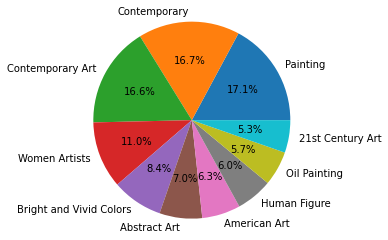

In [ ]:
filtered_dict_aw = {k: v for k, v in artworks_dict.items() if v['updating_date'] == datetime.now().date().strftime('%Y-%m-%d')}
print('Count of new artworks', len(filtered_dict_aw))

filtered_dict_g = {k: v for k, v in genes_dict.items() if v['updating_date'] == datetime.now().date().strftime('%Y-%m-%d')}
print('Count of updated genes', len(filtered_dict_g))

updated_genes_count_dict = {}

#import collections
#c = collections.Counter()
#for category in categories:
#    c[category] += 1
#print (c)
#Out: Counter({'page': 74, 'datepicker': 15, 'table': 10, 'report': 8})

for artwork in filtered_dict_aw.values():
  for gen in artwork['gene_id']:
    if gen in updated_genes_count_dict.keys():
      gen_count = updated_genes_count_dict[gen] + 1
      updated_genes_count_dict.update({gen: gen_count})
    else:
      updated_genes_count_dict.update({gen: 1})

print('Count of updated genes check', len(updated_genes_count_dict))

genes_ids = [v['id'] for v in filtered_dict_g.values()]
genes_names = [v['name'] for v in filtered_dict_g.values()]

def by_value(item):
  return item[1]

counts = []
genes = []
for k, v in sorted(updated_genes_count_dict.items(), key=by_value, reverse=True)[:10]:
  counts.append(v)
  genes.append(genes_names[genes_ids.index(k)])

fig, ax = plt.subplots()
ax.pie(counts[:10], labels=genes[:10], autopct='%1.1f%%')
ax.axis("equal")
plt.show()

## Categories & Genes

In [ ]:
# categories_dict = {'name_': {'genes_id': [], 'id': '', 'link': '', 'name': '', 
#                              'parsing_date': '', 'updating_date': ''}}

categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
print("Categories dictionary's length is - {}".format(len(categories_dict)))
print('')

def by_value(item):
  return len(item[1]['genes_id'])

for k, v in sorted(categories_dict.items(), key=by_value, reverse=True):
  print(k, '->', 'id', v['id'], '->', 'genes count' , len(v['genes_id']))

Categories dictionary's length is - 16

styles_and_movements -> id 03 -> genes count 252
subject_matter -> id 02 -> genes count 213
medium_and_techniques -> id 06 -> genes count 176
visual_qualities -> id 05 -> genes count 75
cultural_and_religious_styles -> id 11 -> genes count 69
geographic_regions -> id 08 -> genes count 68
materials -> id 09 -> genes count 39
furniture_and_lighting -> id 12 -> genes count 27
design_movements -> id 04 -> genes count 26
design_concepts_and_techniques -> id 10 -> genes count 22
time_periods -> id 07 -> genes count 20
tableware_vessels_and_objects -> id 15 -> genes count 19
artistic_disciplines -> id 01 -> genes count 7
jewelry_and_fashion_object_types -> id 14 -> genes count 7
antiquities_artifacts_and_religious_objects -> id 16 -> genes count 7
textiles -> id 13 -> genes count 6


What I'm interested in:
- styles_and_movements -> id 03 -> genes count 252
- subject_matter -> id 02 -> genes count 213
- medium_and_techniques -> id 06 -> genes count 176
- visual_qualities -> id 05 -> genes count 75
- cultural_and_religious_styles -> id 11 -> genes count 69
- geographic_regions -> id 08 -> genes count 68
- materials -> id 09 -> genes count 39
- time_periods -> id 07 -> genes count 20

Filtered by:
- time_periods -> id 07 -> genes count 20
- styles_and_movements -> id 03 -> genes count 252
- medium_and_techniques -> id 06 -> genes count 176

In [ ]:
# genes_dict = {'name_': {'artist_id': [], 'artsy_id': [], 'category_id': '', 'id': '', 'link': '', 
#                         'name': '', 'parsing_date': '', 'updating_date': ''}}

genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
print("Genes dictionary's length is", len(genes_dict))

Genes dictionary's length is 1033


### commonality of artworks
Let's check our selected categories on commonality of artworks_id.

In [ ]:
# Creait all pairs of categories to find the better one by artworks corresponding as a start

cat_id_list = ['06', '03', '08', '02', '05', '09', '07', '11']
pairs = list(it.combinations(cat_id_list,2))

In [ ]:
# Get common list of artworks in list of categories
def get_common_list(items, output):
  artworks_lists = []
  for v in categories_dict.values():
    if v['id'] in items:
      cat_artwork_list = []
      for gene in v['genes_id']:
        for value in genes_dict.values():
          if value['id']==gene:
            cat_artwork_list = list(set(cat_artwork_list + value['artsy_id']))
      artworks_lists.append(cat_artwork_list)
      if output=='y':
        print('Category', v['id'], v['name'], '; Artworks count', len(cat_artwork_list))

  common_artworks_list = artworks_lists[0]
  for artwork_list in artworks_lists[1:]:
    common_artworks_list = list(set(common_artworks_list) & set(artwork_list))
    
  return common_artworks_list

In [ ]:
# Find the better pair of categories by artworks corresponding

list_len = 0
for pair in pairs:
  list_len_new = len(get_common_list(pair, 'n')) # Get common list of artworks in list of categories
  if list_len_new > list_len:
    best_pair = pair
    best_len = list_len_new
    list_len = list_len_new

print('The best pair with common artworks list length', best_len, 'is:')
for v in categories_dict.values():
  if v['id'] in best_pair:
    print('Category', v['id'], v['name'])

# reduce the previous list
cat_id_list = list(set(cat_id_list) - set(list(best_pair)))

The best pair with common artworks list length 72163 is:
Category 03 Styles and Movements
Category 06 Medium and Techniques


In [ ]:
common_list = get_common_list(best_pair, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 06 Medium and Techniques ; Artworks count 182501


72163

Well, both of the categories are in my supposed filter.

In [ ]:
# Get new ordered list of categories by artworks corresponding
def get_next_cat(id_list, items):
  list_len = 0
  for cat in id_list:
    items_list = items.copy()
    items_list.append(cat)
    list_len_new = len(get_common_list(items_list, 'n')) # Get common list of artworks in list of categories
    if list_len_new > list_len:
      best_ord = items_list.copy()
      best_len = list_len_new
      list_len = list_len_new

  print('The best order by common artworks list length', best_len, 'is:')
  for v in categories_dict.values():
    if v['id'] in best_ord:
      print('Category', v['id'], v['name'])
  print('')

  # reduce the previous list
  items_list_new = best_ord.copy()
  id_list_new = list(set(id_list) - set(items_list_new))
  
  if len(id_list_new) > 0:
    return get_next_cat(id_list_new, items_list_new) # repit to find next better category
  else:
    return items_list_new

In [ ]:
cat_id_list_ord = get_next_cat(cat_id_list, list(best_pair)) # Get new ordered list of categories by artworks corresponding
cat_id_list_ord

The best order by common artworks list length 44747 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 06 Medium and Techniques

The best order by common artworks list length 18974 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques

The best order by common artworks list length 5458 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 08 Geographic Regions

The best order by common artworks list length 1467 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 07 Time Periods
Category 08 Geographic Regions

The best order by common artworks list length 155 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 07 Time Periods
Category 08 Geographic

['06', '03', '02', '05', '08', '07', '09', '11']

In [ ]:
# All categories with artworks counts
common_list = get_common_list(cat_id_list_ord, 'y') # Get common list of artworks in list of categories
len(common_list)
# '06' > '03' > '08' > '02' > '05' > '09' > '07' > '11' by artworks count

Category 02 Subject Matter ; Artworks count 116159
Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028
Category 08 Geographic Regions ; Artworks count 140035
Category 09 Materials ; Artworks count 53400
Category 11 Cultural and Religious Styles ; Artworks count 8098


18

Categories by artworks count:
1. Category 06 Medium and Techniques ; Artworks count - 182.501
2. Category 03 Styles and Movements ; Artworks count - 170.068
3. Category 08 Geographic Regions ; Artworks count - 140.035
4. Category 02 Subject Matter ; Artworks count - 116.159
5. Category 05 Visual Qualities ; Artworks count - 77.262
6. Category 09 Materials ; Artworks count - 53.400
7. Category 07 Time Periods ; Artworks count - 44.028
8. Category 11 Cultural and Religious Styles ; Artworks count - 8.098

Categories by common artworks list:
1. Category 06 Medium and Techniques; List length - 182.501
2. Category 03 Styles and Movements; List length - 72.163
3. Category 02 Subject Matter; List length - 44.747
4. Category 05 Visual Qualities; List length - 18.974
5. Category 08 Geographic Regions; List length - 5.458
6. Category 07 Time Periods; List length - 1.467
7. Category 09 Materials; List length - 155
8. Category 11 Cultural and Religious Styles; List length - 18

In [ ]:
# My supposed filters
items = ['07', '03', '06']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028


10902

Summing up, categories don't correspond with each other by artworks quite well. Why?
- as it is
- maximum pages for a gene were 100, maybe there're more artworks in fact

I can easely rid of:
- Category 08 Geographic Regions
- Category 09 Materials
- Category 11 Cultural and Religious Styles

And this one can be considered as bonus: 
- Category 02 Subject Matter


In [ ]:
items = ['06', '03', '05', '07']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028


4092

Category 05 Visual Qualities is a big-big bonus in my case.

In [ ]:
items = ['06', '03', '05']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501


27042

I want to limit the whole data of artworks by certain:
- Time Periods (07: 44.028 a/w) ->
- Styles and Movements (03: 170.068 a/w) ->
- Medium and Techniques (06: 182.501 a/w)

And study their:
- Visual Qualities (05: 77.262 a/w) ->
- Subject Matter (02: 44.747 a/w)

So, what I can do to enlarge my limited database is:
1. Get artworks list of certain Time periods genes.
2. Get Styles and Movements genes of these artwoks.
3. Look at the rest artworks of these Styles and Movements genes - what Time periods genes they belong to - and limit the database with whole Styles and Movements genes.



### database limitation
Start with time periods

In [ ]:
time_periods_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='07'}
print('Time periods genes count', len(time_periods_genes_dict))

Time periods genes count 20


In [ ]:
for k in time_periods_genes_dict.keys():
  print(time_periods_genes_dict[k]['name'], '-> gene id', time_periods_genes_dict[k]['id'], '-> artwork count', len(time_periods_genes_dict[k]['artsy_id']))

1000 - 1400 CE Art -> gene id 07001 -> artwork count 947
15th Century Art -> gene id 07002 -> artwork count 2063
16th Century Art -> gene id 07003 -> artwork count 2990
17th Century Art -> gene id 07004 -> artwork count 3004
18th Century Art -> gene id 07005 -> artwork count 3007
1900 - 1917 Art -> gene id 07006 -> artwork count 3019
1918 - 1939 (Interwar) Art -> gene id 07007 -> artwork count 3040
1940s-1950s Art -> gene id 07008 -> artwork count 3287
19th Century Art -> gene id 07009 -> artwork count 3040
21st Century Art -> gene id 07010 -> artwork count 3035
500 - 1000 CE  Art -> gene id 07011 -> artwork count 121
Ancient Art -> gene id 07012 -> artwork count 1097
Art of the 1960s -> gene id 07013 -> artwork count 3031
Art of the 1970s -> gene id 07014 -> artwork count 3039
Art of the 1980s -> gene id 07015 -> artwork count 3037
Art of the 1990s -> gene id 07016 -> artwork count 3030
Contemporary -> gene id 07017 -> artwork count 3168
Late 19th Century Art -> gene id 07018 -> artwo

For now I'm interested in:
- 15th Century Art -> gene id 07002 -> artwork count 2063
- 16th Century Art -> gene id 07003 -> artwork count 2990
- 17th Century Art -> gene id 07004 -> artwork count 3004
- 18th Century Art -> gene id 07005 -> artwork count 3007
- 19th Century Art -> gene id 07009 -> artwork count 3040
- Late 19th Century Art -> gene id 07018 -> artwork count 3024

And:
- 1900 - 1917 Art -> gene id 07006 -> artwork count 3019
- 1918 - 1939 (Interwar) Art -> gene id 07007 -> artwork count 3040
- Modern -> gene id 07019 -> artwork count 3026

So, let's take the artworks of these genes and find them in Styles and Movements category.

In [ ]:
# 1. Get artworks list of certain Time periods genes.
time_periods_genes_list = ['07002', '07003', '07004', '07005', '07009', '07018', '07006', '07007', '07019']
time_periods_artworks_list = []
artwork_count = 0
for v in time_periods_genes_dict.values():
  if v['id'] in time_periods_genes_list:
    time_periods_artworks_list = list(set(time_periods_artworks_list + v['artsy_id']))
    artwork_count += len(v['artsy_id'])

print('Selected time periods genes count:', len(time_periods_genes_list))
print('artwork count:', artwork_count)
print('Unique artworks count:', len(time_periods_artworks_list))

Selected time periods genes count: 9
artwork count: 26213
Unique artworks count: 23402


In [ ]:
# 2. Get Styles and Movements genes of these artwoks
styles_movements_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='03'}
common_periods_movements_artworks_list = []
periods_movements_genes_list = []
for v in styles_movements_genes_dict.values():
  id_list = list(set(v['artsy_id']) & set(time_periods_artworks_list))
  if len(id_list) != 0:
    common_periods_movements_artworks_list = list(set(common_periods_movements_artworks_list + id_list))
    periods_movements_genes_list.append(v['id'])

print('Styles and movements genes count', len(styles_movements_genes_dict))
print('Styles and movements genes by selected artworks count', len(periods_movements_genes_list))
print('Common artworks for Styles and movements and Time periods:', len(common_periods_movements_artworks_list))
print('Common ids check:', len(list(set(common_periods_movements_artworks_list) & set(time_periods_artworks_list))))

Styles and movements genes count 252
Styles and movements genes by selected artworks count 148
Common artworks for Styles and movements and Time periods: 8663
Common ids check: 8663


Just 1/3 of artworks of selected Time period genes are defined in Styles and movements category...

In [ ]:
# 3. Look at the rest artworks of these Styles and Movements genes (148) - 
#    what Time periods genes they belong to - 
#    and limit the database with whole Styles and Movements genes.

print('Styles and movemens genes by selected artworks count', len(periods_movements_genes_list))

# rest artworks of these Styles and Movements genes (148)
rest_periods_movements_artworks_list = []
for v in styles_movements_genes_dict.values():
  if v['id'] in periods_movements_genes_list: # 148 genes with common artworks
    id_list = list(set(v['artsy_id']) - set(time_periods_artworks_list)) # artworks selected by time periods
    rest_periods_movements_artworks_list = list(set(rest_periods_movements_artworks_list + id_list))

print('Rest artworks for Styles and movements:', len(rest_periods_movements_artworks_list))
print('Rest ids check:', len(list(set(time_periods_artworks_list) - set(common_periods_movements_artworks_list))))

Styles and movemens genes by selected artworks count 148
Rest artworks for Styles and movements: 131845
Rest ids check: 14739


In [ ]:
# Check the correctness
rest_time_periods_artworks_list = list(set(time_periods_artworks_list) - set(common_periods_movements_artworks_list))
print('Rest artworks for Time periods:', len(rest_time_periods_artworks_list))
print('')
for v in styles_movements_genes_dict.values():
  if len(list(set(v['artsy_id']) & set(rest_time_periods_artworks_list))) > 0:
    print(v['name'], '-> gene id', v['id'])
# correct

Rest artworks for Time periods: 14739



In [ ]:
# what Time periods genes they belong to
rest_periods_movements_genes_list = []
rest_periods_artworks_lists = []

for v in time_periods_genes_dict.values(): # with all time periods genes
  if v['id'] not in time_periods_genes_list: # not in filtered time_period genes (but if it is, the artworks mustn't be in the list)
    id_list = list(set(v['artsy_id']) & set(rest_periods_movements_artworks_list)) # rest artworks of these Styles and Movements genes (148)
    if len(id_list) > 0: 
      rest_periods_movements_genes_list.append(v['id'])
      rest_periods_artworks_lists.append(id_list)

for v in time_periods_genes_dict.values():
  if v['id'] in rest_periods_movements_genes_list:
    print(v['name'], '-> gene id', v['id'], '-> cross artworks count', len(rest_periods_artworks_lists[rest_periods_movements_genes_list.index(v['id'])]))

1000 - 1400 CE Art -> gene id 07001 -> cross artworks count 204
1940s-1950s Art -> gene id 07008 -> cross artworks count 1841
21st Century Art -> gene id 07010 -> cross artworks count 1373
500 - 1000 CE  Art -> gene id 07011 -> cross artworks count 59
Ancient Art -> gene id 07012 -> cross artworks count 303
Art of the 1960s -> gene id 07013 -> cross artworks count 2059
Art of the 1970s -> gene id 07014 -> cross artworks count 1141
Art of the 1980s -> gene id 07015 -> cross artworks count 1067
Art of the 1990s -> gene id 07016 -> cross artworks count 1272
Contemporary -> gene id 07017 -> cross artworks count 1092
Prehistoric Art -> gene id 07020 -> cross artworks count 16


All the others... That's super strange. Let's check some.

#### cross artworks checking

In [ ]:
def check_cross_artworks(gene, inx):
  print('Check {} gene'.format(gene))
  artworks_check_list = rest_periods_artworks_lists[rest_periods_movements_genes_list.index(inx)]
  print('length of the artworks_check_list', len(artworks_check_list))
  genes_check_list = []
  artworks_lists = []
  for v in styles_movements_genes_dict.values():
    if v['id'] in periods_movements_genes_list: # 148 genes with common artworks
      id_list = list(set(v['artsy_id']) & set(artworks_check_list))
      if len(id_list) != 0:
        genes_check_list.append(v['id'])
        artworks_lists.append(id_list)
  print('length of the genes_check_list', len(genes_check_list))
  print('')

  for k, v in styles_movements_genes_dict.items():
    if v['id'] in genes_check_list:
      print(k, '->', v['name'], '-> gene id', v['id'], '-> cross artworks count', len(artworks_lists[genes_check_list.index(v['id'])]))


In [ ]:
gene = 'Prehistoric Art'
inx = '07020'

check_cross_artworks(gene, inx)
# OK

Check Prehistoric Art gene
length of the artworks_check_list 16
length of the genes_check_list 3

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 1
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 13
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 3


In [ ]:
gene = 'Ancient Art'
inx = '07012'

check_cross_artworks(gene, inx)
# gothic_art-??
# medieval_art-??
# northern_renaissance-??
# old_masters-??

# land_art-?
# pattern_and_decoration_movement-?

Check Ancient Art gene
length of the artworks_check_list 303
length of the genes_check_list 10

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 2
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 187
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 61
land_art -> Land Art -> gene id 03151 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross artworks count 5
northern_renaissance -> Northern Renaissance -> gene id 03183 -> cross artworks count 1
old_masters -> Old Masters -> gene id 03188 -> cross artworks count 1
pattern_and_decoration_movement -> Pattern and Decoration Movement -> gene id 03192 -> cross artworks count 6
traditional_arts_of_africa_oceania_and_the_americas -> Traditional Arts of Africa, Oceania, and the Americas -> gene id 03241 -> cross artworks count 73


In [ ]:
gene = '500 - 1000 CE  Art'
inx = '07011'

check_cross_artworks(gene, inx)
# abstract_sculpture-?
# traditional_arts_of_africa_oceania_and_the_americas... geographic_regions -> id 08 !!!

# land_art-?

Check 500 - 1000 CE  Art gene
length of the artworks_check_list 59
length of the genes_check_list 8

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 1
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 23
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 28
land_art -> Land Art -> gene id 03151 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross artworks count 3
symbolism -> Symbolism -> gene id 03233 -> cross artworks count 3
traditional_arts_of_africa_oceania_and_the_americas -> Traditional Arts of Africa, Oceania, and the Americas -> gene id 03241 -> cross artworks count 15


In [ ]:
gene = '1000 - 1400 CE Art'
inx = '07001'

check_cross_artworks(gene, inx)
# art_deco-??
# hyperrealism_and_photorealism-??
# impressionism_and_contemporary_impressionist-??
# op_art-??

# old_masters, old_master_drawings_and_prints-?

Check 1000 - 1400 CE Art gene
length of the artworks_check_list 204
length of the genes_check_list 17

abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 1
art_deco -> Art Deco -> gene id 03026 -> cross artworks count 1
dutch_and_flemish -> Dutch and Flemish -> gene id 03109 -> cross artworks count 1
early_renaissance -> Early Renaissance -> gene id 03111 -> cross artworks count 11
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 46
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 42
hyperrealism_and_photorealism -> Hyperrealism and Photorealism -> gene id 03142 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 63
impressionism_and_contemporary_impressionist -> Impressionism and Contemporary Impressionist -> gene id 03146 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross ar

In [ ]:
gene = 'Contemporary'
inx = '07017'

check_cross_artworks(gene, inx)
# contemporary... shouldn't be before 1940s

Check Contemporary gene
length of the artworks_check_list 1092
length of the genes_check_list 40

20th_century_art -> 20th Century Art -> gene id 03007 -> cross artworks count 1
abstract_art -> Abstract Art -> gene id 03008 -> cross artworks count 219
abstract_painting -> Abstract Painting -> gene id 03010 -> cross artworks count 5
abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 66
art_deco -> Art Deco -> gene id 03026 -> cross artworks count 1
art_nouveau -> Art Nouveau -> gene id 03028 -> cross artworks count 1
collaborations_and_collectives -> Collaborations and Collectives -> gene id 03047 -> cross artworks count 1
contemporary_academic_realism -> Contemporary Academic Realism -> gene id 03053 -> cross artworks count 40
contemporary_african_art -> Contemporary African Art -> gene id 03054 -> cross artworks count 52
contemporary_art -> Contemporary Art -> gene id 03056 -> cross artworks count 823
contemporary_asian_art -> Con

In [ ]:
gene = '21st Century Art'
inx = '07010'

check_cross_artworks(gene, inx)
# contemporary... shouldn't be before 1940s

Check 21st Century Art gene
length of the artworks_check_list 1373
length of the genes_check_list 55

abstract_art -> Abstract Art -> gene id 03008 -> cross artworks count 255
abstract_painting -> Abstract Painting -> gene id 03010 -> cross artworks count 58
abstract_photography -> Abstract Photography -> gene id 03011 -> cross artworks count 19
abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 13
abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 97
conceptual_art -> Conceptual Art -> gene id 03049 -> cross artworks count 3
conceptual_art_and_contemporary_conceptualism -> Conceptual Art and Contemporary Conceptualism -> gene id 03050 -> cross artworks count 15
contemporary_academic_realism -> Contemporary Academic Realism -> gene id 03053 -> cross artworks count 42
contemporary_african_art -> Contemporary African Art -> gene id 03054 -> cross artworks count 43
contemporary_art -> Contemporary Art ->

In [ ]:
#1940s-1950s Art -> gene id 07008 -> cross artworks count 1841
#Art of the 1960s -> gene id 07013 -> cross artworks count 2059
#Art of the 1970s -> gene id 07014 -> cross artworks count 1141
#Art of the 1980s -> gene id 07015 -> cross artworks count 1067
#Art of the 1990s -> gene id 07016 -> cross artworks count 1272

### iconic_works_of_art_history

Unfortunatelly, I can't limit the database with whole Styles and Movements genes that have any common artworks with selected Time periods genes.

Interesting Styles and Movements gene - iconic_works_of_art_history. Let's explore it.

In [ ]:
styles_movements_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='03'}

In [ ]:
iconic_works_list = styles_movements_genes_dict['iconic_works_of_art_history']['artsy_id']
len(iconic_works_list)

536

In [ ]:
# let's create two dataframes for further analysis and visualisation
category_id_list = []
cat_count_list = []

gene_name_list = []
gene_id_list = []
gene_cat_id_list = []
gene_count_list = []

In [ ]:
# what other Styles & Movements genes they belong to
iconic_movements_genes_list = []
iconic_movements_artworks_lists = []
category_id_list.append('03')

for v in styles_movements_genes_dict.values(): # with all time periods genes
  if v['id'] is not styles_movements_genes_dict['iconic_works_of_art_history']['id']: # not in filtered time_period genes
    id_list = list(set(v['artsy_id']) & set(iconic_works_list))
    if len(id_list) > 0: 
      iconic_movements_genes_list.append(v['id'])
      iconic_movements_artworks_lists.append(id_list)

for v in styles_movements_genes_dict.values():
  if v['id'] in iconic_movements_genes_list:
    print(v['name'], '-> gene id', v['id'], '-> iconic artworks count', len(iconic_movements_artworks_lists[iconic_movements_genes_list.index(v['id'])]))
    gene_id_list.append(v['id'])
    gene_name_list.append(v['name'])
    gene_cat_id_list.append(v['category_id'])
    gene_count_list.append(len(iconic_movements_artworks_lists[iconic_movements_genes_list.index(v['id'])]))

iconic_movements_artworks_unique = []
for id_list in iconic_movements_artworks_lists:
  iconic_movements_artworks_unique = list(set(iconic_movements_artworks_unique + id_list))
print('')
print('Total count of iconic artworks', len(iconic_movements_artworks_unique))
cat_count_list.append(len(iconic_movements_artworks_unique))

19th Century American Art -> gene id 03003 -> iconic artworks count 15
19th Century American Paintings and Works on Paper -> gene id 03004 -> iconic artworks count 12
19th Century French Academy -> gene id 03005 -> iconic artworks count 5
20th Century Art -> gene id 03007 -> iconic artworks count 1
Abstract Expressionism -> gene id 03009 -> iconic artworks count 4
American Impressionism -> gene id 03017 -> iconic artworks count 5
American Modernism -> gene id 03018 -> iconic artworks count 1
American Regionalism -> gene id 03021 -> iconic artworks count 1
American Sculpture 1830–1950 -> gene id 03022 -> iconic artworks count 1
American Tonalism -> gene id 03023 -> iconic artworks count 1
American Works on Paper 1880–1950 -> gene id 03024 -> iconic artworks count 1
Art Deco -> gene id 03026 -> iconic artworks count 1
Art Nouveau -> gene id 03028 -> iconic artworks count 6
Arte Povera -> gene id 03029 -> iconic artworks count 1
Barbizon School -> gene id 03031 -> iconic artworks count 1


In [ ]:
print("{} works aren't belong to Style or Movement, just to Iconic works".format(len(iconic_works_list) - len(iconic_periods_artworks_unique)))

117 works aren't belong to Style or Movement, just to Iconic works


Will be interesting to look at them.

In [ ]:
#sample(list(set(iconic_works_list) - set(iconic_periods_artworks_unique)), 10)

In [ ]:
# what other category genes they belong to
def get_stat_by_cat(cat):
  filtered_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']==cat}

  iconic_periods_genes_list = []
  iconic_periods_artworks_lists = []

  for v in filtered_genes_dict.values():
    id_list = list(set(v['artsy_id']) & set(iconic_works_list))
    if len(id_list) > 0: 
      iconic_periods_genes_list.append(v['id'])
      iconic_periods_artworks_lists.append(id_list)

  for v in filtered_genes_dict.values():
    if v['id'] in iconic_periods_genes_list:
      print(v['name'], '-> gene id', v['id'], '-> iconic artworks count', len(iconic_periods_artworks_lists[iconic_periods_genes_list.index(v['id'])]))
      gene_id_list.append(v['id'])
      gene_name_list.append(v['name'])
      gene_cat_id_list.append(v['category_id'])
      gene_count_list.append(len(iconic_periods_artworks_lists[iconic_periods_genes_list.index(v['id'])]))
    
  iconic_periods_artworks_unique = []
  for id_list in iconic_periods_artworks_lists:
    iconic_periods_artworks_unique = list(set(iconic_periods_artworks_unique + id_list))
  print('')
  print('Total count of iconic artworks', len(iconic_periods_artworks_unique))
  cat_count_list.append(len(iconic_periods_artworks_unique))

In [ ]:
cat_id_list = ['06', '08', '02', '05', '09', '07', '11']
for cat in cat_id_list:
  for v in categories_dict.values():
    if v['id']==cat:
      category_id_list.append(v['id'])
      print('Iconic artworks belong to further genes in category', v['name'])
      print('')
      get_stat_by_cat(cat)
      print('')

Iconic artworks belong to further genes in category Medium and Techniques

Album, Folio and Fan Formats -> gene id 06002 -> iconic artworks count 2
Altarpiece -> gene id 06003 -> iconic artworks count 8
Appropriation -> gene id 06007 -> iconic artworks count 5
Arabic/Farsi Calligraphy -> gene id 06008 -> iconic artworks count 7
Archaeological Object -> gene id 06009 -> iconic artworks count 3
Art That Plays With Scale -> gene id 06010 -> iconic artworks count 3
Automatism -> gene id 06013 -> iconic artworks count 4
Caravaggesque -> gene id 06020 -> iconic artworks count 4
Chiaroscuro -> gene id 06023 -> iconic artworks count 42
Cinematic -> gene id 06024 -> iconic artworks count 1
Color Theory -> gene id 06029 -> iconic artworks count 8
Comic/Cartoon -> gene id 06030 -> iconic artworks count 1
Copies and Emulations -> gene id 06032 -> iconic artworks count 4
Densely Textured or Haptic Surface -> gene id 06036 -> iconic artworks count 3
Divinatory Objects, Talismans, and Amulets -> gene

In [ ]:
def get_cat_name(cell):
  for v in categories_dict.values():
    if v['id']==cell:
      cell = v['name']
  return cell

In [ ]:
cat_count_df = pd.DataFrame({'category_id': category_id_list, 
                             'count':cat_count_list
                             }) # + category_name

gene_count_df = pd.DataFrame({'gene_name': gene_name_list, 'gene_id': gene_id_list, 
                           'category_id': gene_cat_id_list, 'count': gene_count_list
                           }) # + category_name

#cat_count_df = cat_count_df.set_axis(['category_id', 'count'], axis=1, inplace=False)
#gene_count_df = gene_count_df.set_axis(['gene_name', 'gene_id', 'category_id', 'count'], axis=1, inplace=False)

cat_count_df['category_name'] = cat_count_df['category_id'].dropna().apply(get_cat_name)
gene_count_df['category_name'] = gene_count_df['category_id'].dropna().apply(get_cat_name)

In [ ]:
cat_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_id    8 non-null      object
 1   count          8 non-null      int64 
 2   category_name  8 non-null      object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


In [ ]:
gene_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gene_name      388 non-null    object
 1   gene_id        388 non-null    object
 2   category_id    388 non-null    object
 3   count          388 non-null    int64 
 4   category_name  388 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.3+ KB


In [ ]:
cat_count_df

,category_id,count,category_name
0,03,419,Styles and Movements
1,06,272,Medium and Techniques
2,08,31,Geographic Regions
3,02,471,Subject Matter
4,05,219,Visual Qualities
5,09,58,Materials
6,07,353,Time Periods
7,11,233,Cultural and Religious Styles


In [ ]:
gene_count_df.sample(10)

,gene_name,gene_id,category_id,count,category_name
184,Face,02062,02,15,Subject Matter
304,Hard-Edged,05035,05,2,Visual Qualities
94,En plein air,06049,06,8,Medium and Techniques
201,Hybrids and Imaginary Creatures,02085,02,17,Subject Matter
212,Madonna and Child,02106,02,17,Subject Matter
84,Chiaroscuro,06023,06,42,Medium and Techniques
338,Mosaics,09021,09,7,Materials
138,Central Asian Art,08019,08,1,Geographic Regions
264,The City,02188,02,3,Subject Matter
343,Use of Ephemeral Materials,09035,09,1,Materials


In [ ]:
for cat in gene_count_df['category_name'].unique():
  print(cat)
  print('Sum by category', gene_count_df.loc[gene_count_df['category_name']==cat]['count'].sum())
  print('Unique by category', cat_count_df.loc[cat_count_df['category_name']==cat]['count'].values[0])
  print('')
  print(gene_count_df.loc[gene_count_df['category_name']==cat].describe())
  print('')

Styles and Movements
Sum by category 891
Unique by category 419

            count
count   76.000000
mean    11.723684
std     22.077197
min      1.000000
25%      1.000000
50%      3.000000
75%     12.000000
max    127.000000

Medium and Techniques
Sum by category 395
Unique by category 272

          count
count  61.00000
mean    6.47541
std     8.44513
min     1.00000
25%     1.00000
50%     3.00000
75%     8.00000
max    44.00000

Geographic Regions
Sum by category 31
Unique by category 31

           count
count   7.000000
mean    4.428571
std     4.613644
min     1.000000
25%     1.000000
50%     2.000000
75%     7.500000
max    11.000000

Subject Matter
Sum by category 1819
Unique by category 471

            count
count  140.000000
mean    12.992857
std     16.920252
min      1.000000
25%      3.000000
50%      7.000000
75%     16.250000
max     96.000000

Visual Qualities
Sum by category 308
Unique by category 219

           count
count  44.000000
mean    7.000000
std     9.8

Most of the categories has a lot of genes what makes visualization confusing. Let's merge genes with less then third quartile artworks into an 'Others' in every category except ones with less then 10 genes.

In [ ]:
for cat in gene_count_df['category_name'].unique():
  print(cat)
  cat_df = gene_count_df.loc[gene_count_df['category_name']==cat]
  print('Count of genes before renaming:', cat_df['gene_name'].nunique())
  if cat_df['gene_name'].nunique() > 10:
    quartile_3 = np.percentile(cat_df['count'], 75)
    big_counts_df = cat_df.loc[cat_df['count'] >= quartile_3]
    small_counts_df = cat_df.loc[cat_df['count'] < quartile_3]
    small_counts_df['gene_name'] = 'Others'
    cat_df_new = pd.concat([big_counts_df, small_counts_df])
  else:
    cat_df_new = cat_df.copy()
  print('Count of genes after renaming:', cat_df_new['gene_name'].nunique())
  print('')

Styles and Movements
Count of genes before renaming: 76
Count of genes after renaming: 23

Medium and Techniques
Count of genes before renaming: 61
Count of genes after renaming: 19

Geographic Regions
Count of genes before renaming: 7
Count of genes after renaming: 7

Subject Matter
Count of genes before renaming: 140
Count of genes after renaming: 36

Visual Qualities
Count of genes before renaming: 44
Count of genes after renaming: 13

Materials
Count of genes before renaming: 17
Count of genes after renaming: 7

Time Periods
Count of genes before renaming: 9
Count of genes after renaming: 9

Cultural and Religious Styles
Count of genes before renaming: 34
Count of genes after renaming: 10



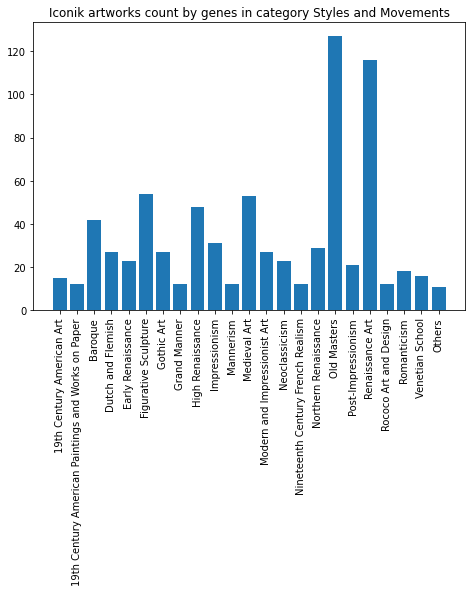

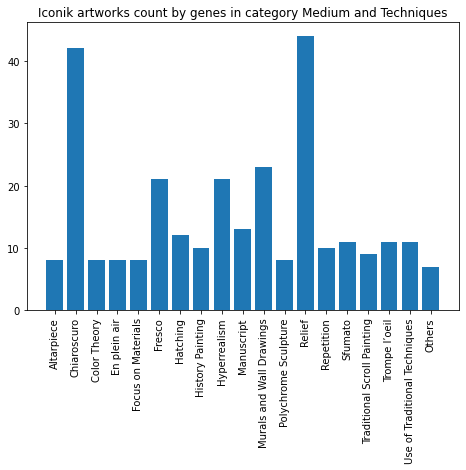

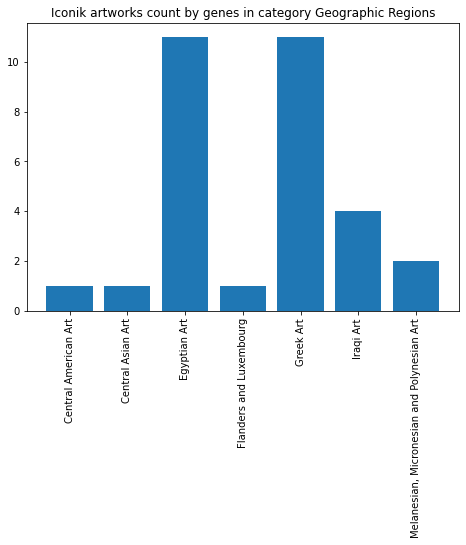

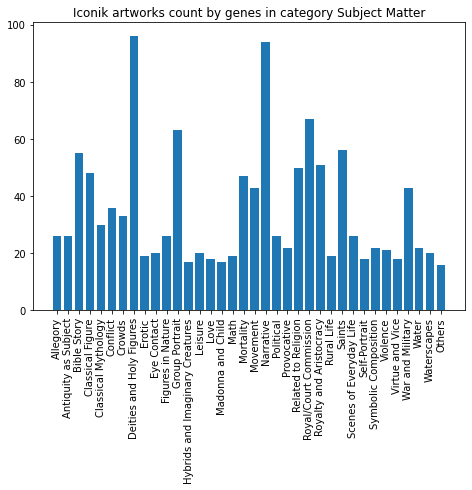

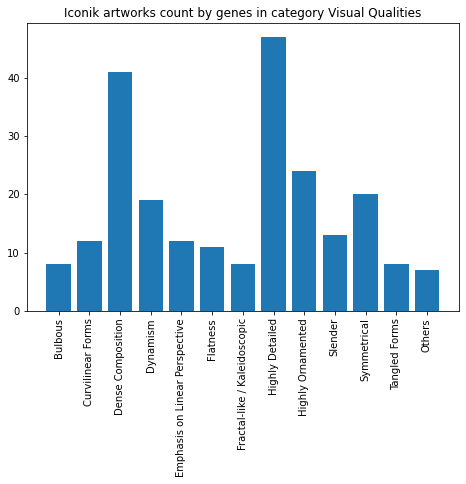

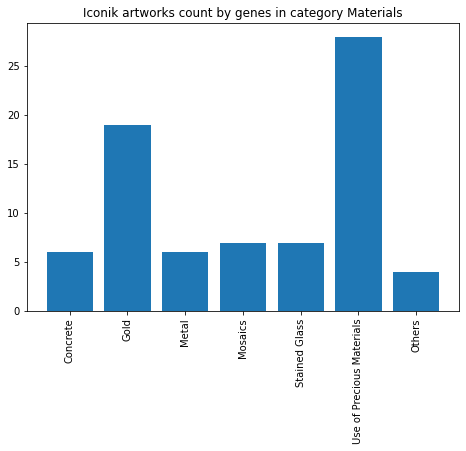

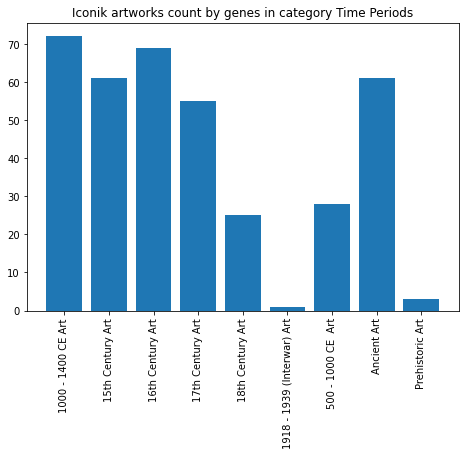

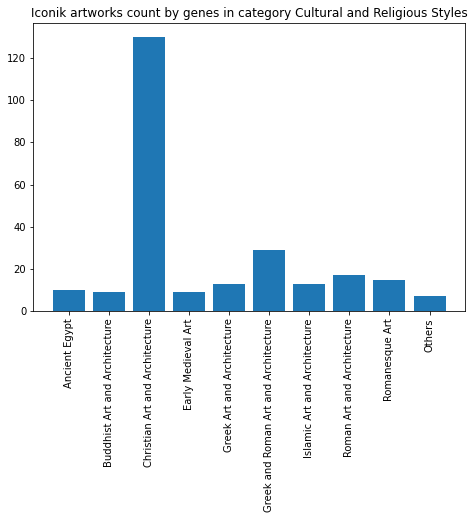

In [ ]:
for cat in gene_count_df['category_name'].unique():
  cat_df = gene_count_df.loc[gene_count_df['category_name']==cat]
  if cat_df['gene_name'].nunique() > 10:
    quartile_3 = np.percentile(cat_df['count'], 75)
    big_counts_df = cat_df.loc[cat_df['count'] >= quartile_3]
    small_counts_df = cat_df.loc[cat_df['count'] < quartile_3]
    small_counts_df['gene_name'] = 'Others'
    cat_df_new = pd.concat([big_counts_df, small_counts_df])
  else:
    cat_df_new = cat_df.copy()
  
  fig = plt.figure()
  axes = fig.add_axes([0, 0, 1, 1])
  axes.bar(x = cat_df_new['gene_name'], height = cat_df_new['count'])
  axes.set_xticklabels(cat_df_new['gene_name'], rotation = 90)
  axes.set_title('Iconik artworks count by genes in category {}'.format(cat))
  
  plt.show()

  print('')

In [ ]:
# artists_dict = {'id': {'artsy_id': [], 'category_id': [], 'gene_id': [], 'name': ''}}

#artists_dict = open_dict(artist_dict, 'live') # 2. Open json dict
#len(artists_dict)

# artworks_dict = {'artsy_id': {'artist': '', 'artist_id': '', 'category_id': [], 'gallery': '', 'gene_id': [],
#                               'link': '', 'name': '', 'parsing_date': '', 'price': '', 'updating_date': ', 'year': ''}}

#artworks_dict = open_dict(artwork_dict, 'live') # 2. Open json dict
#len(artworks_dict)

# Images

In [ ]:
# Sample from API tables

# 'image': {'href': 'https://d32dm0rphc51dk.cloudfront.net/NOpIAwQa-3r51Cg9qXKbfA/{image_version}.jpg',
#                      'templated': True}
#i = 'https://d32dm0rphc51dk.cloudfront.net/NOpIAwQa-3r51Cg9qXKbfA/normalized.jpg'
#for p in i.split('.jpg')[0].split('/'):
#  print(len(p), p)

6 https:
0 
29 d32dm0rphc51dk.cloudfront.net
22 NOpIAwQa-3r51Cg9qXKbfA
10 normalized


In [ ]:
#! pip install pillow --user

import PIL
from PIL import Image
import os
import cv2

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [ ]:
image = requests.get(img, headers={'User-Agent': 'Chrome/97.0.4692.71'})
name = art_project_path + '/' + 'portrait_of_a_man_in_armour' + '.jpg'

img = open(name, 'wb')
img.write(image.content)
img.close()

img = Image.open(name)
plt.imshow(img)
plt.axis('off')
plt.show()

img.close()